# Training and validating LSTM + MPL model with the WHXE loss function

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import time
import pickle
import os
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from LSTM_model import get_LSTM_Classifier
from dataloader import LSSTSourceDataSet, load, get_augmented_data, get_static_features, ts_length
from loss import WHXE_Loss
from taxonomy import get_taxonomy_tree, get_prediction_probs, get_highest_prob_path, plot_colored_tree
from vizualizations import make_gif, plot_confusion_matrix, plot_roc_curves
from interpret_results import get_conditional_probabilites, get_all_confusion_matrices

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow import keras

2024-06-10 06:25:53.371167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 06:25:53.372772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 06:25:53.550643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 06:25:53.894309: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load and balance the tensors:

This step takes a while because it has load from disc to memory...

In [2]:
X_ts = load("processed/train/x_ts.pkl")
X_static = load("processed/train/x_static.pkl")
Y = load("processed/train/y.pkl")
lengths = load("processed/train/lengths.pkl")
astrophysical_classes = load("processed/train/a_labels.pkl")
elasticc_classes = load("processed/train/e_label.pkl")

Small step to convert X_static from a dictionary to an array

In [3]:
static_list = ['MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR']
for i in range(len(X_static)):
    
    if i%1000 == 0:
        print(f"{(i/len(X_static) * 100):.3f} %", end="\r")
        
    X_static[i] = get_static_features(X_static[i], feature_list=static_list)

Balance the data set in some way

In [4]:
max_class_count = 13000

X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
lengths_balanced = []
astrophysical_classes_balanced = []
elasticc_classes_balanced = []

for c in np.unique(astrophysical_classes):

    idx = np.where(np.array(astrophysical_classes) == c)[0]
    
    if len(idx) > max_class_count:
        idx = idx[:max_class_count]
 
    X_ts_balanced += [X_ts[i] for i in idx]
    X_static_balanced += [X_static[i] for i in idx]
    Y_balanced += [Y[i] for i in idx]
    astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]
    elasticc_classes_balanced += [elasticc_classes[i] for i in idx]

# Print summary of the data set used for training and validation
a, b = np.unique(astrophysical_classes_balanced, return_counts=True)
data_summary = pd.DataFrame(data = {'Class': a, 'Count': b})
data_summary

Class  Count
0             AGN  13000
1            CART   8207
2         Cepheid  13000
3     Delta Scuti  13000
4     Dwarf Novae   8025
5              EB  13000
6            ILOT   7461
7              KN   4426
8   M-dwarf Flare   1859
9            PISN  13000
10       RR Lyrae  13000
11           SLSN  13000
12        SNI91bg  13000
13           SNII  13000
14           SNIa  13000
15          SNIax  13000
16         SNIb/c  13000
17            TDE  13000
18          uLens  13000

Split into train and validation

In [5]:
val_fraction = 0.05
X_ts_train, X_ts_val, X_static_train, X_static_val, Y_train, Y_val, astrophysical_classes_train, astrophysical_classes_val = train_test_split(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, shuffle=True, random_state = 40, test_size = val_fraction)

## Define the Loss function, criterion, etc.

In [6]:
# Loss and optimizer
tree = get_taxonomy_tree()
loss_object = WHXE_Loss(tree, astrophysical_classes_train, alpha=0) 
criterion = loss_object.compute_loss

In [7]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

2024-06-10 06:28:34.802081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14777 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2024-06-10 06:28:34.803616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14777 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3a:00.0, compute capability: 7.0


In [8]:
# Inputs for model
ts_dim = 5
static_dim = 4
output_dim = 26
latent_size = 64

num_epochs = 50
batch_size = 1024

In [9]:
model = get_LSTM_Classifier(ts_dim, static_dim, output_dim, latent_size)
keras.utils.plot_model(model, to_file='lstm.png', show_shapes=True, show_layer_names=True)
plt.close()

## Train the classifier using WHXE loss and save the model

In [10]:
@tf.function
def train_step(x_ts, x_static, y):
    with tf.GradientTape() as tape:
        logits = model((x_ts, x_static), training=True)
        loss_value = criterion(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value
    
for epoch in range(num_epochs):
    print(f"\nStart of epoch {epoch}")
    start_time = time.time()

    # Create the augmented data set
    print("Augmenting time series lengths...")
    X_ts_train_aug, X_static_train_aug, Y_train_aug, astrophysical_classes_train_aug = get_augmented_data(X_ts_train, X_static_train, Y_train, astrophysical_classes_train)
    train_dataset =  tf.data.Dataset.from_tensor_slices((X_ts_train_aug, X_static_train_aug, Y_train_aug, astrophysical_classes_train_aug)).batch(batch_size)

    # Iterate over the batches of the dataset.
    for step, (x_ts_batch_train, x_static_batch_train, y_batch_train, a_class_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_ts_batch_train, x_static_batch_train, y_batch_train)

        # Log every 100 batches.
        if step % 100 == 0:
            print(
                f"Training loss (for 1 batch) at step {step}: {float(loss_value):.4f}"
            )
            print(f"Seen so far: {(step + 1) * batch_size} samples")

    print(f"Time taken: {time.time() - start_time:.2f}s")
    model.save(f"models/lstm_epoch_{epoch}.h5")


Start of epoch 0
Augmenting time series lengths...


2024-06-10 05:31:20.260749: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_18/output/_21'
2024-06-10 05:31:20.755912: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
2024-06-10 05:31:21.398506: I external/local_xla/xla/service/service.cc:168] XLA service 0x14bd716ec320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-10 05:3

Training loss (for 1 batch) at step 0: 1.3378
Seen so far: 1024 samples
Training loss (for 1 batch) at step 100: 0.8824
Seen so far: 103424 samples
Time taken: 63.36s

Start of epoch 1
Augmenting time series lengths...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training loss (for 1 batch) at step 0: 0.7647
Seen so far: 1024 samples
Training loss (for 1 batch) at step 100: 0.7542
Seen so far: 103424 samples
Time taken: 52.23s

Start of epoch 2
Augmenting time series lengths...
Training loss (for 1 batch) at step 0: 0.7168
Seen so far: 1024 samples
Training loss (for 1 batch) at step 100: 0.7282
Seen so far: 103424 samples
Time taken: 48.81s

Start of epoch 3
Augmenting time series lengths...
Training loss (for 1 batch) at step 0: 0.6096
Seen so far: 1024 samples
Training loss (for 1 batch) at step 100: 0.6226
Seen so far: 103424 samples
Time taken: 50.39s

Start of epoch 4
Augmenting time series lengths...
Training loss (for 1 batch) at step 0: 0.8222
Seen so far: 1024 samples
Training loss (for 1 batch) at step 100: 0.7681
Seen so far: 103424 samples
Time taken: 43.29s

Start of epoch 5
Augmenting time series lengths...
Training loss (for 1 batch) at step 0: 0.6611
Seen so far: 1024 samples
Training loss (for 1 batch) at step 100: 0.6798
Seen

## Load the saved model and validate everthing looks okay

In [10]:
load_model_epoch = 43
saved_model = keras.models.load_model(f"models/lstm_epoch_{load_model_epoch}.h5", compile=False)

In [11]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [12]:
for f in fractions:

    print(f'Running inference for {int(f*100)}% light curves...')

    x1, x2, y_true, _ = get_augmented_data(X_ts_val, X_static_val, Y_val, astrophysical_classes_val, fraction=f)
    
    # Run inference on these
    y_pred = saved_model.predict([x1, x2])

    #################################
    
    # Get the predictions at the leaf
    for i in range(y_pred.shape[0]):
    
        pseudo_probs, weighted_tree = get_prediction_probs(y_pred[[i], :])
        y_pred[i, 1:3] =  pseudo_probs[0, 1:3]

    y_pred_label = np.argmax(y_pred[:, 1:3], axis=1)
    y_true_label = np.argmax(y_true[:, 1:3], axis=1)

    # Print the stats
    print(f'For {int(f*100)}% of the light curve, these are the statistics')
    report = classification_report(y_true_label, y_pred_label, target_names=list(loss_object.level_order_nodes)[1:3])
    print(report)

    # Make plots
    leaf_labels = list(loss_object.level_order_nodes)[1:3]
    plot_title = f"~{f * 100}% of each LC visible"
    cf_plot_file = f"gif/root_cf/{f}.png"
    roc_plot_file = f"gif/root_roc/{f}.png"
    
    plot_confusion_matrix(y_true_label, y_pred_label, leaf_labels, plot_title, cf_plot_file)
    plt.close()
    plot_roc_curves(y_true[:, 1:3], y_pred[:, 1:3], leaf_labels, plot_title, roc_plot_file)
    plt.close()

Running inference for 10% light curves...
332/332 [==============================] - 3s 3ms/step
For 10% of the light curve, these are the statistics
              precision    recall  f1-score   support

   Transient       0.91      1.00      0.95      7312
    Variable       1.00      0.79      0.88      3287

    accuracy                           0.93     10599
   macro avg       0.96      0.90      0.92     10599
weighted avg       0.94      0.93      0.93     10599

Running inference for 20% light curves...
332/332 [==============================] - 1s 4ms/step
For 20% of the light curve, these are the statistics
              precision    recall  f1-score   support

   Transient       0.95      1.00      0.97      7312
    Variable       1.00      0.88      0.94      3287

    accuracy                           0.96     10599
   macro avg       0.97      0.94      0.96     10599
weighted avg       0.96      0.96      0.96     10599

Running inference for 30% light curves...
332/

In [13]:
for f in fractions:

    print(f'Running inference for {int(f*100)}% light curves...')

    x1, x2, y_true, _ = get_augmented_data(X_ts_val, X_static_val, Y_val, astrophysical_classes_val, fraction=f)
    
    # Run inference on these
    y_pred = saved_model.predict([x1, x2])

    # Get the predictions at the leaf
    for i in range(y_pred.shape[0]):
    
        pseudo_probs, weighted_tree = get_prediction_probs(y_pred[[i], :])
        leaf_prob , _ = get_highest_prob_path(weighted_tree)
        y_pred[i, -19:] =  leaf_prob

    y_pred_label = np.argmax(y_pred[:, -19:], axis=1)
    y_true_label = np.argmax(y_true[:, -19:], axis=1)

    # Print the stats
    print(f'For {int(f*100)}% of the light curve, these are the statistics')
    report = classification_report(y_true_label, y_pred_label, target_names=list(loss_object.level_order_nodes)[-19:])
    print(report)

    # Make plots
    leaf_labels = list(loss_object.level_order_nodes)[-19:]
    plot_title = f"~{f * 100}% of each LC visible"
    cf_plot_file = f"gif/leaf_cf/{f}.png"
    roc_plot_file = f"gif/leaf_roc/{f}.png"
    
    plot_confusion_matrix(y_true_label, y_pred_label, leaf_labels, plot_title, cf_plot_file)
    plt.close()
    plot_roc_curves(y_true[:, -19:], y_pred[:, -19:], leaf_labels, plot_title, roc_plot_file)
    plt.close()

Running inference for 10% light curves...
332/332 [==============================] - 1s 3ms/step
For 10% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       1.00      0.54      0.70       667
         SNIa       0.32      0.30      0.31       672
       SNIb/c       0.32      0.14      0.19       669
        SNIax       0.29      0.05      0.08       667
      SNI91bg       0.45      0.44      0.44       629
         SNII       0.22      0.50      0.30       676
           KN       0.24      0.65      0.35       190
  Dwarf Novae       0.38      0.97      0.54       409
        uLens       0.65      0.45      0.53       664
M-dwarf Flare       0.44      0.06      0.11       109
         SLSN       0.64      0.53      0.58       617
          TDE       0.28      0.44      0.35       617
         ILOT       0.37      0.53      0.43       354
         CART       0.13      0.10      0.11       415
         PISN       0.83

## Making a cool animation:

In [14]:
cf_files = [f"gif/root_cf/{f}.png" for f in fractions]
make_gif(cf_files, 'gif/root_cf/root_cf.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [15]:
roc_files = [f"gif/root_roc/{f}.png" for f in fractions]
make_gif(roc_files, 'gif/root_roc/root_roc.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [16]:
cf_files = [f"gif/leaf_cf/{f}.png" for f in fractions]
make_gif(cf_files, 'gif/leaf_cf/leaf_cf.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [17]:
roc_files = [f"gif/leaf_roc/{f}.png" for f in fractions]
make_gif(roc_files, 'gif/leaf_roc/leaf_roc.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


For the love of everthing that is good in this world, please use a different notebook for testing and genearting statistics. Keep this notebook simple enought to be converted into a script. 

Running inference for 10% light curves...


2024-06-10 06:28:42.695565: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000


332/332 [==============================] - 3s 3ms/step
For 10% of the light curve, these are the statistics


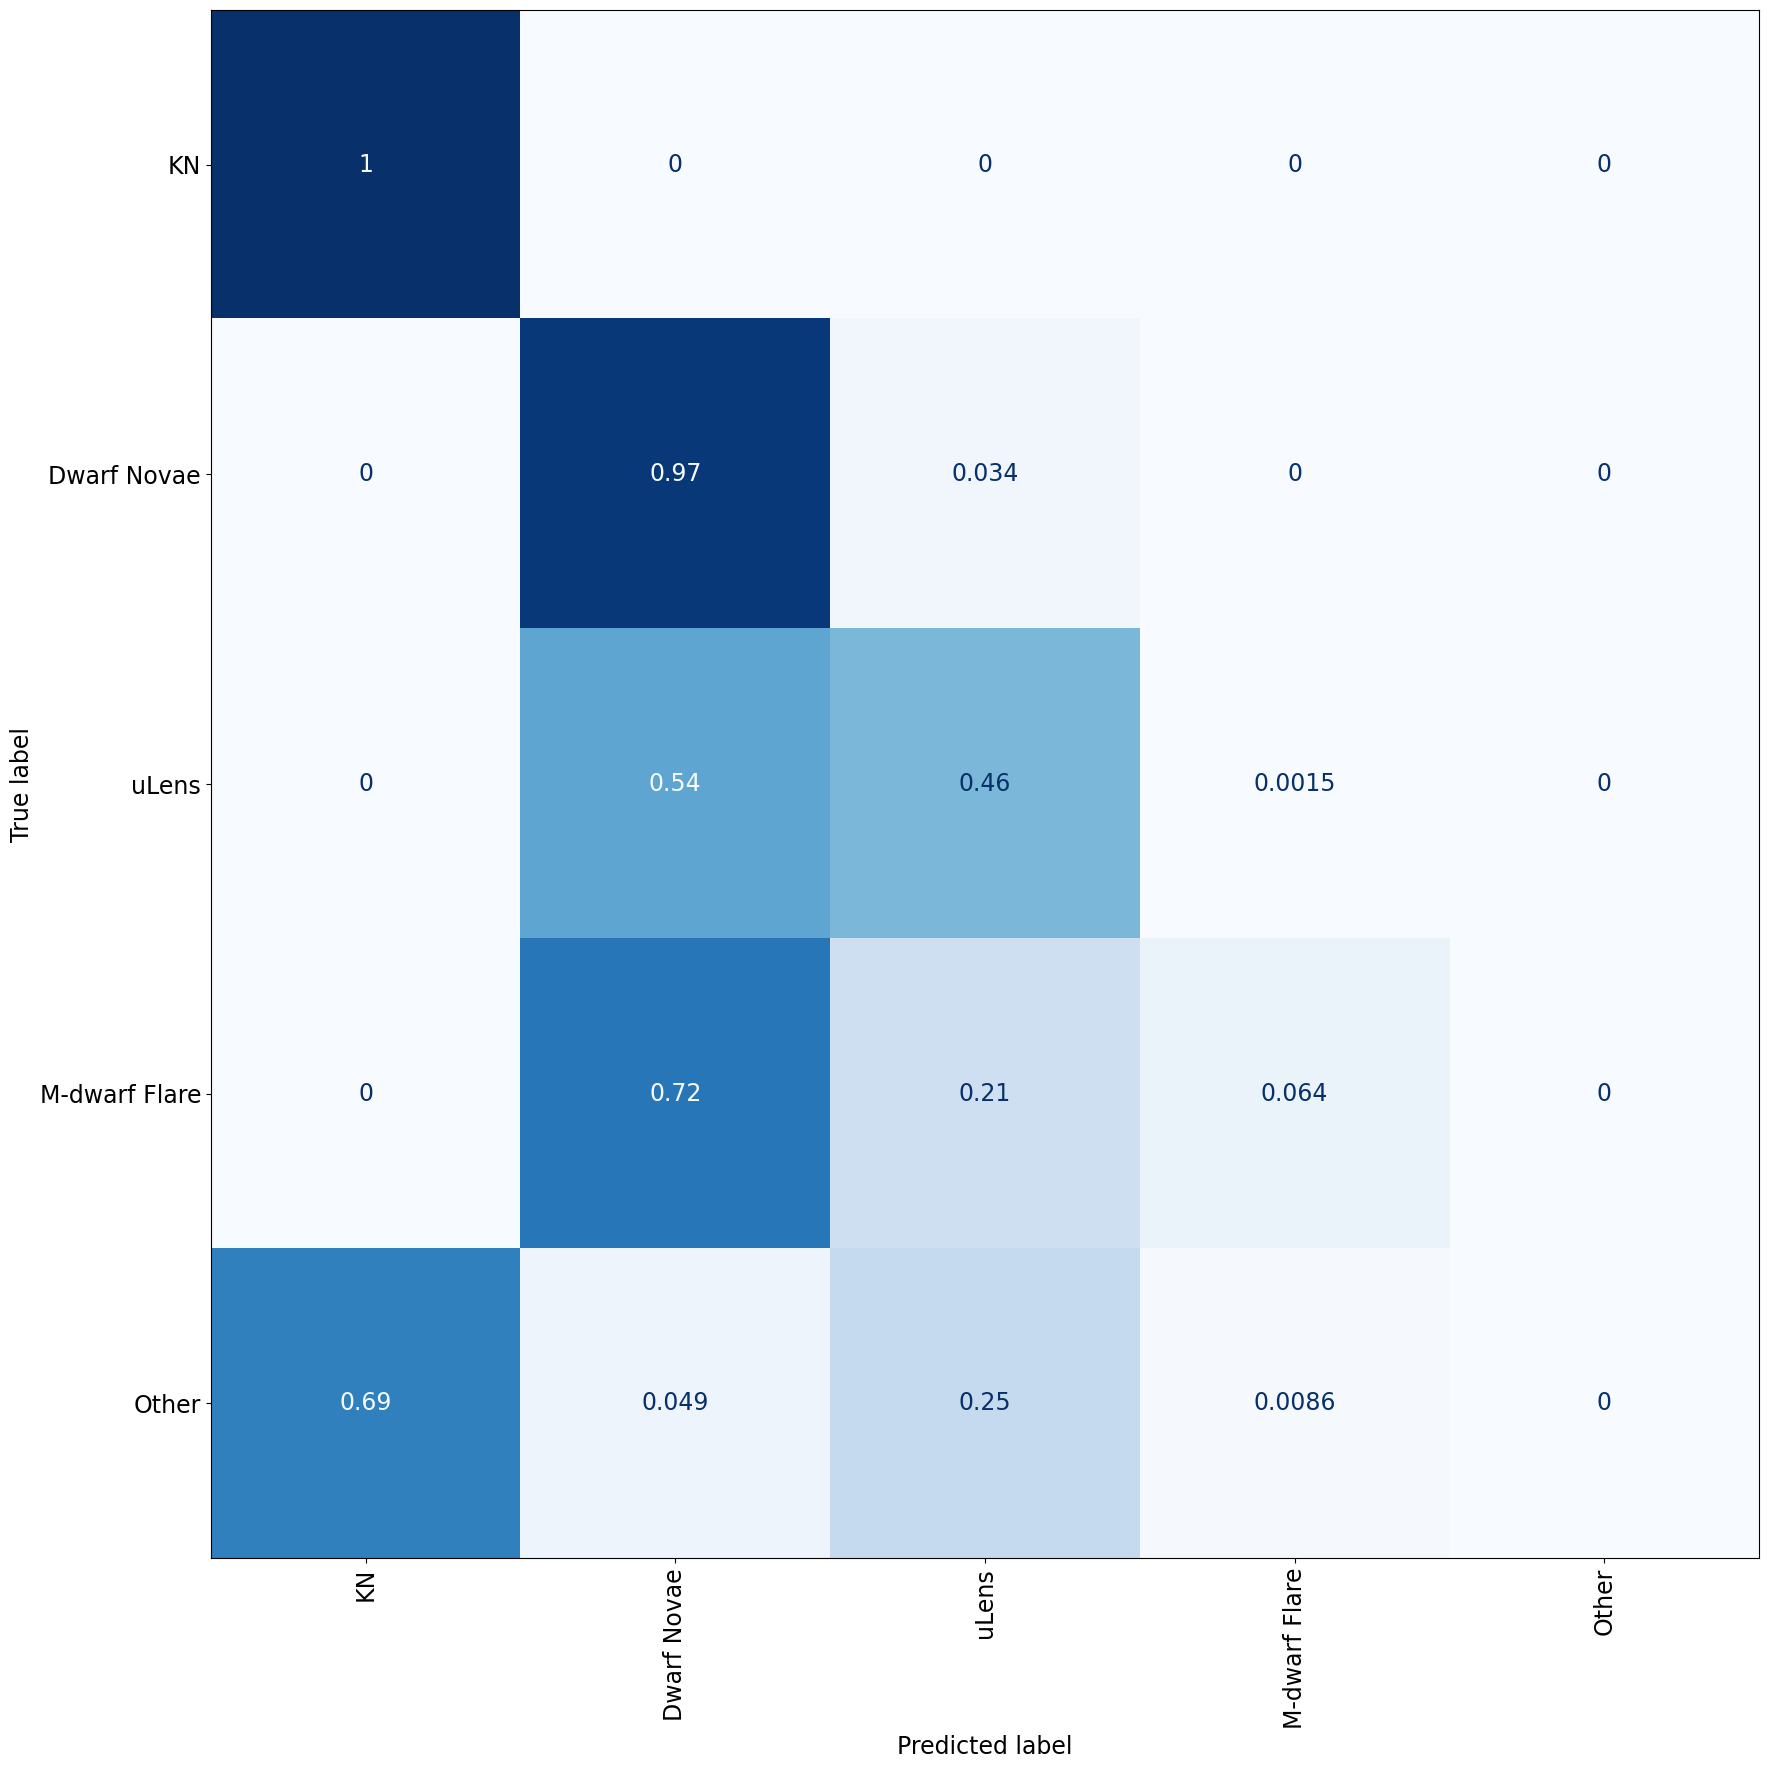

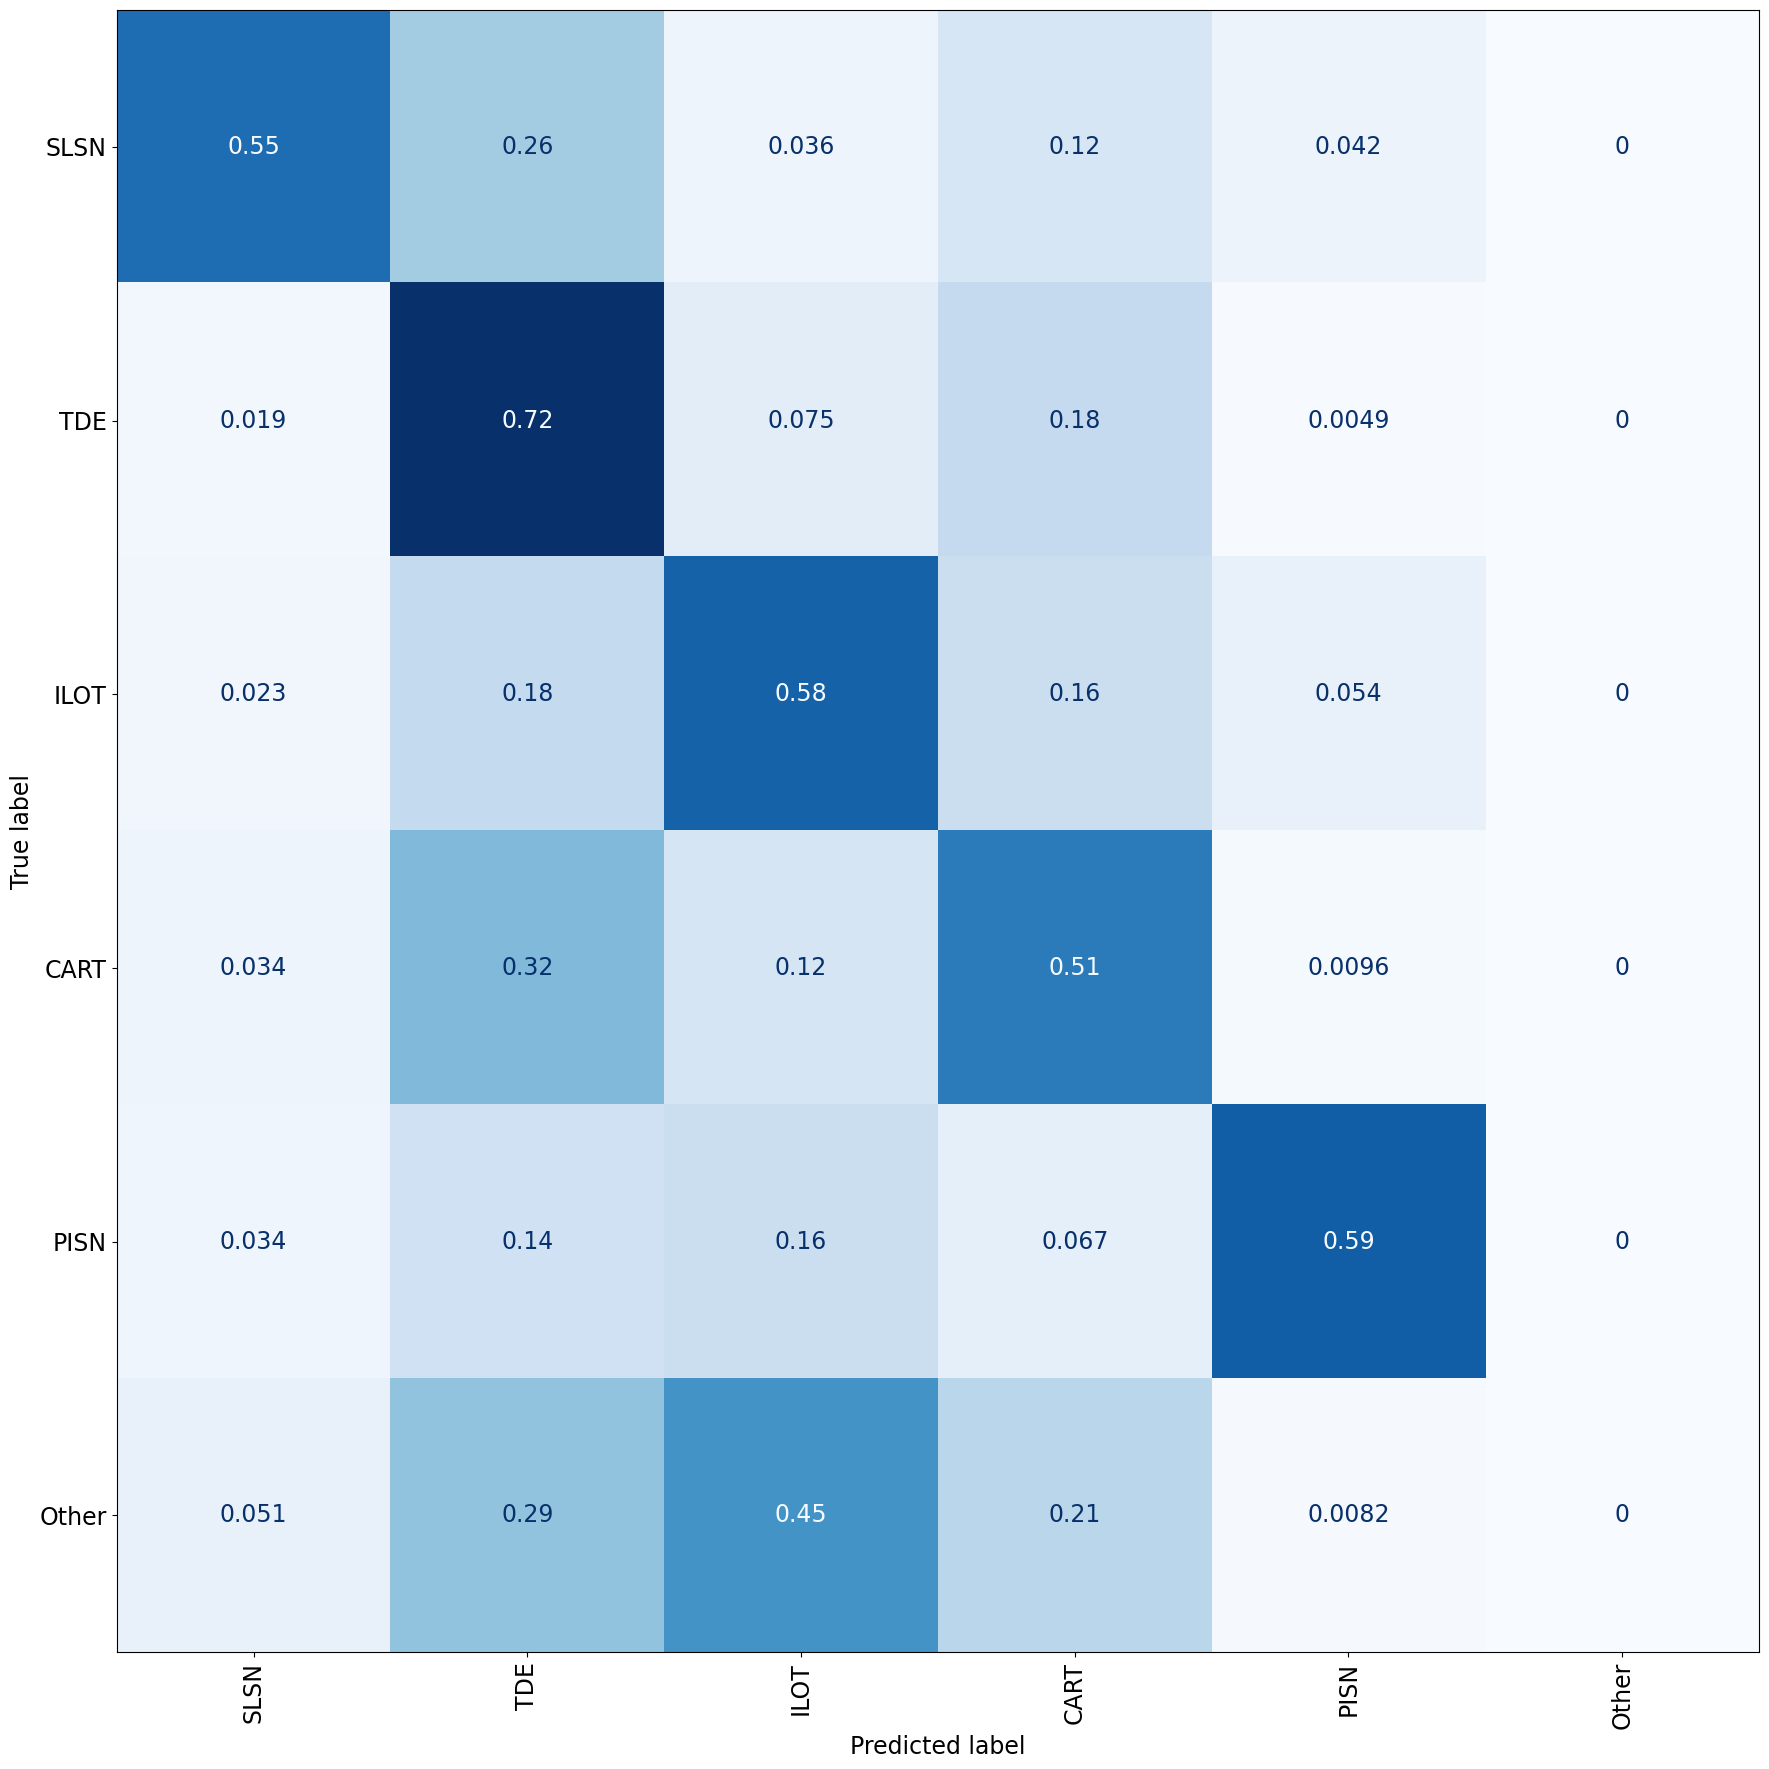

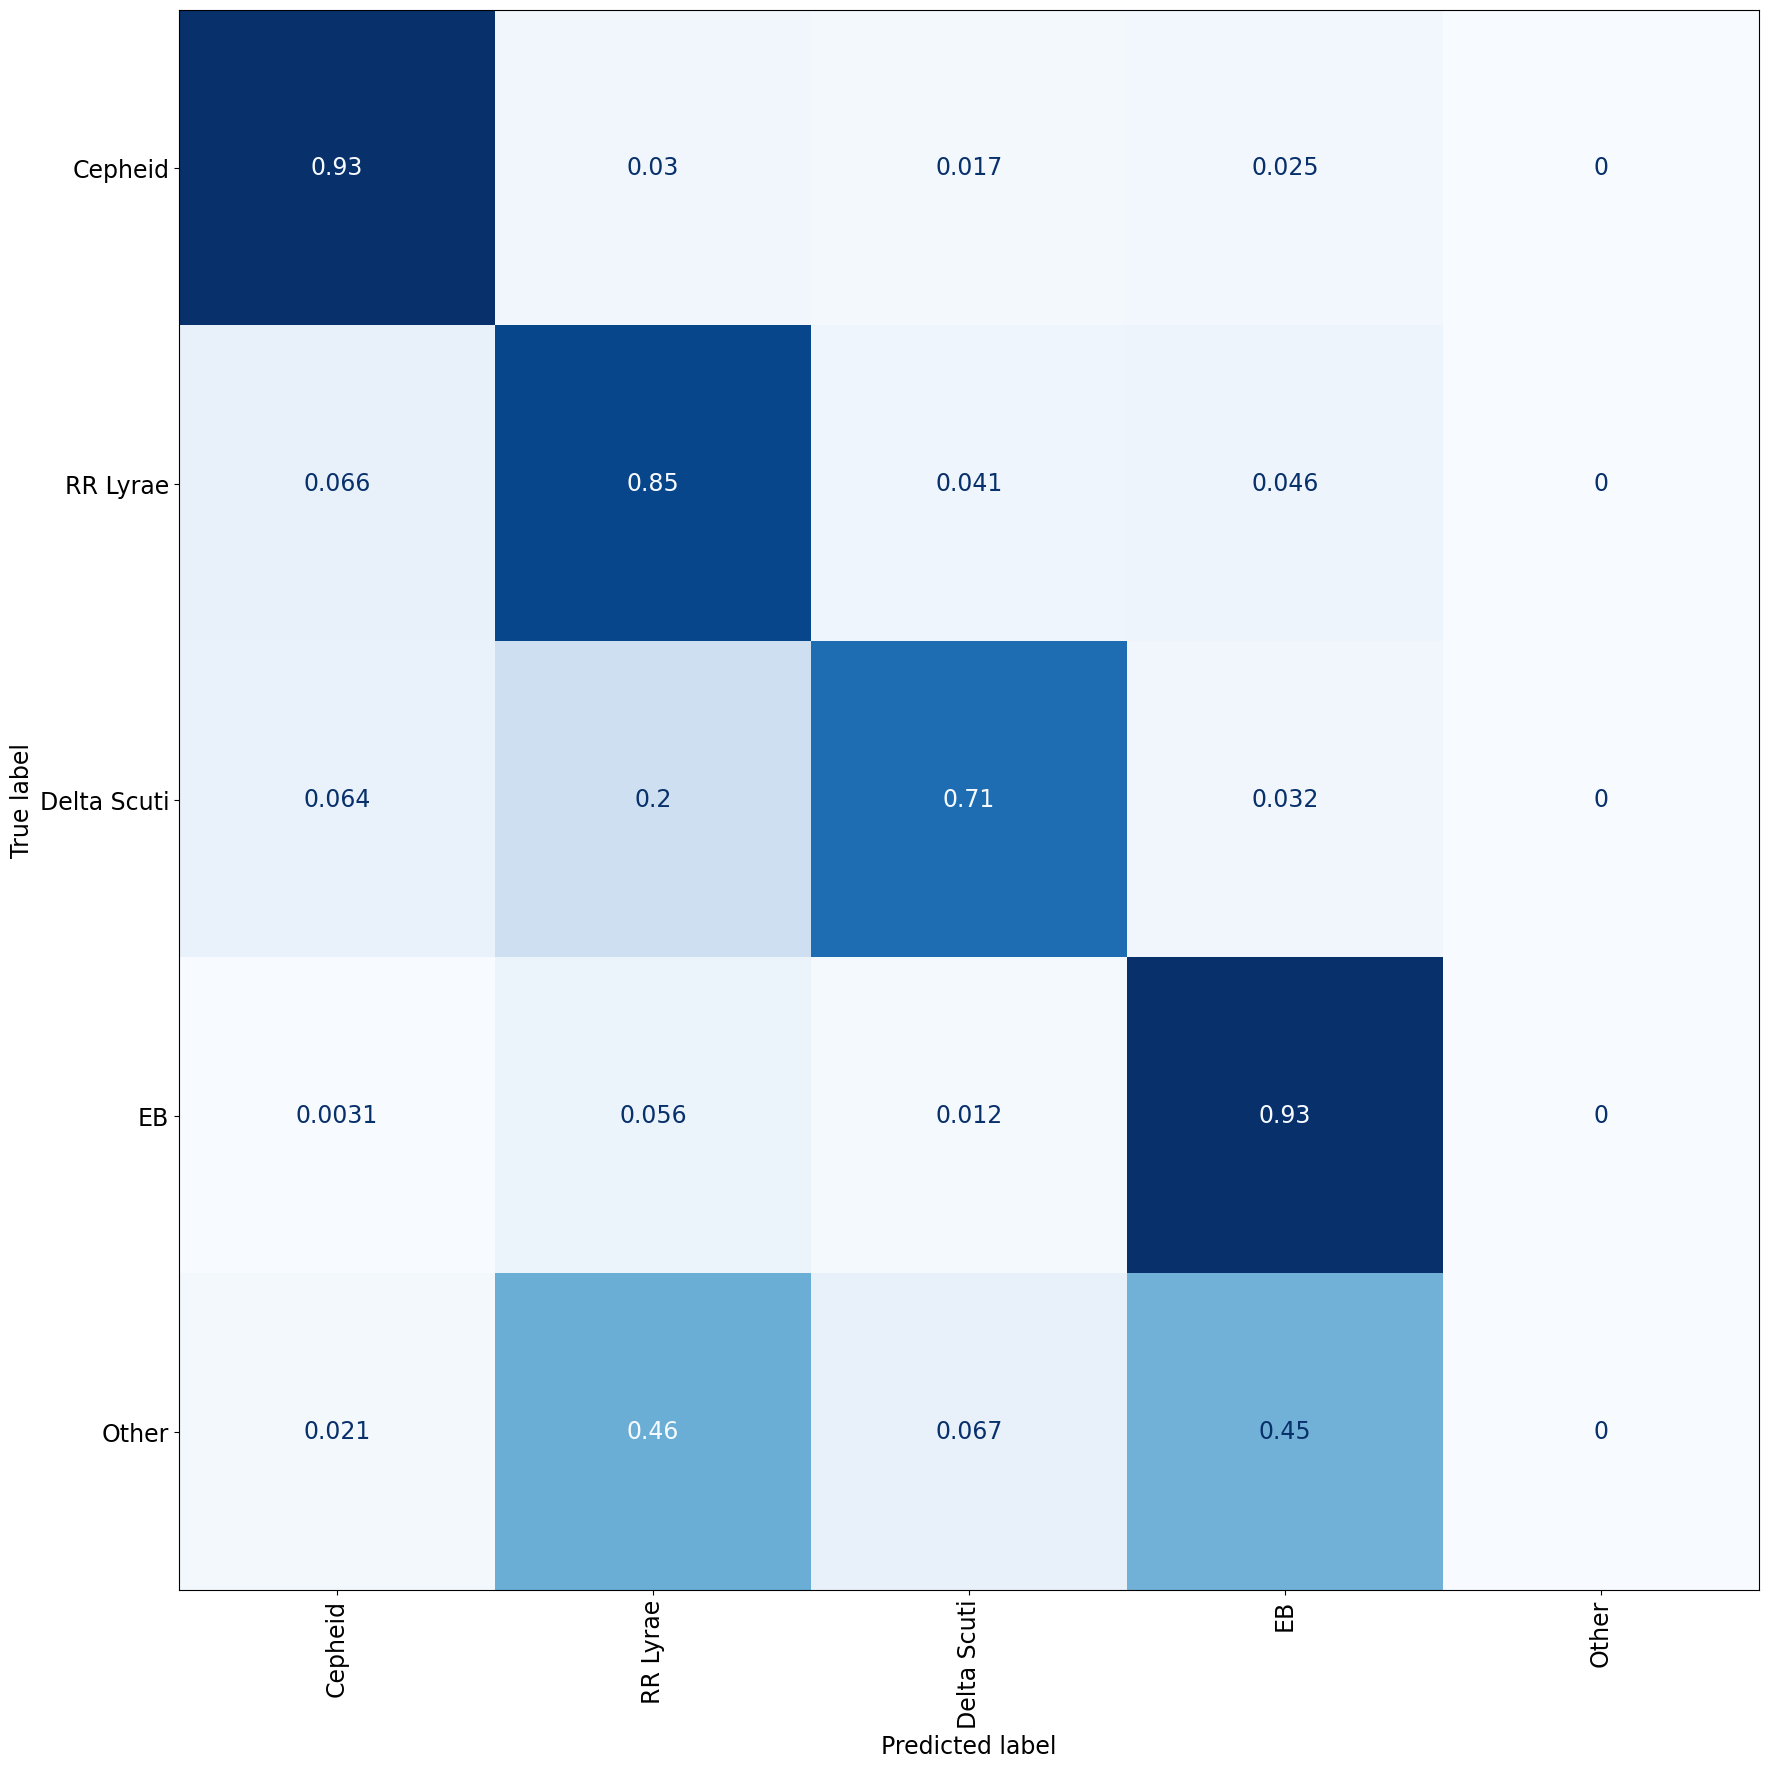

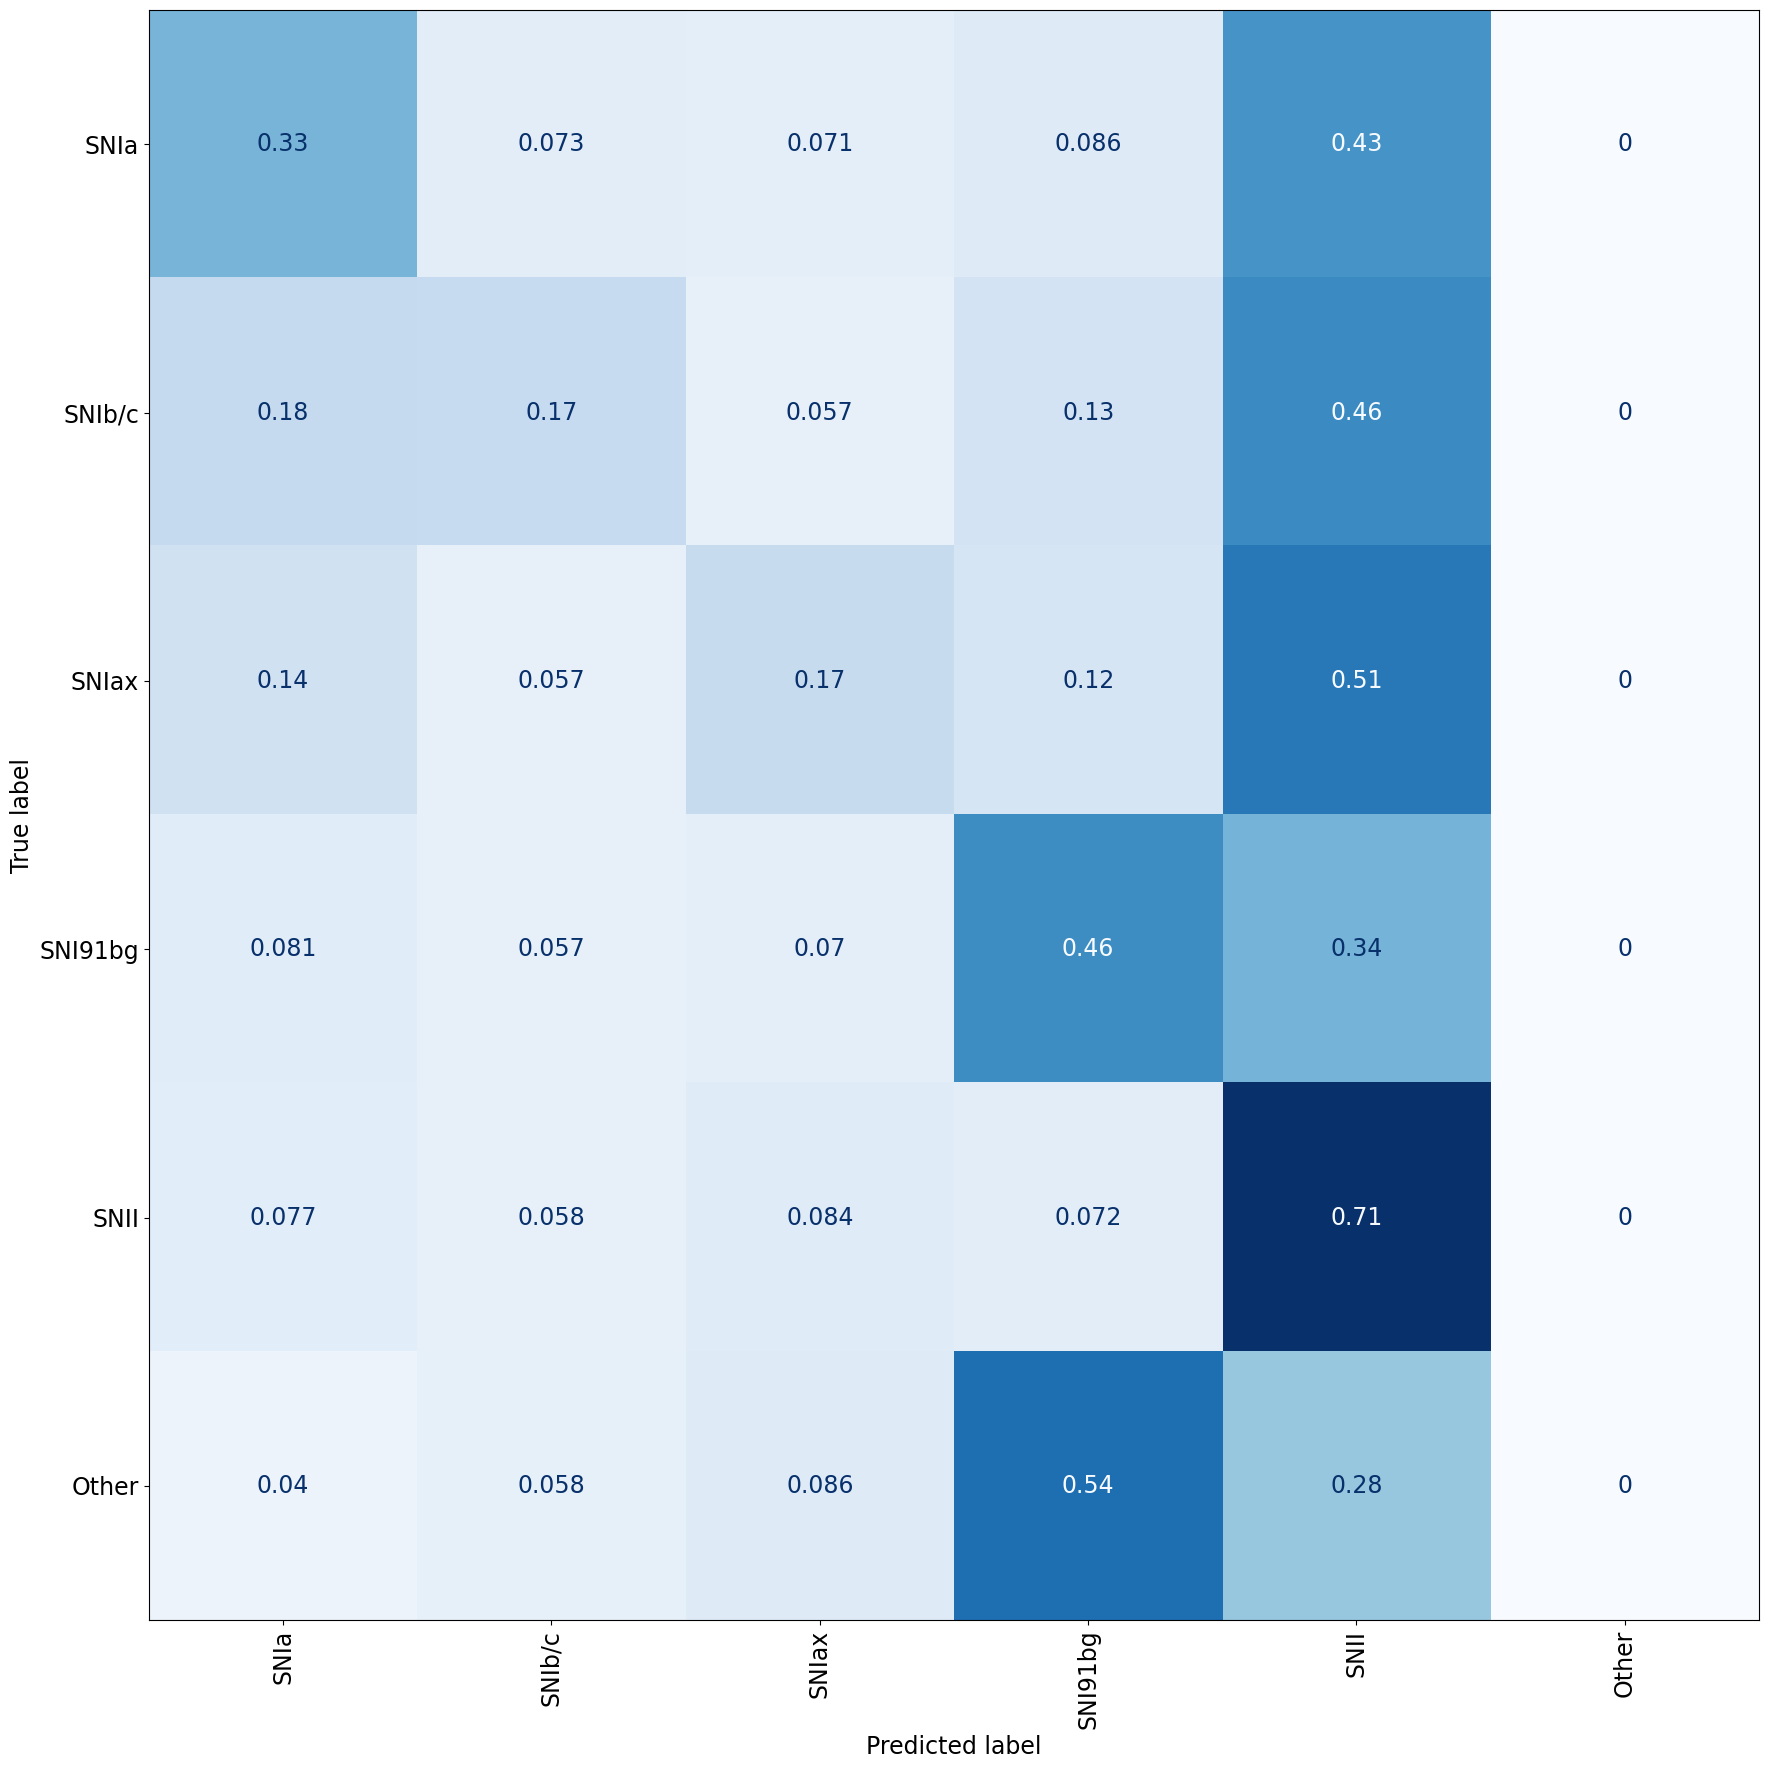

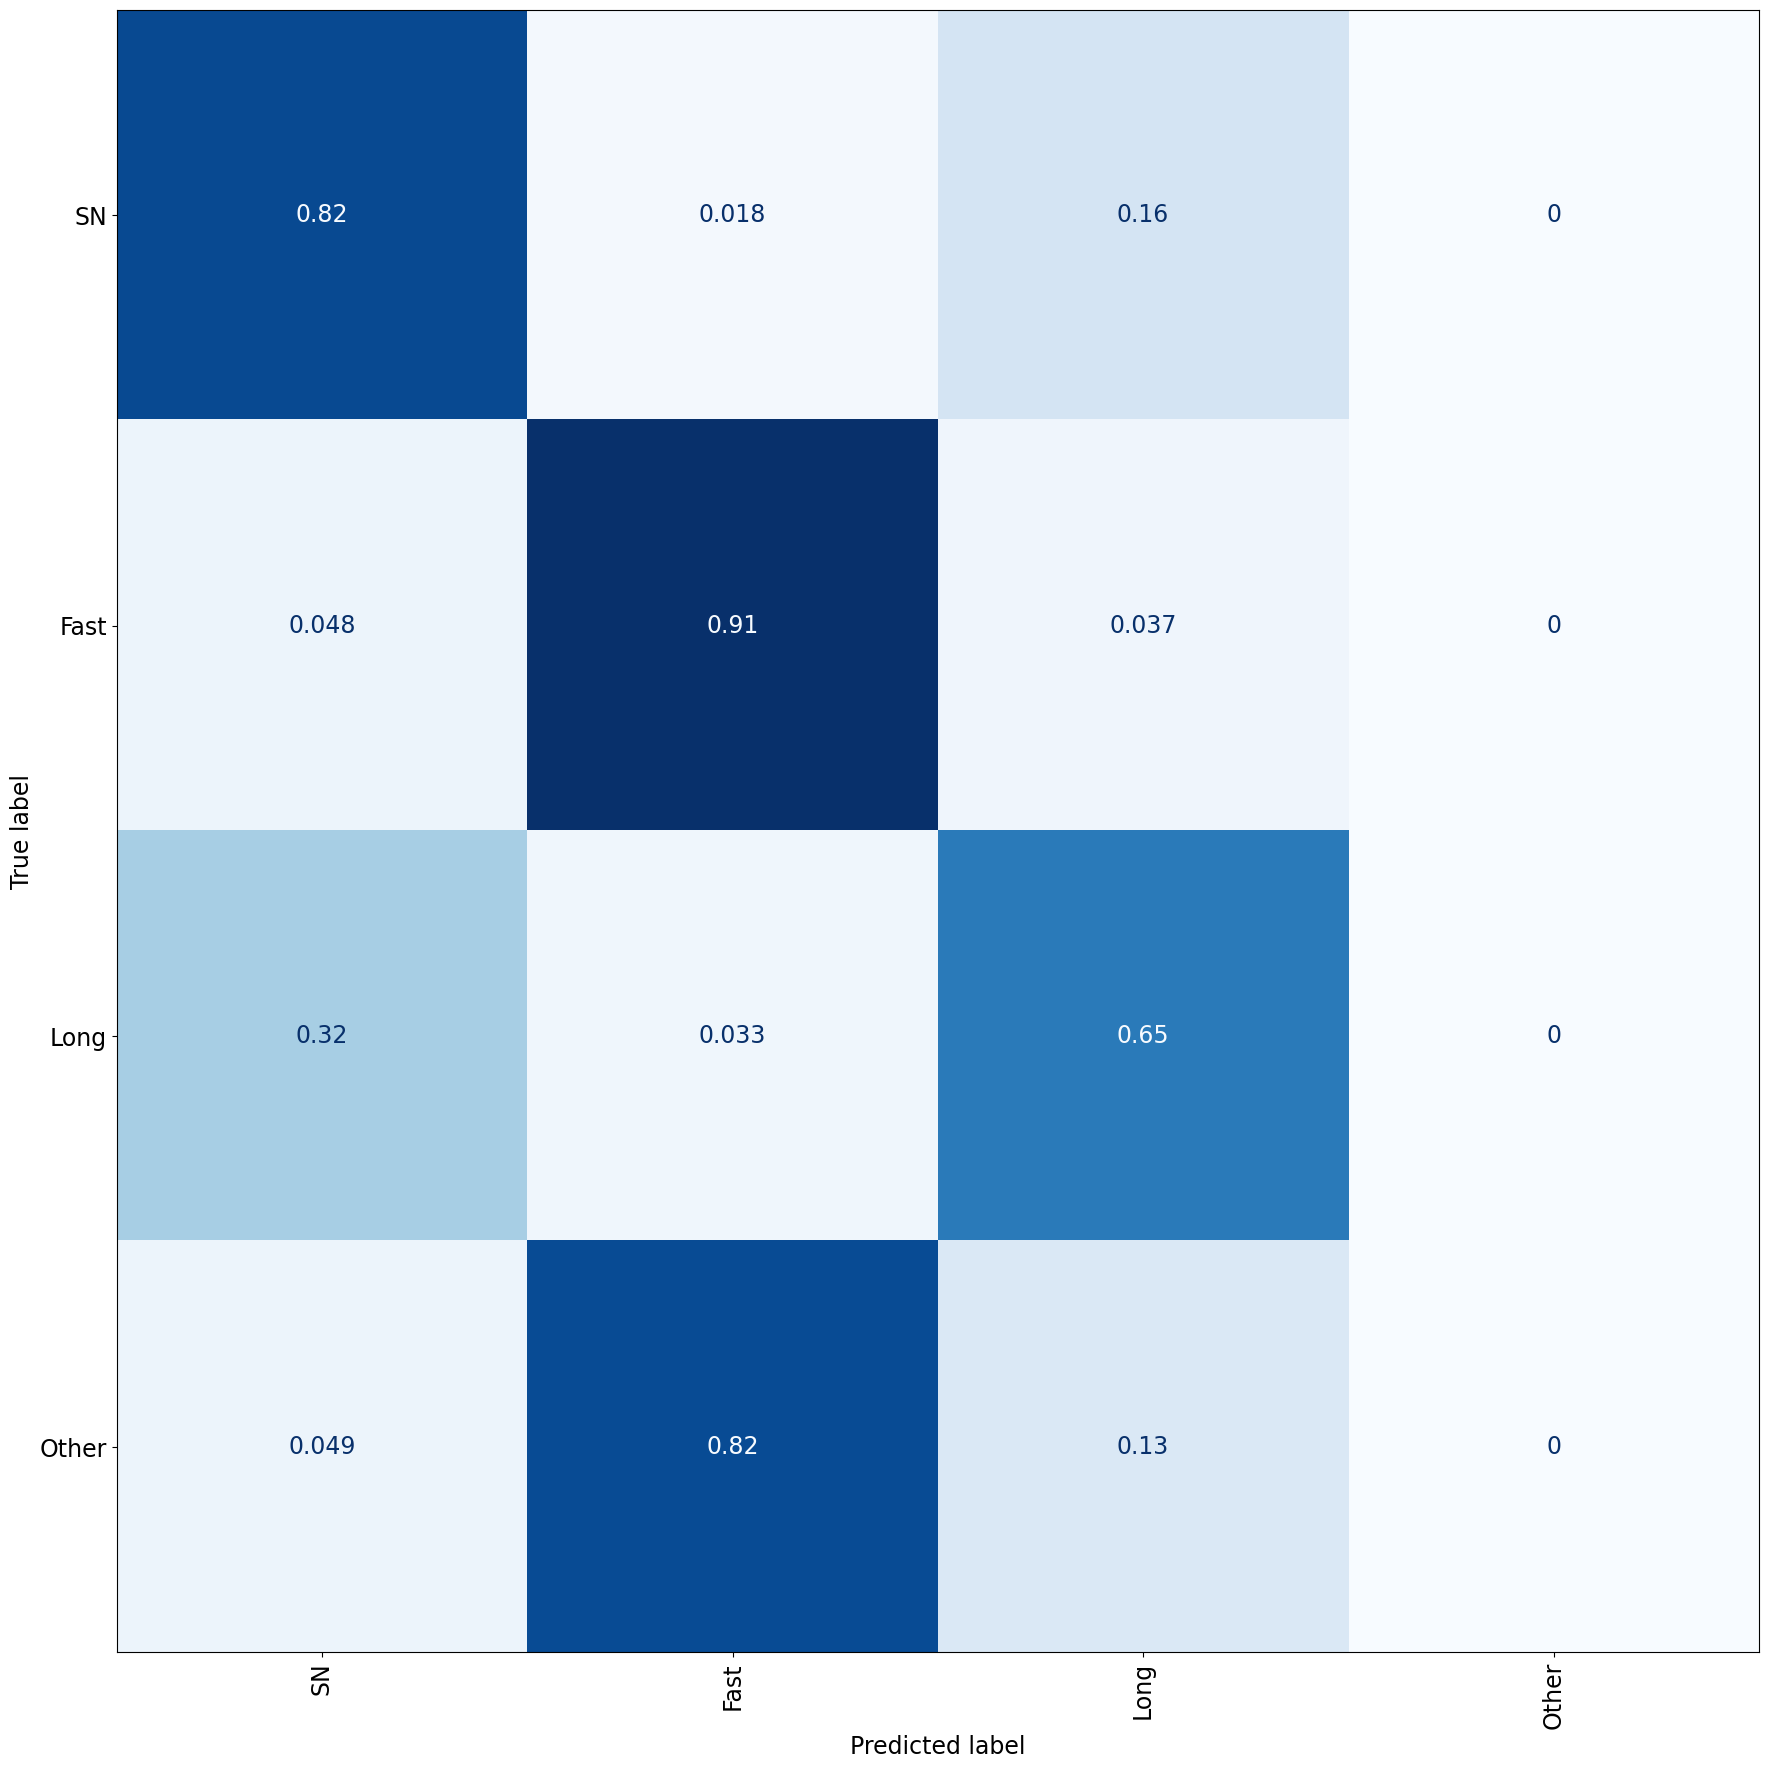

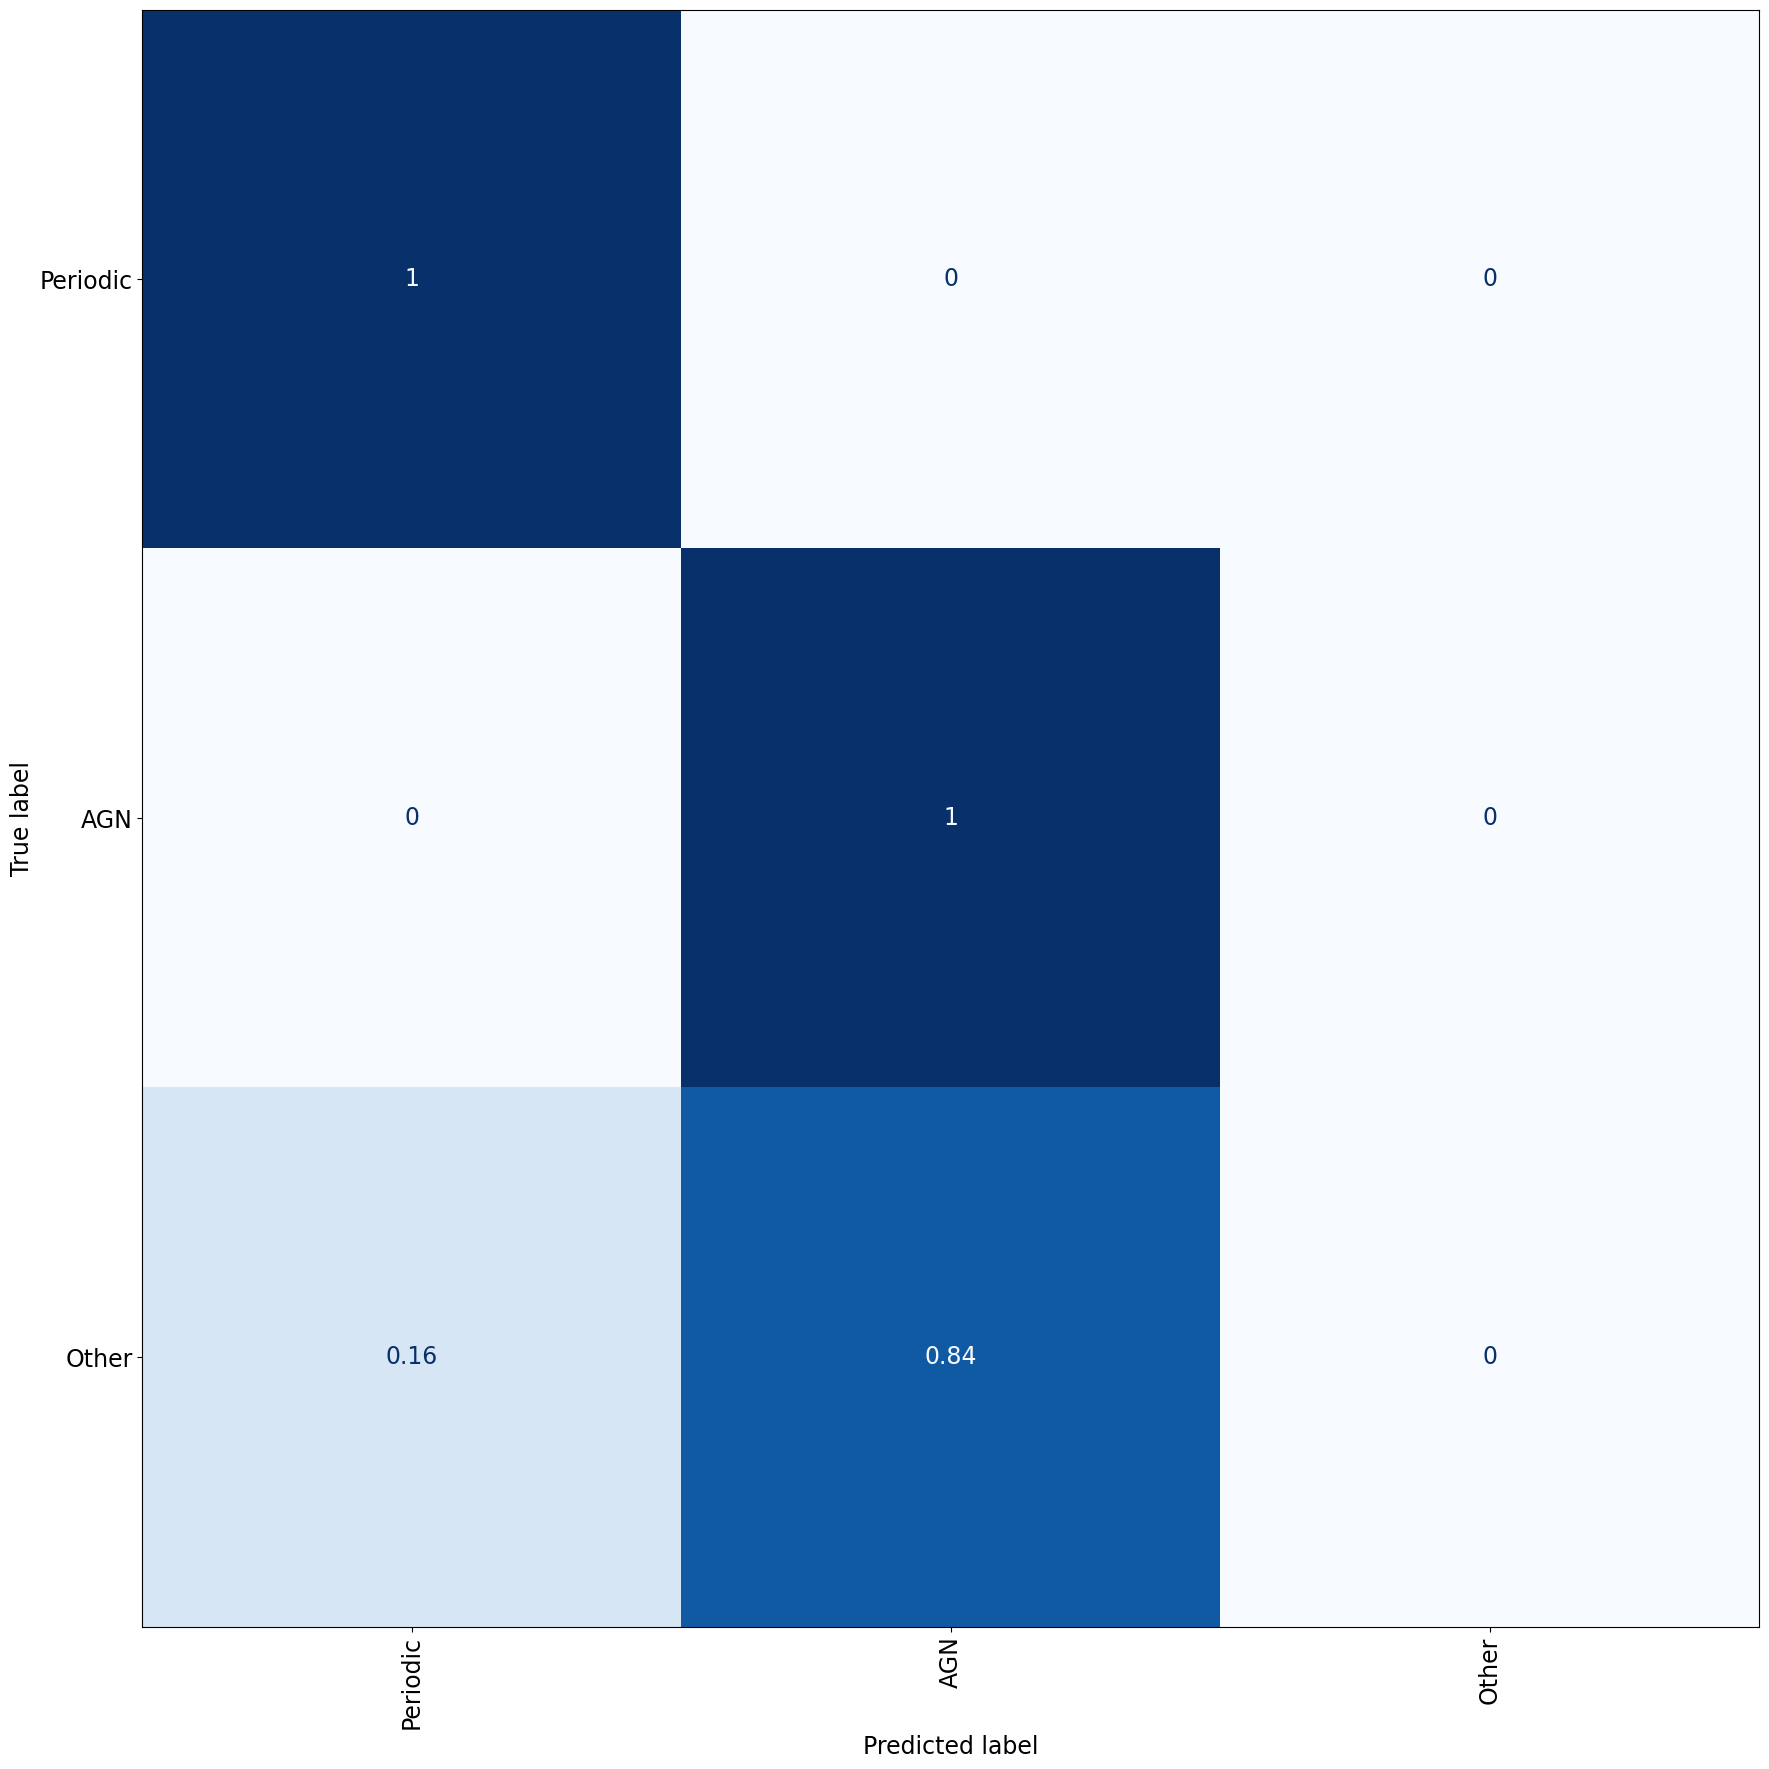

Running inference for 20% light curves...
332/332 [==============================] - 1s 4ms/step
For 20% of the light curve, these are the statistics


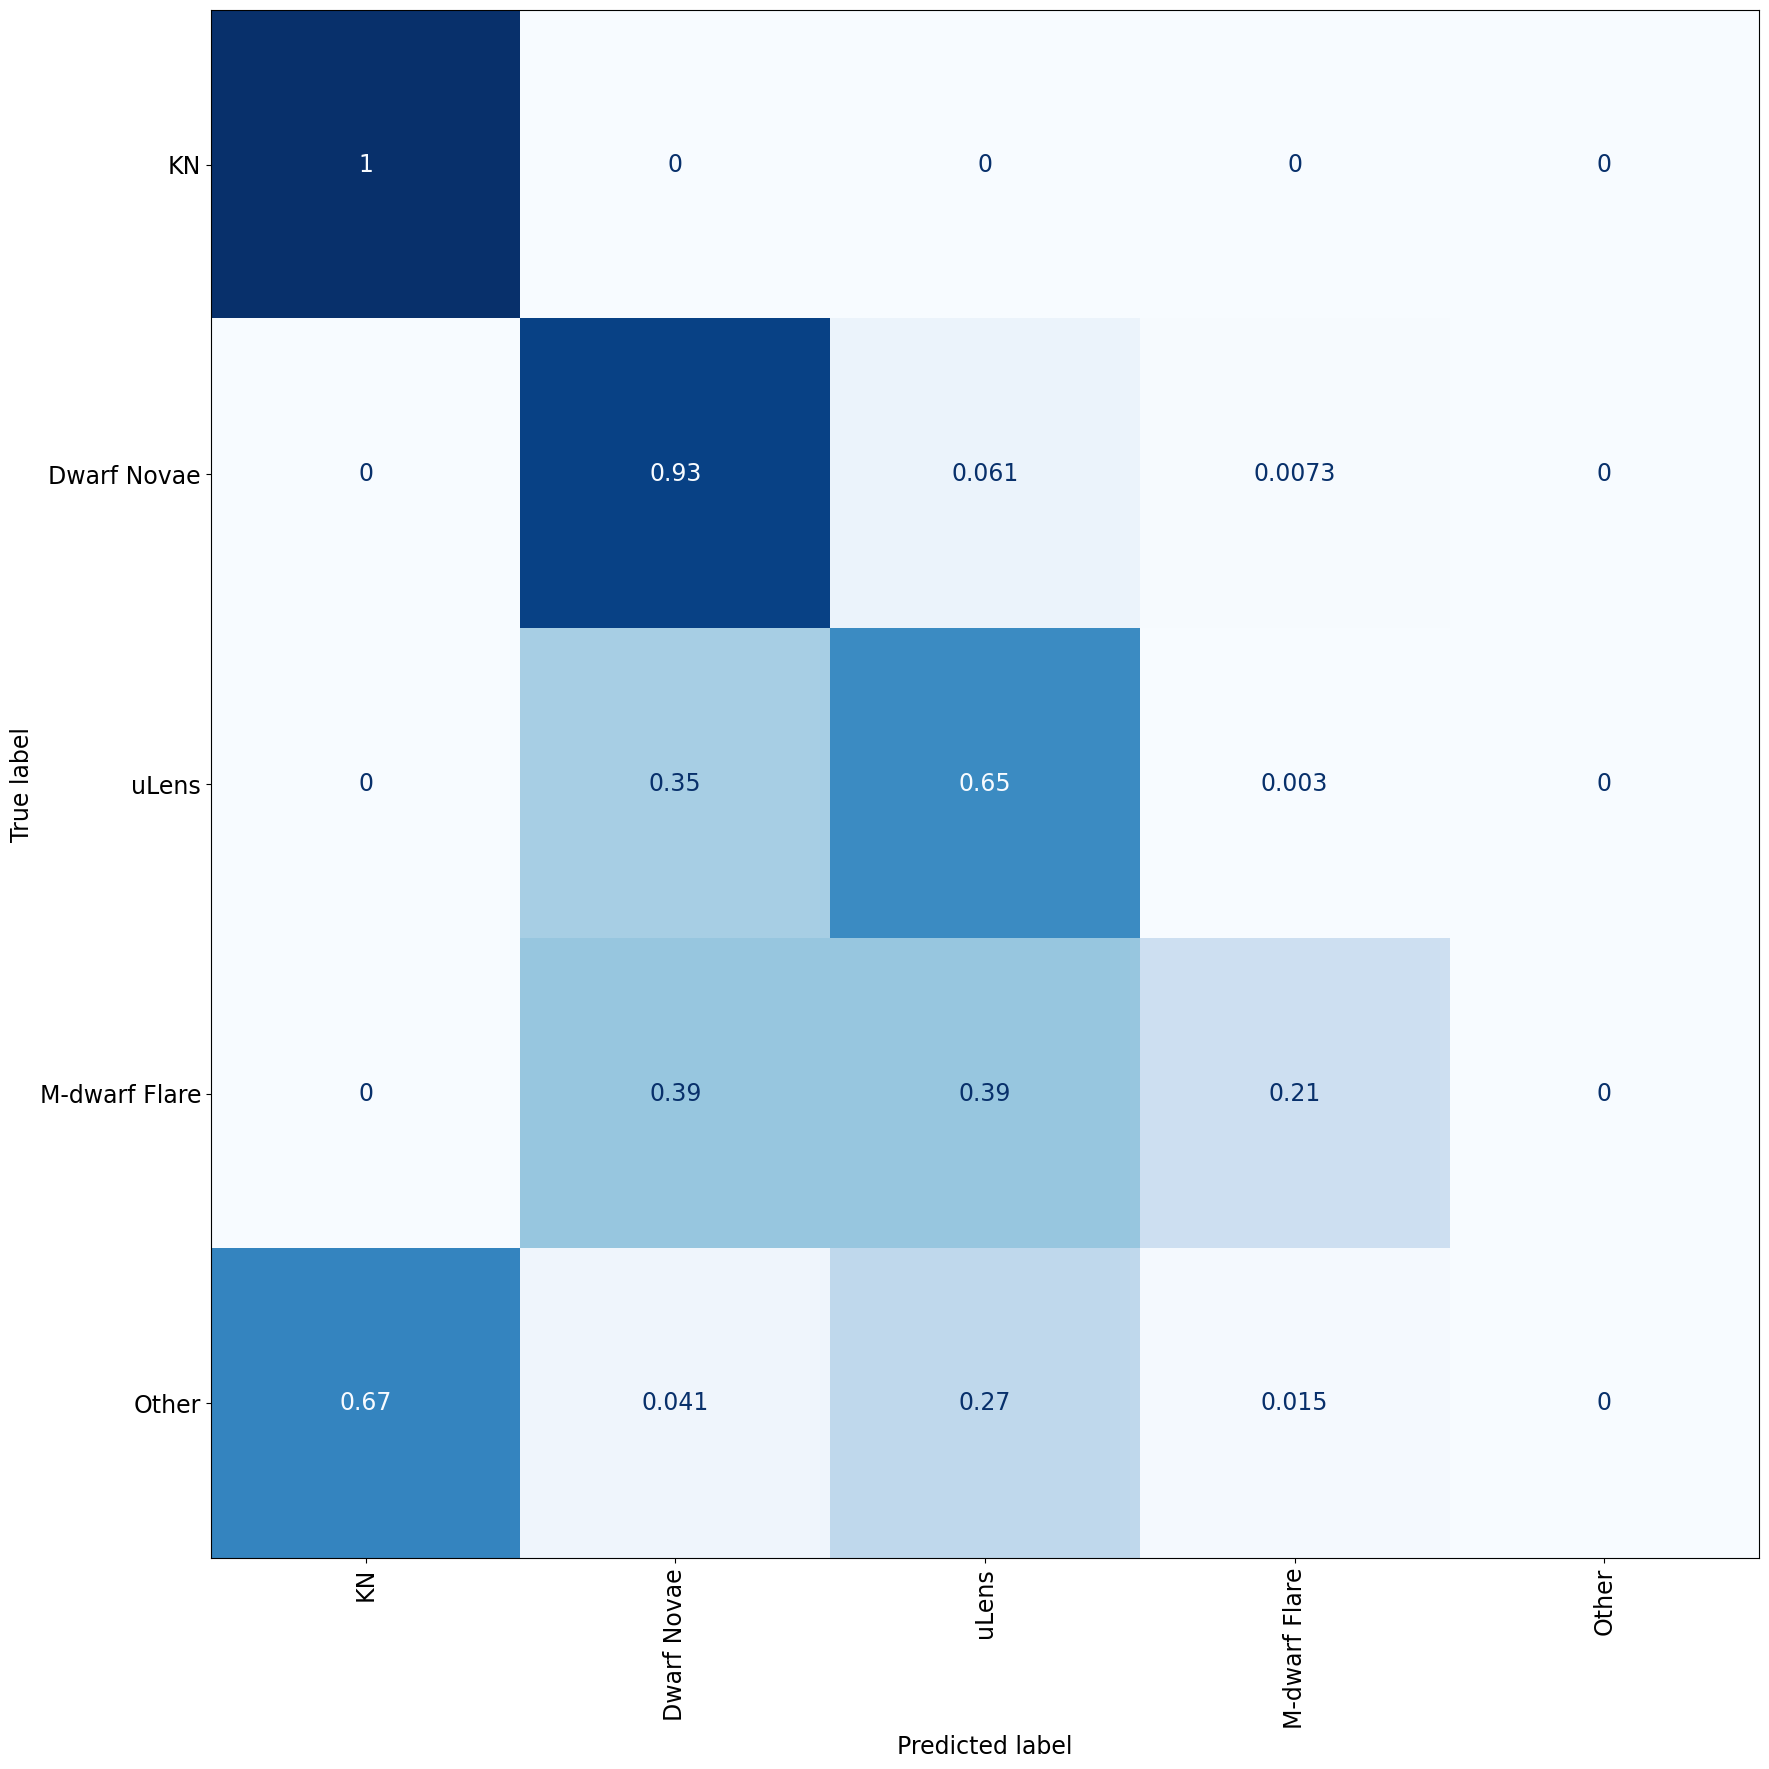

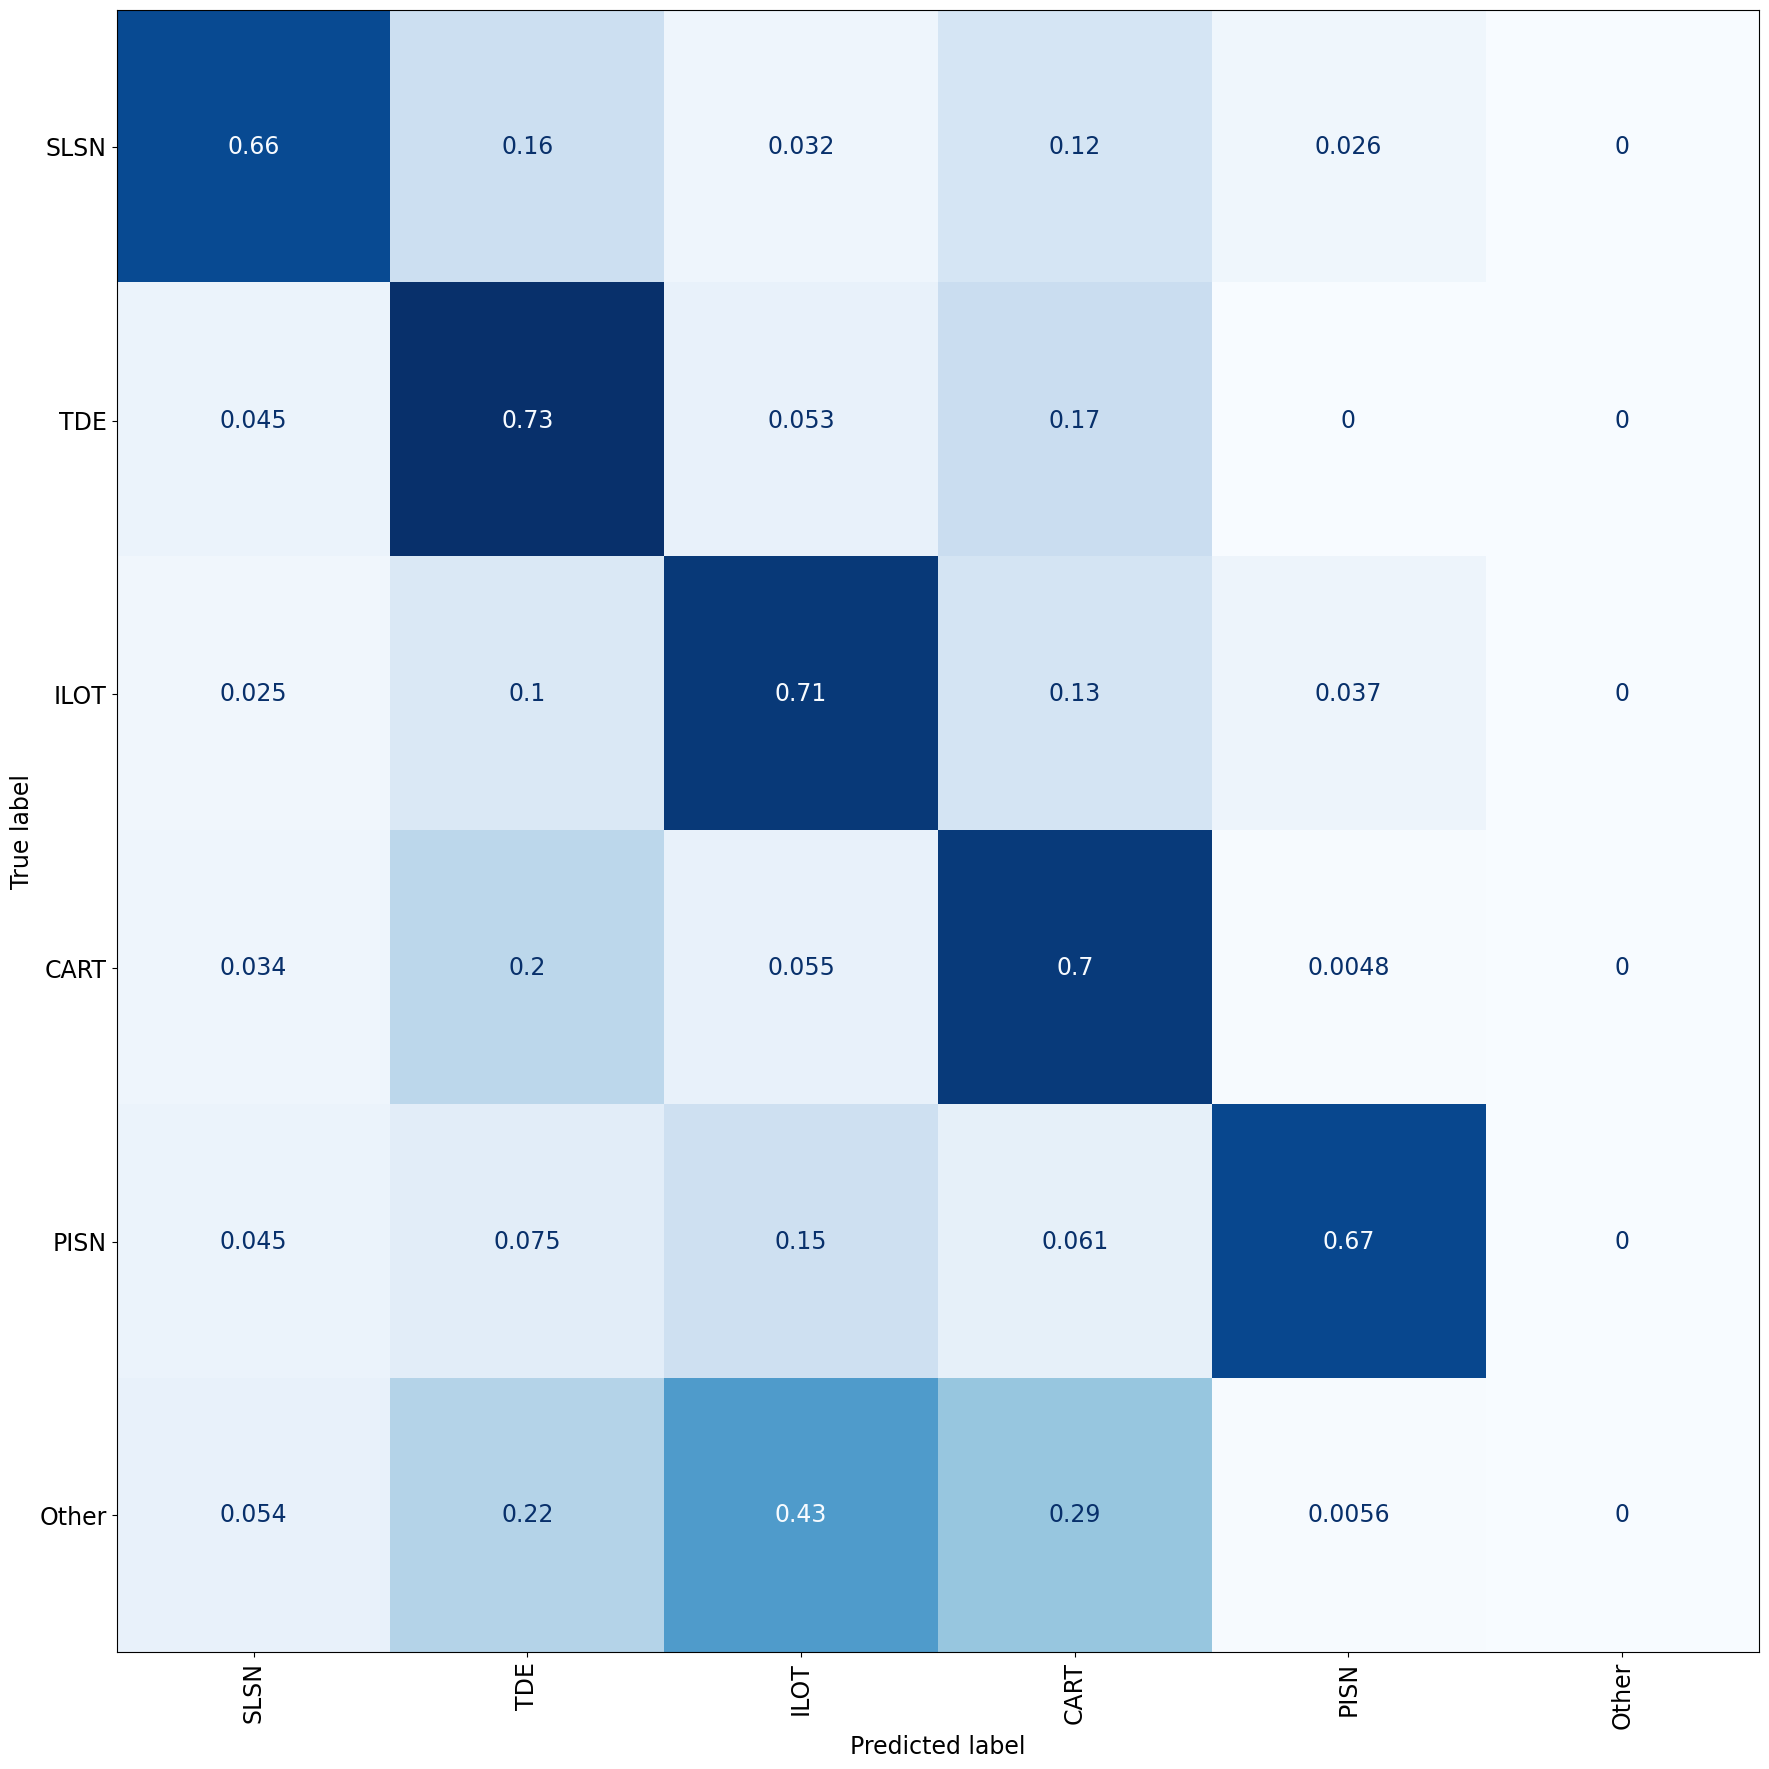

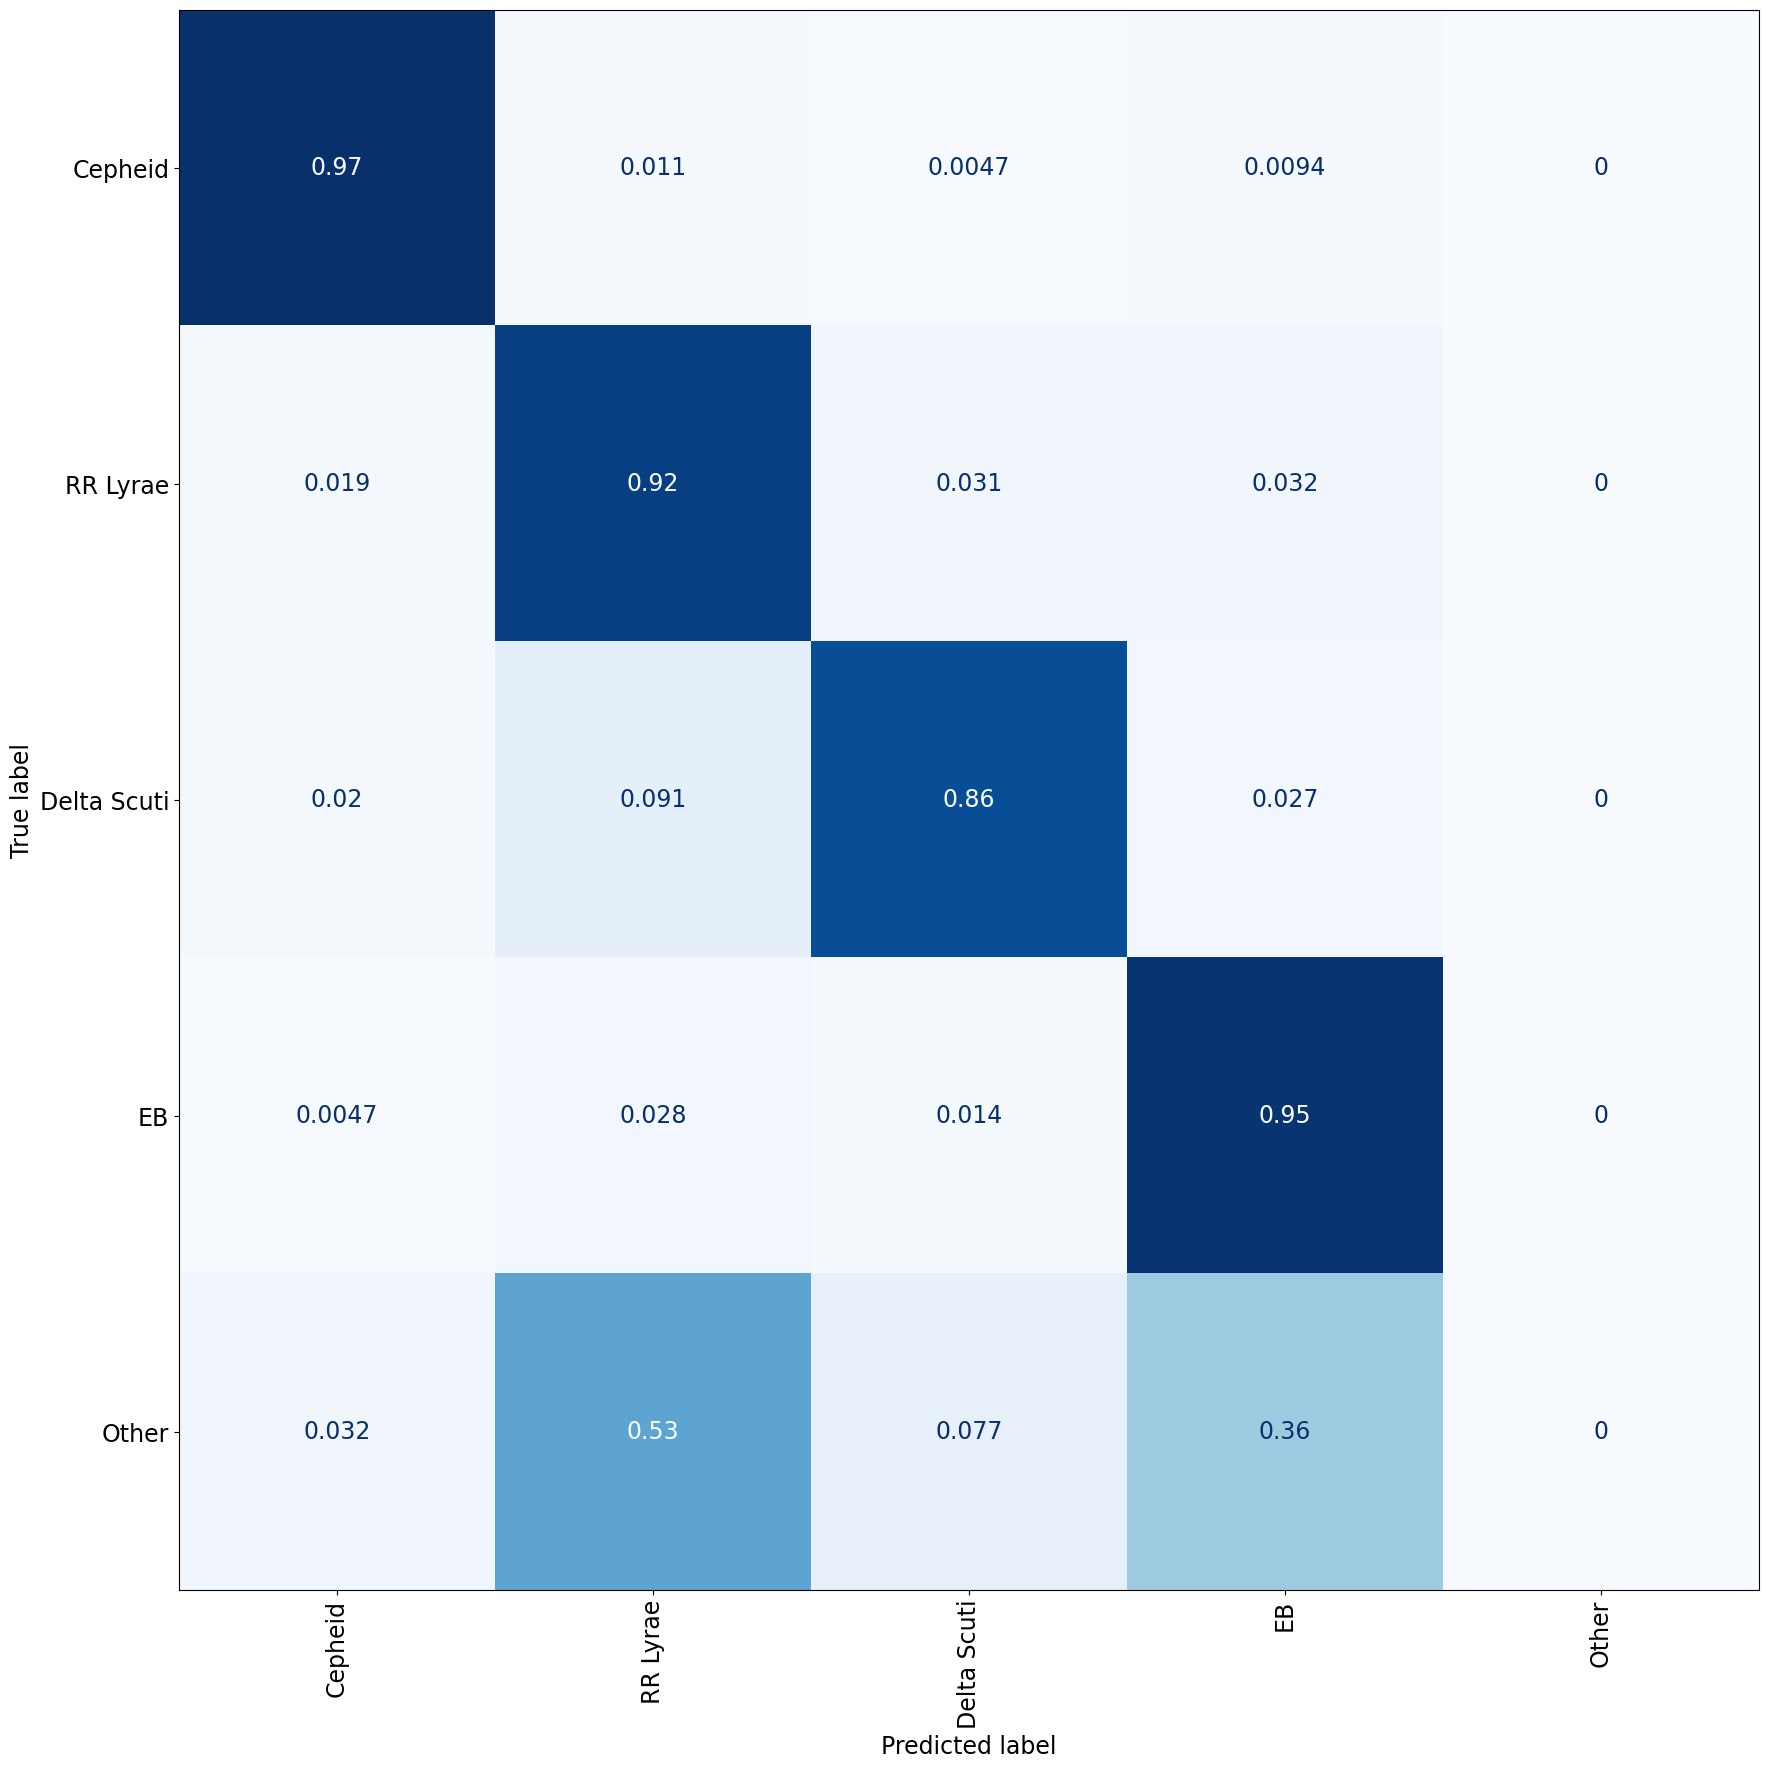

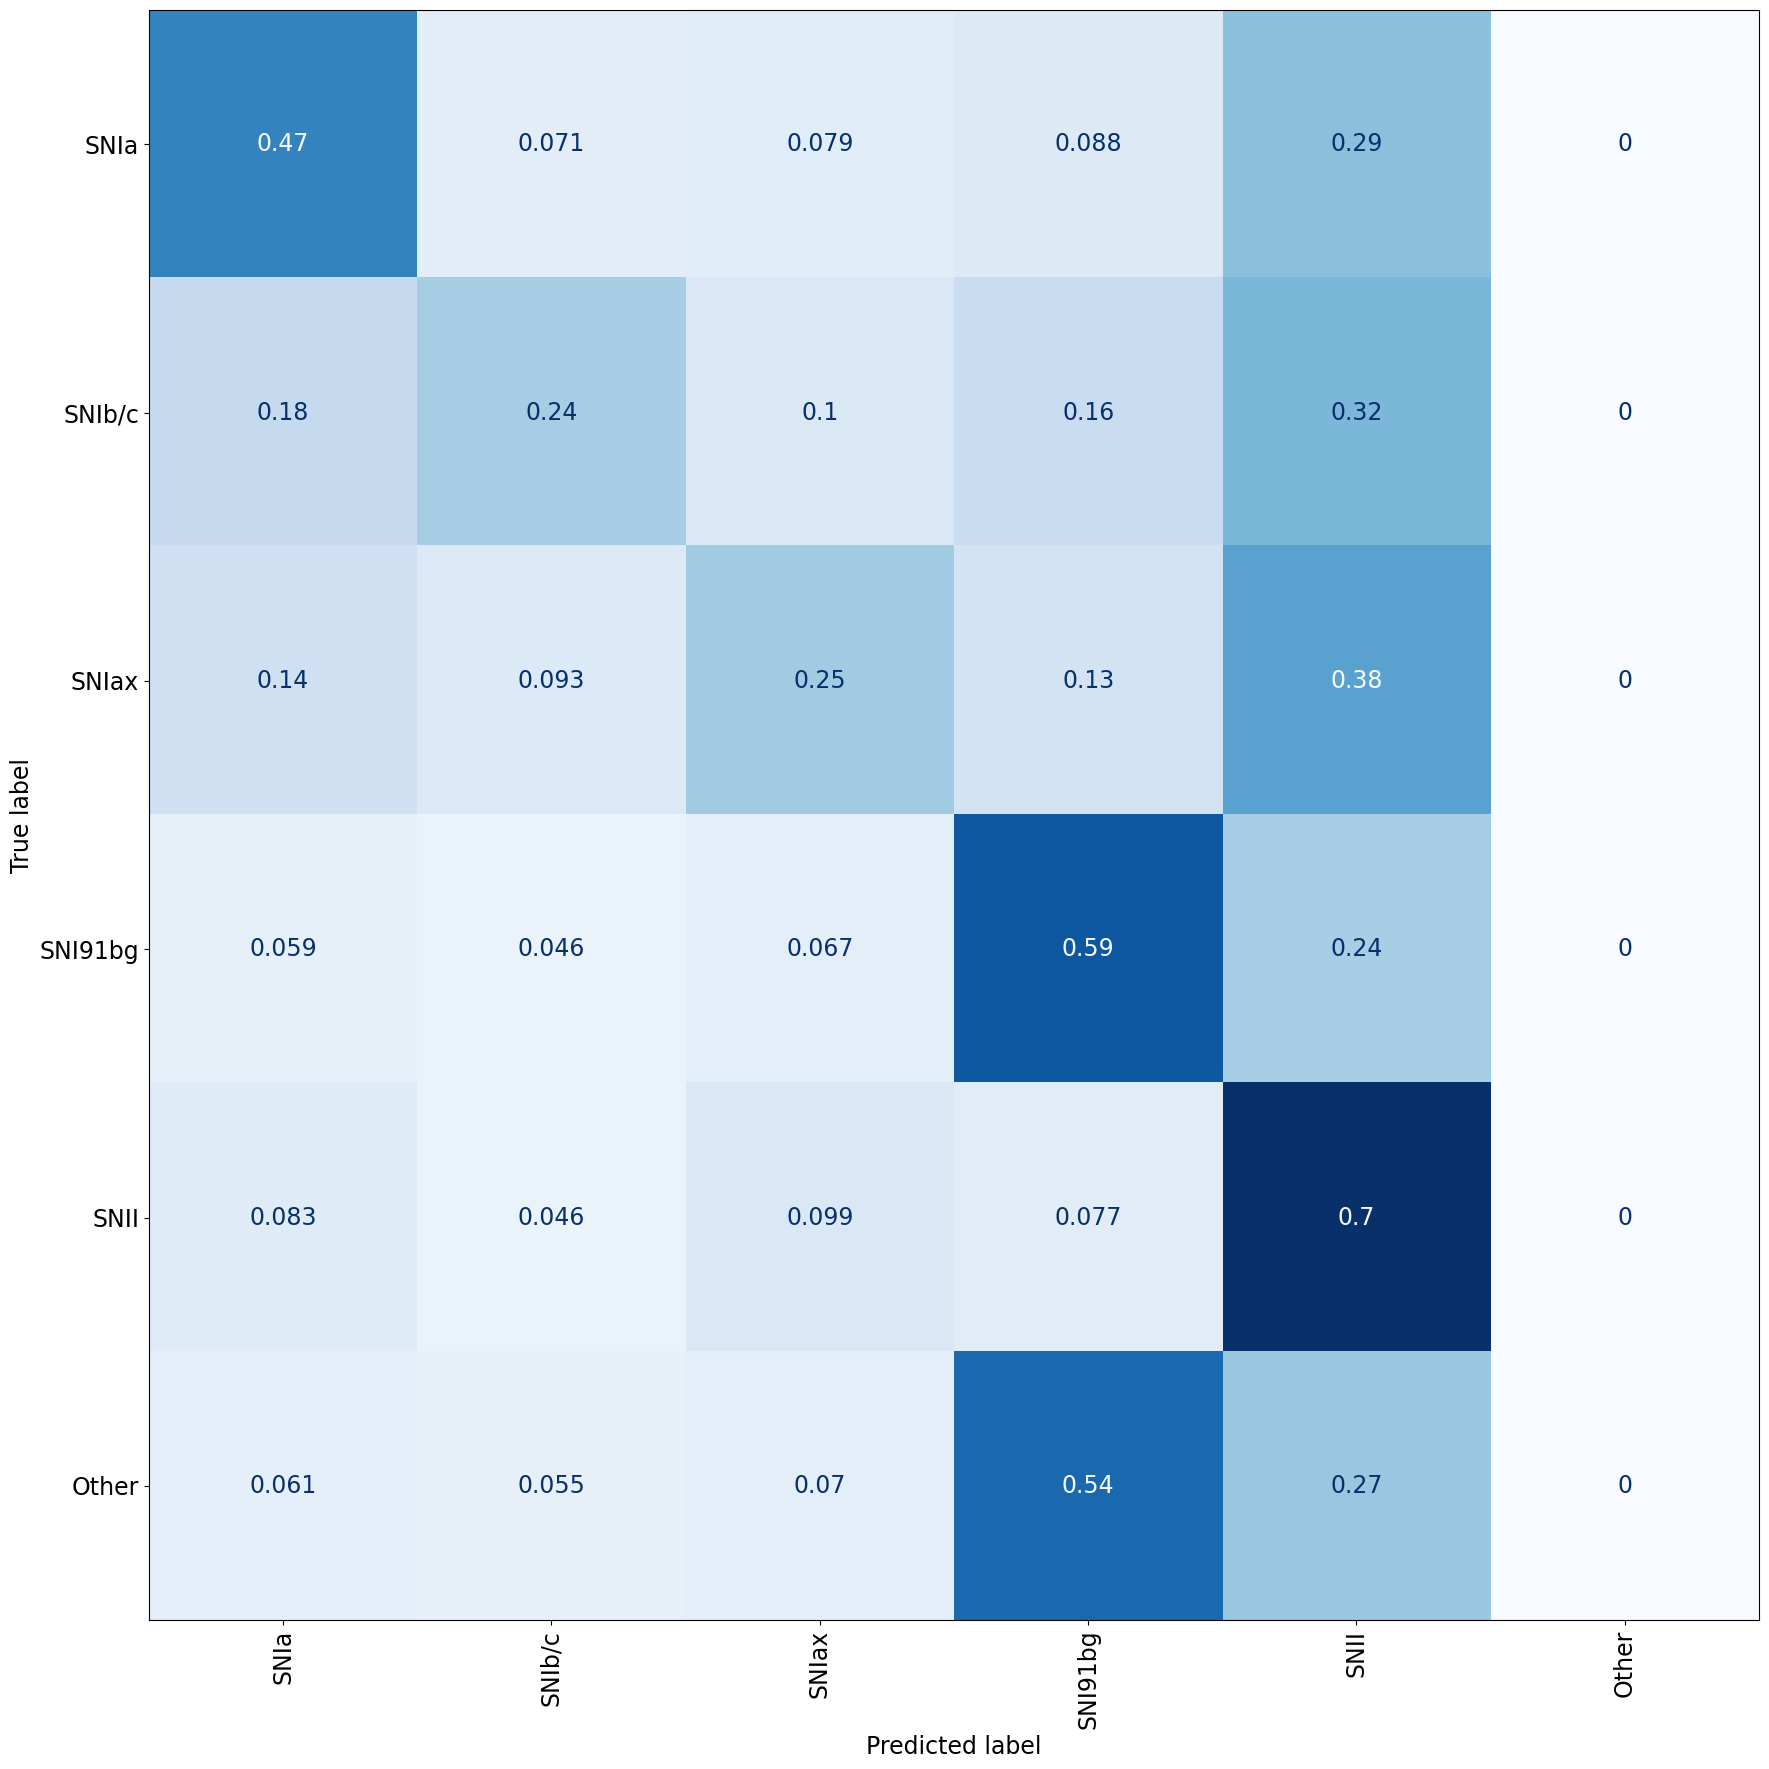

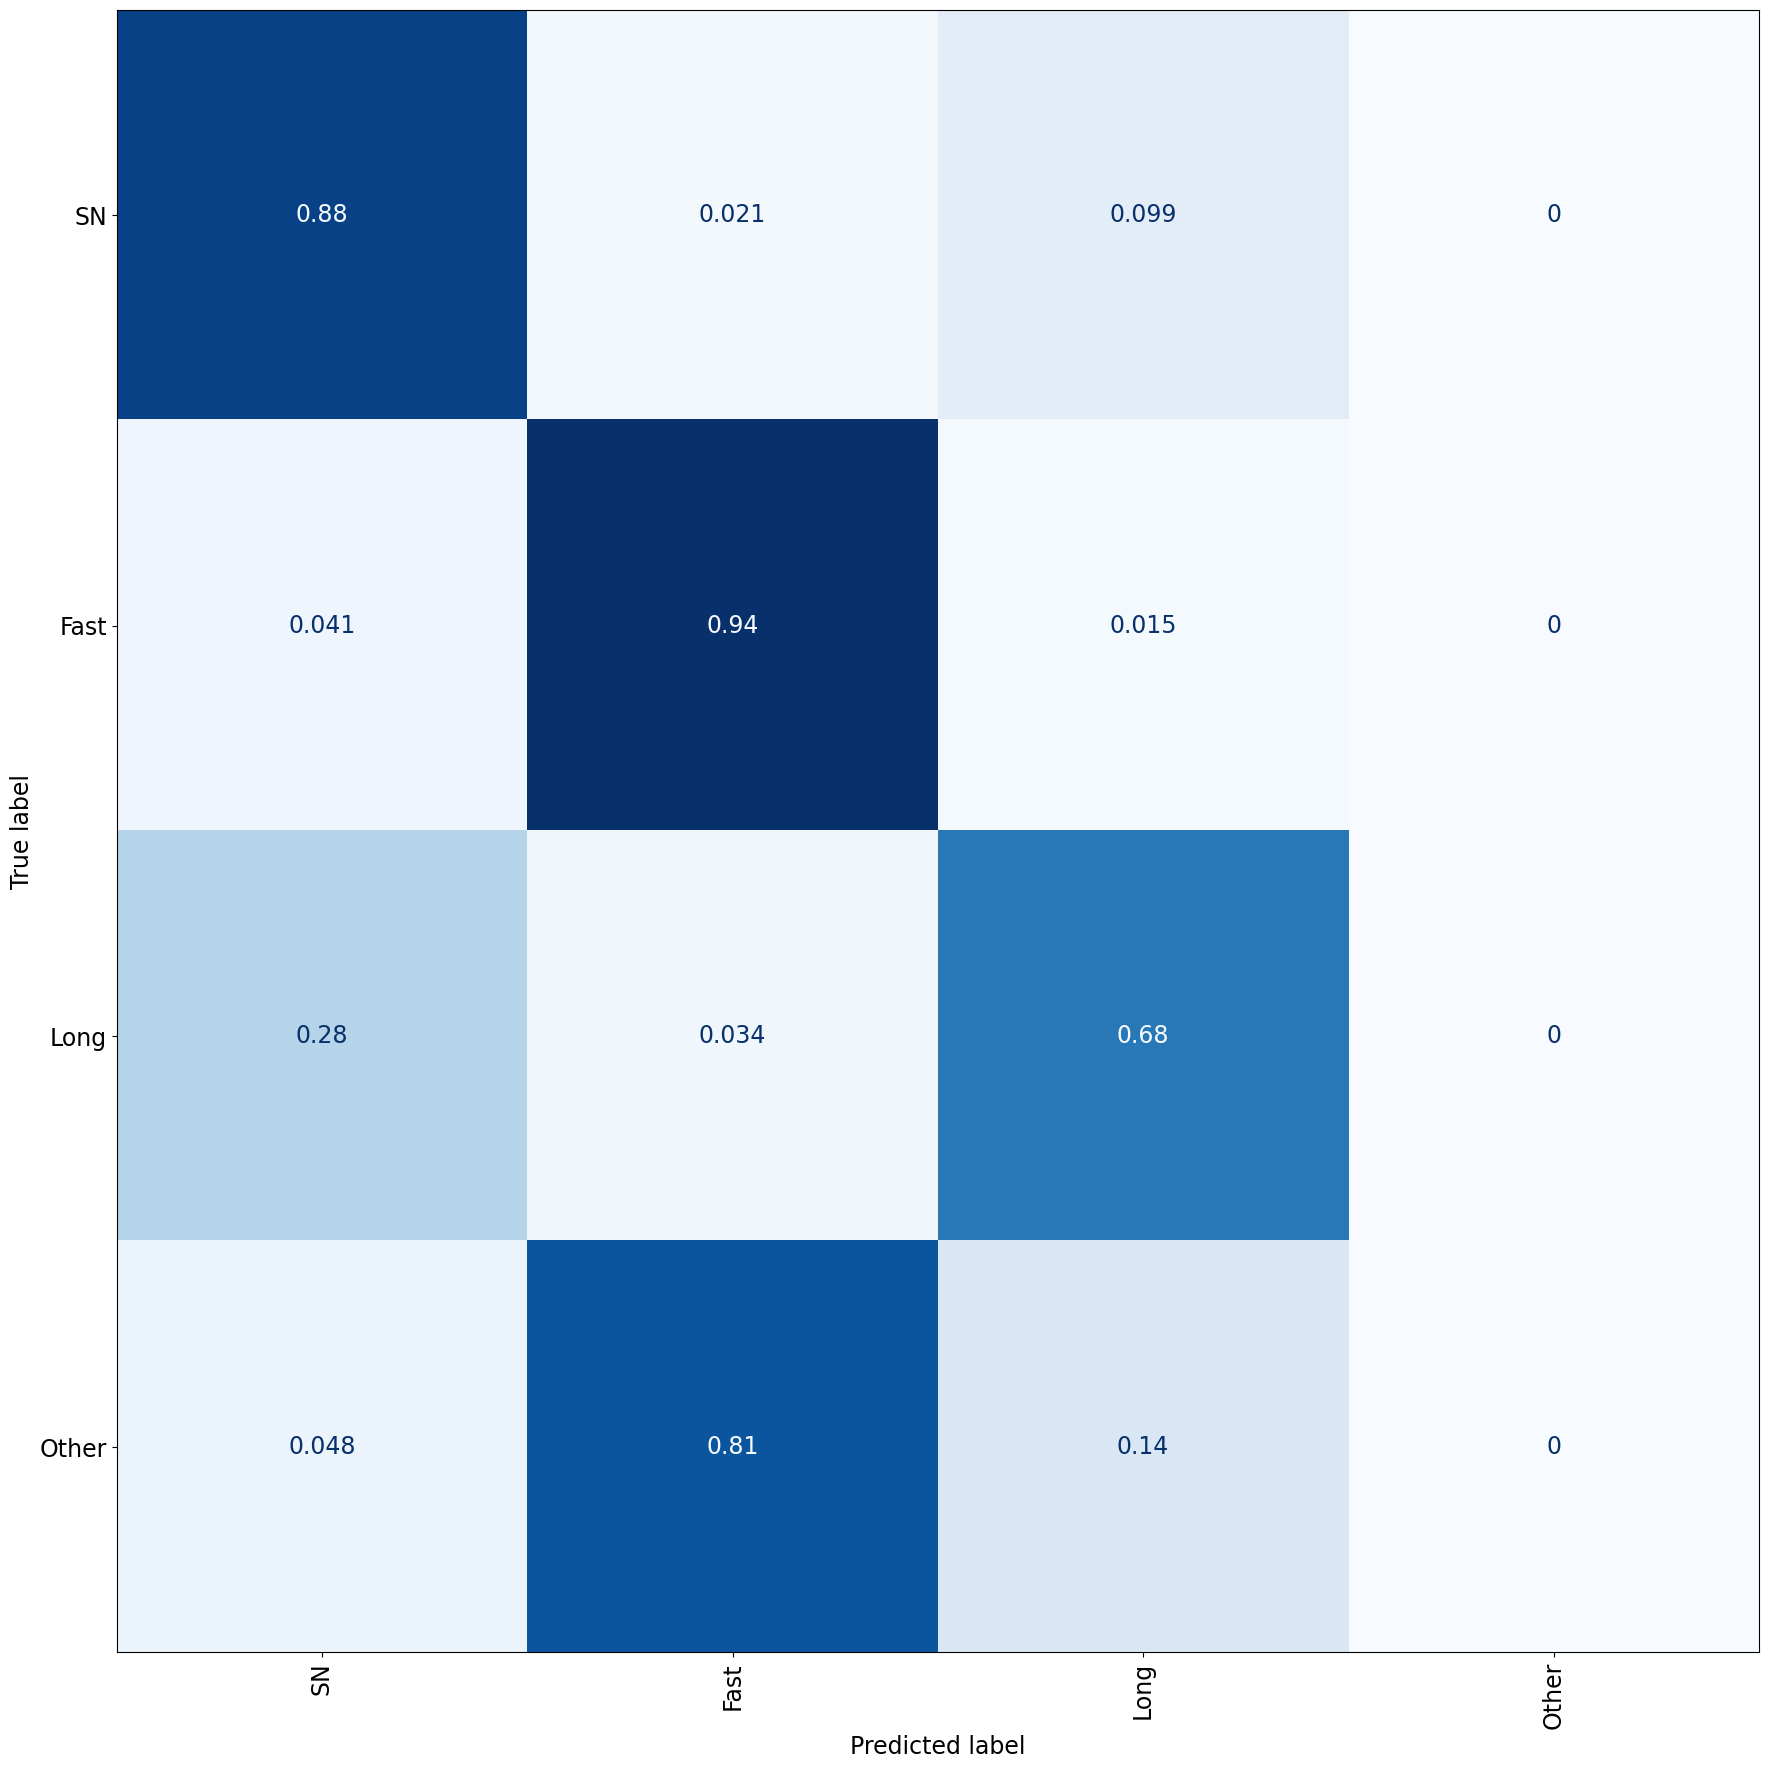

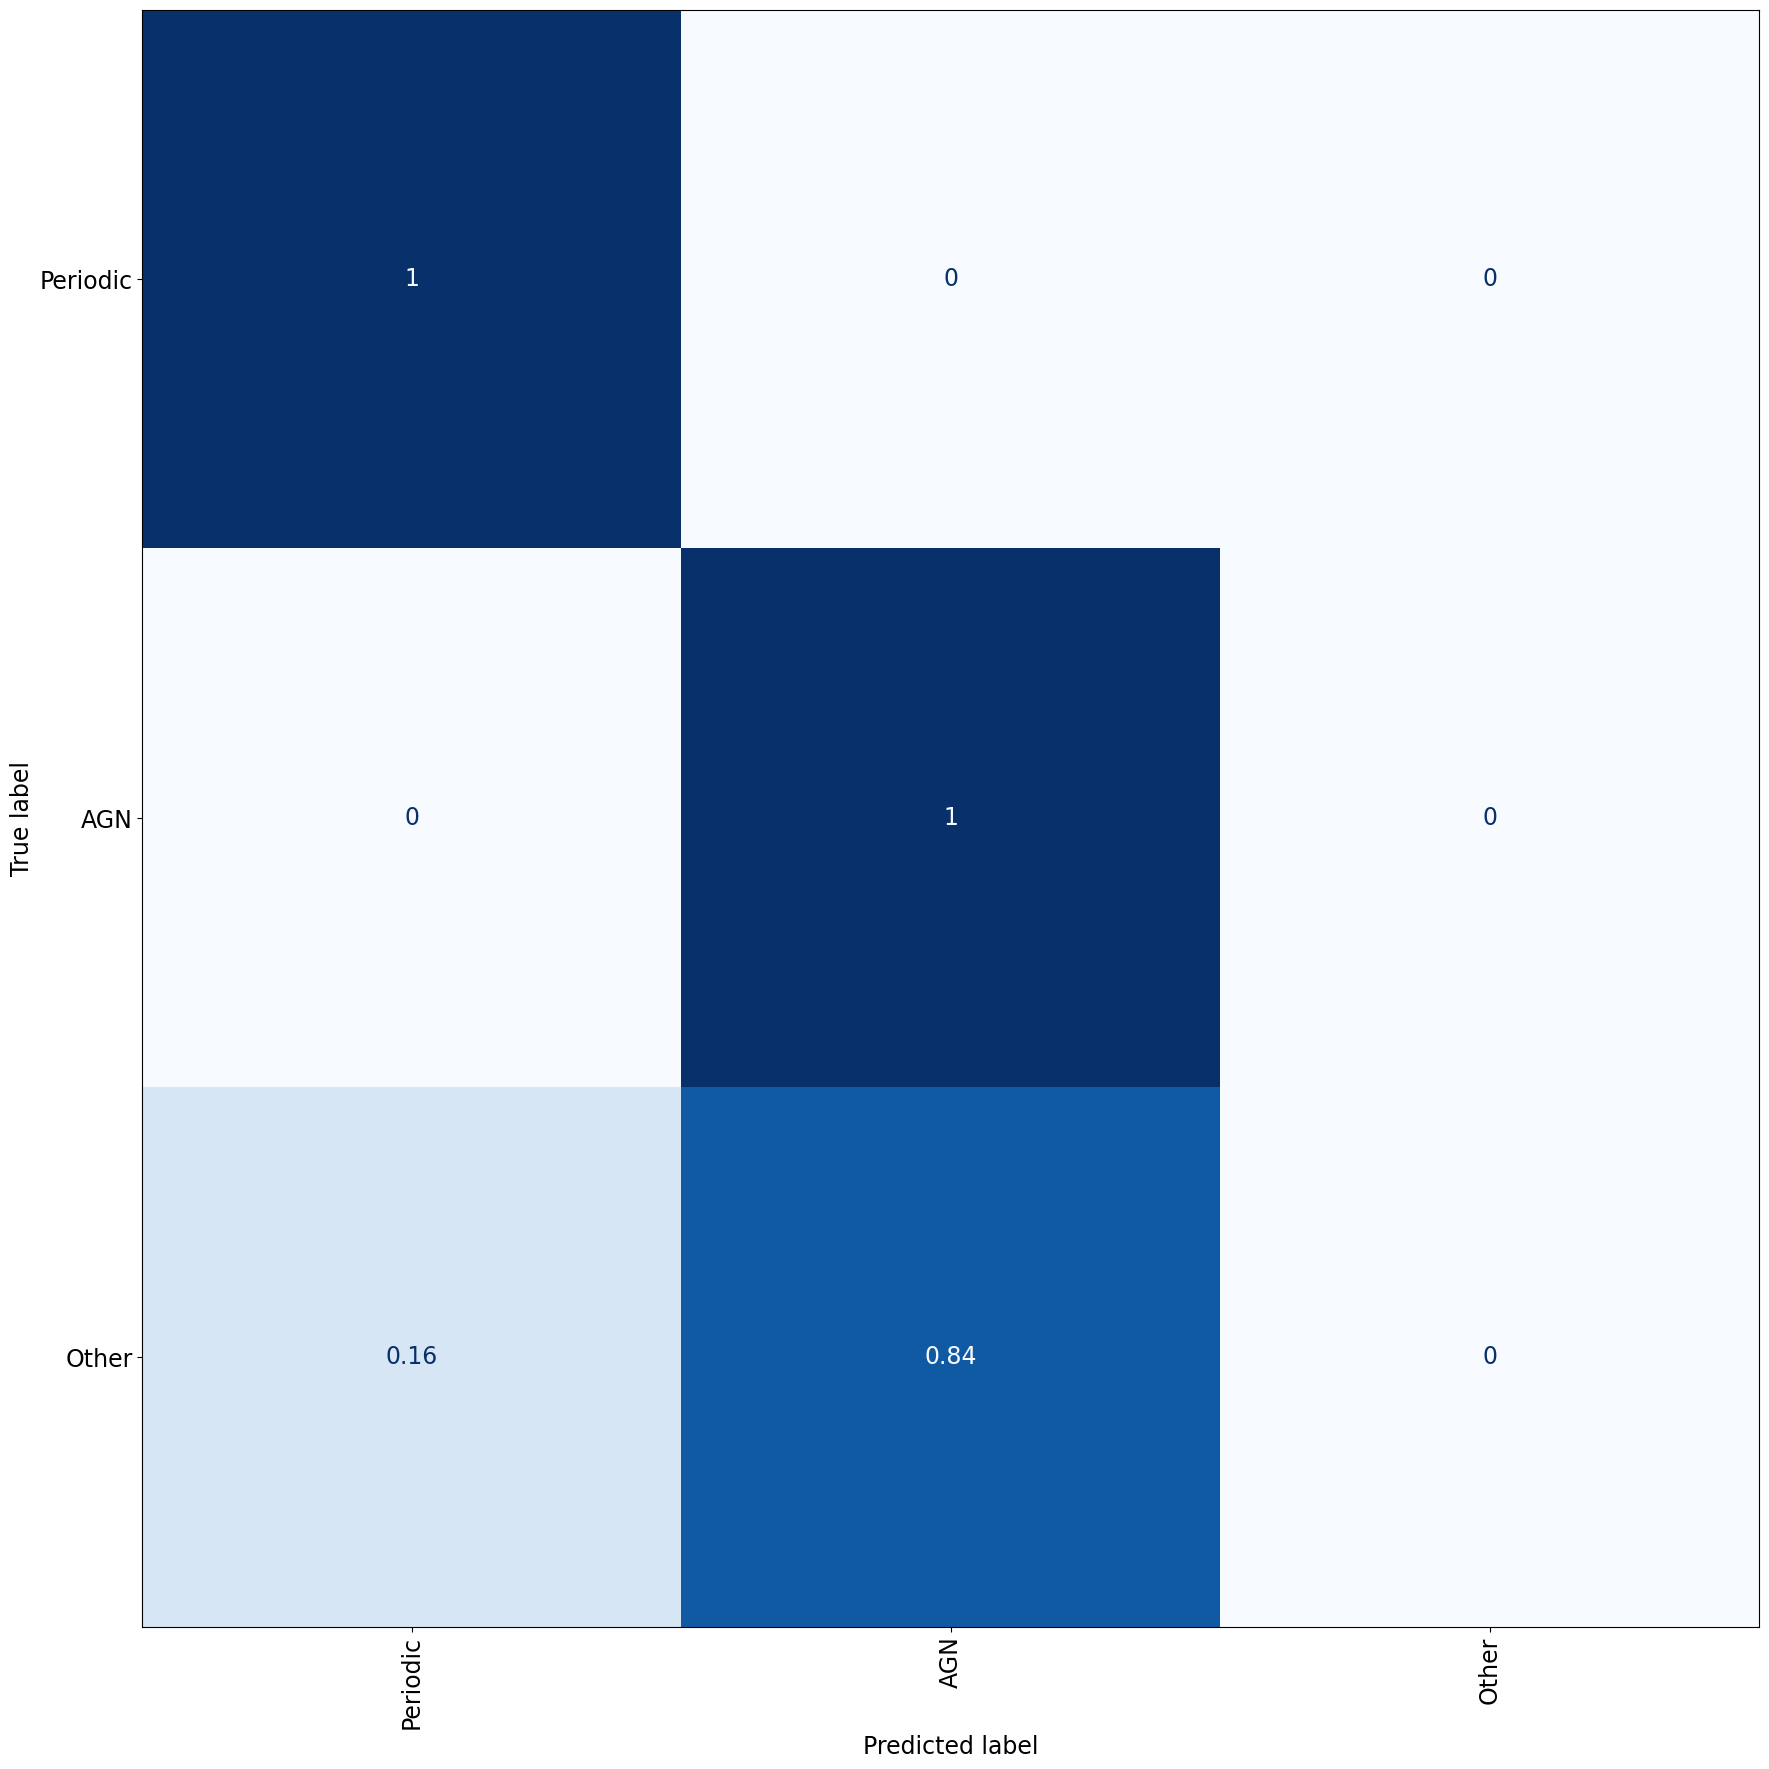

Running inference for 30% light curves...
332/332 [==============================] - 2s 5ms/step
For 30% of the light curve, these are the statistics


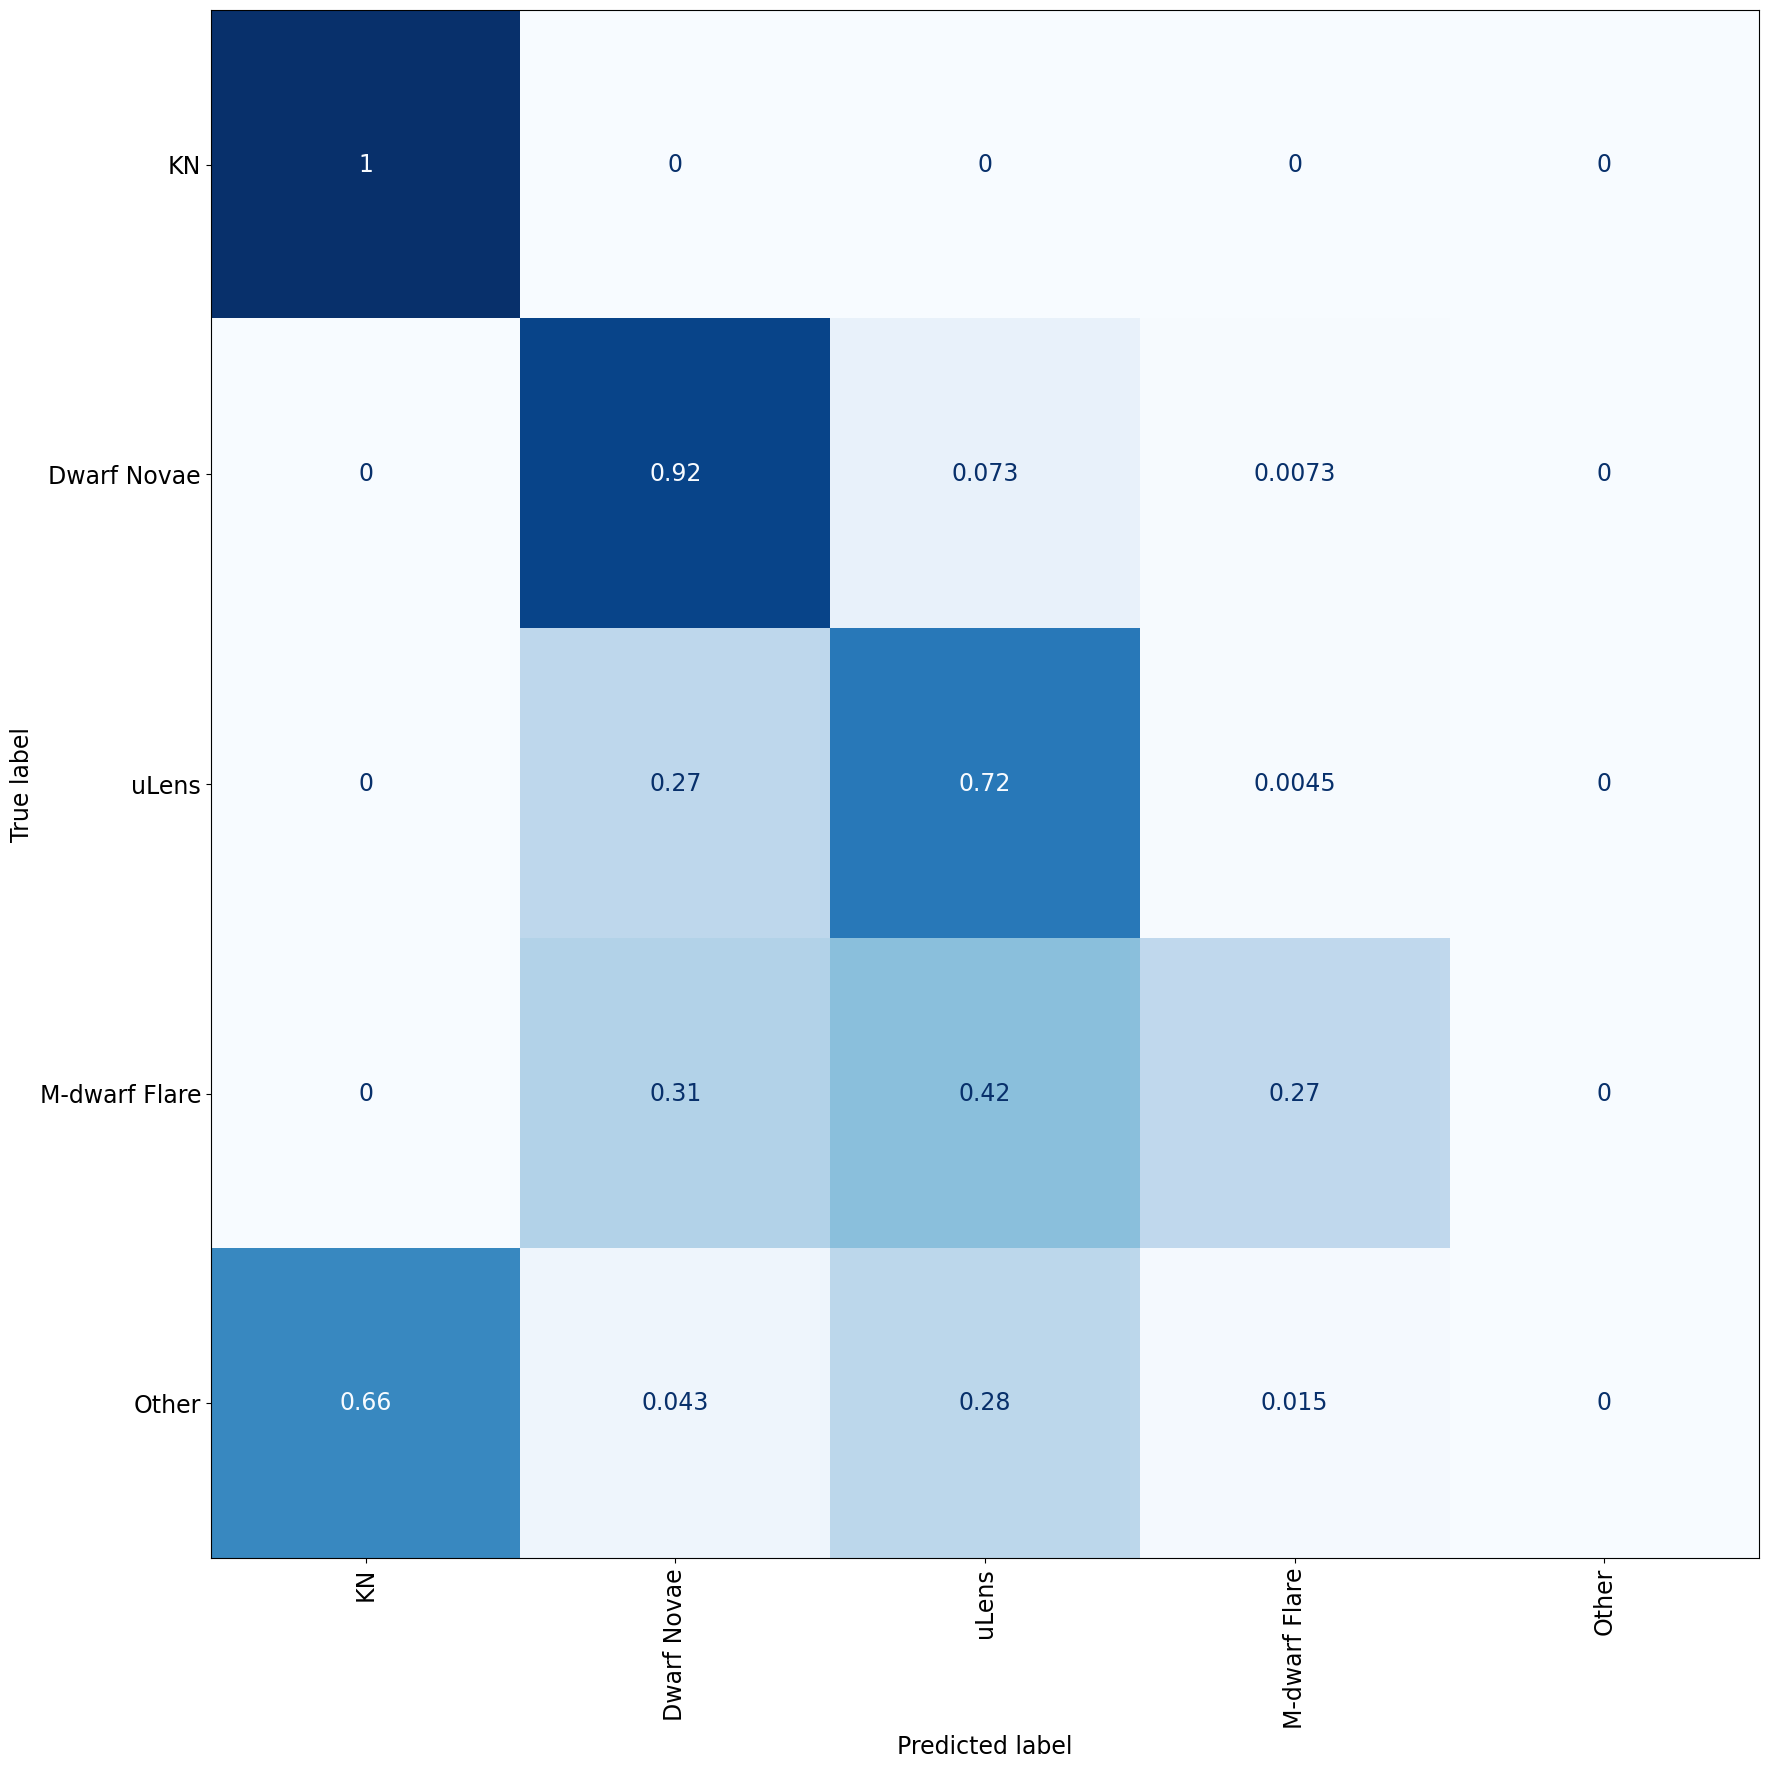

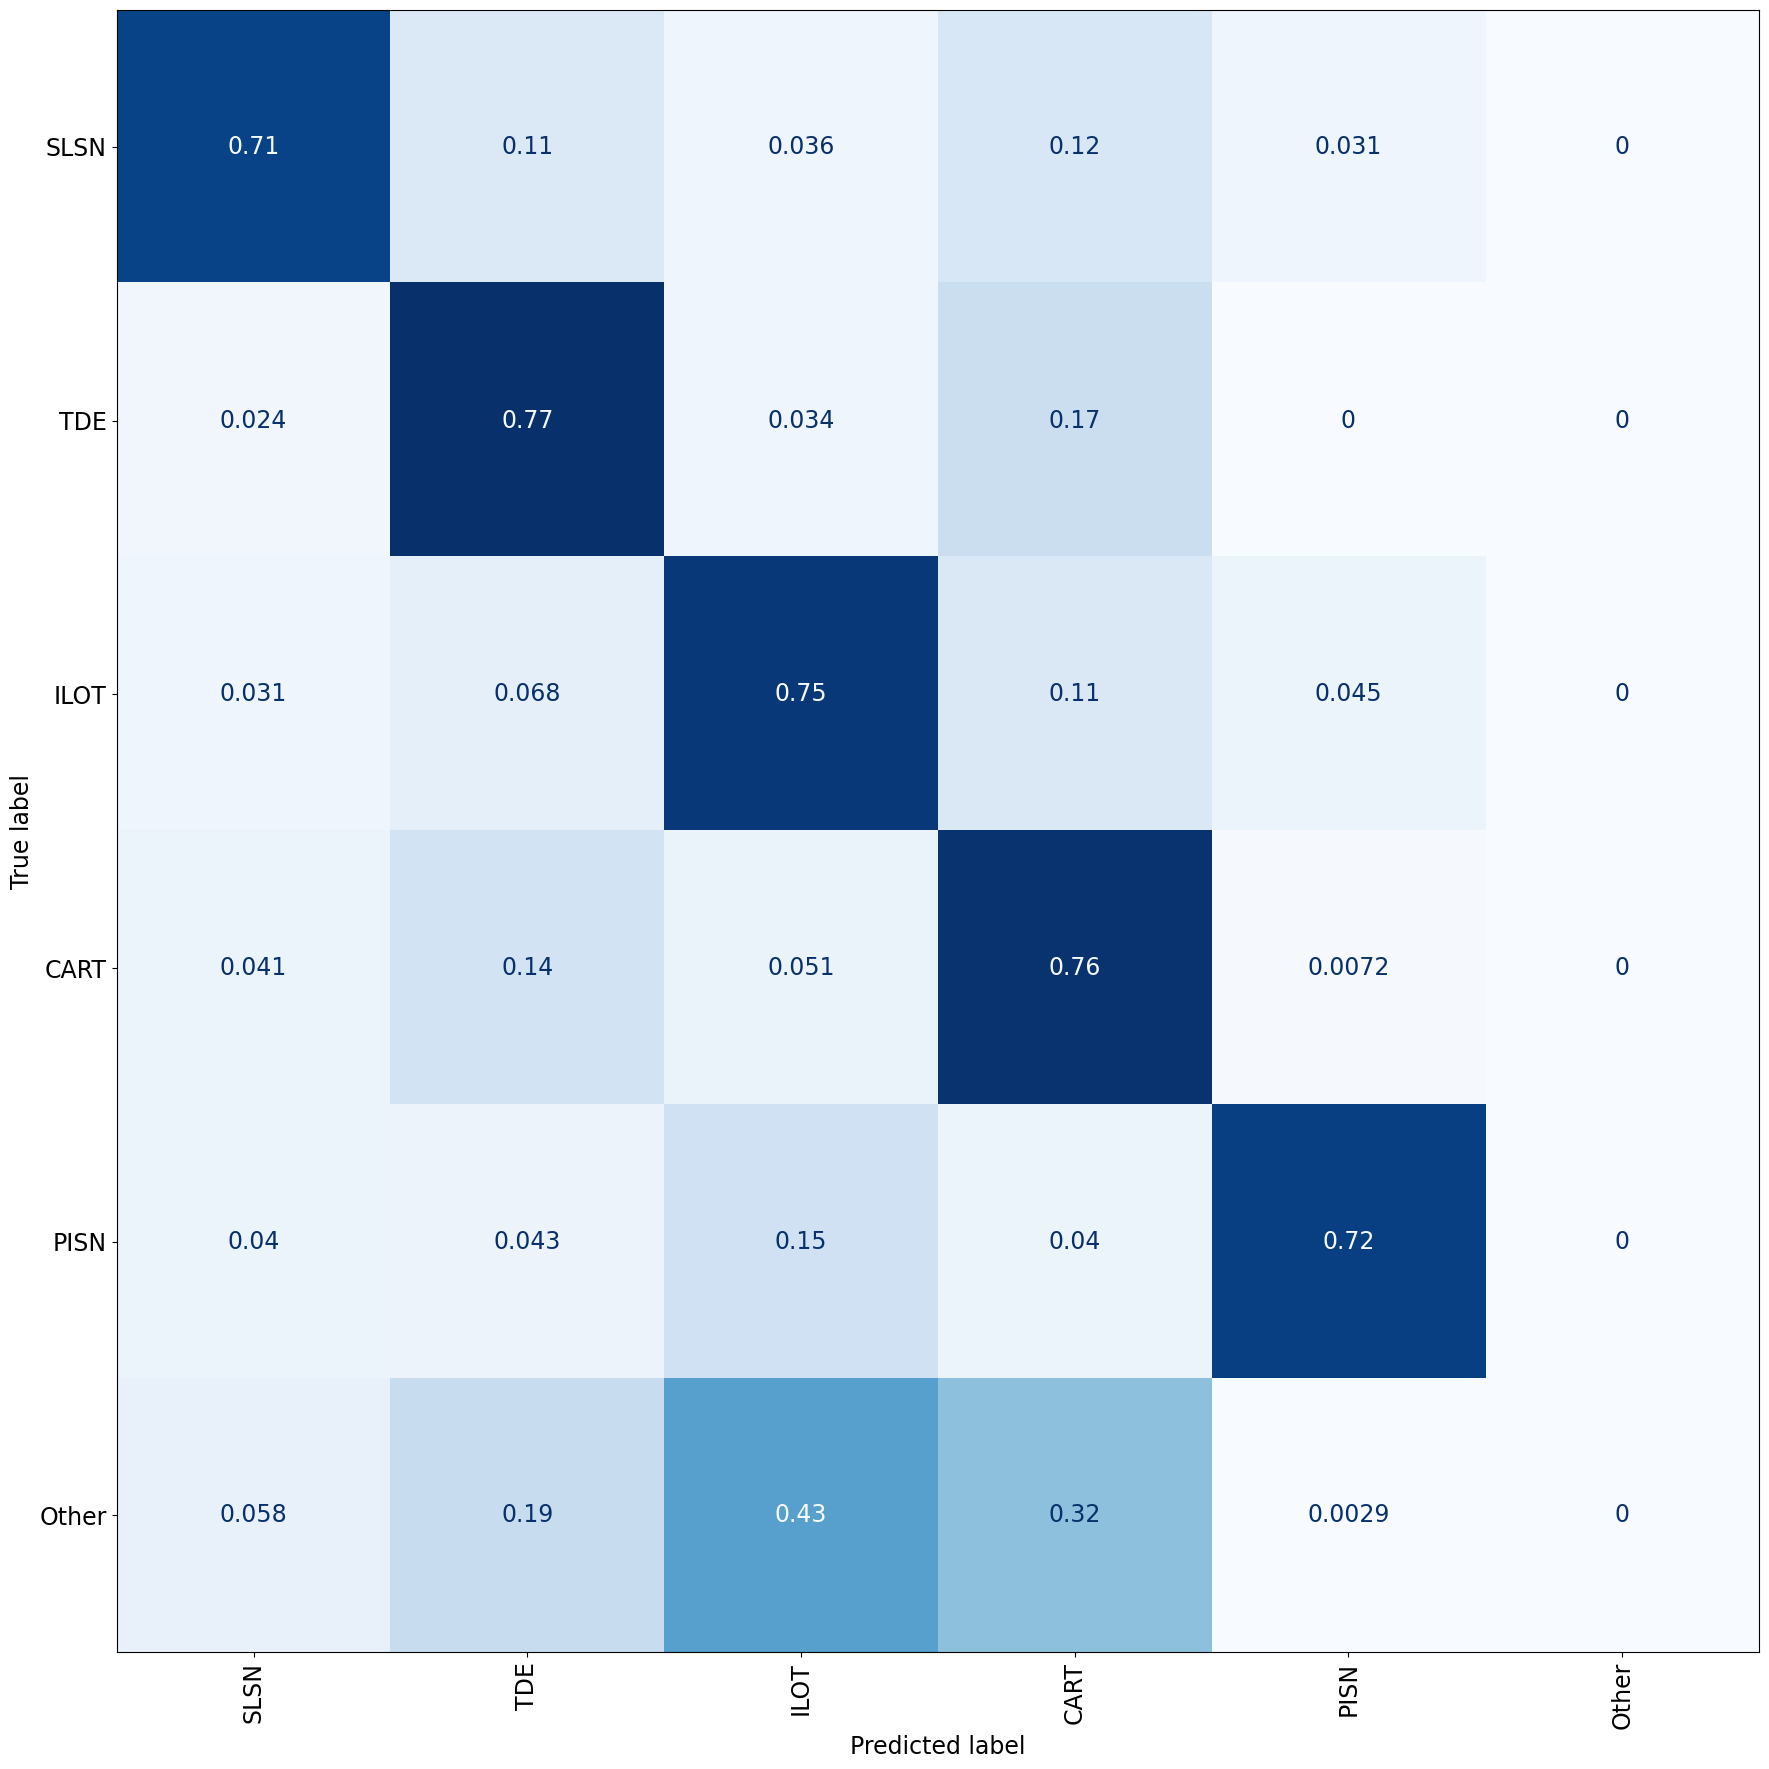

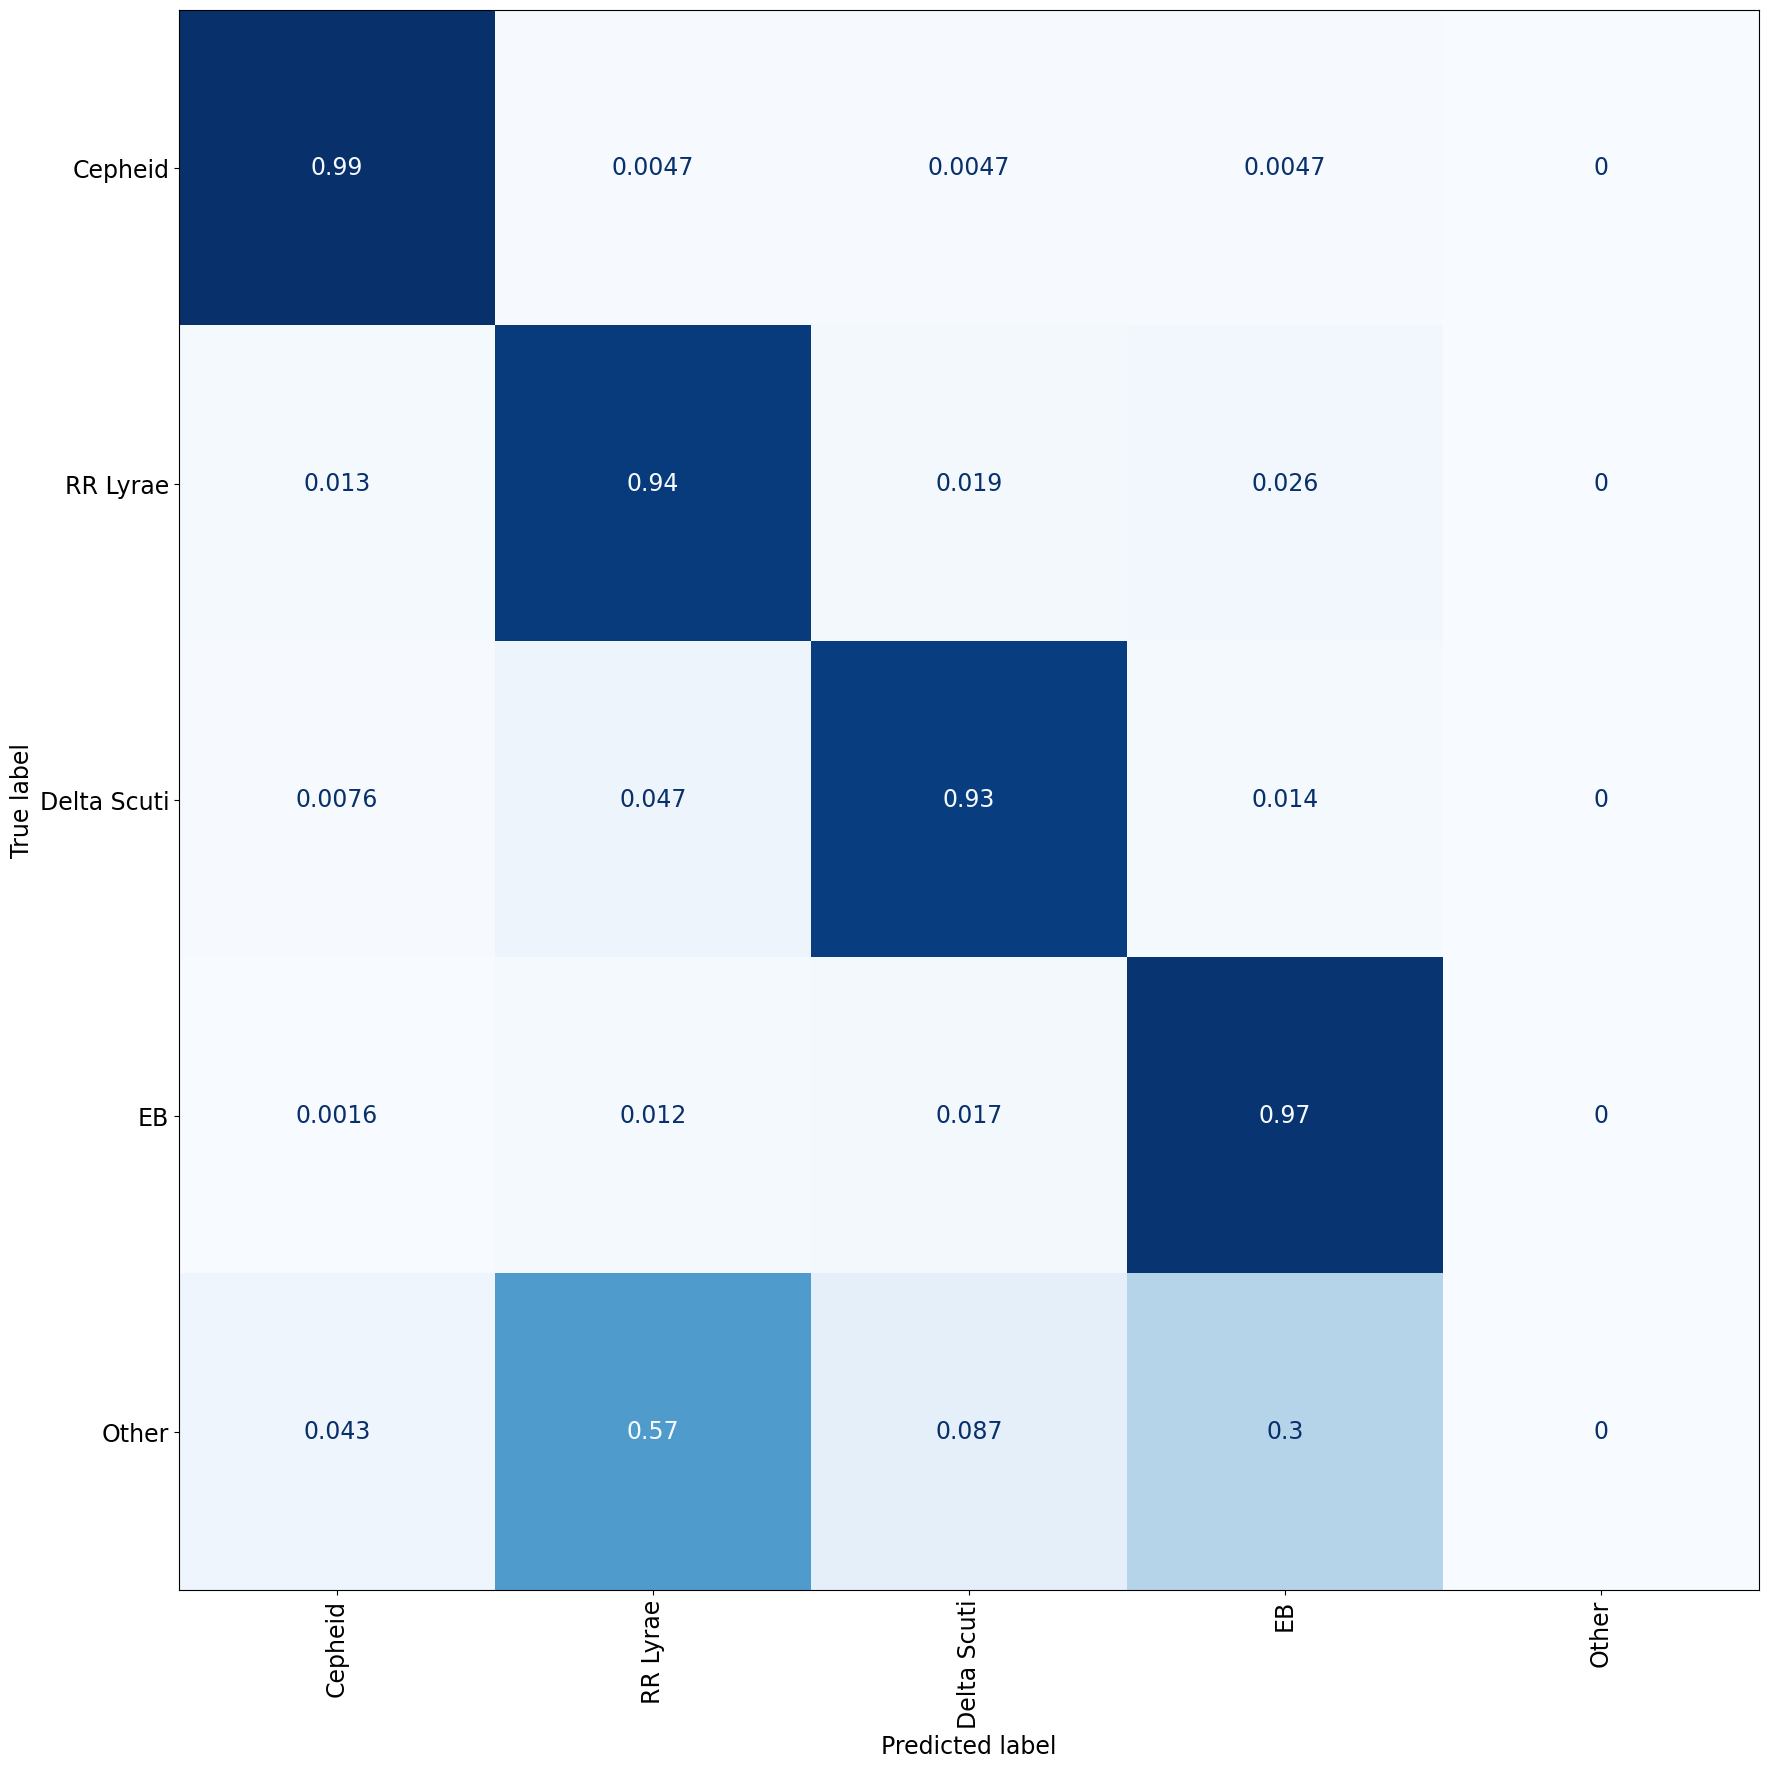

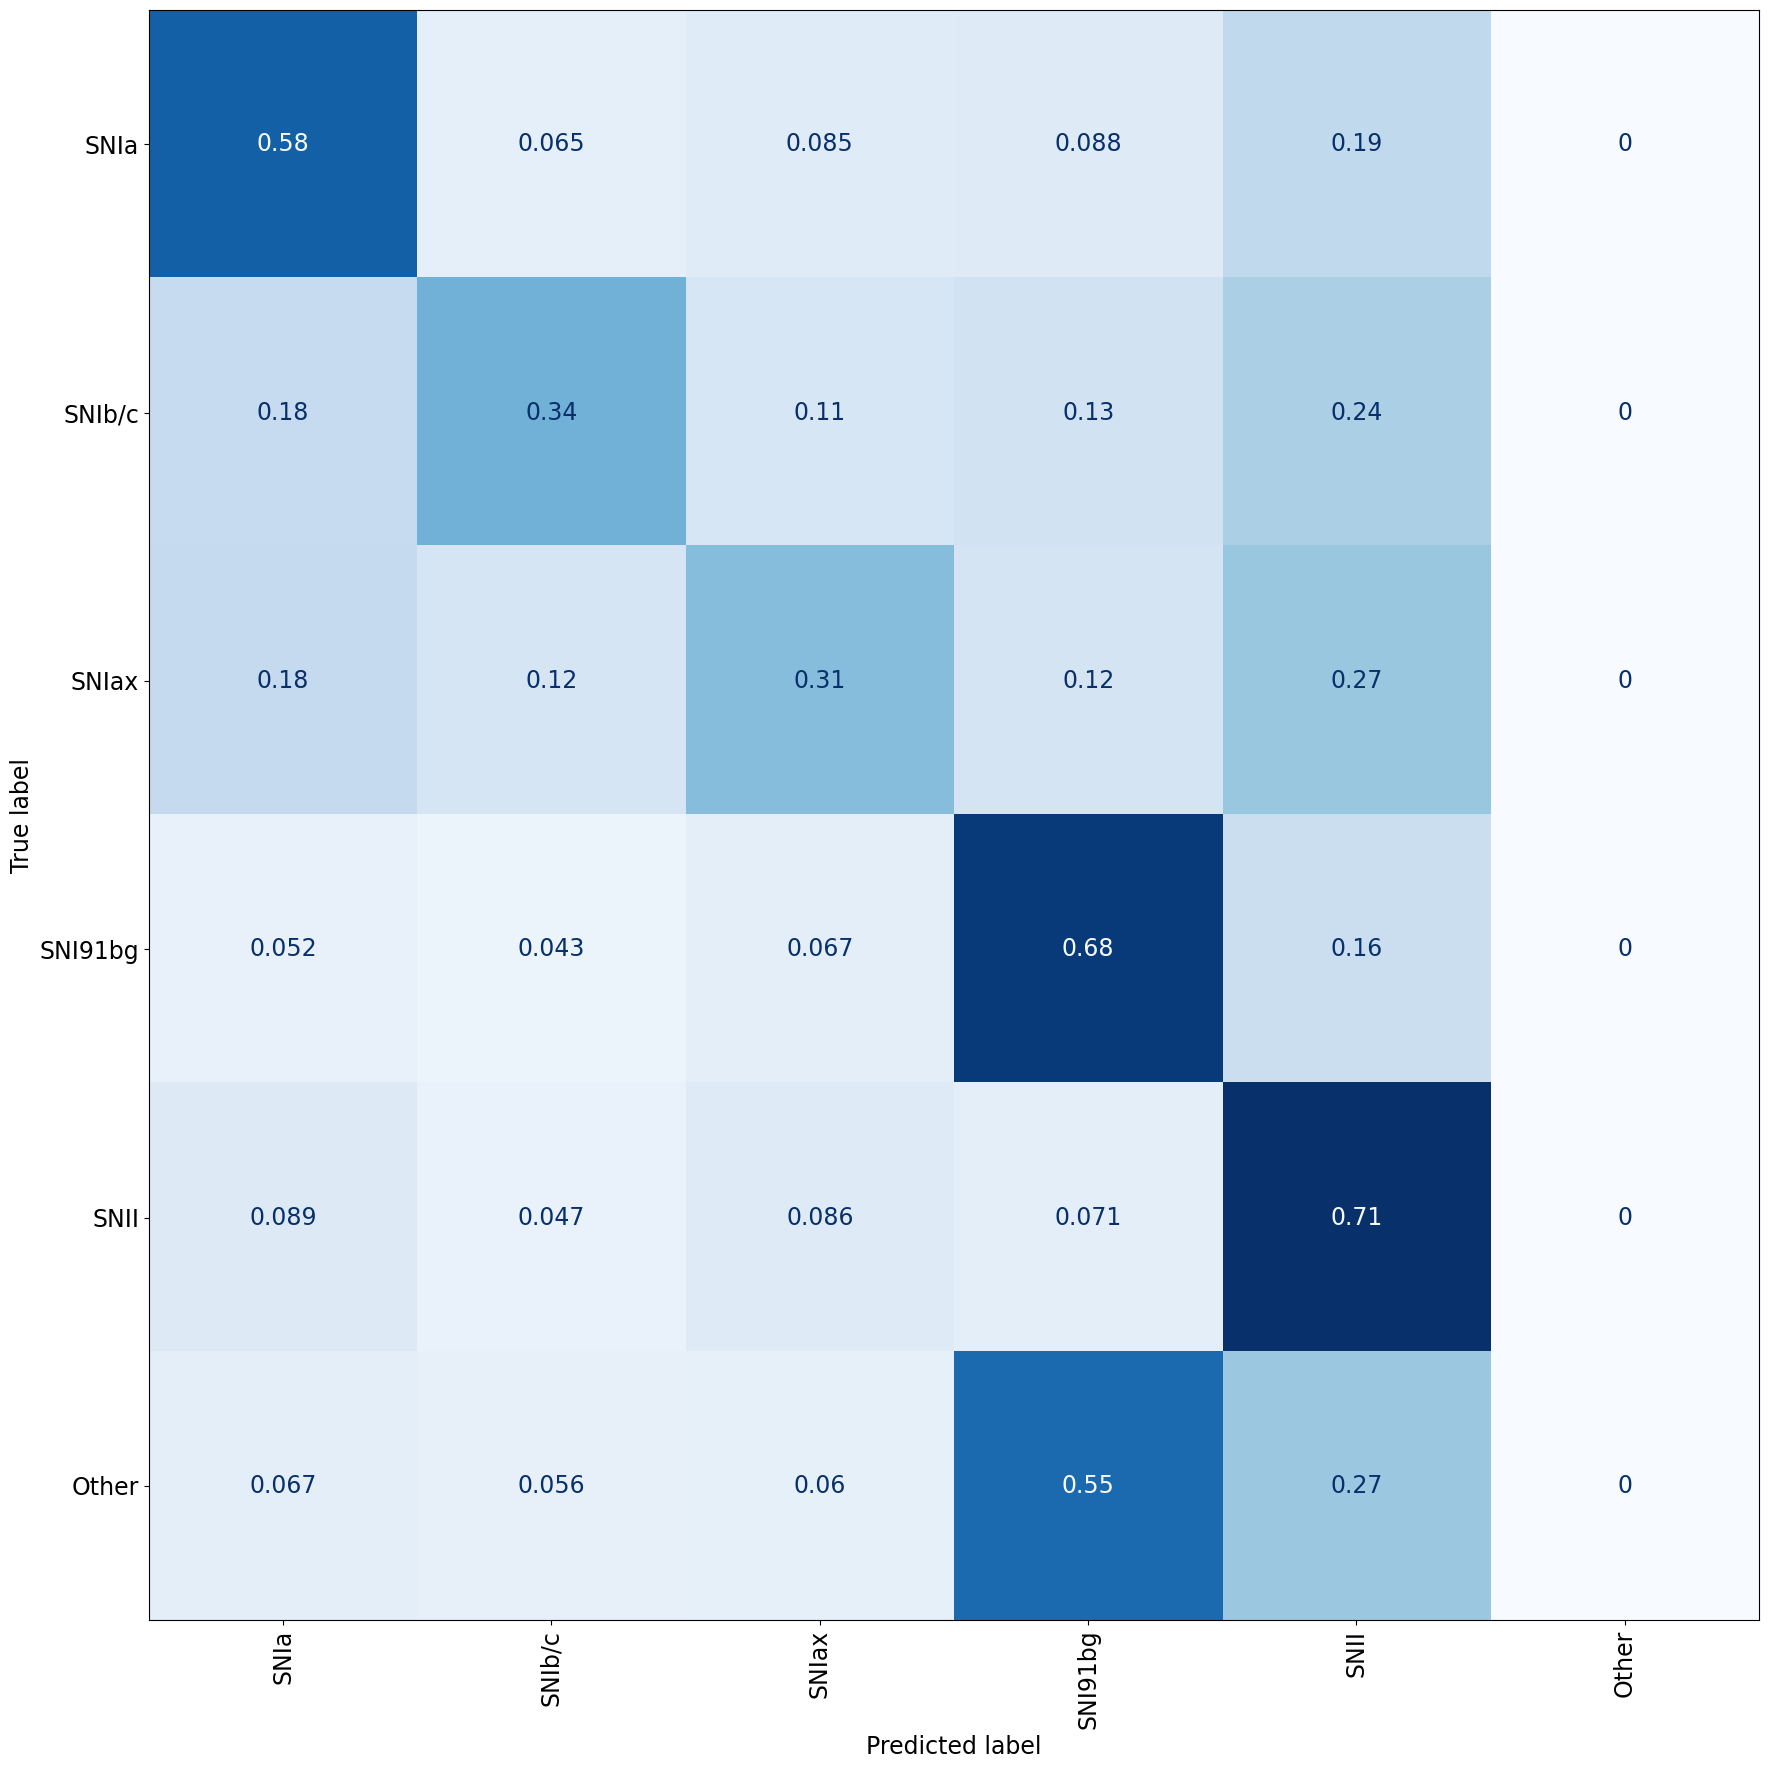

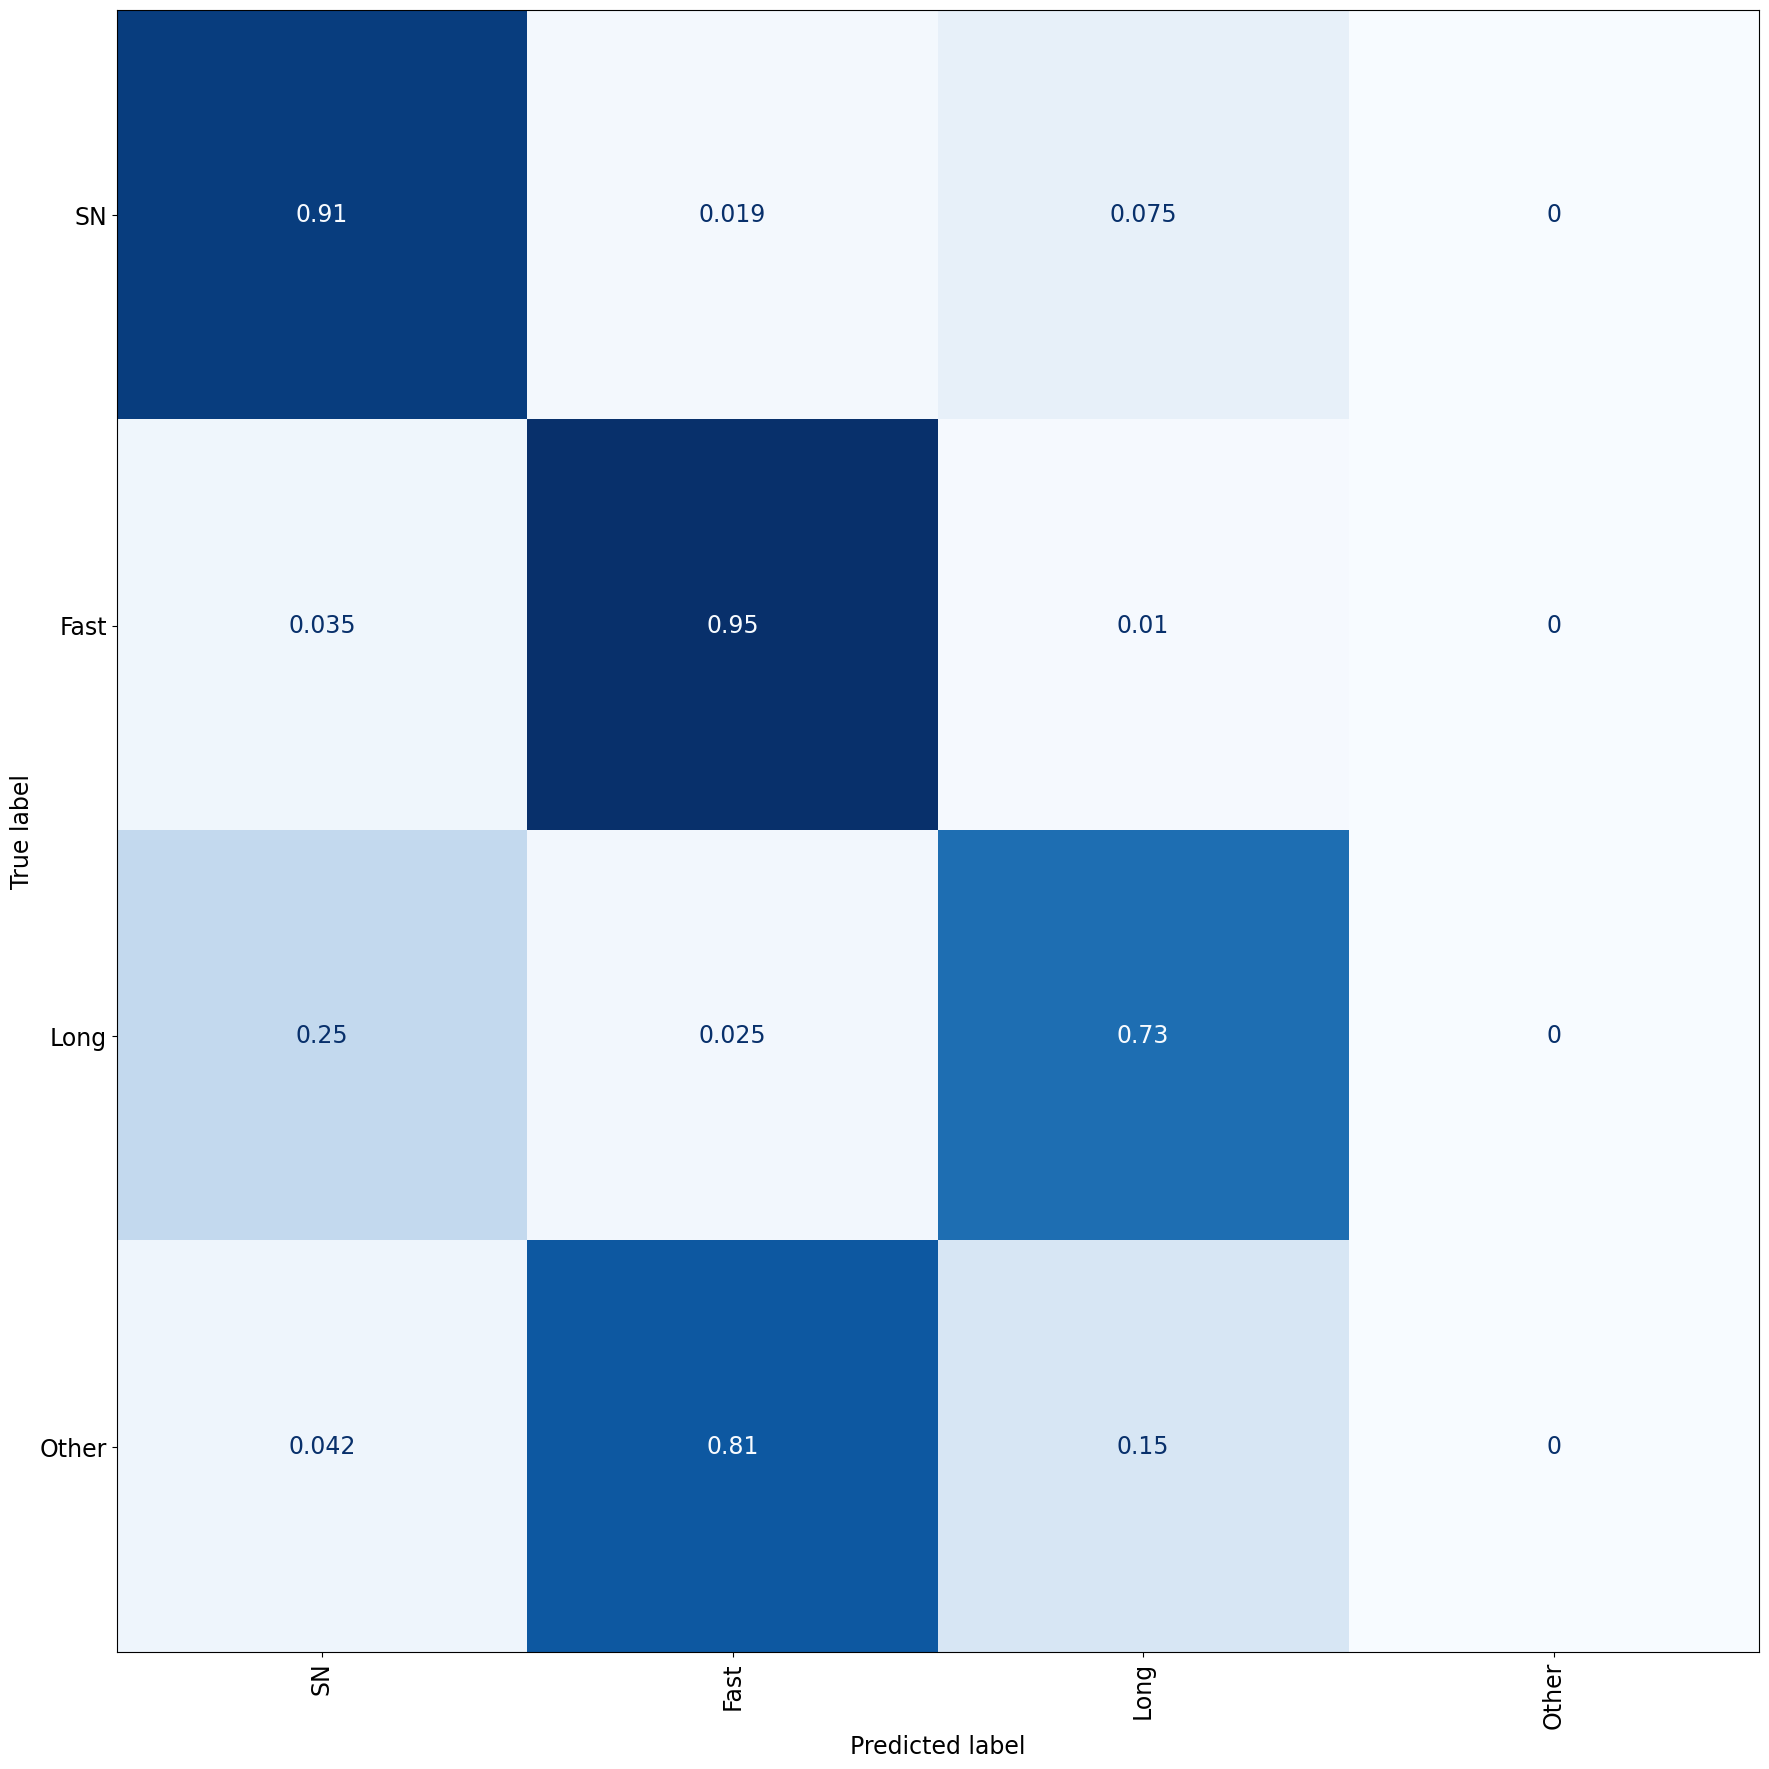

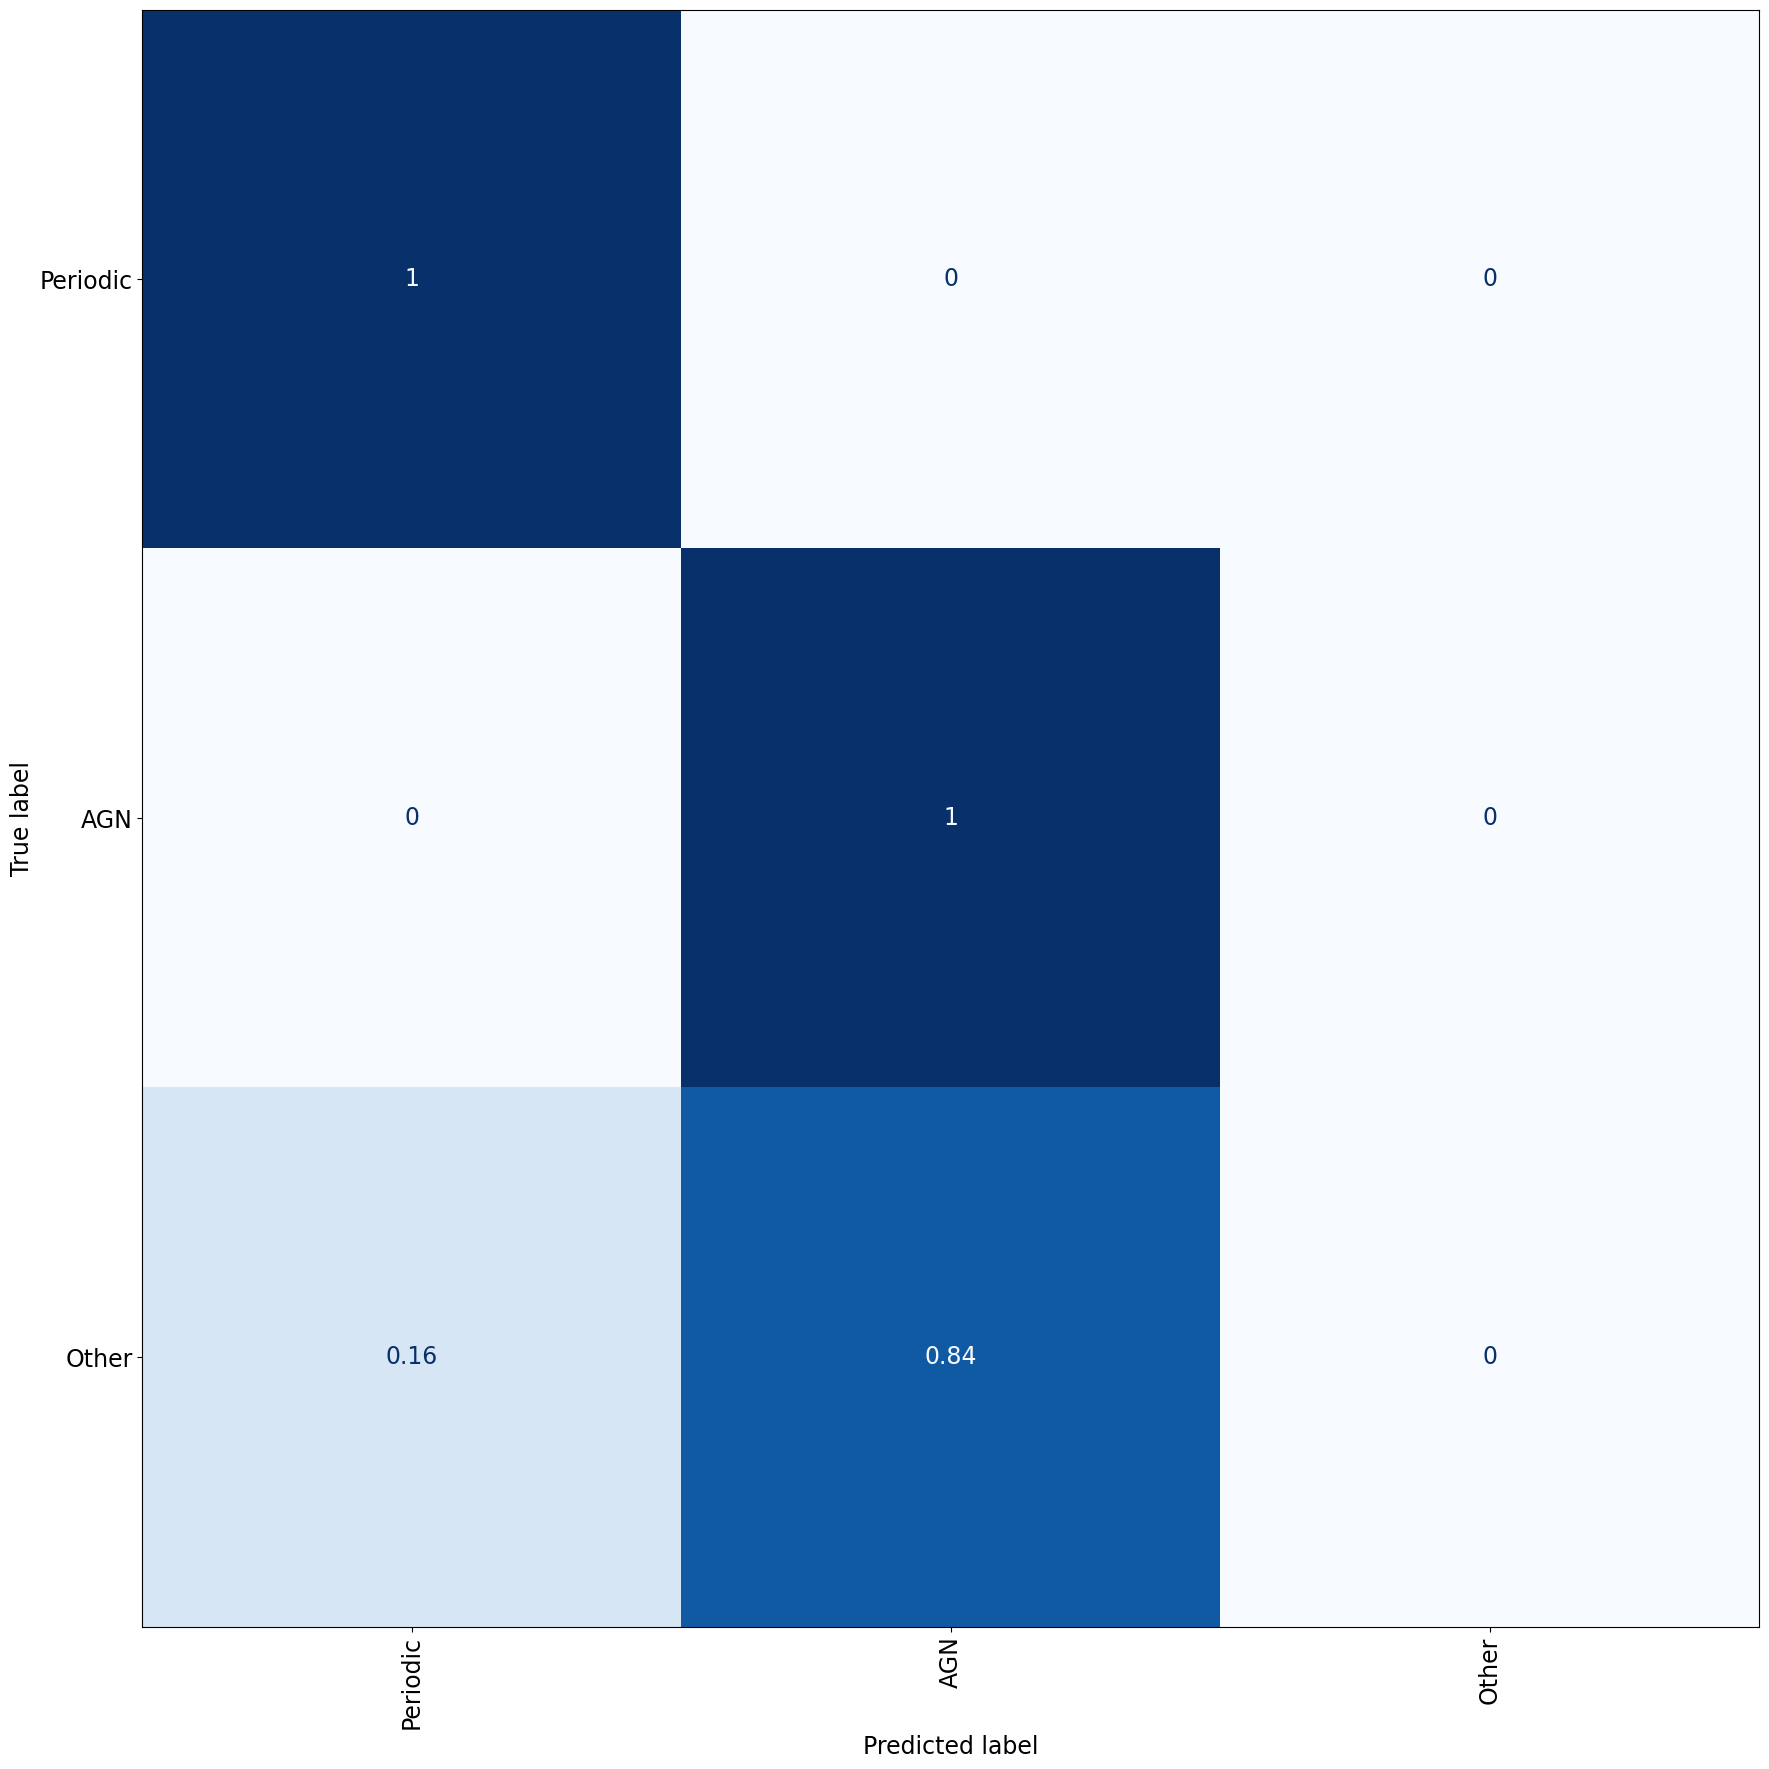

Running inference for 40% light curves...
332/332 [==============================] - 2s 5ms/step
For 40% of the light curve, these are the statistics


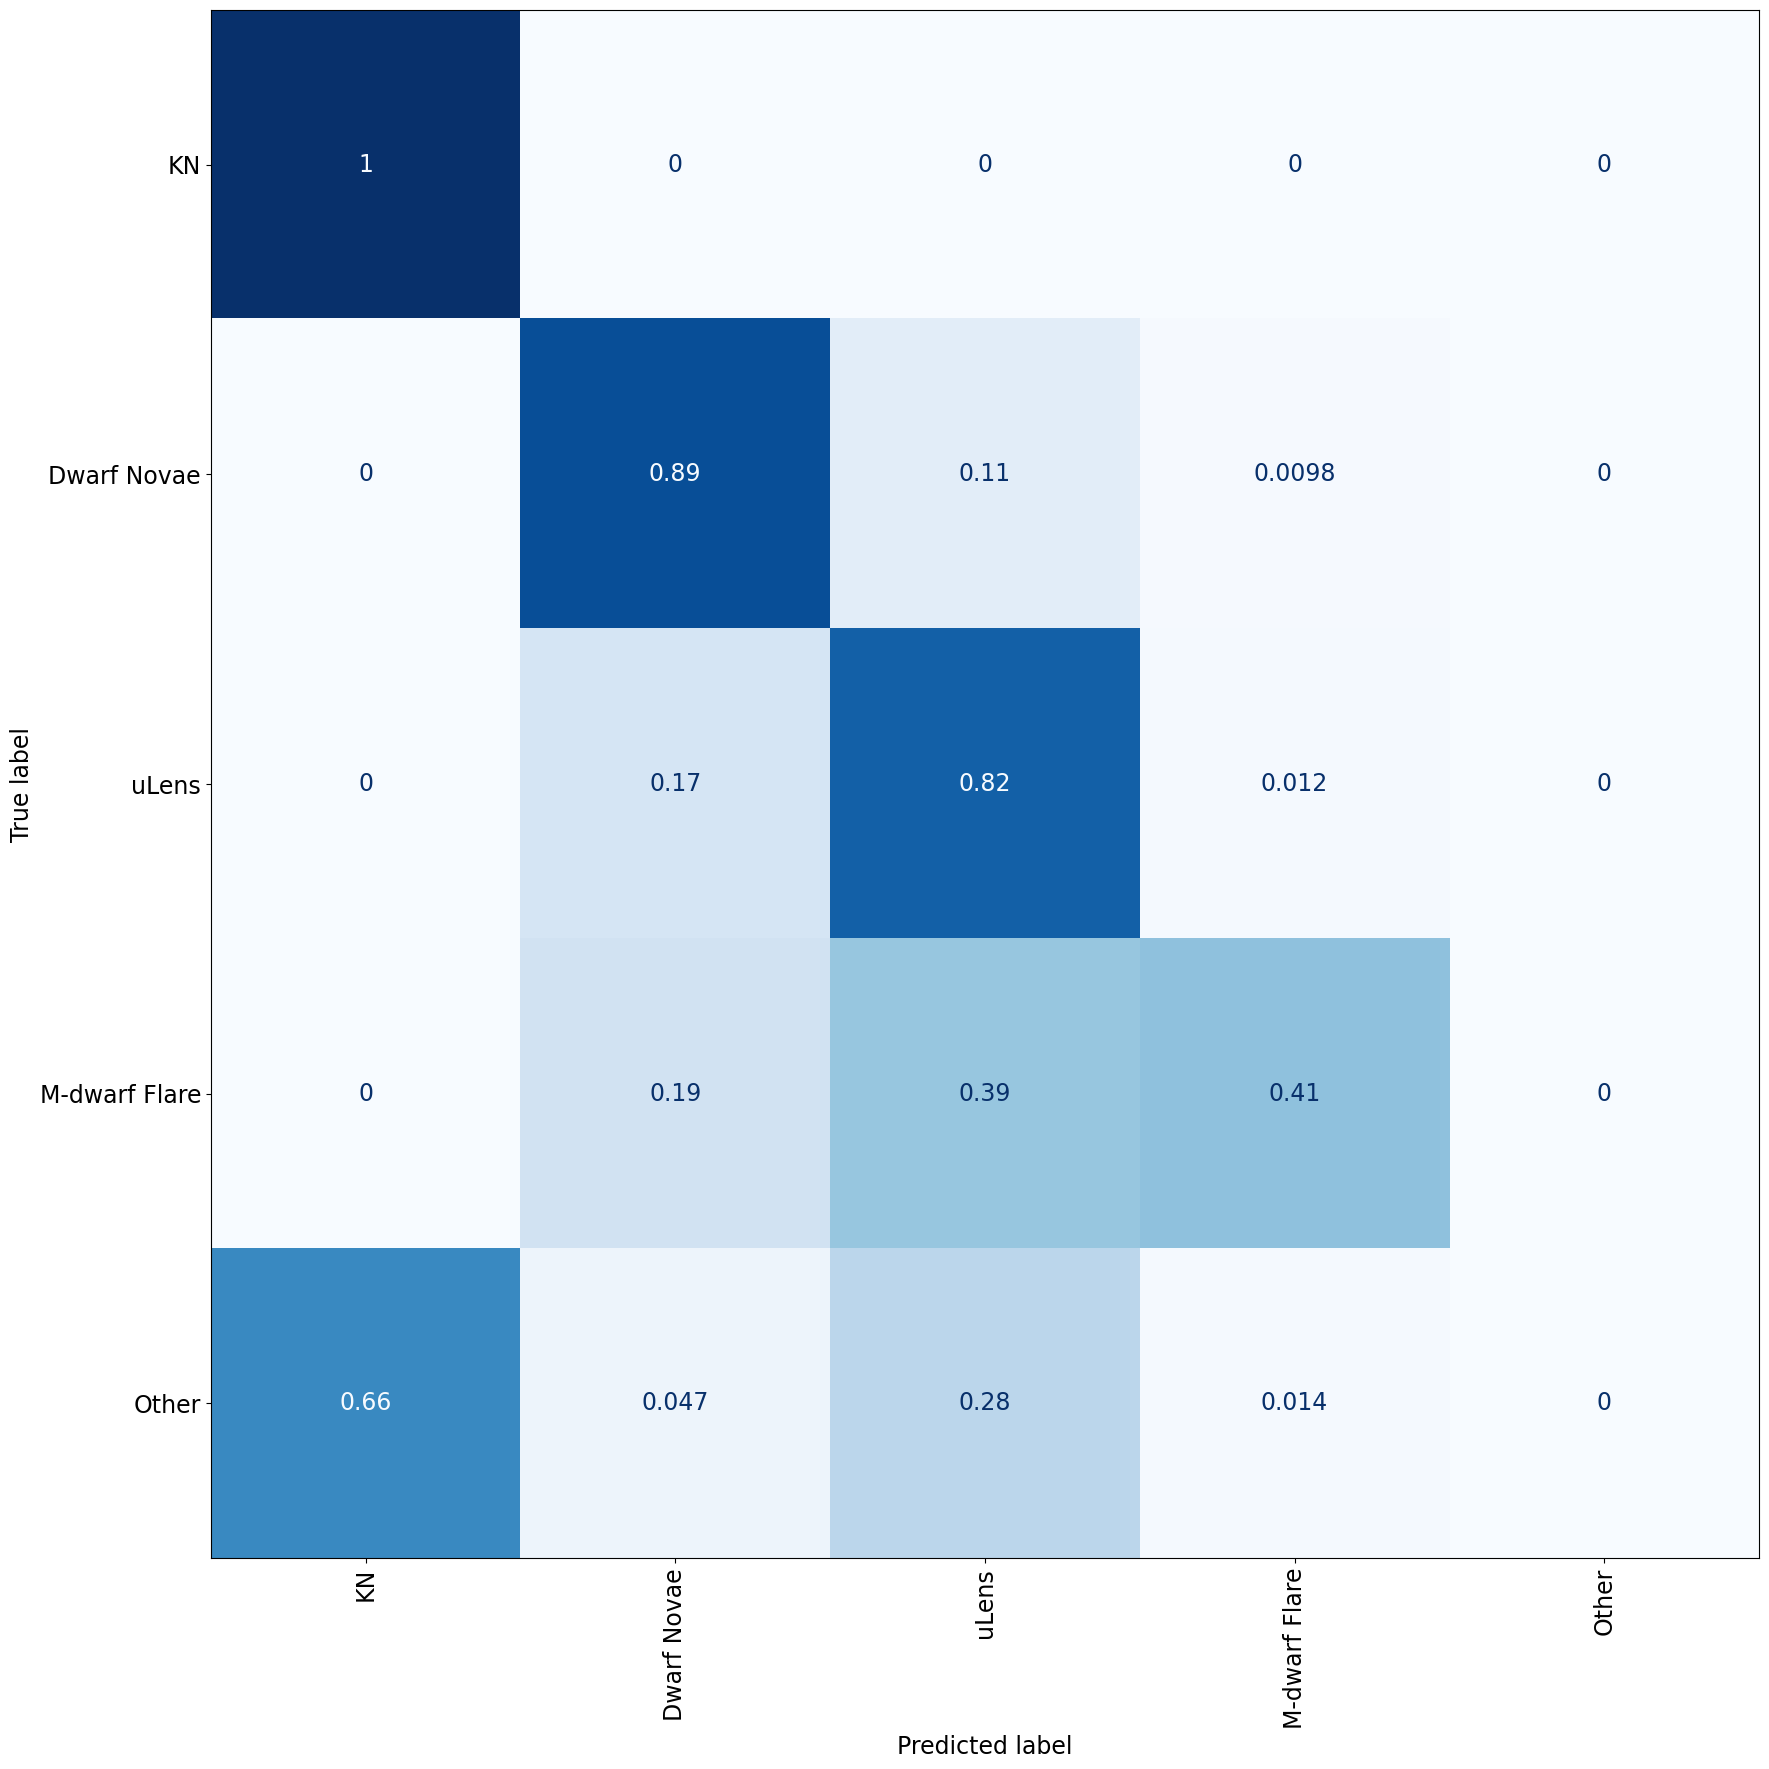

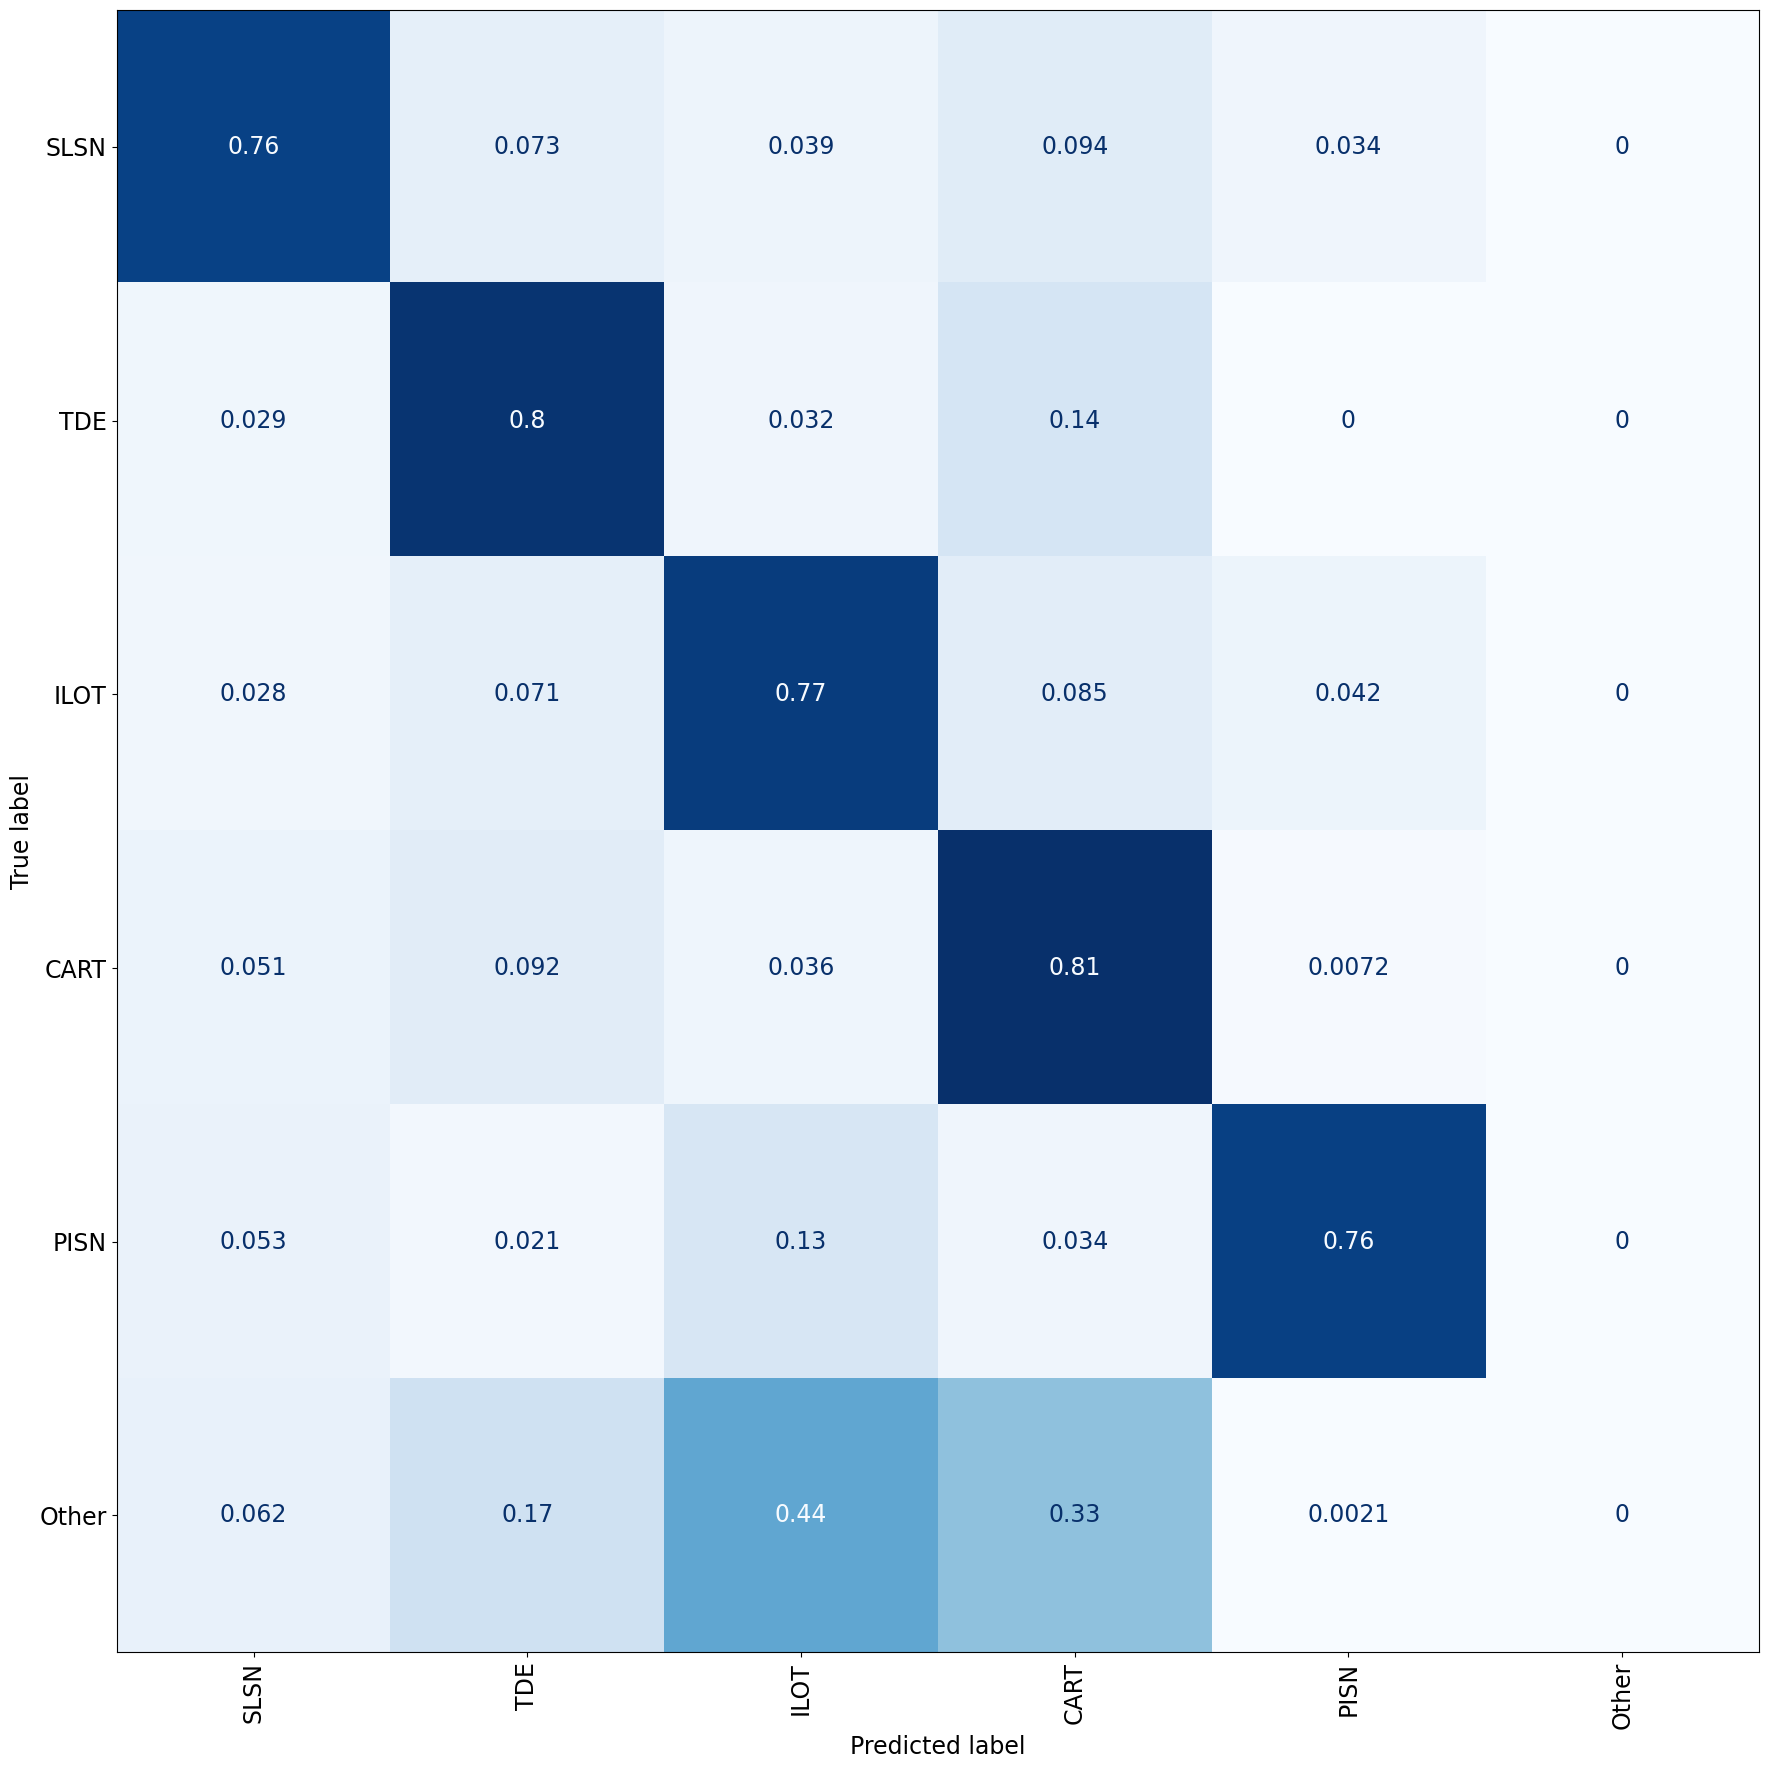

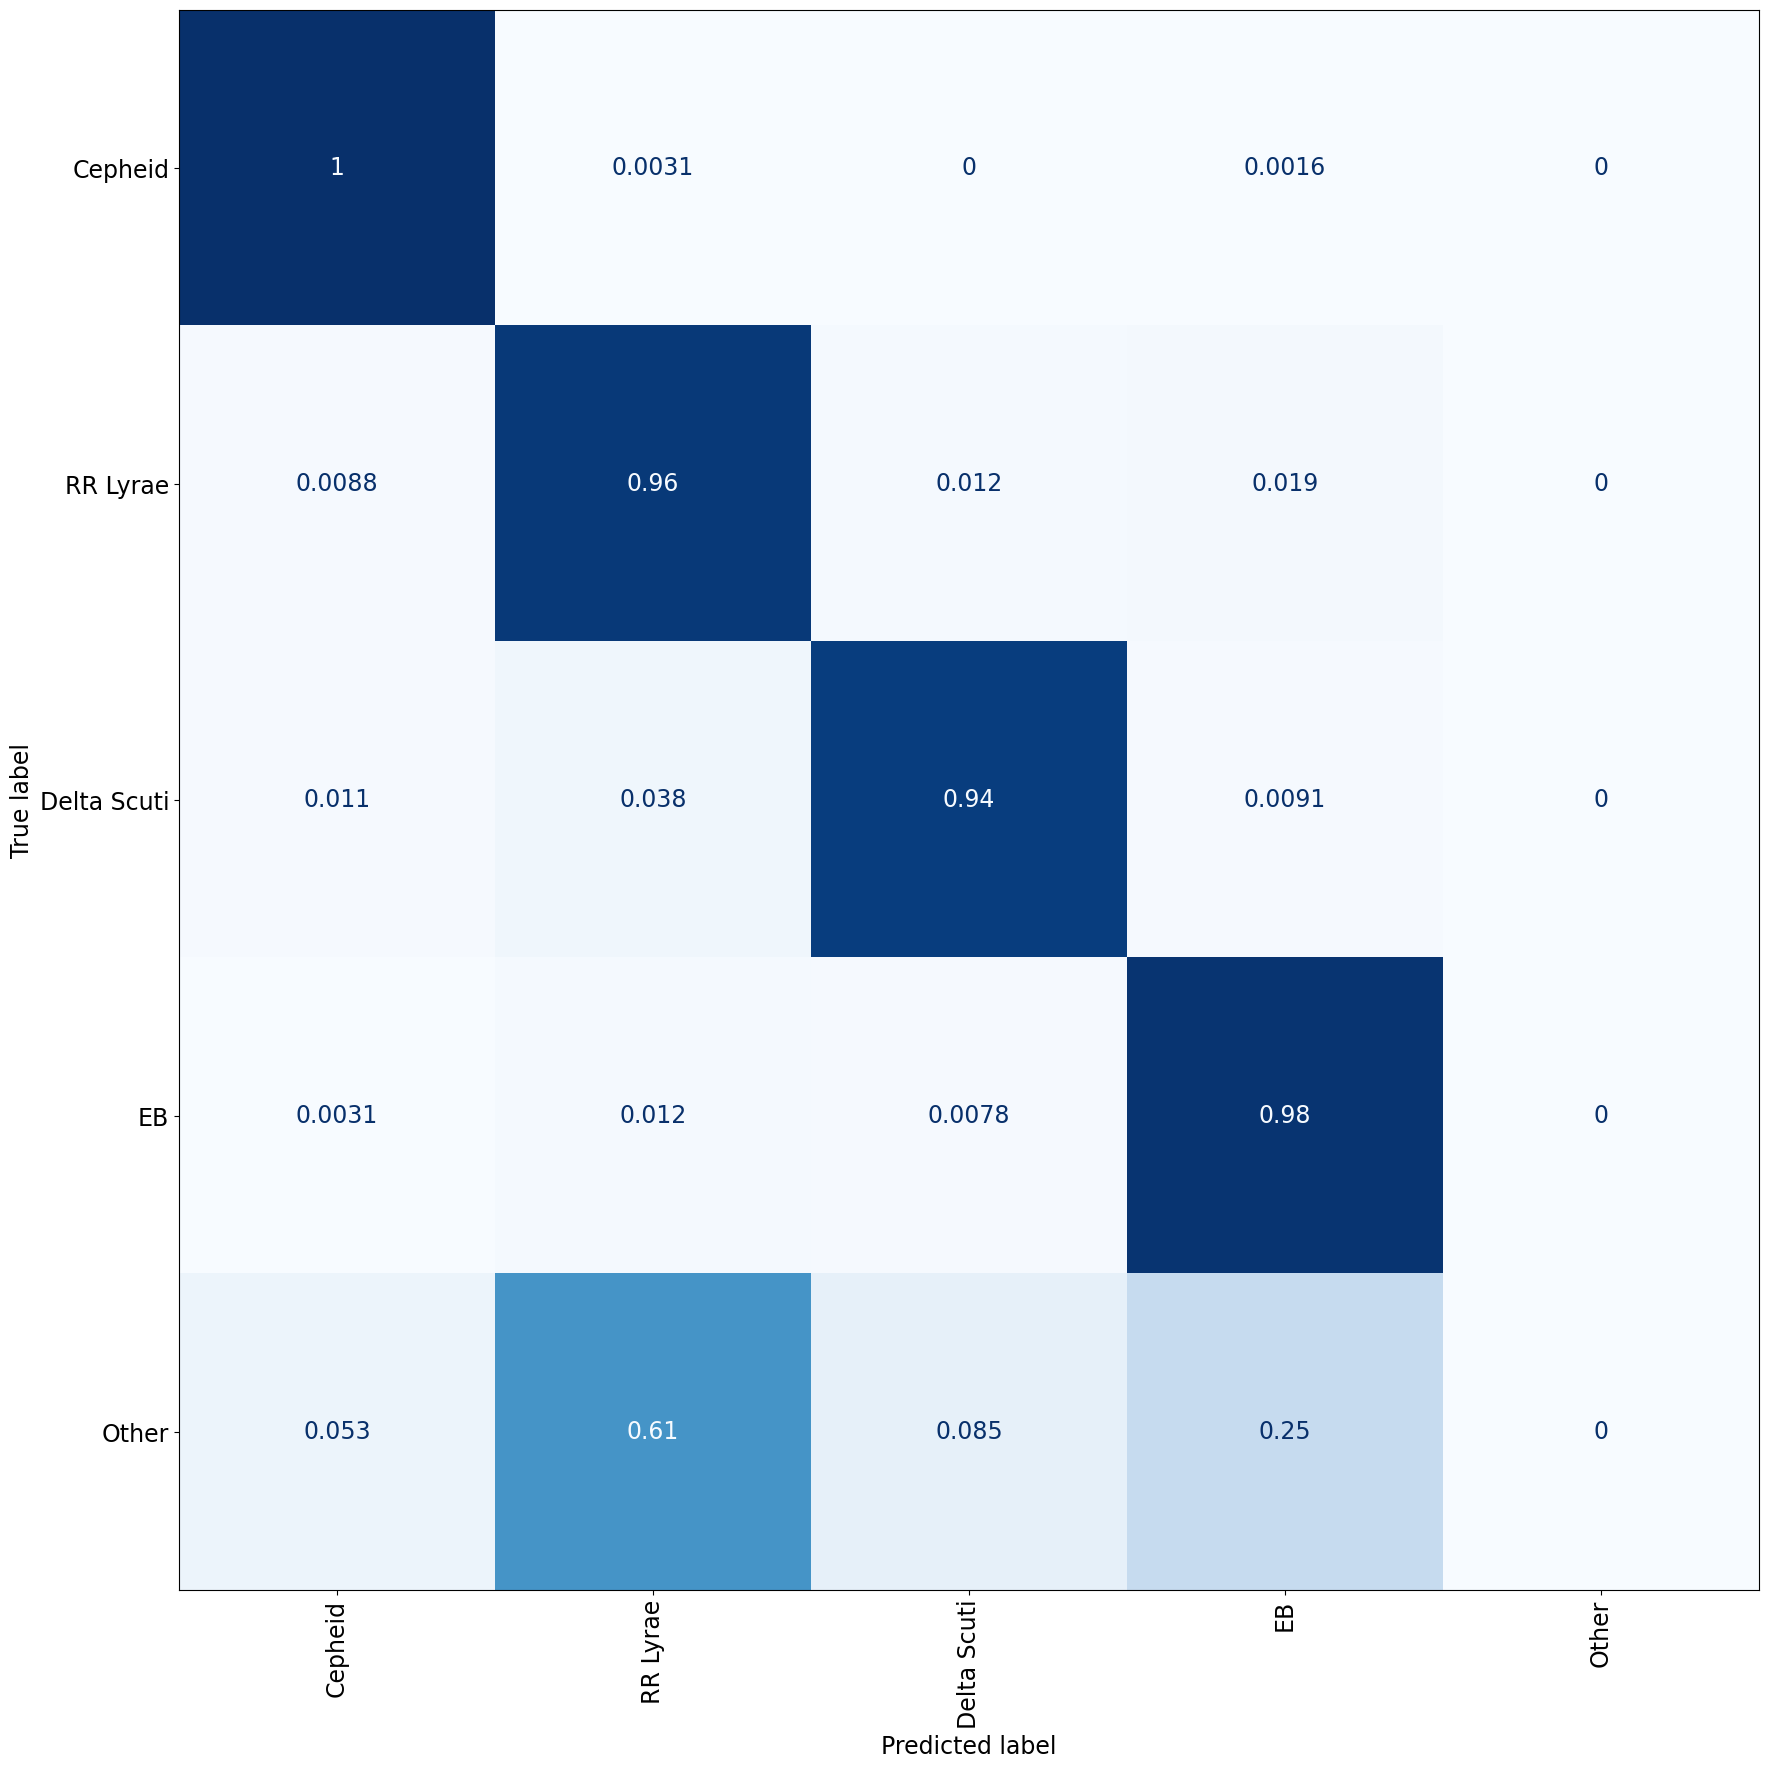

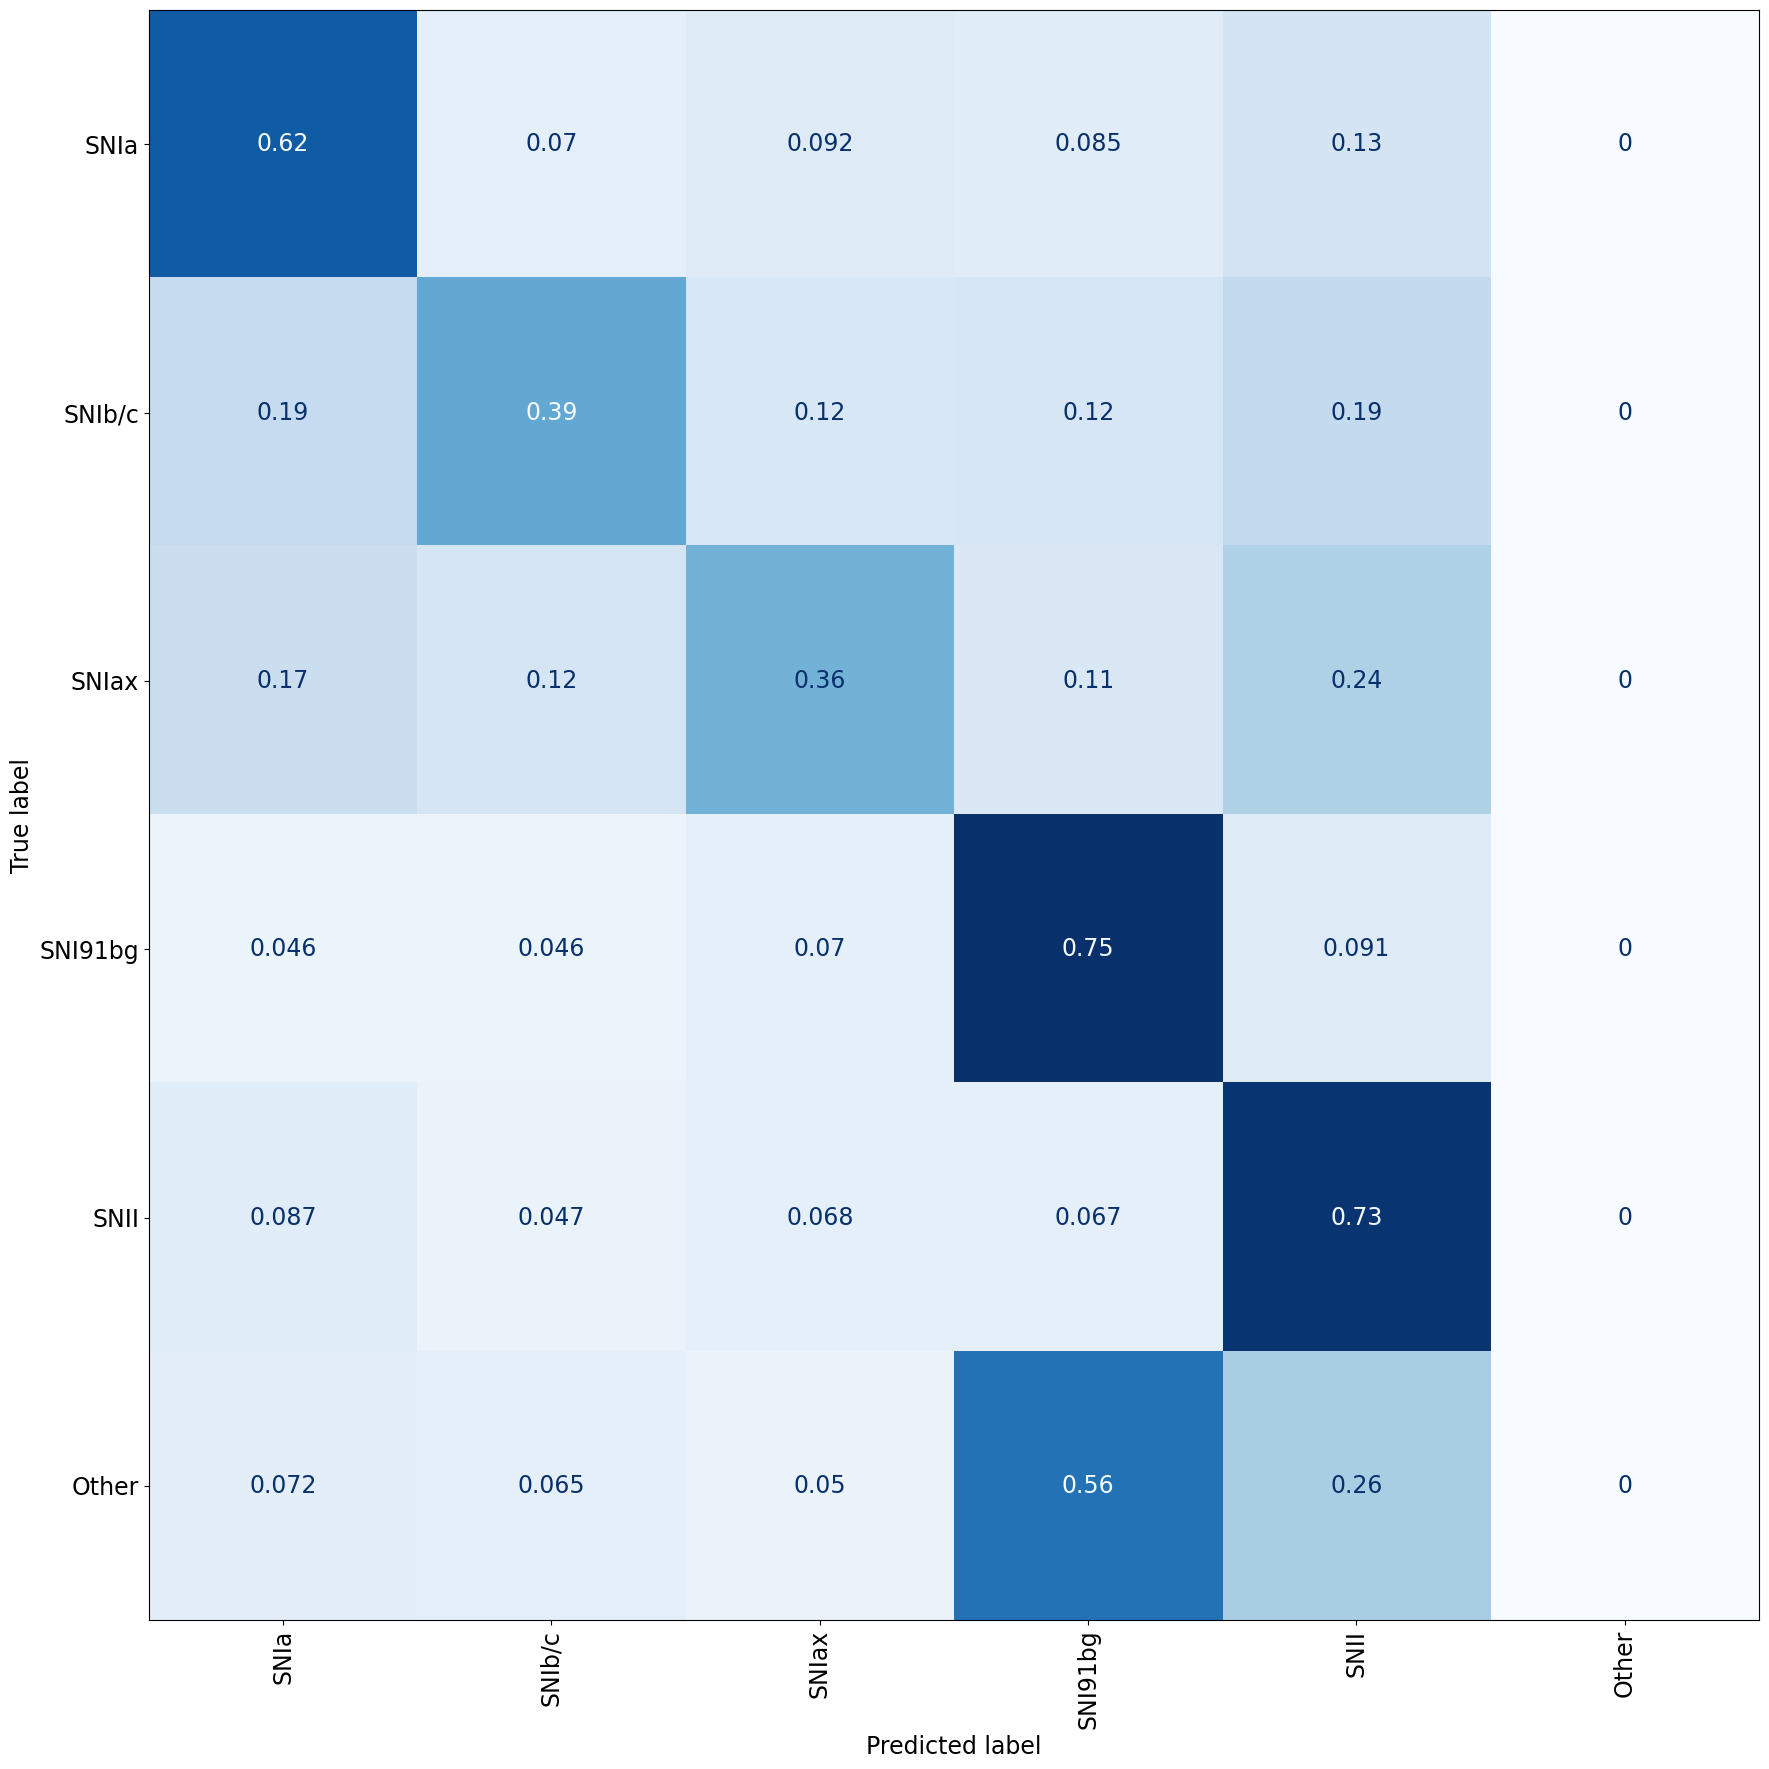

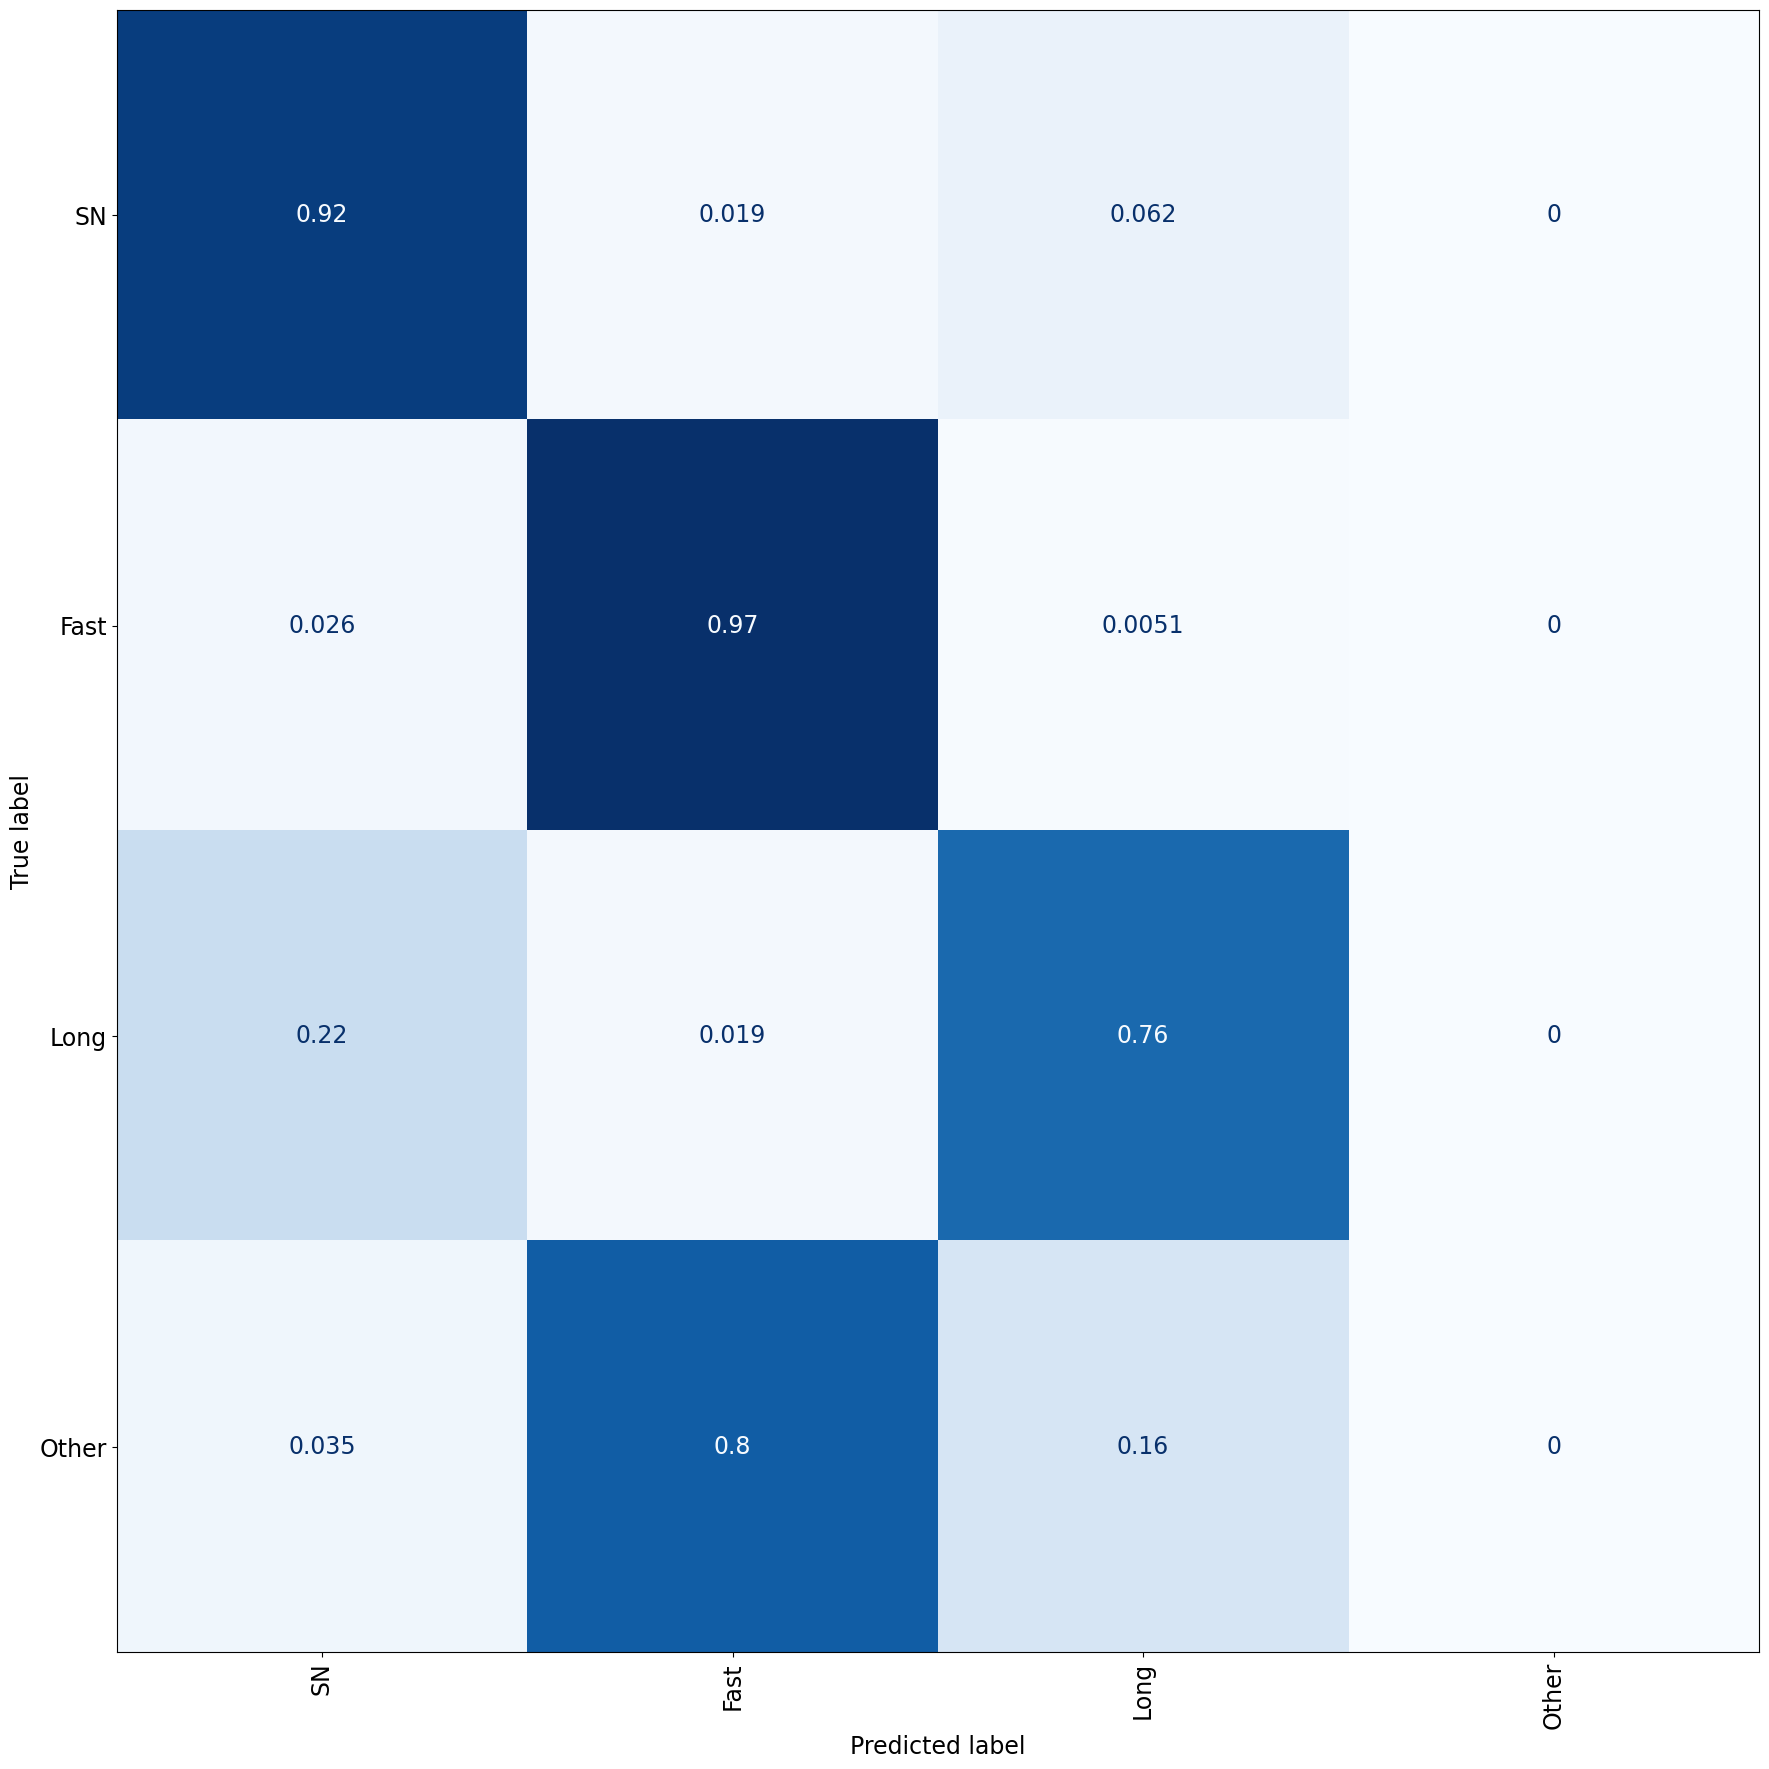

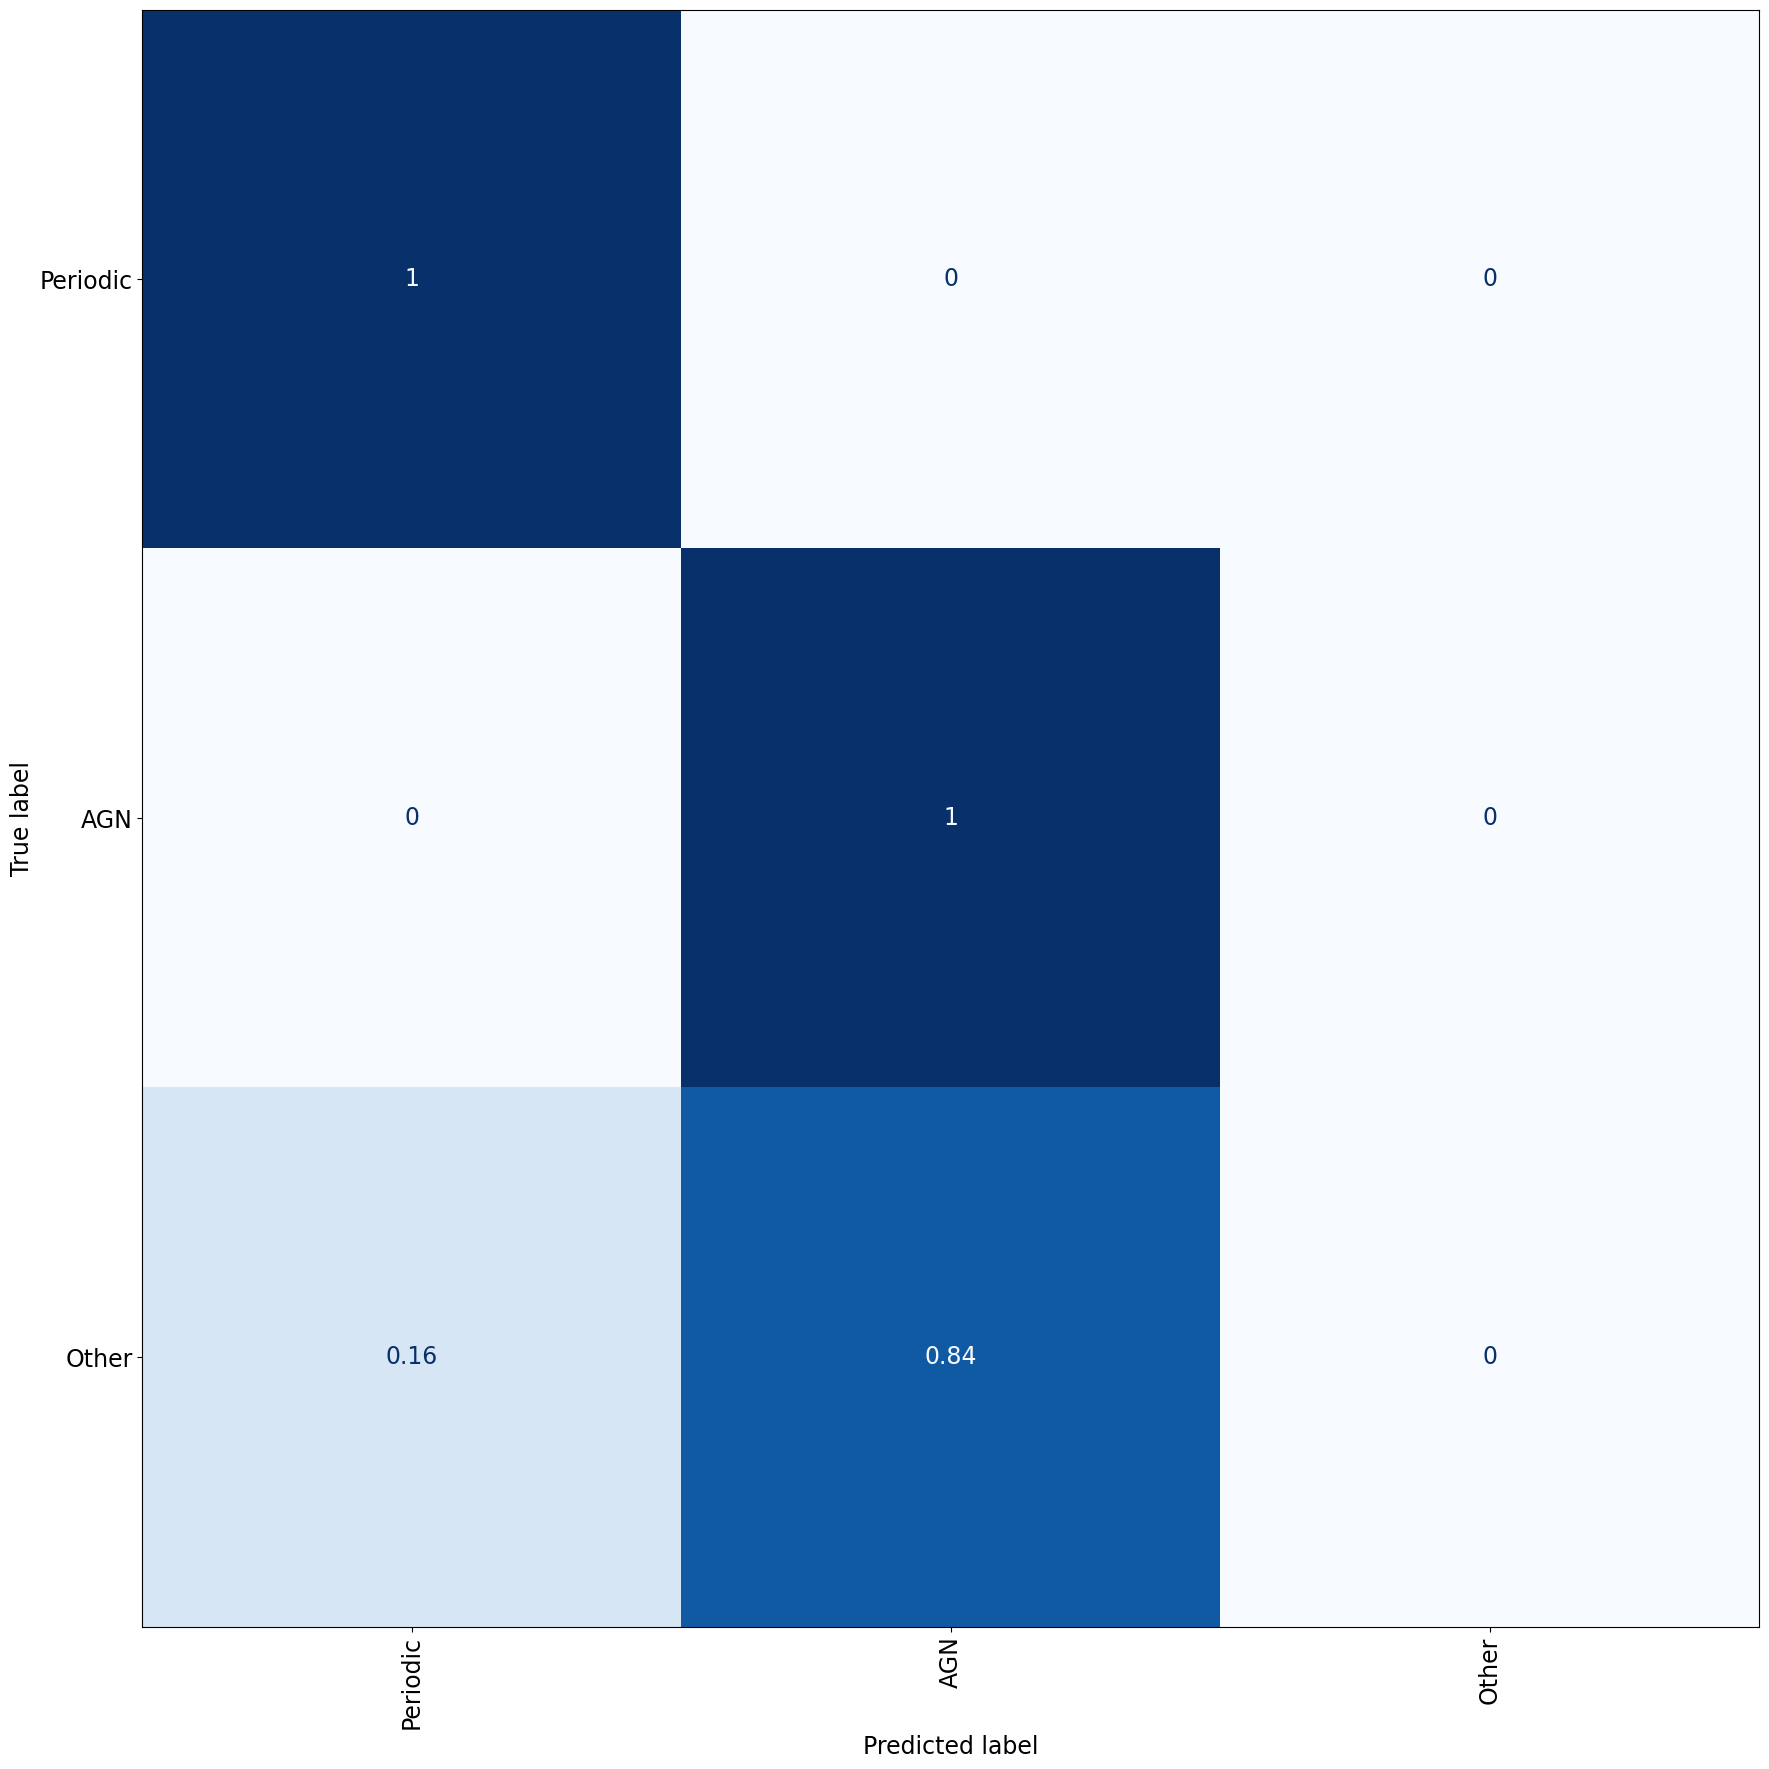

Running inference for 50% light curves...
332/332 [==============================] - 2s 6ms/step
For 50% of the light curve, these are the statistics


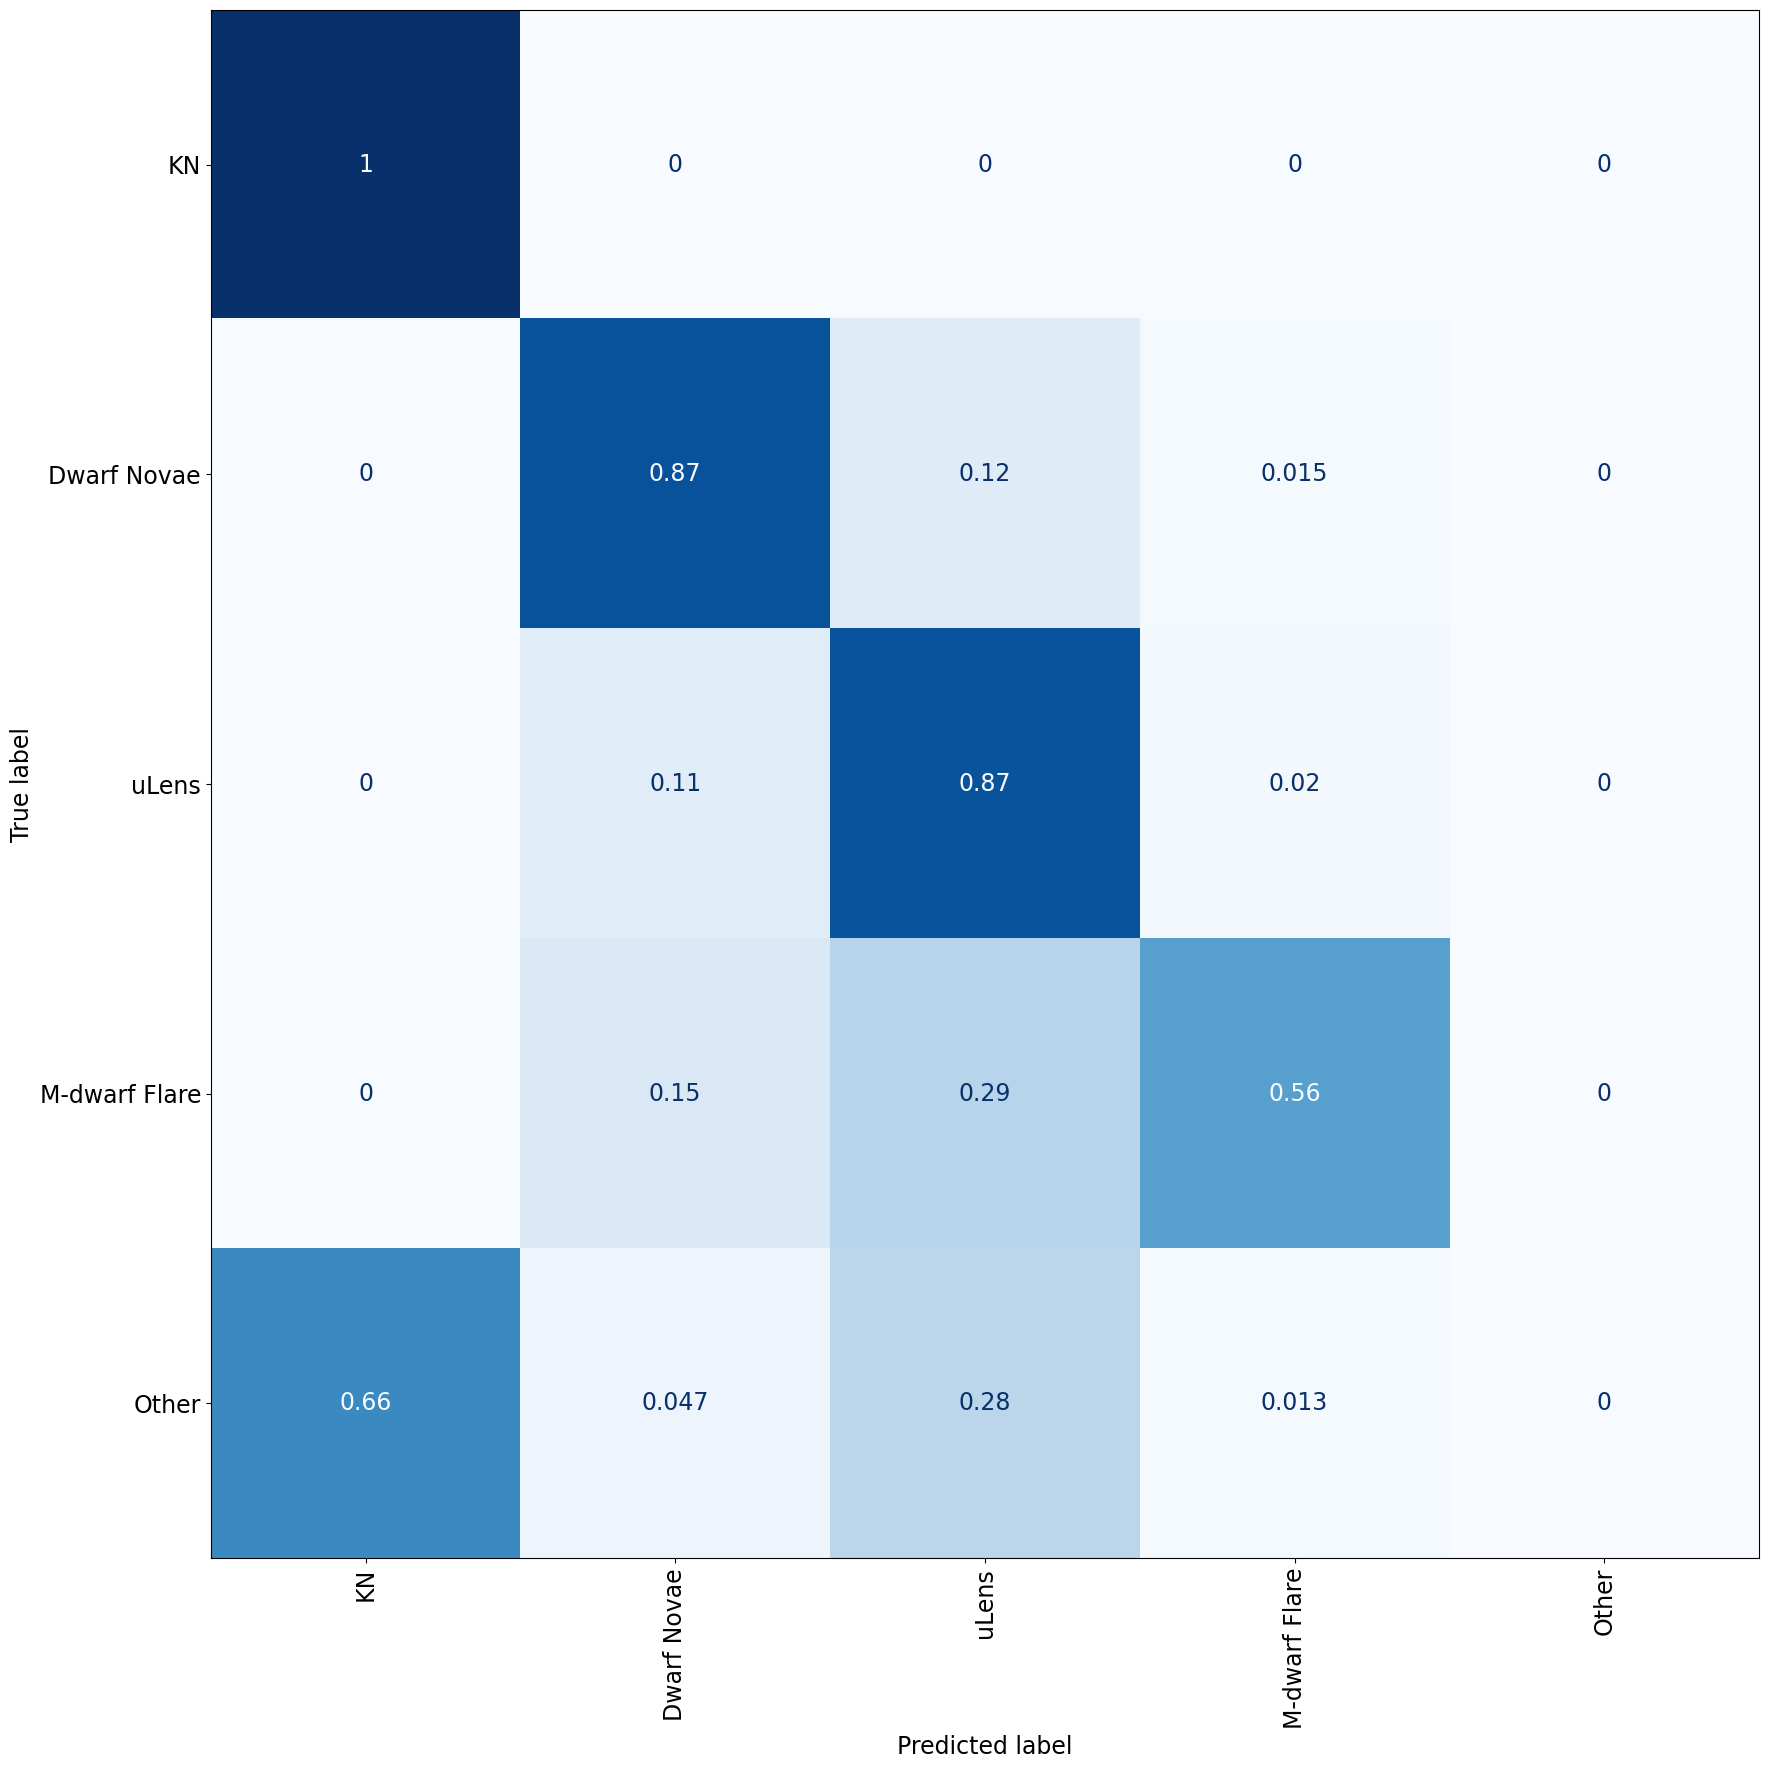

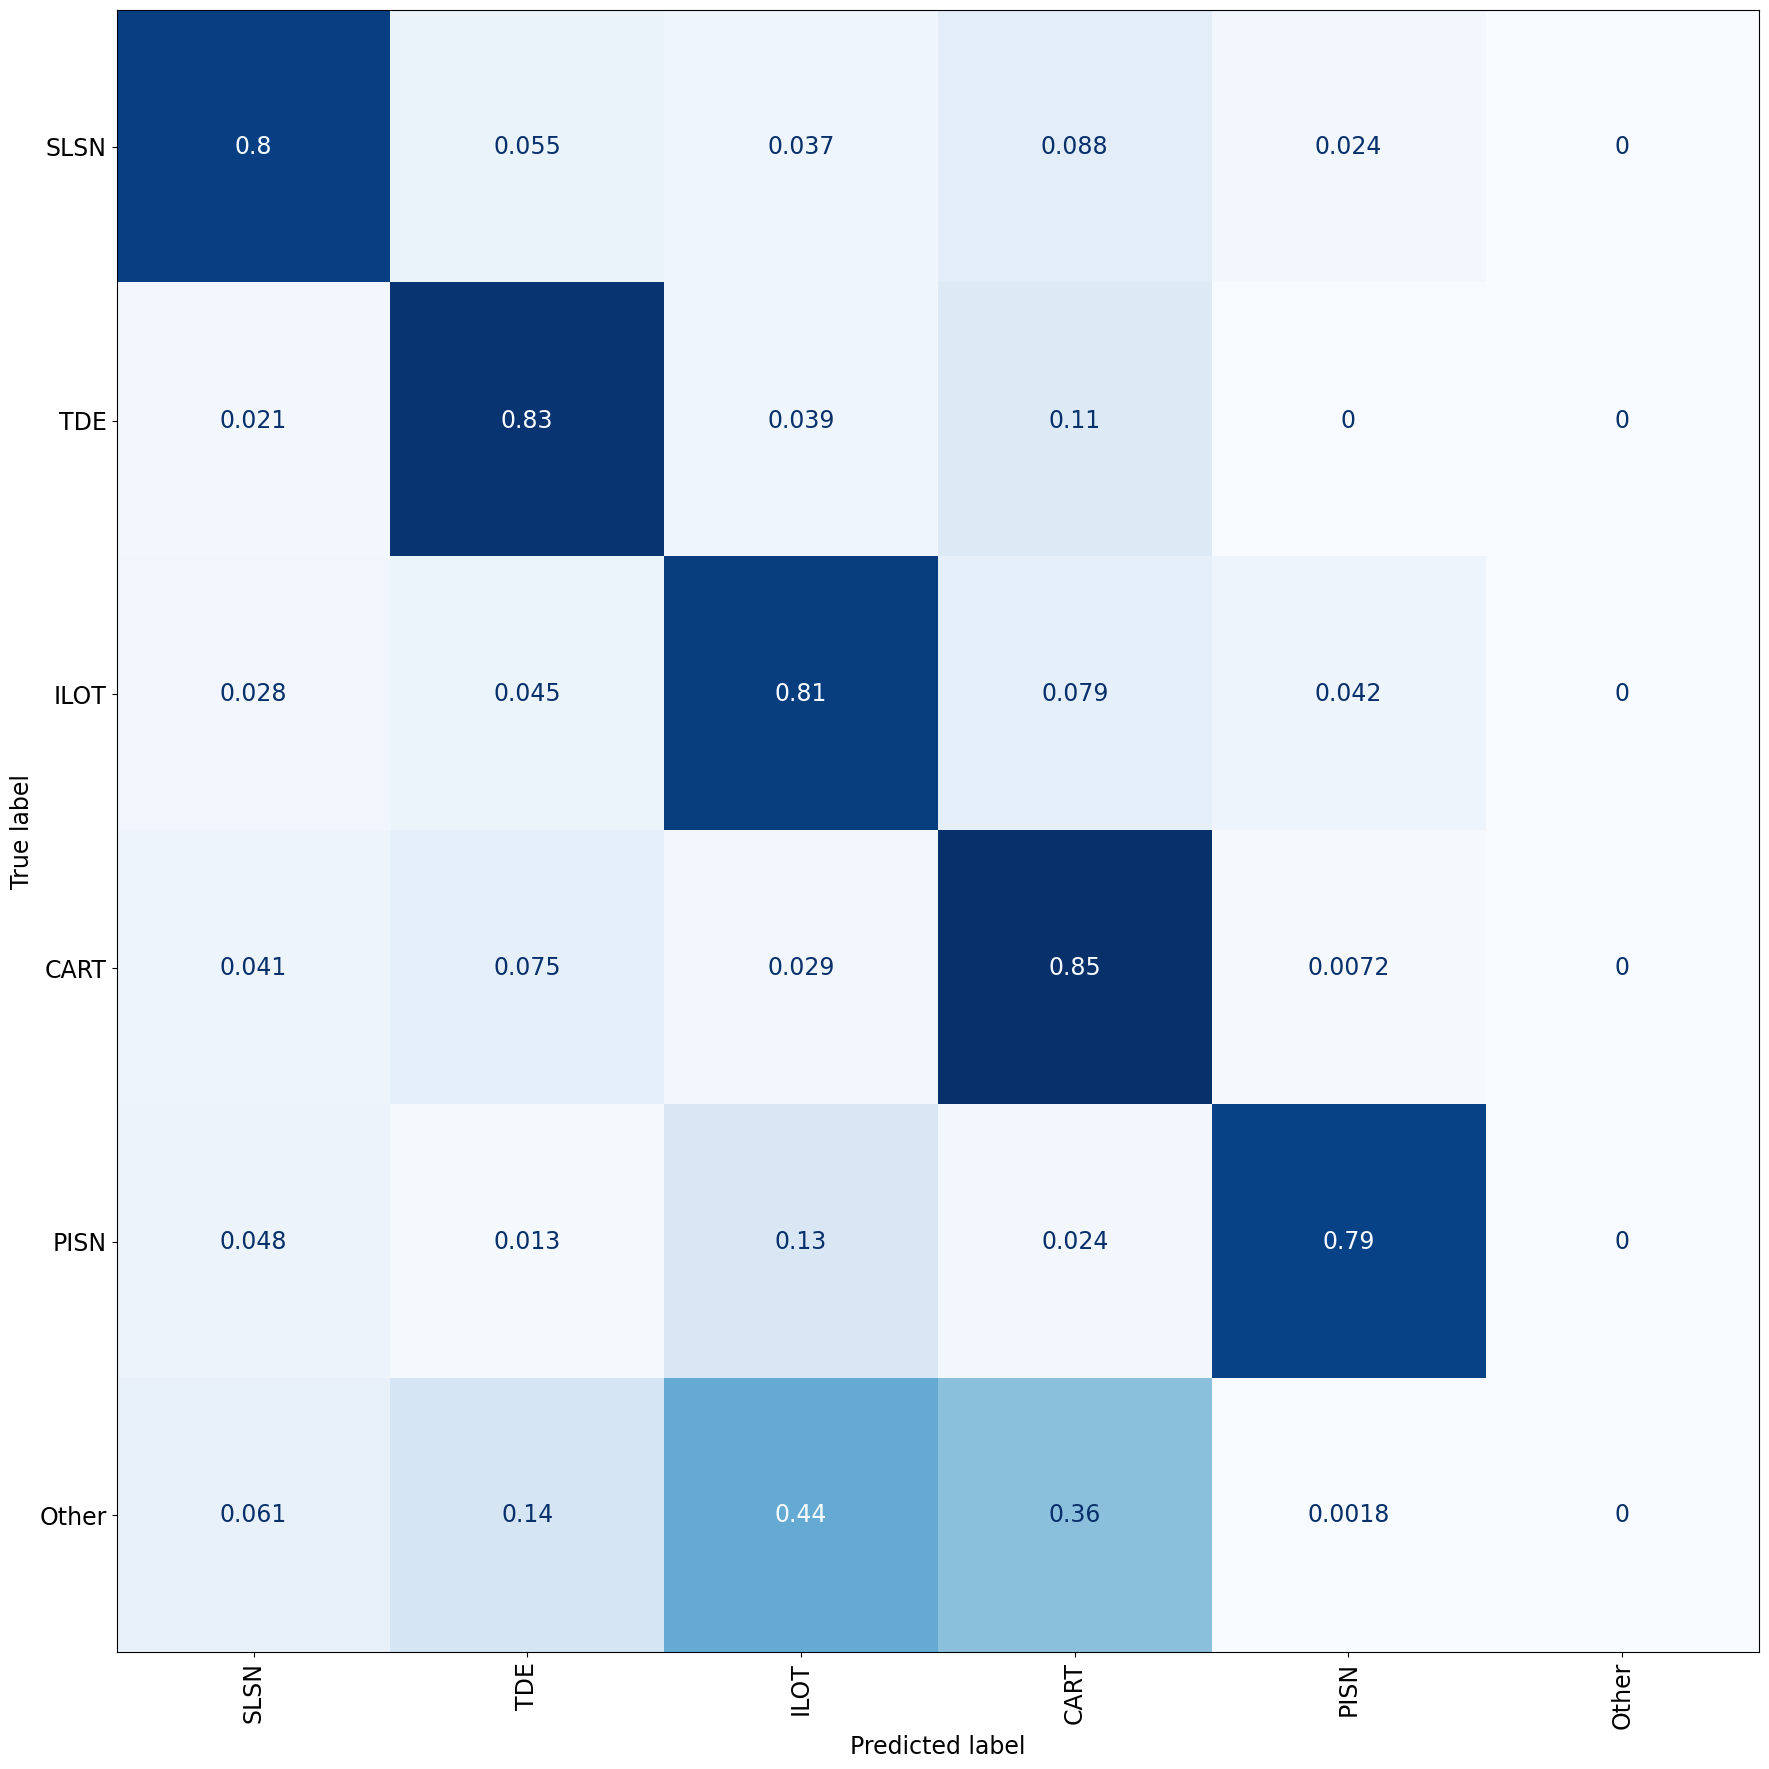

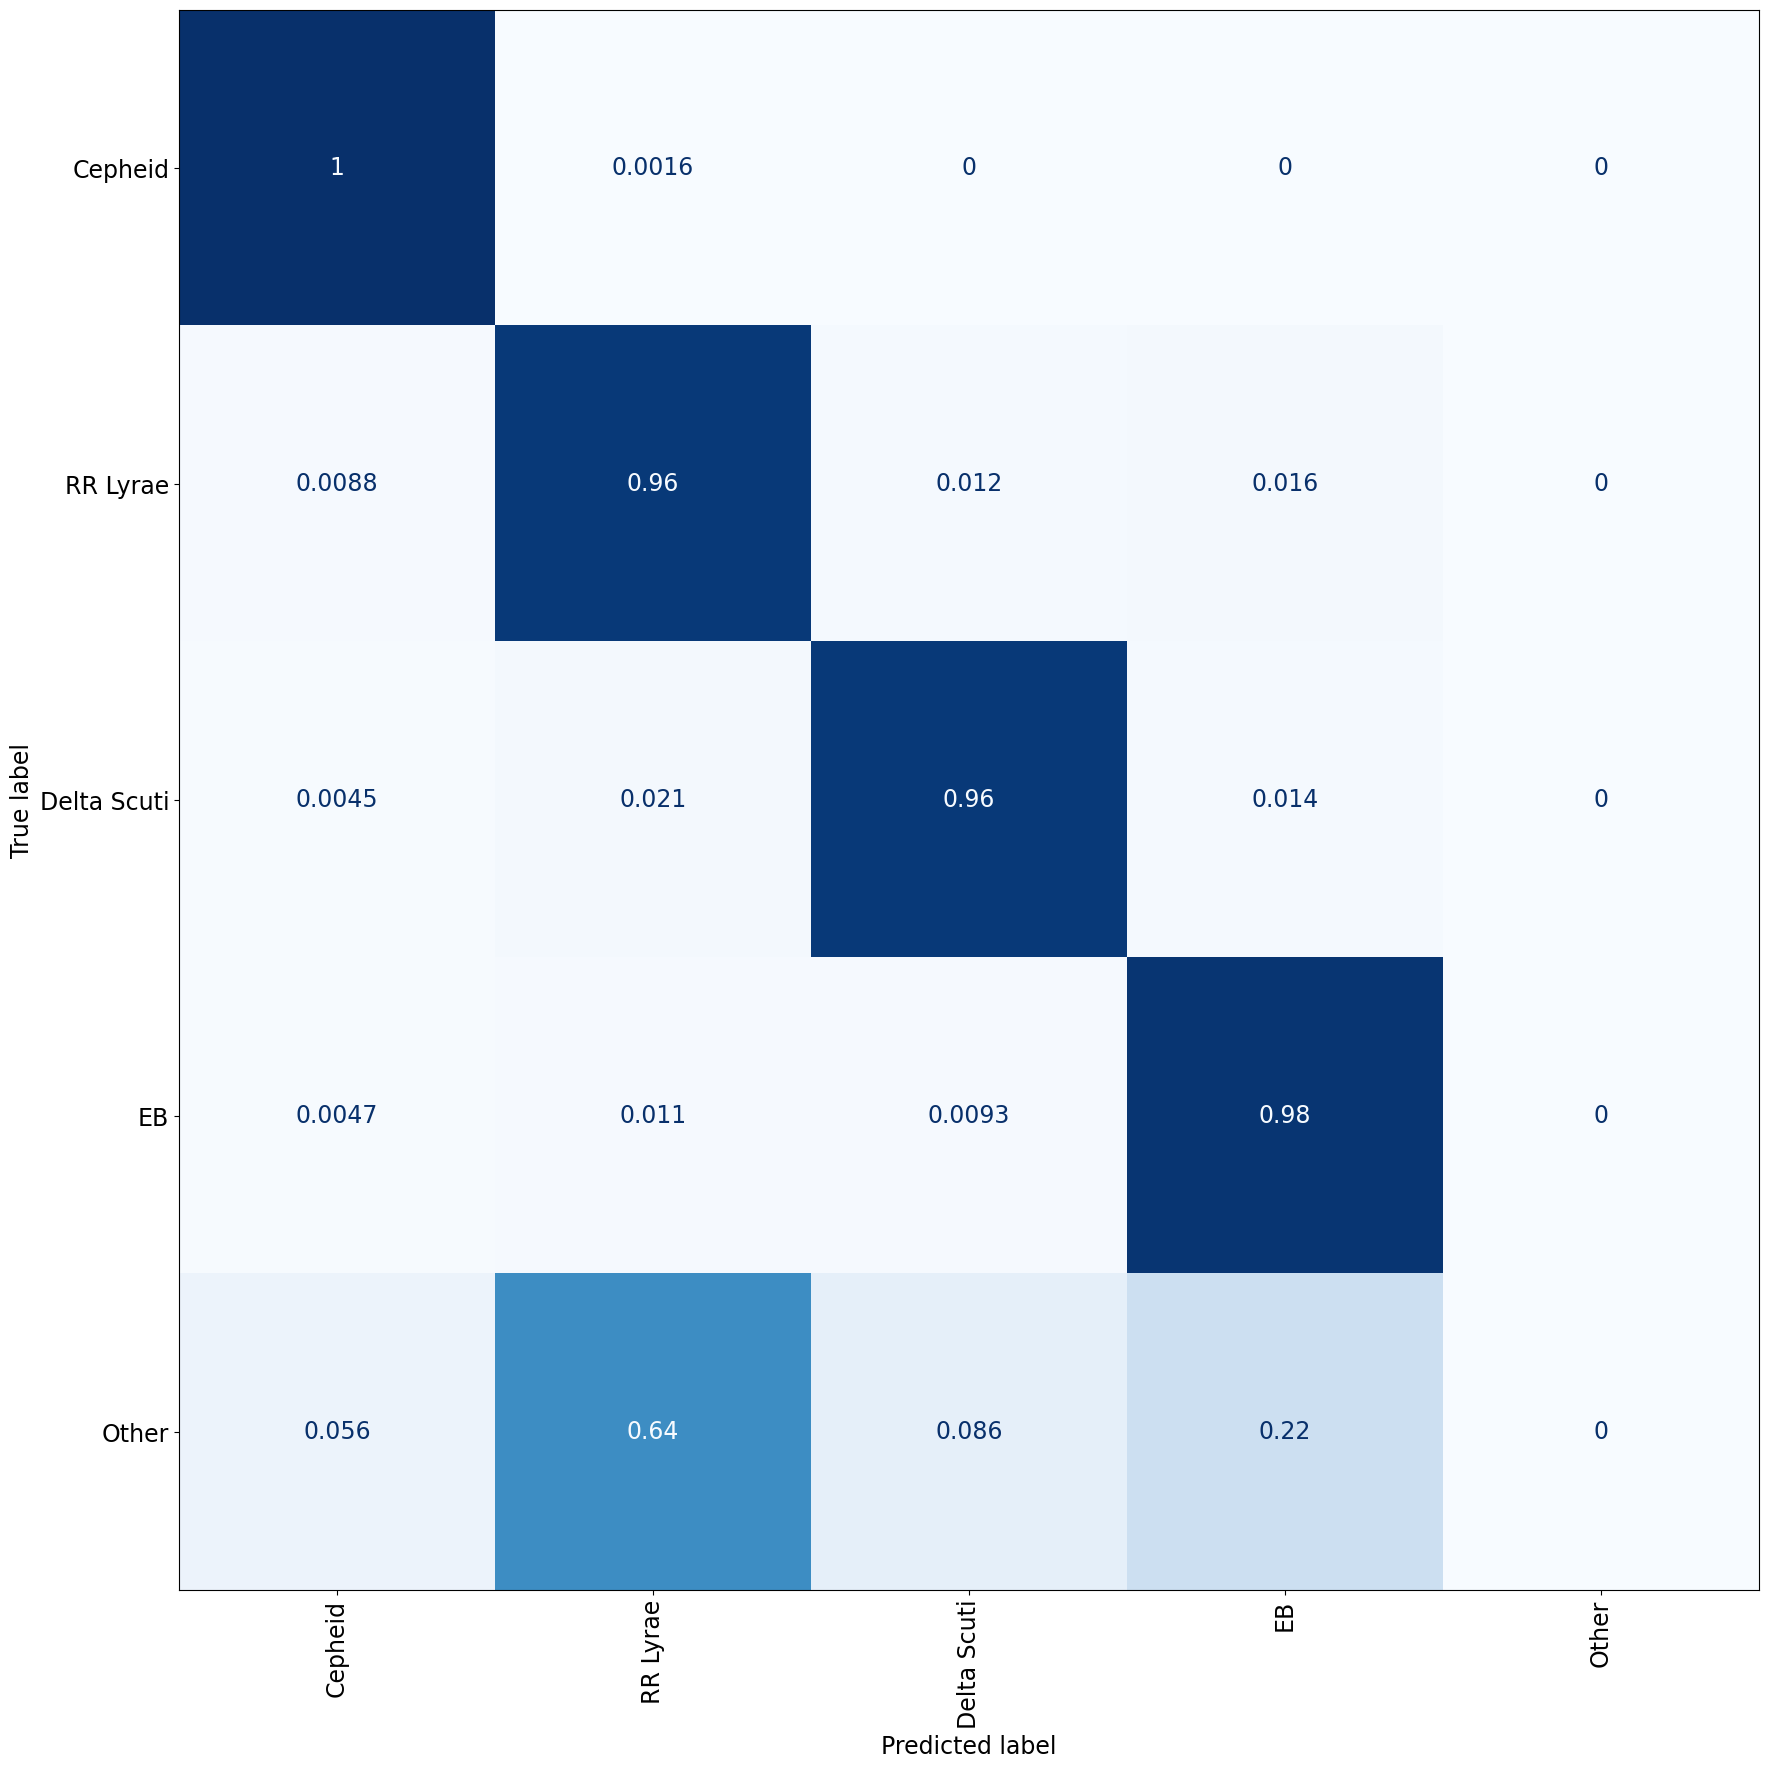

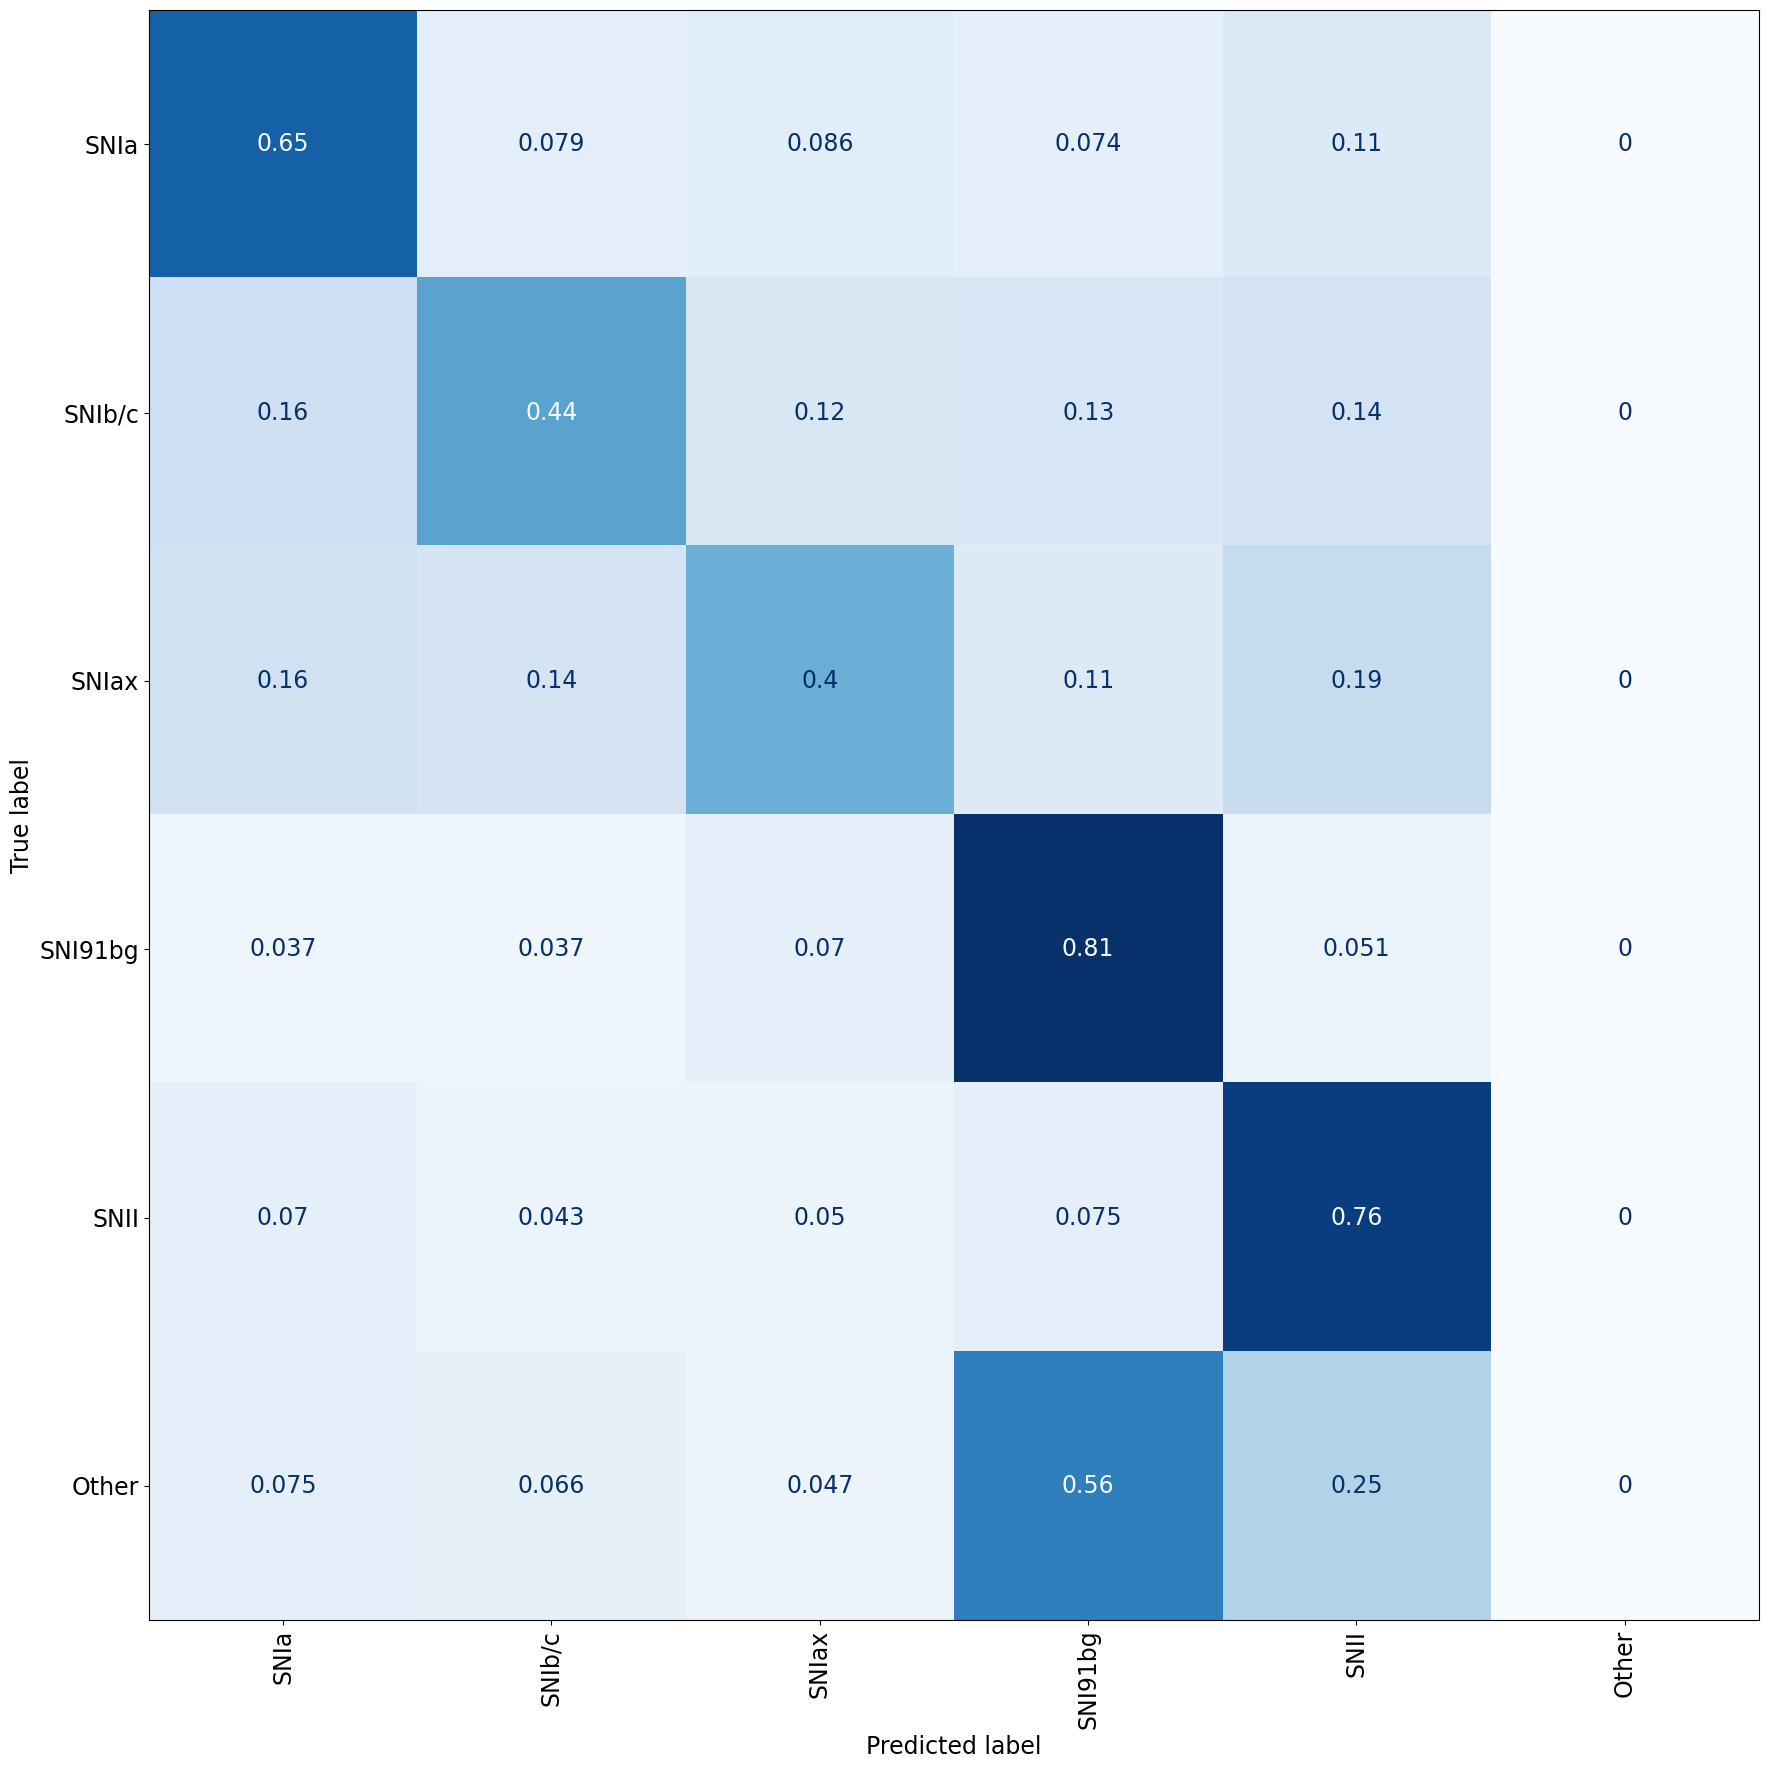

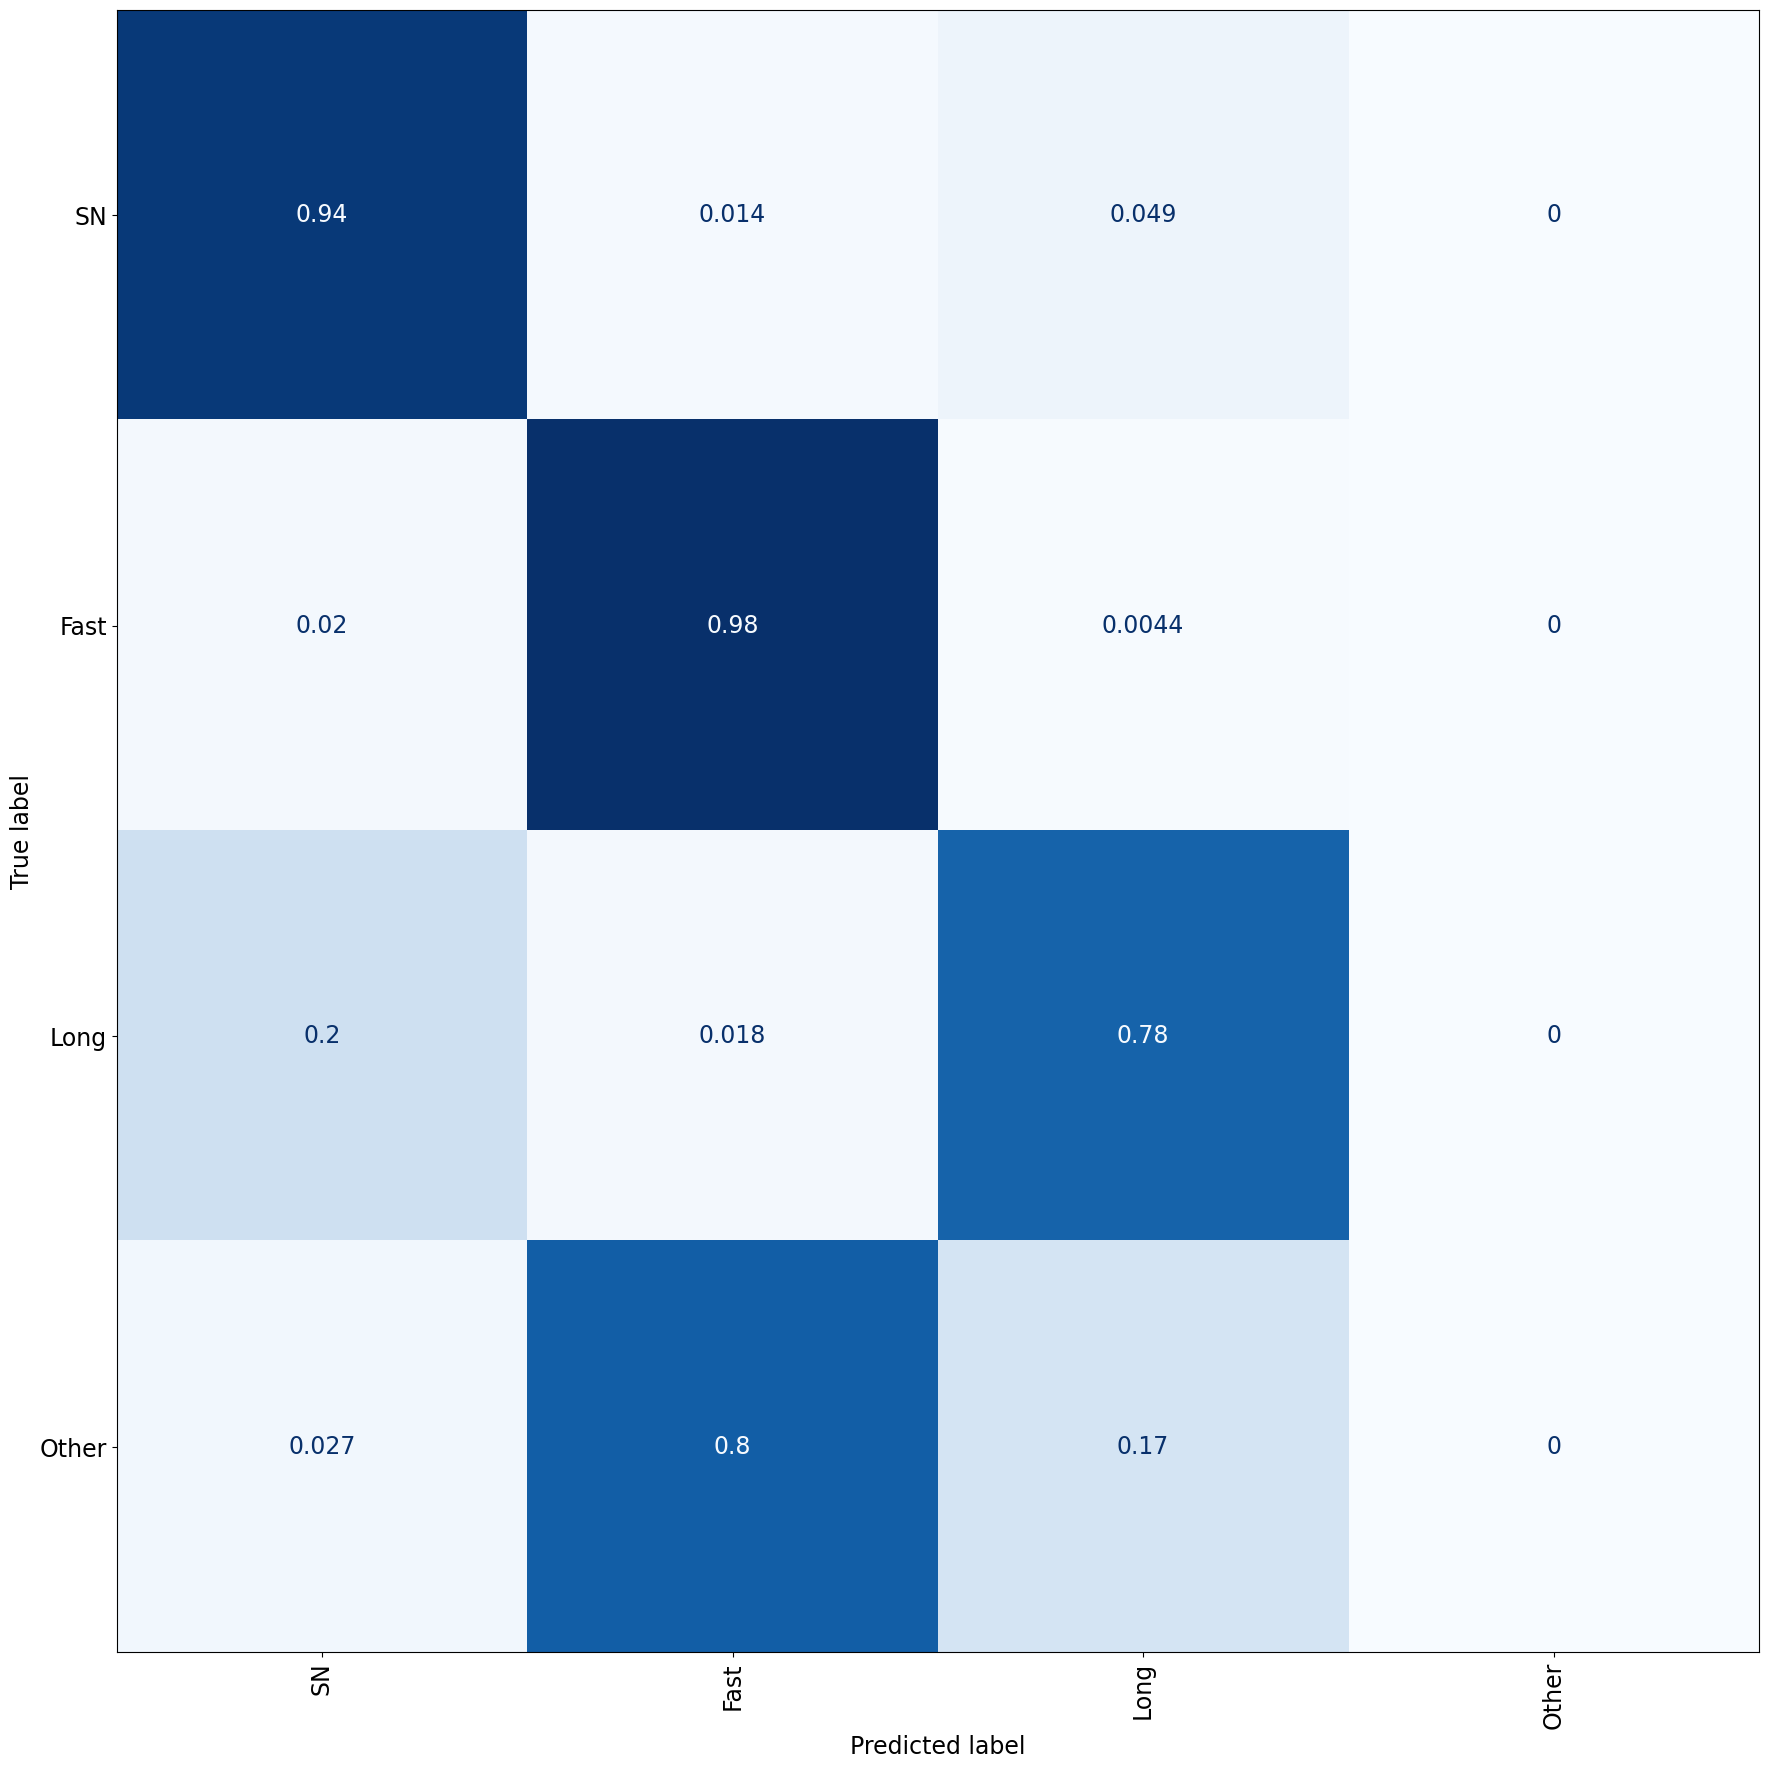

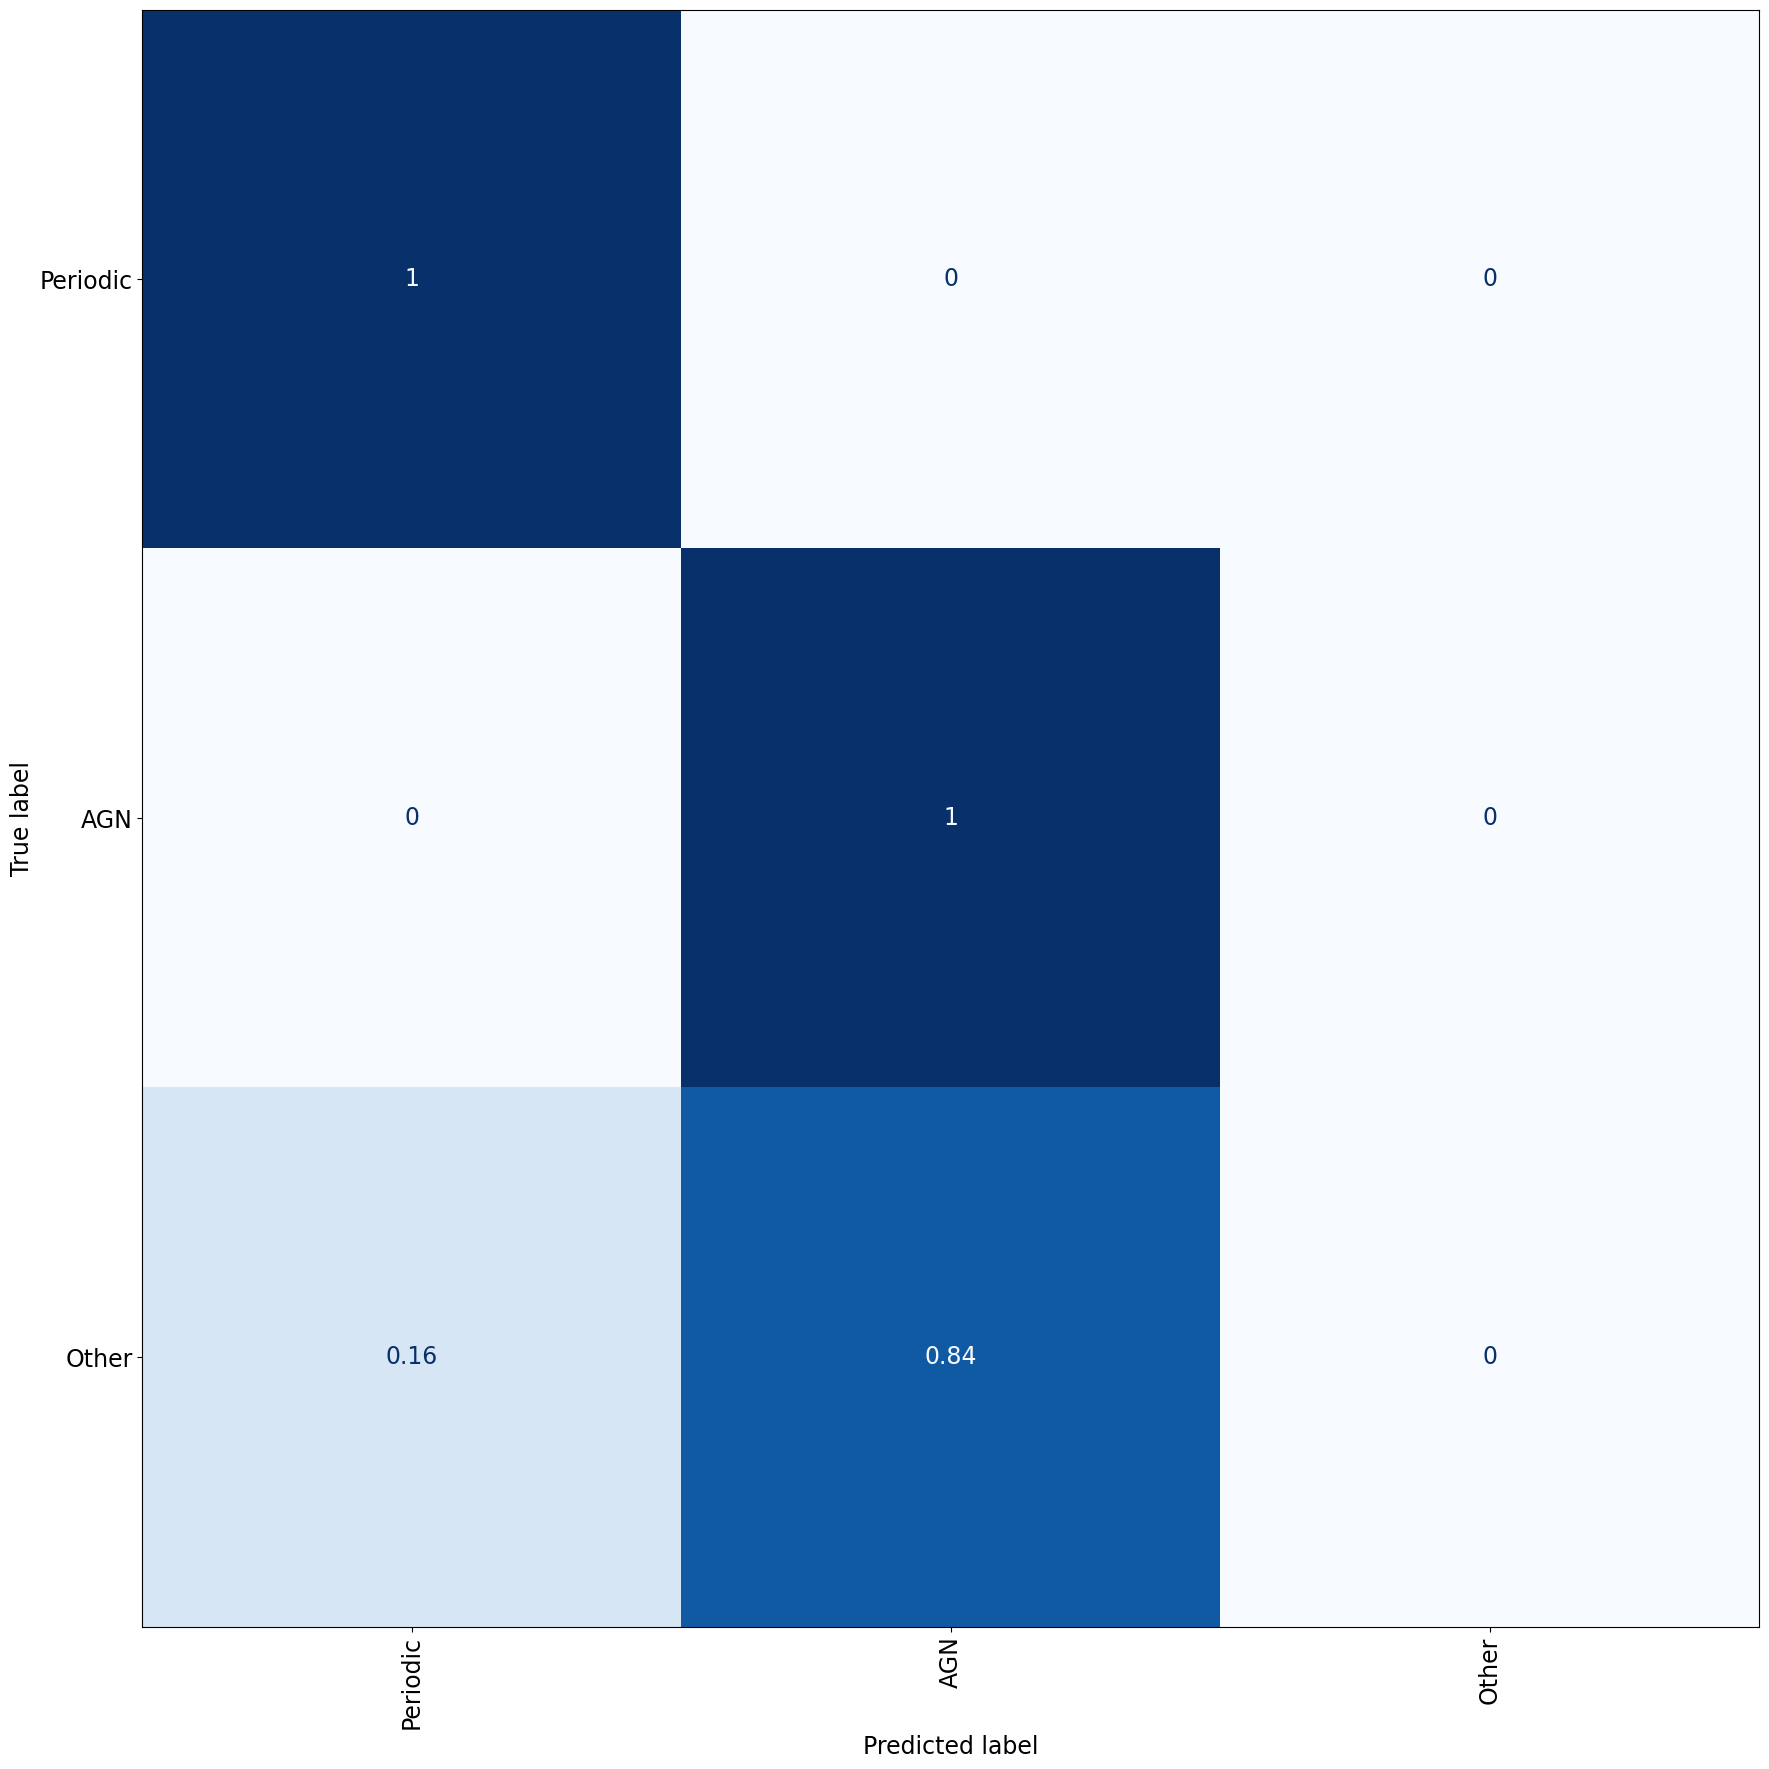

Running inference for 60% light curves...
332/332 [==============================] - 2s 6ms/step
For 60% of the light curve, these are the statistics


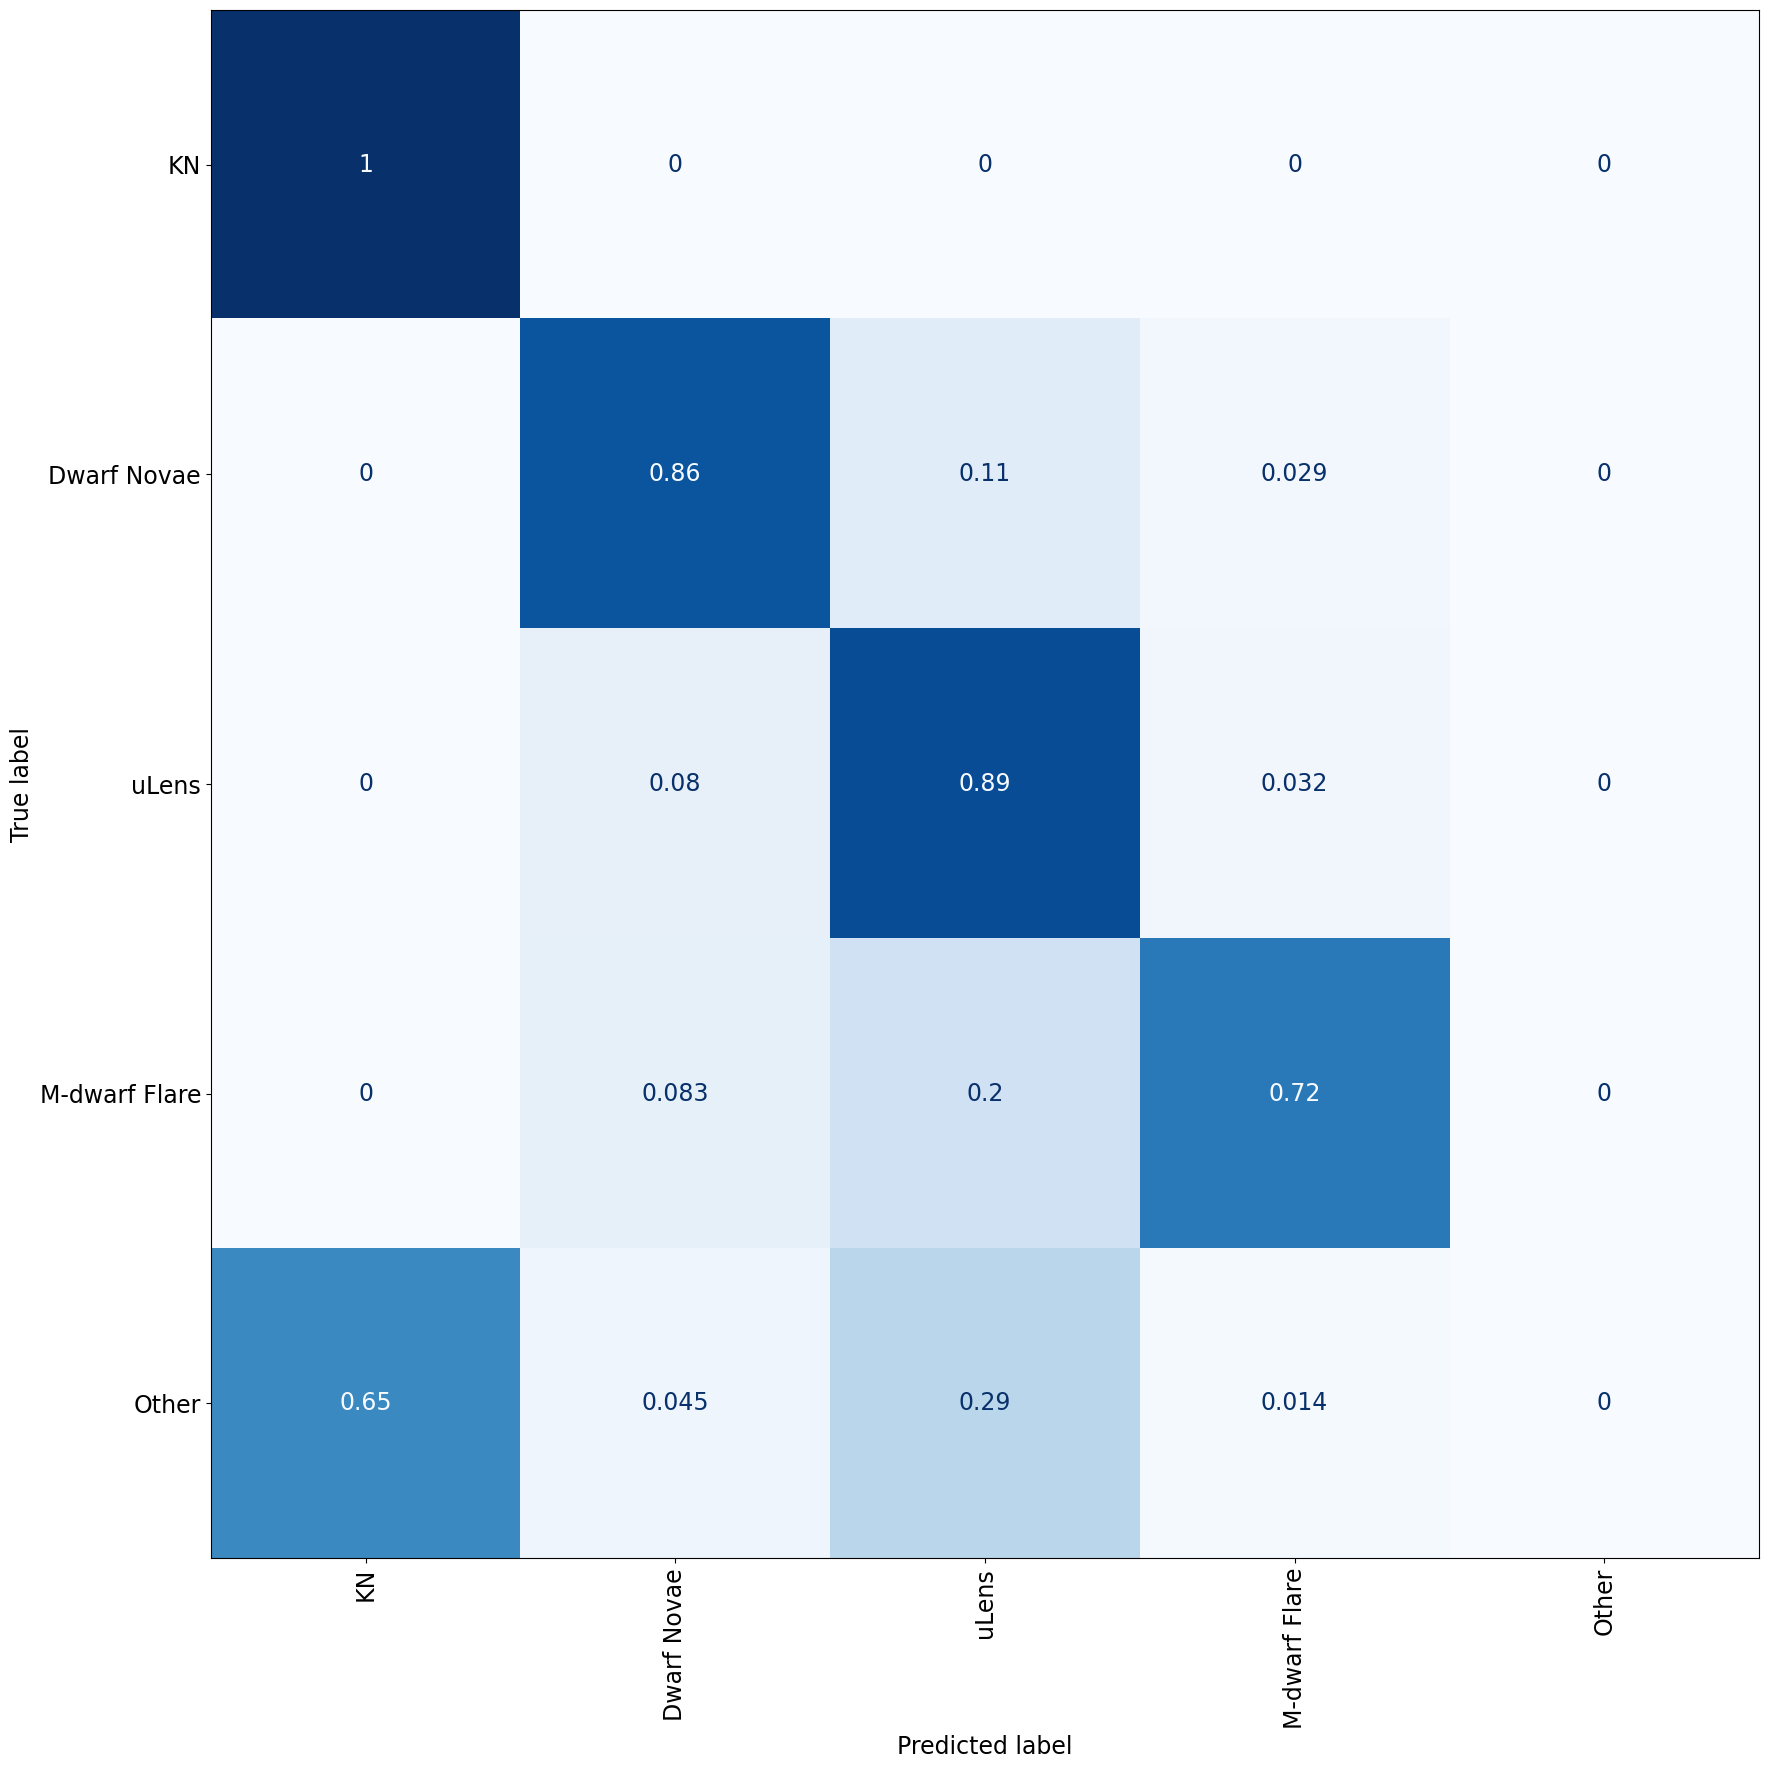

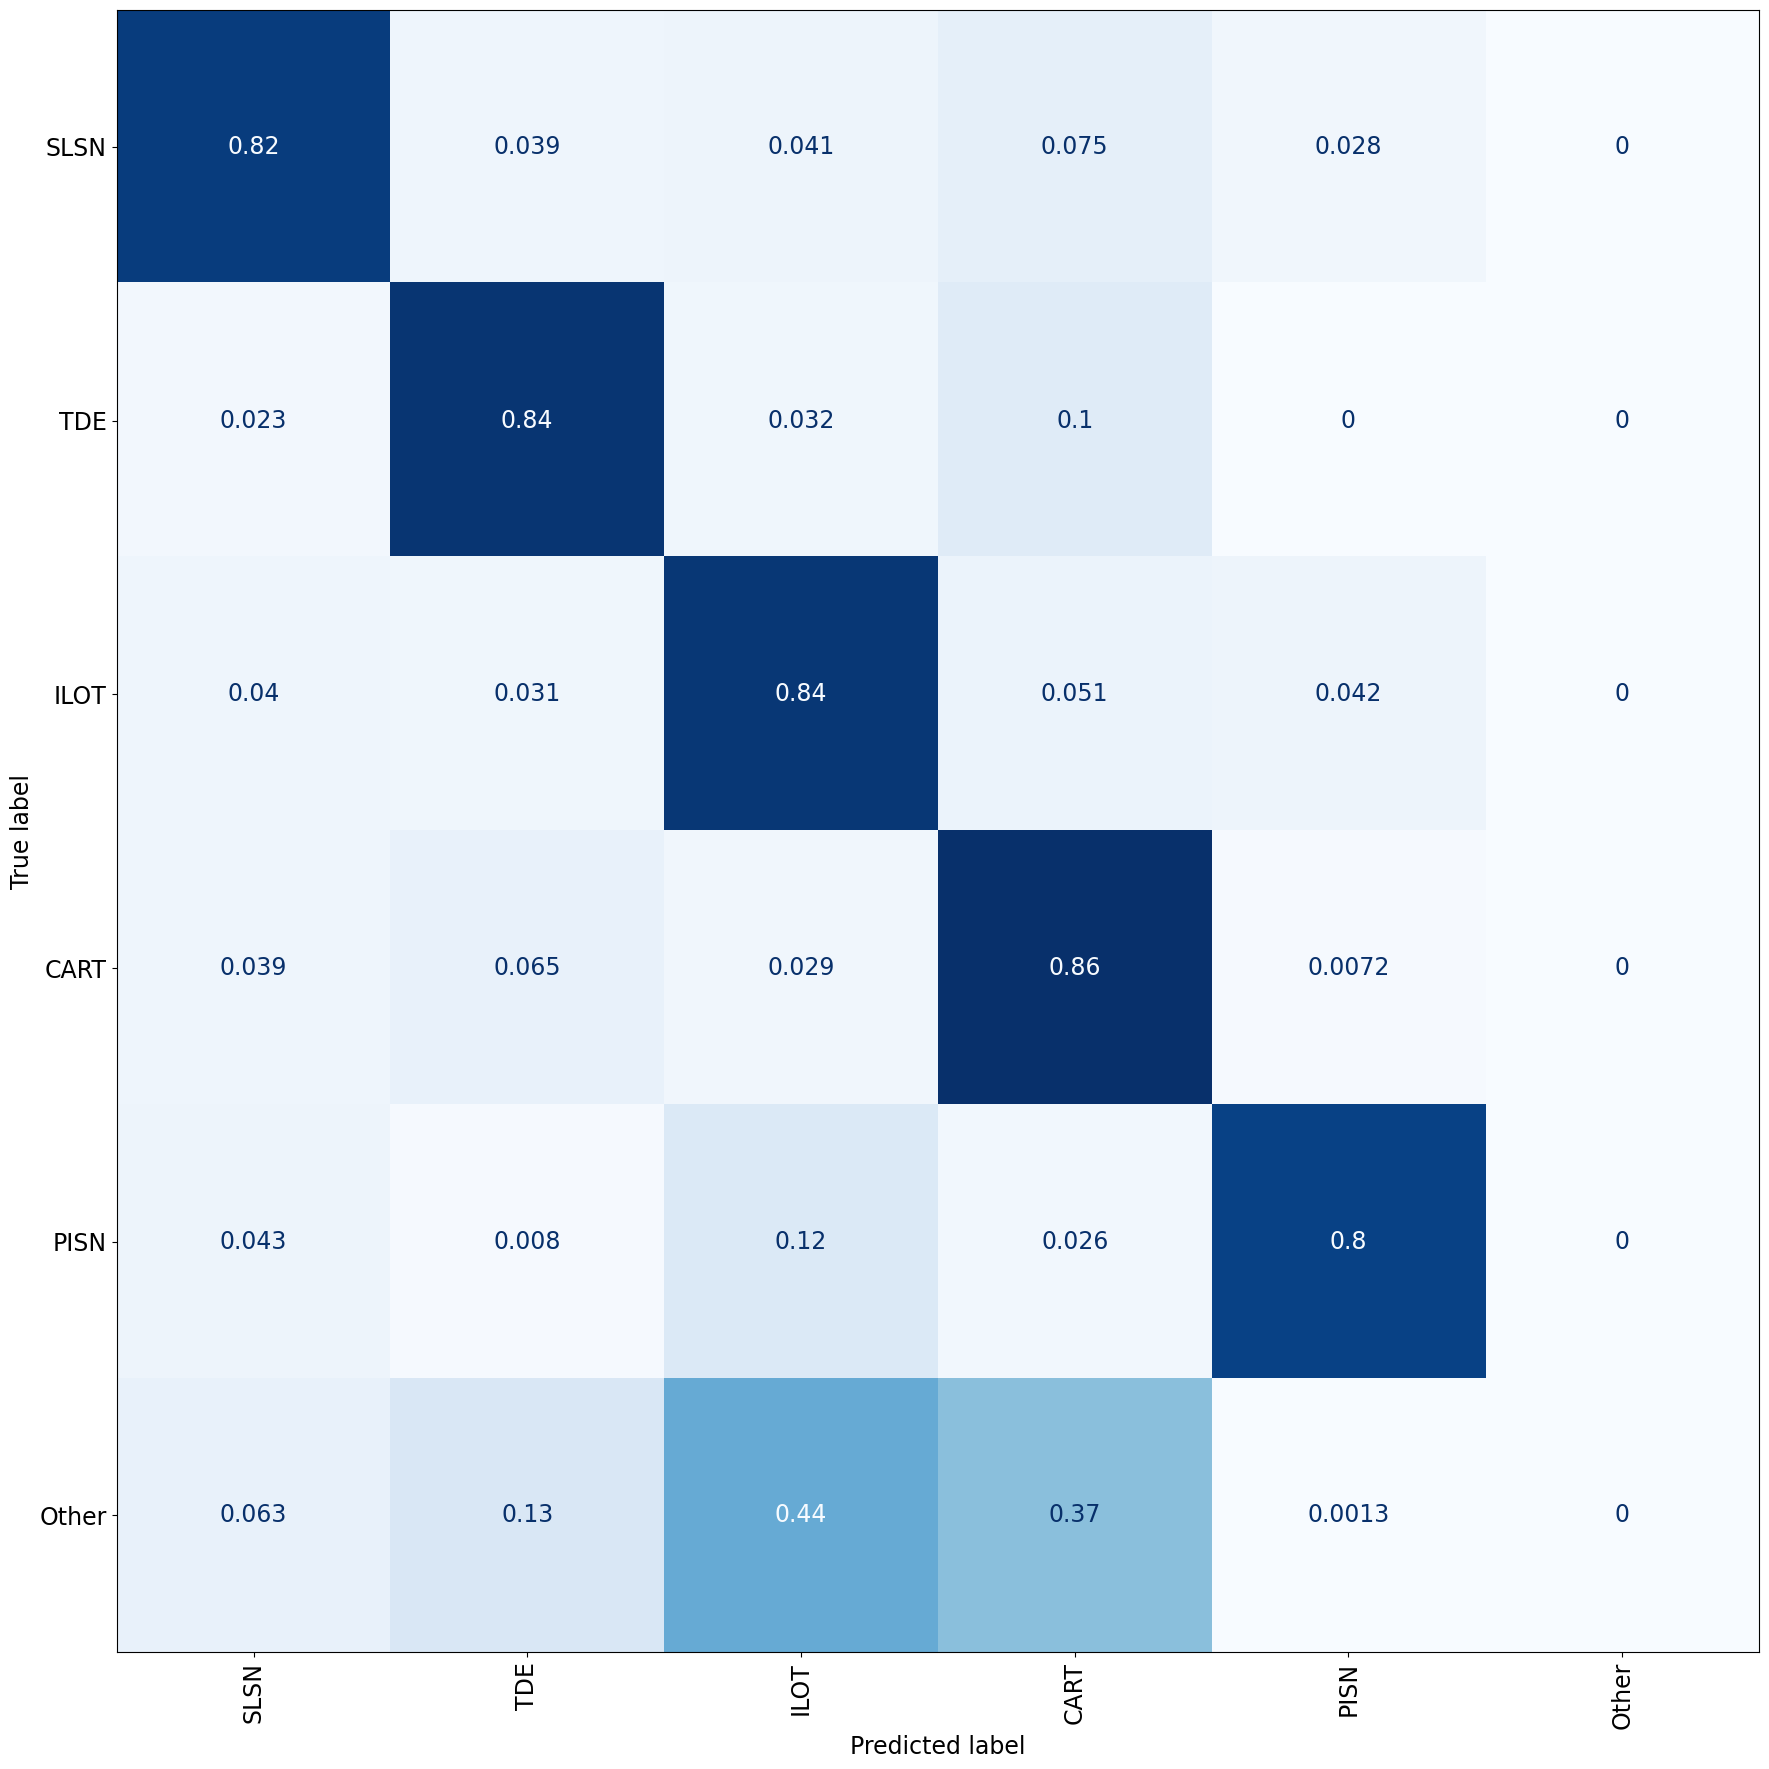

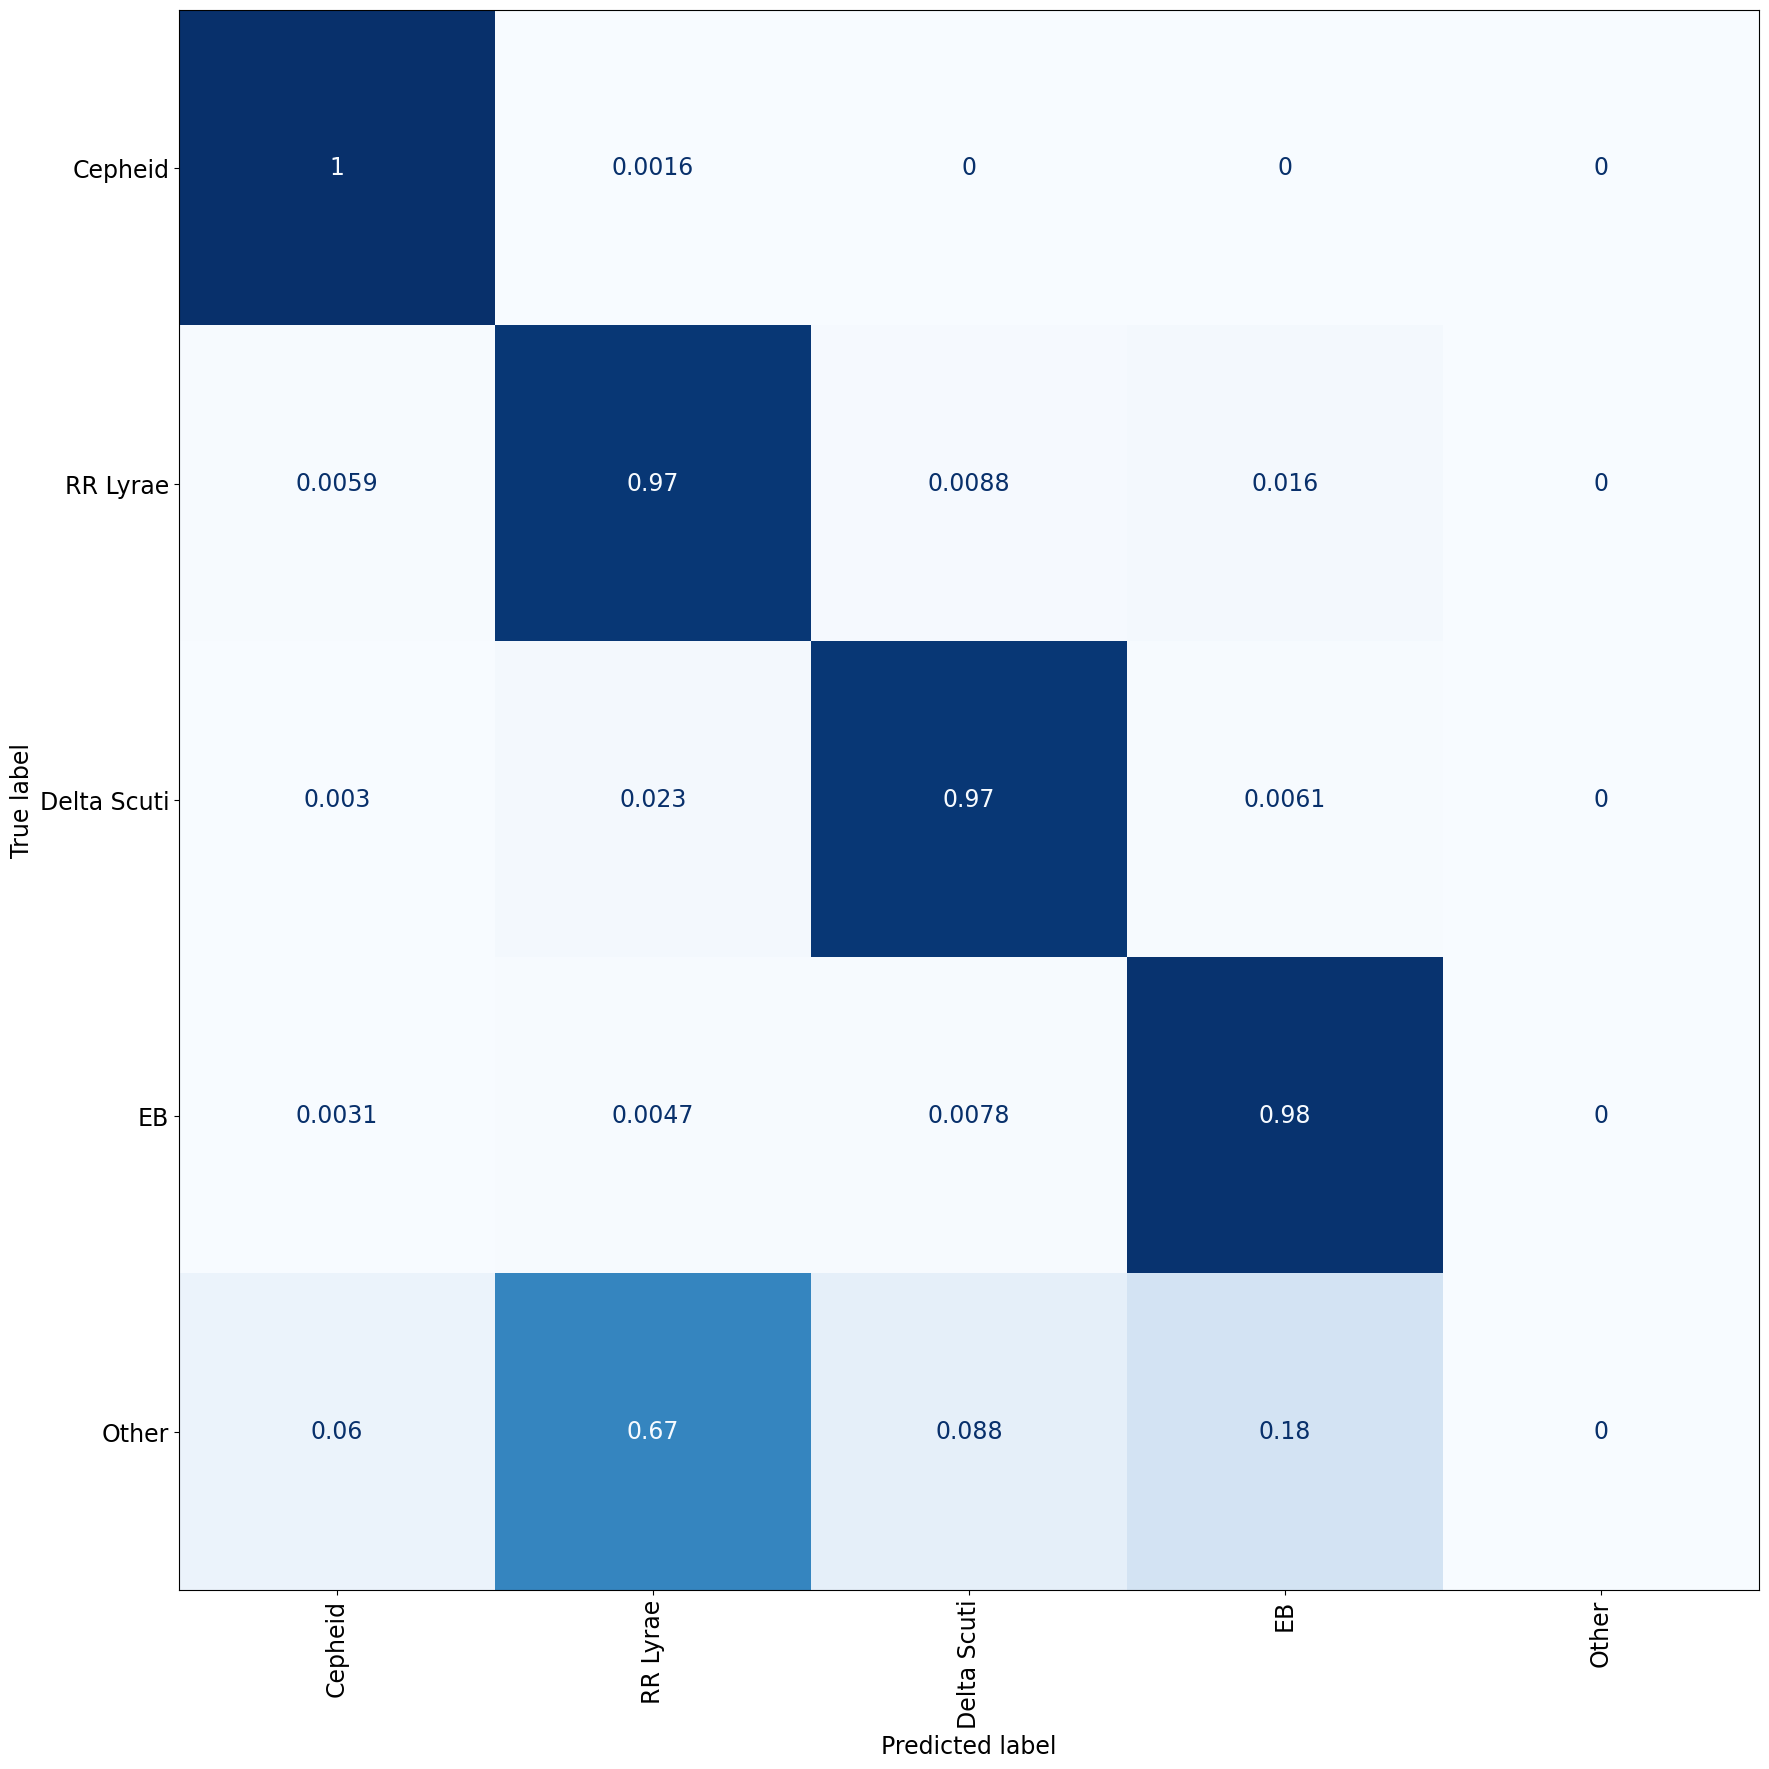

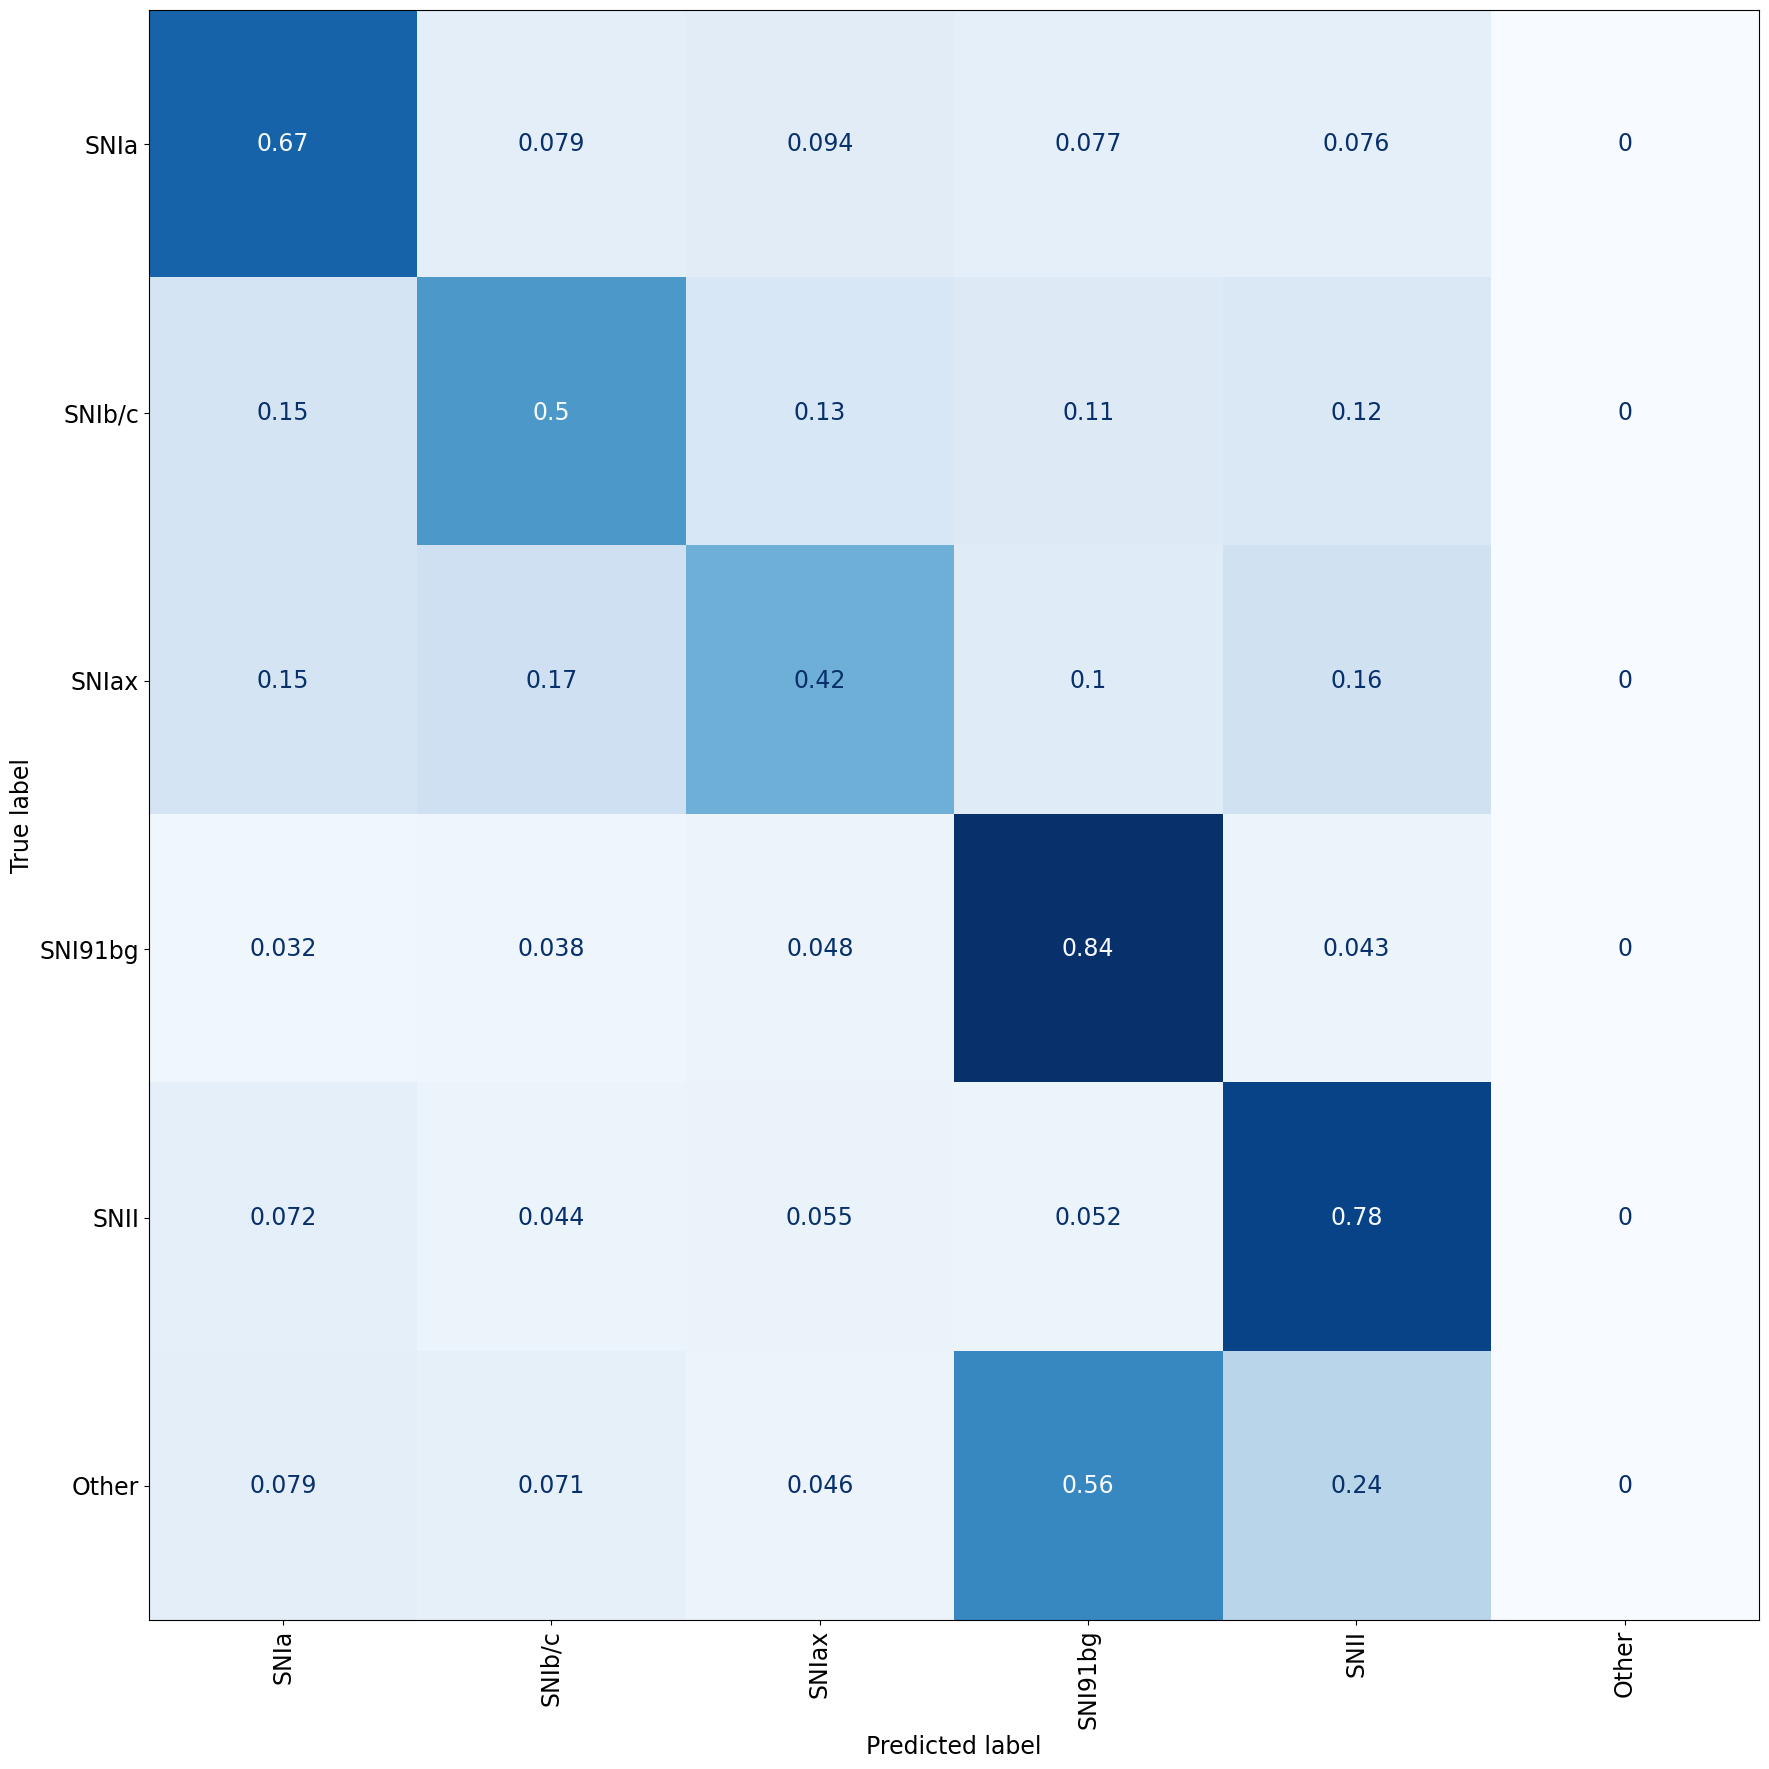

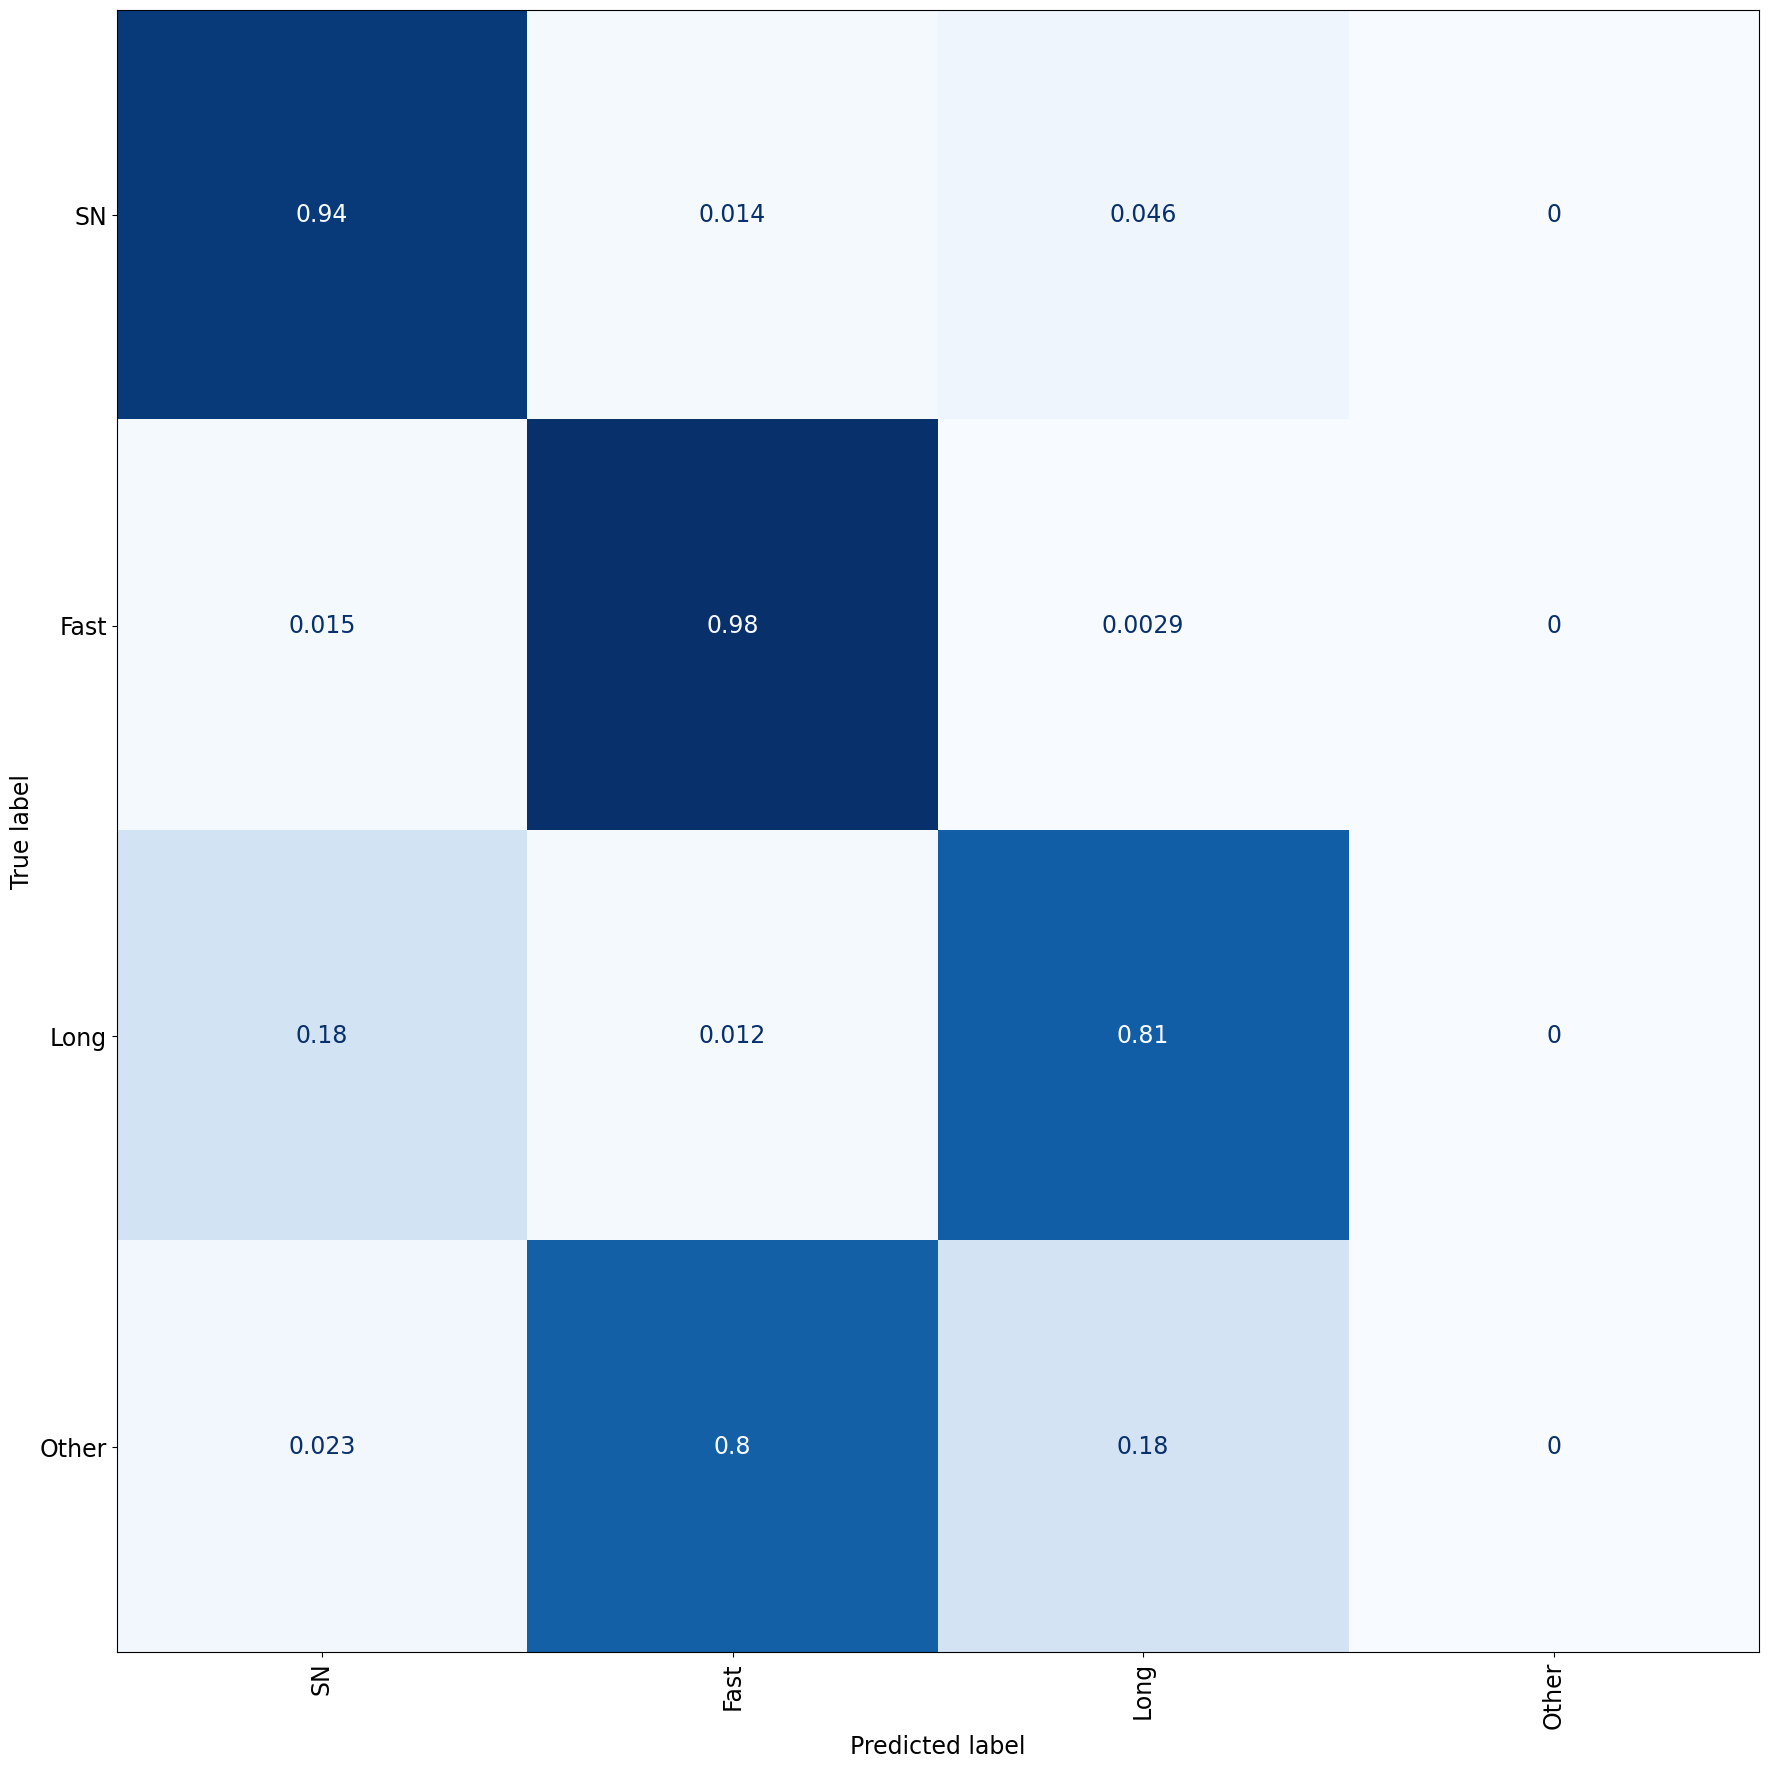

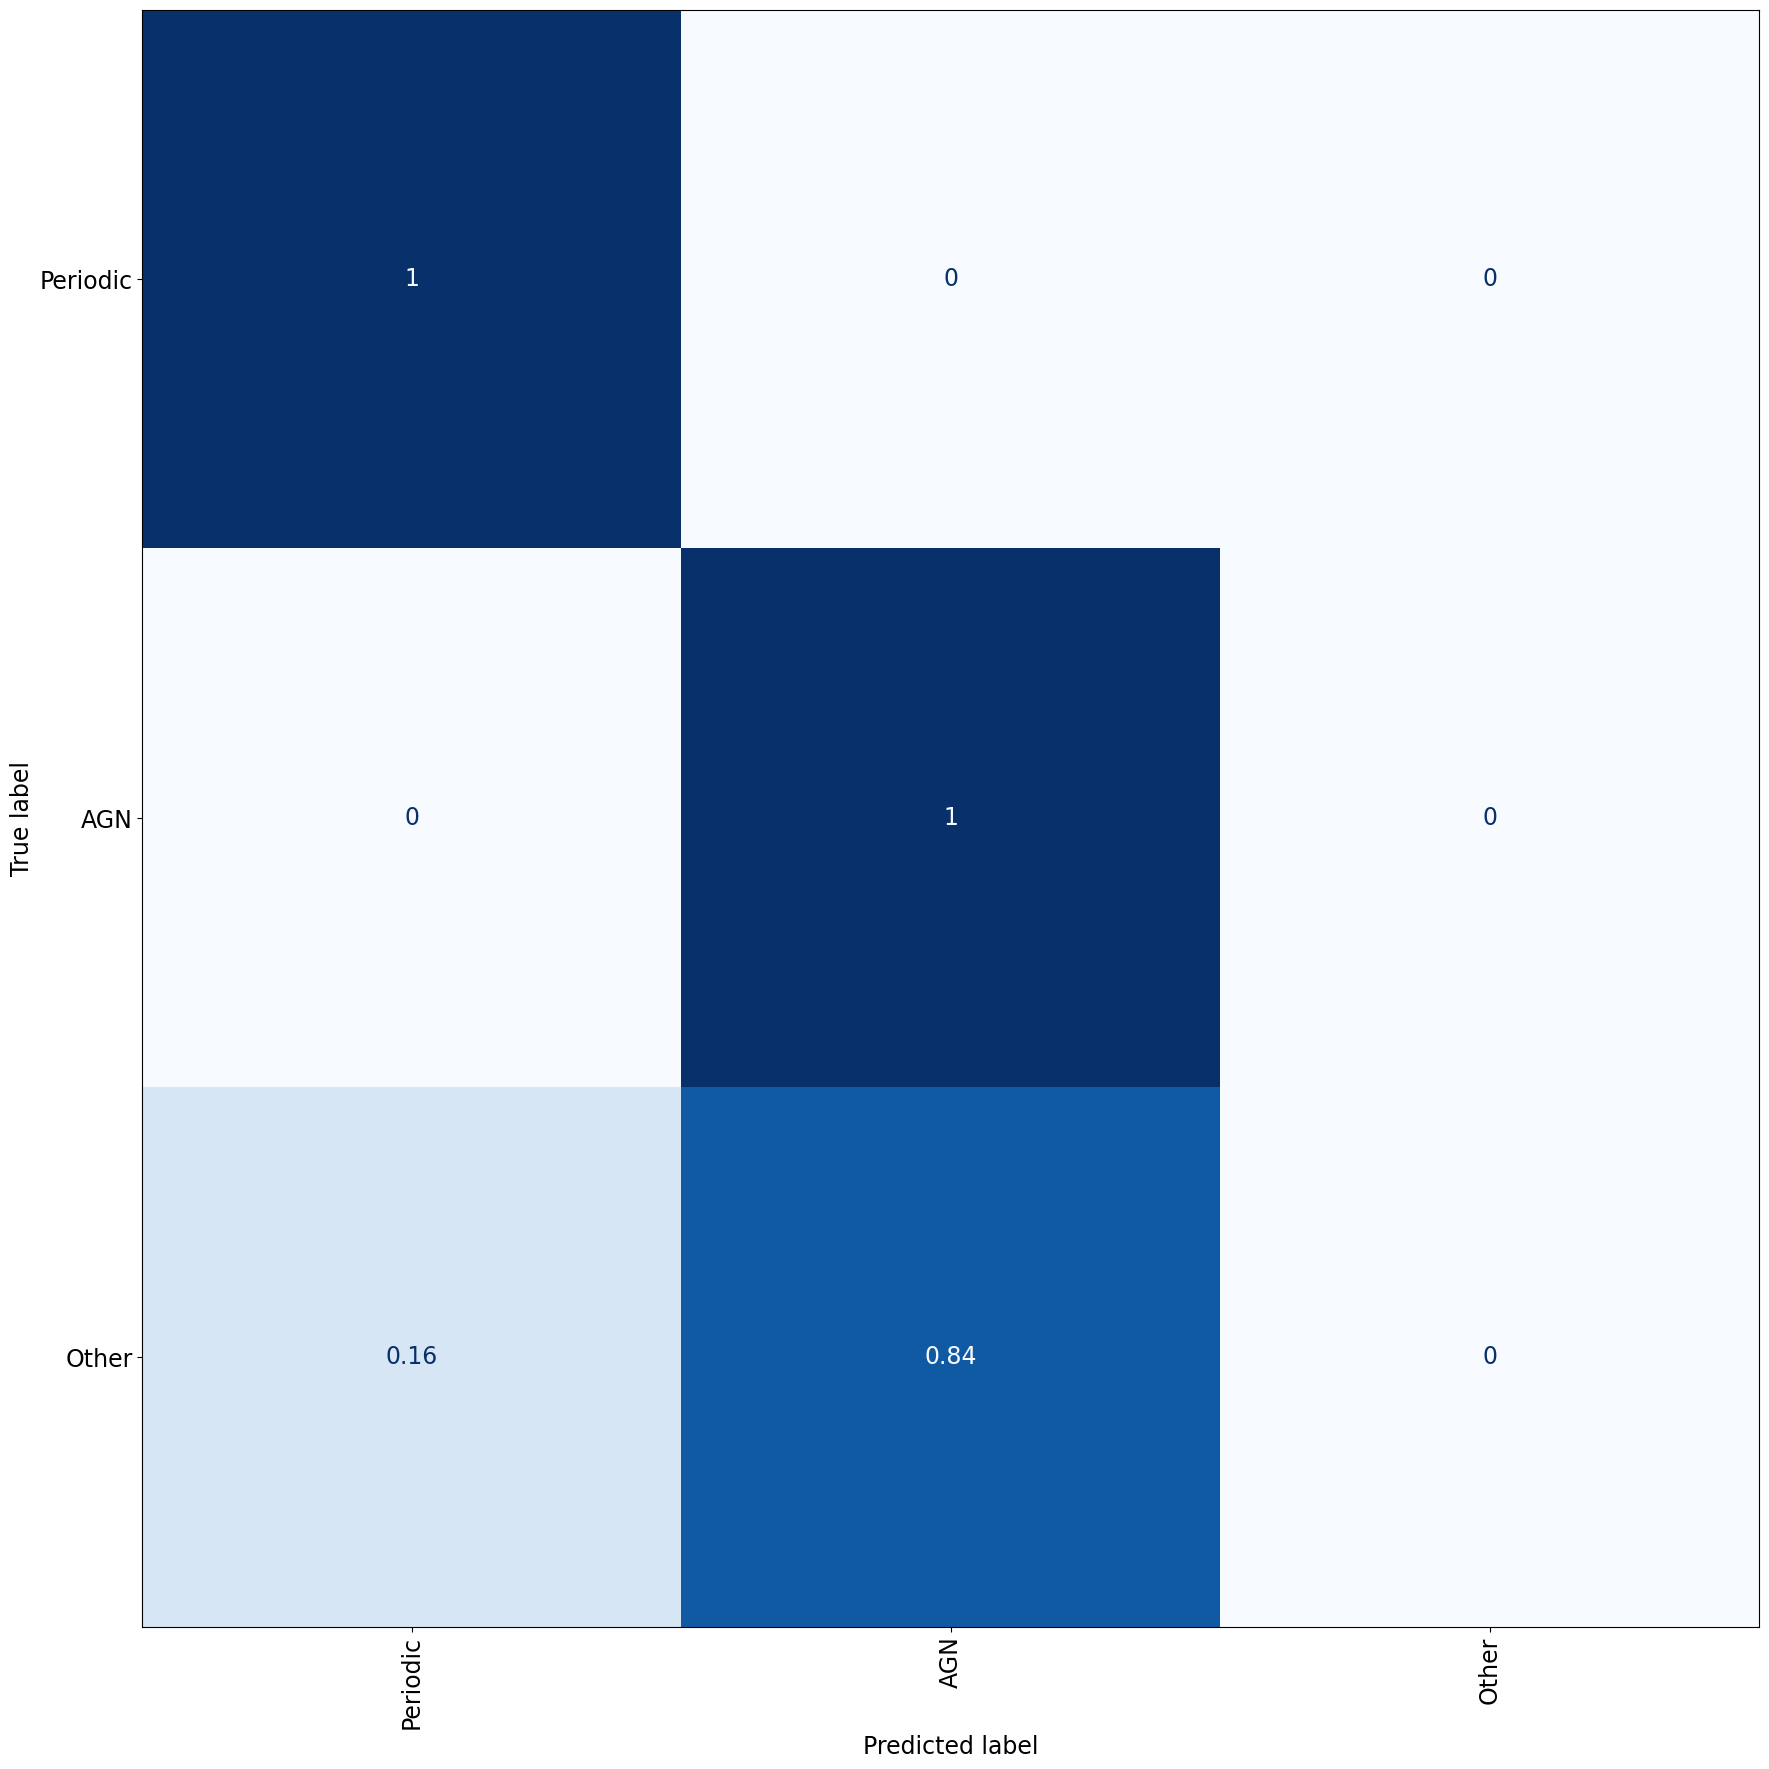

Running inference for 70% light curves...
332/332 [==============================] - 2s 7ms/step
For 70% of the light curve, these are the statistics


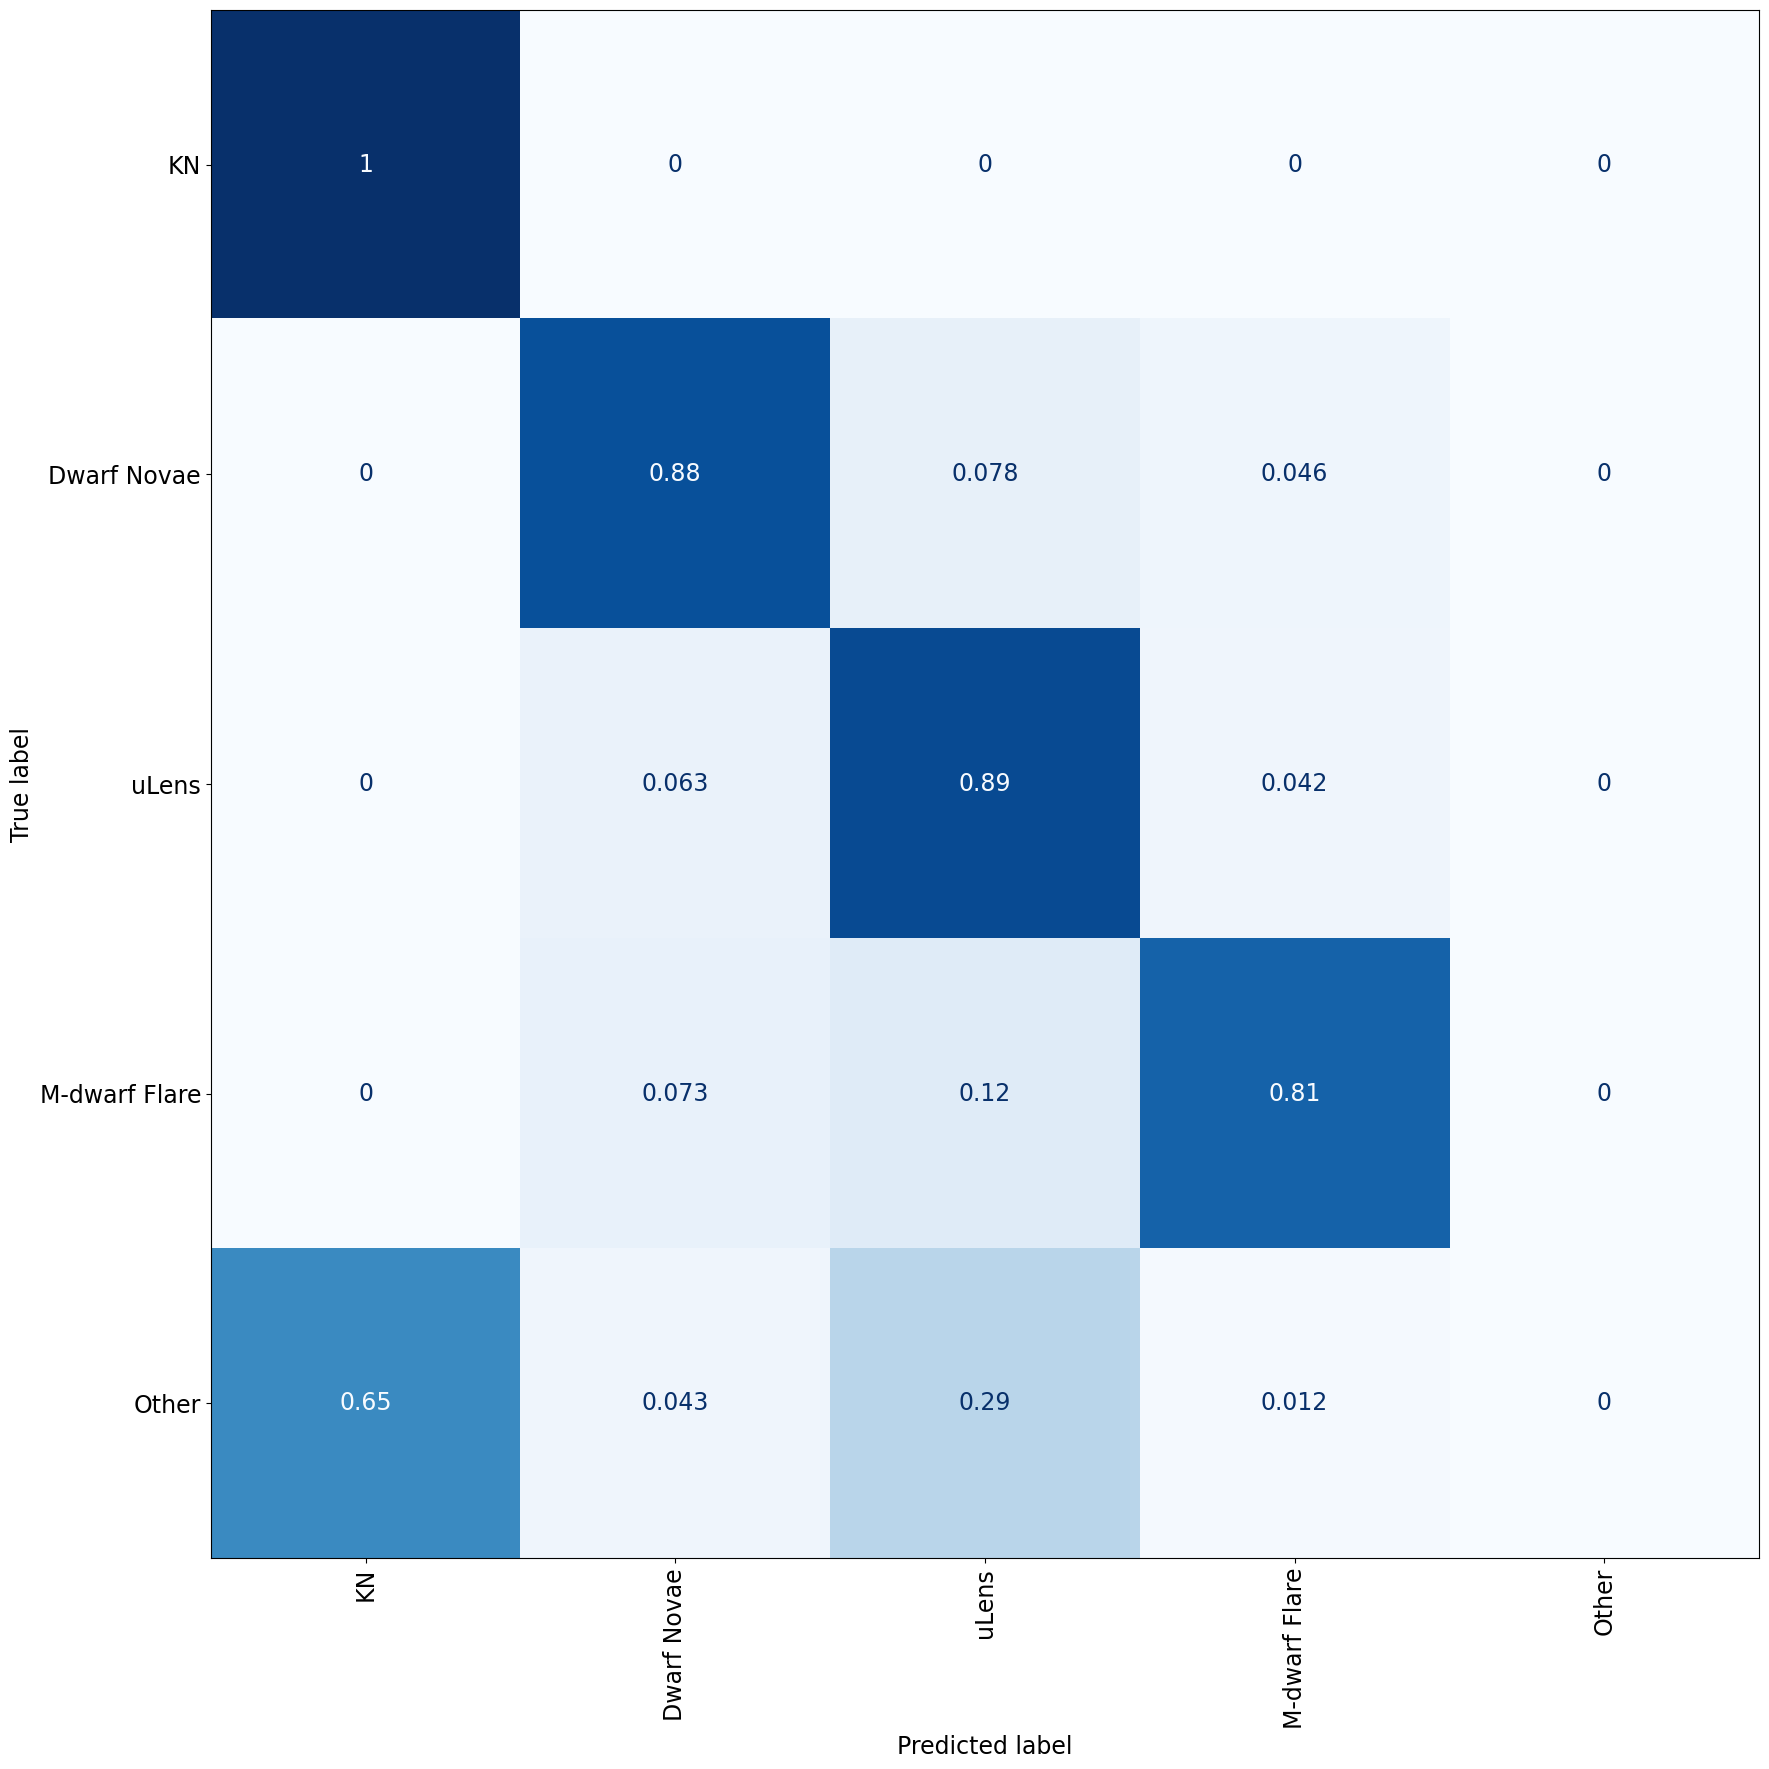

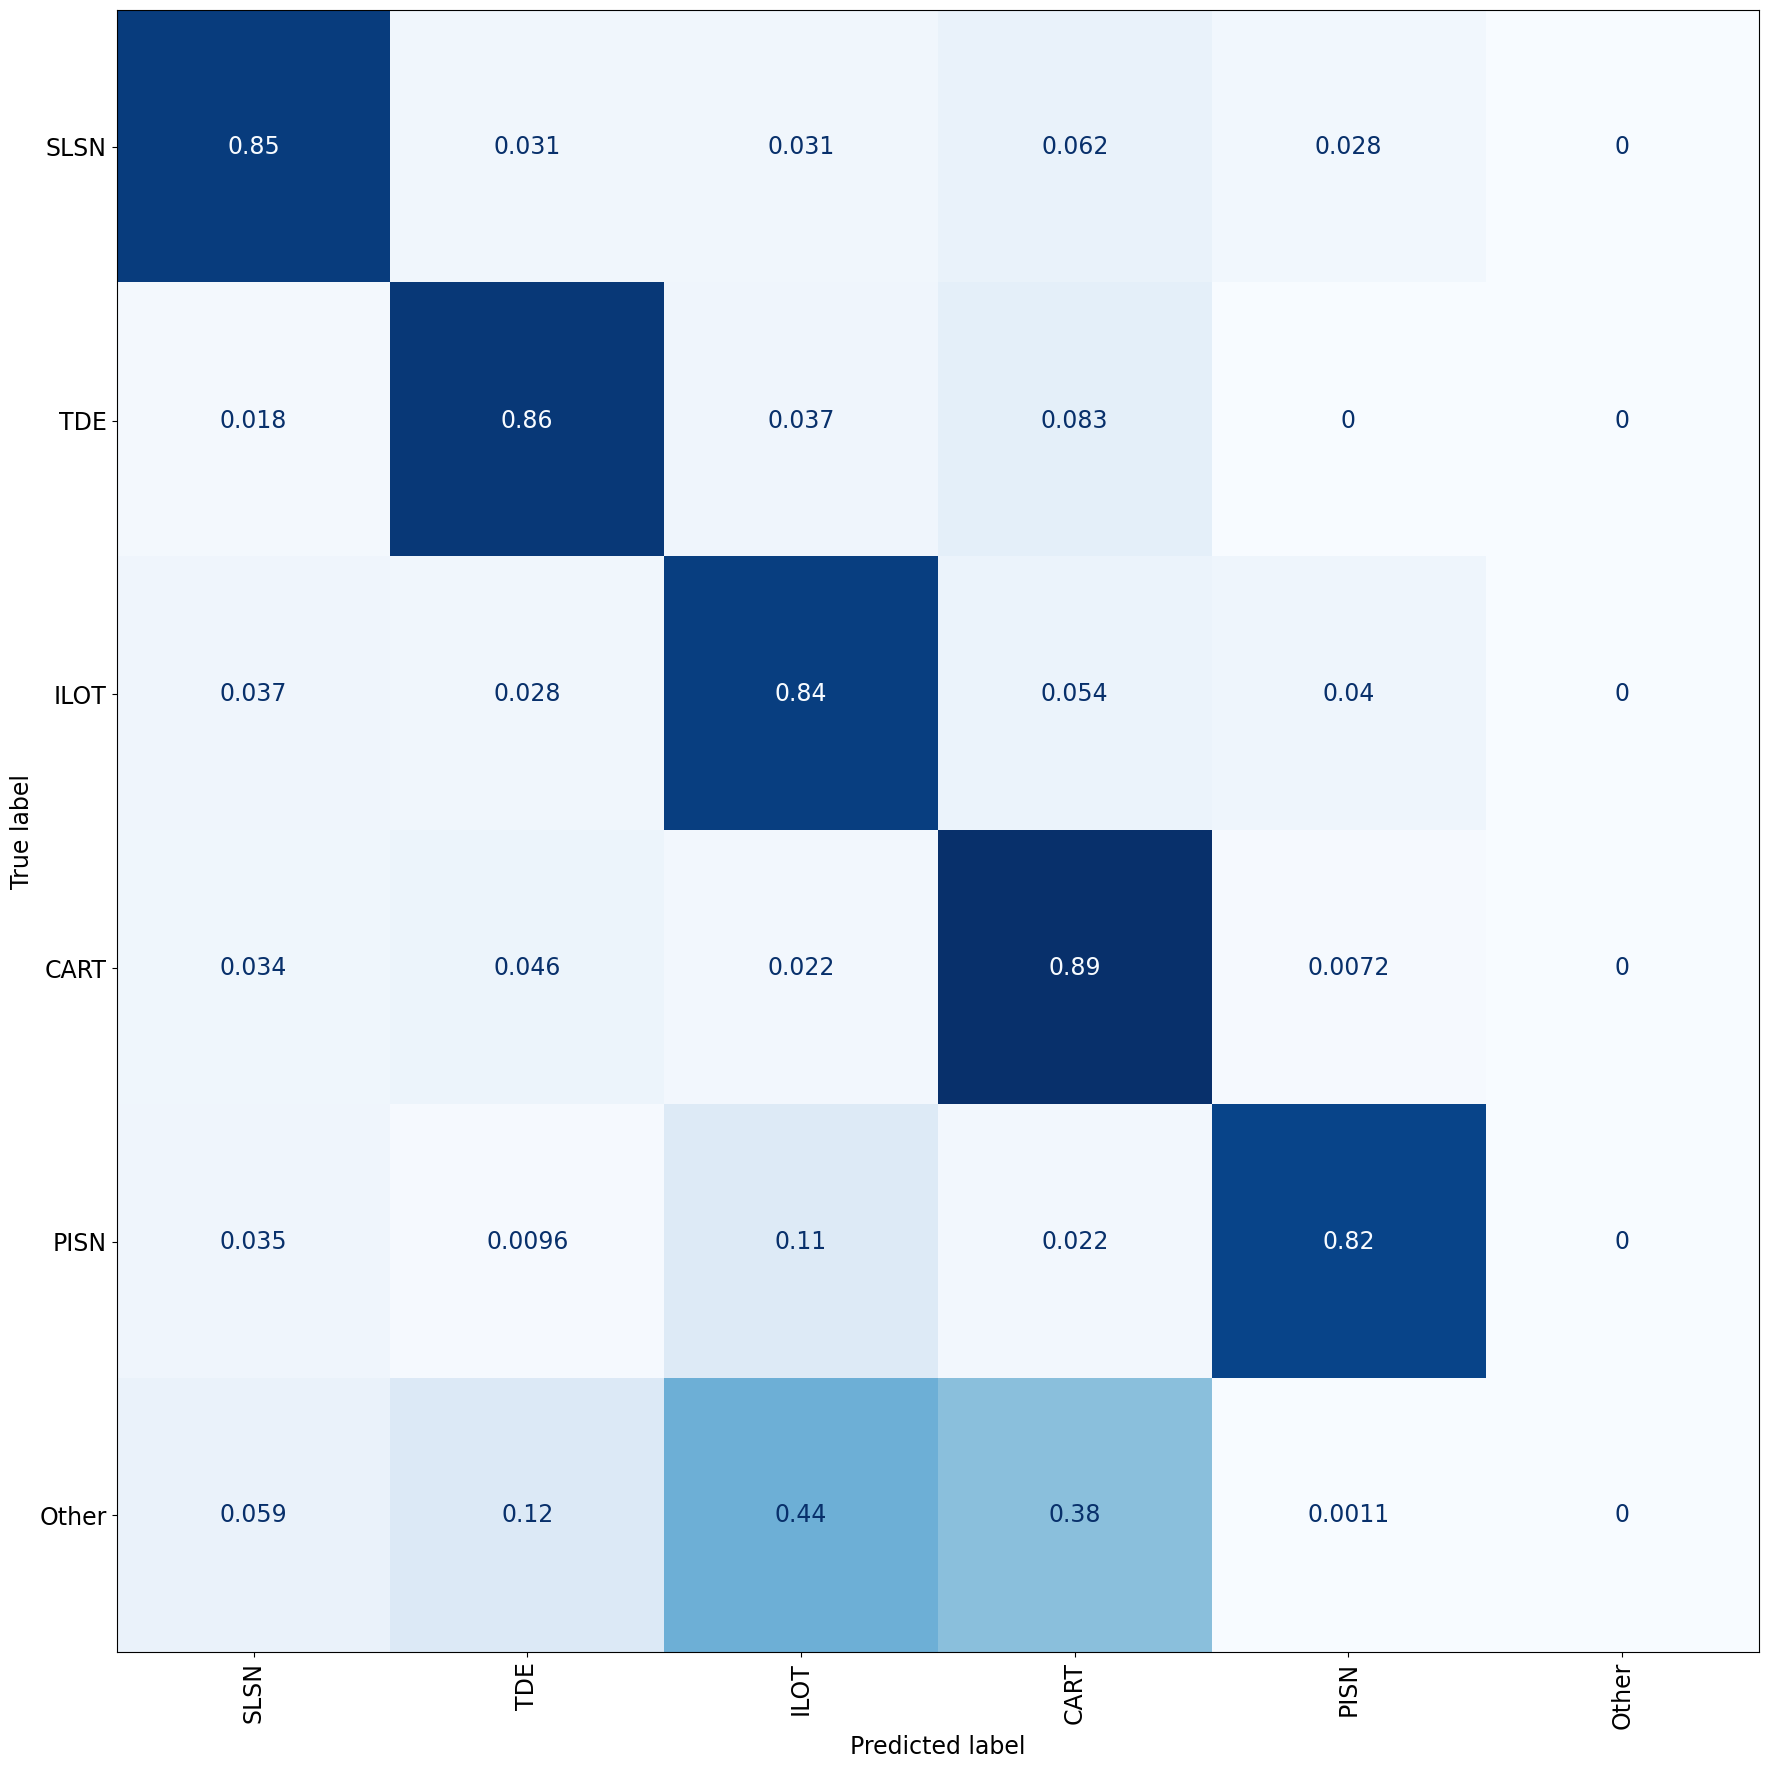

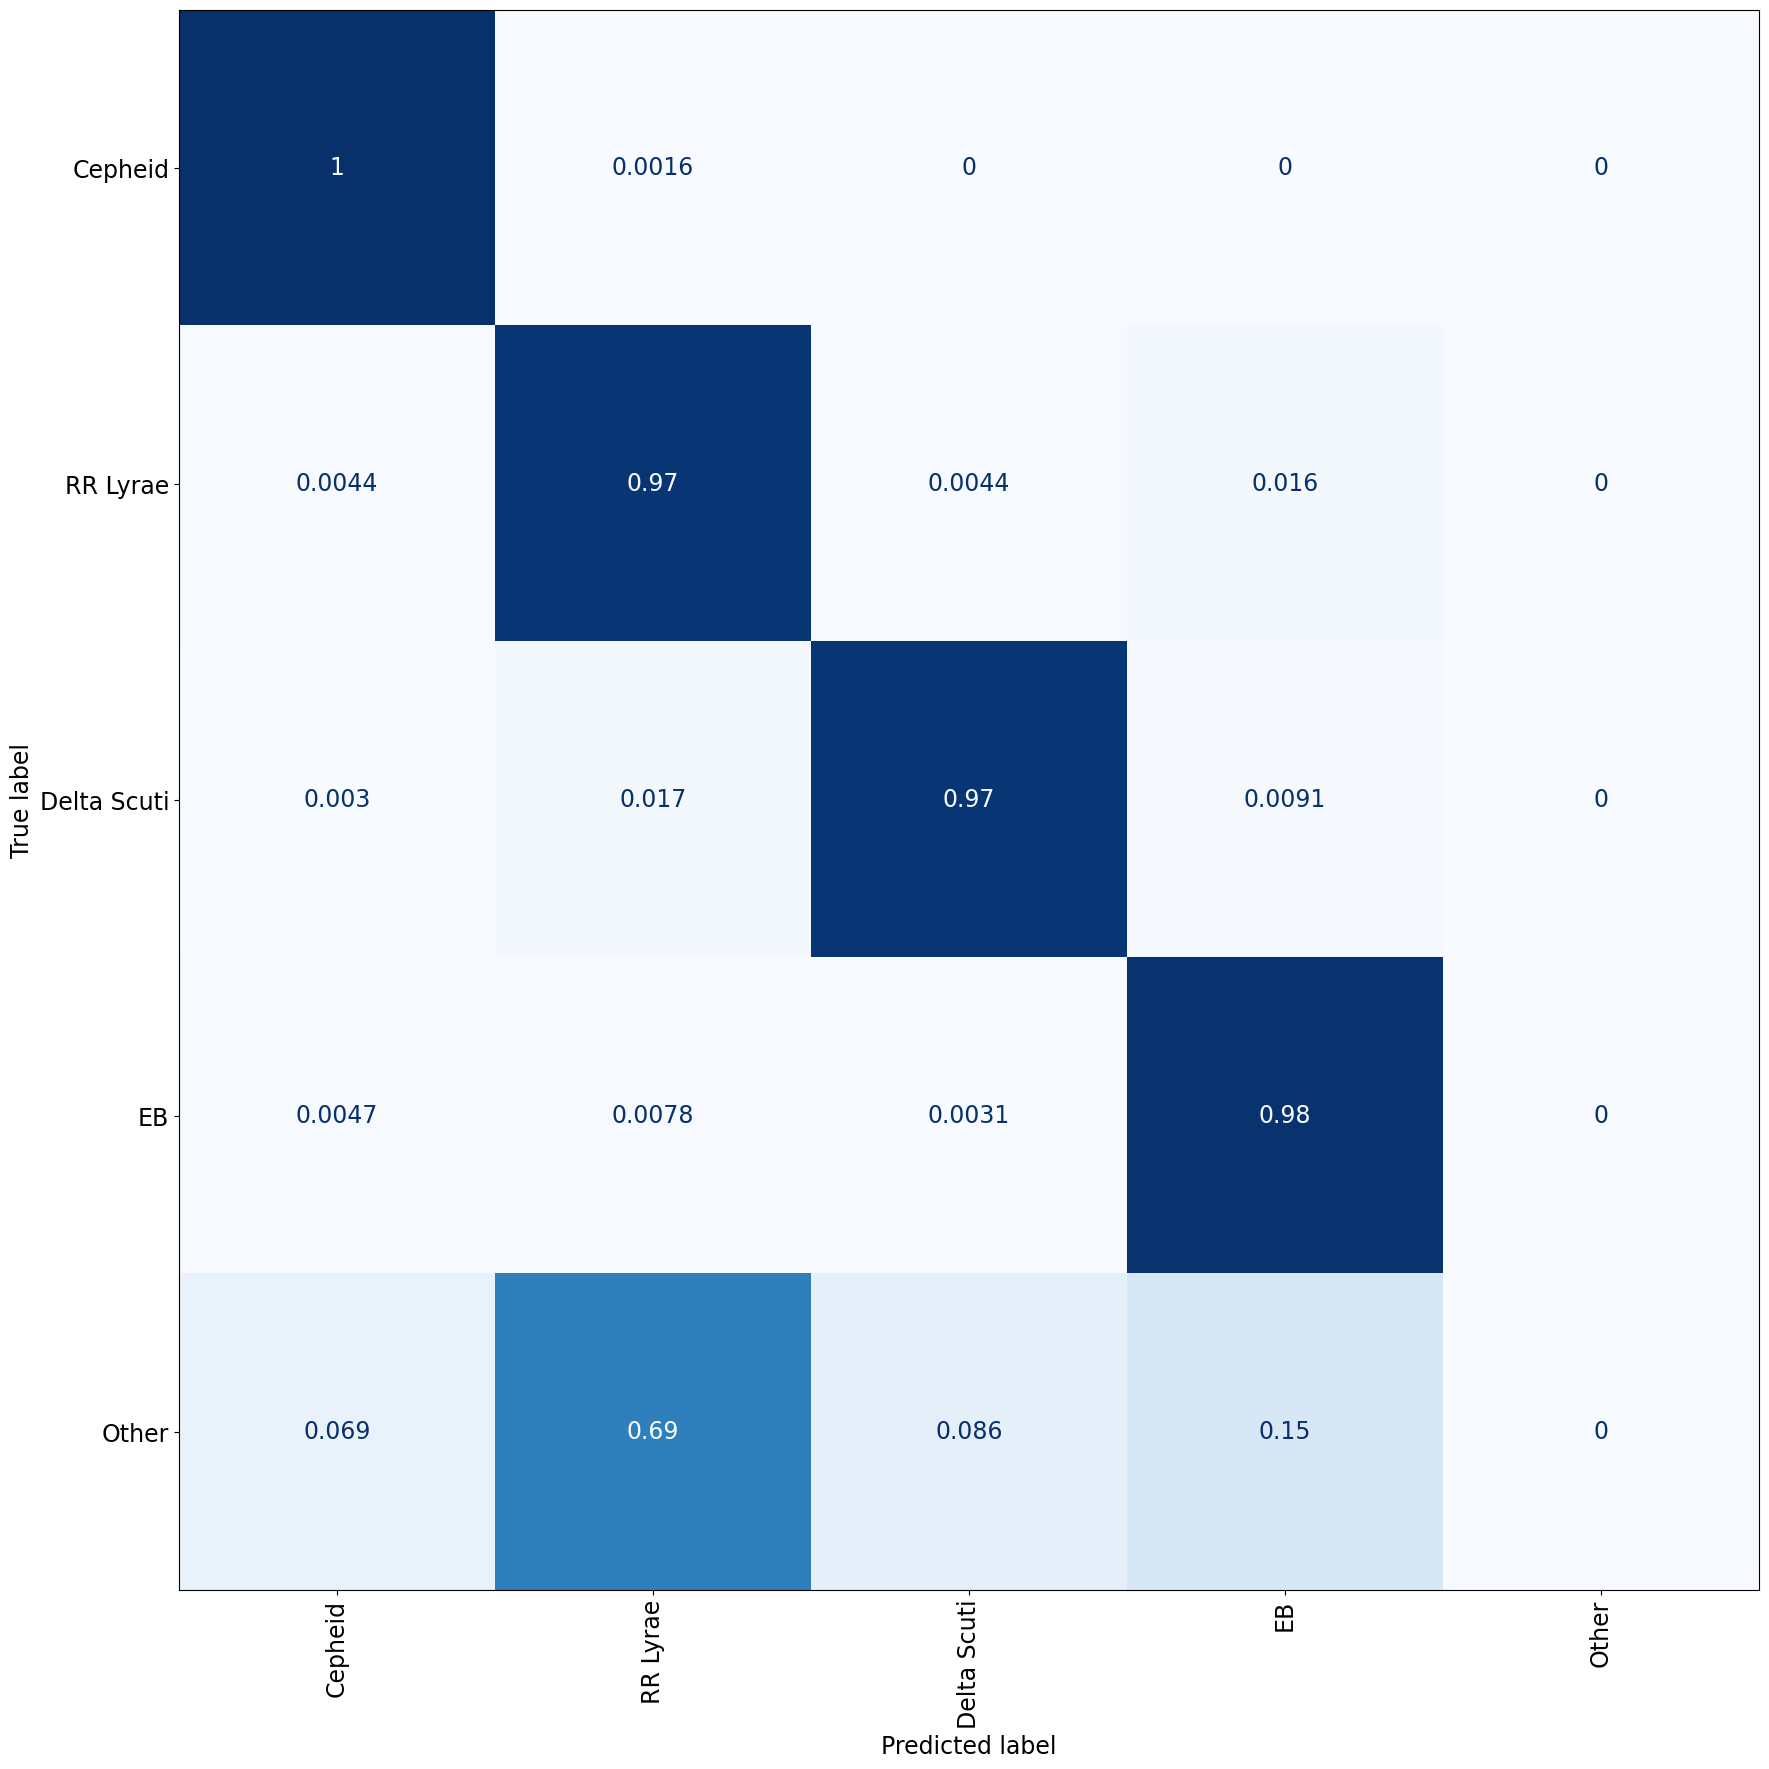

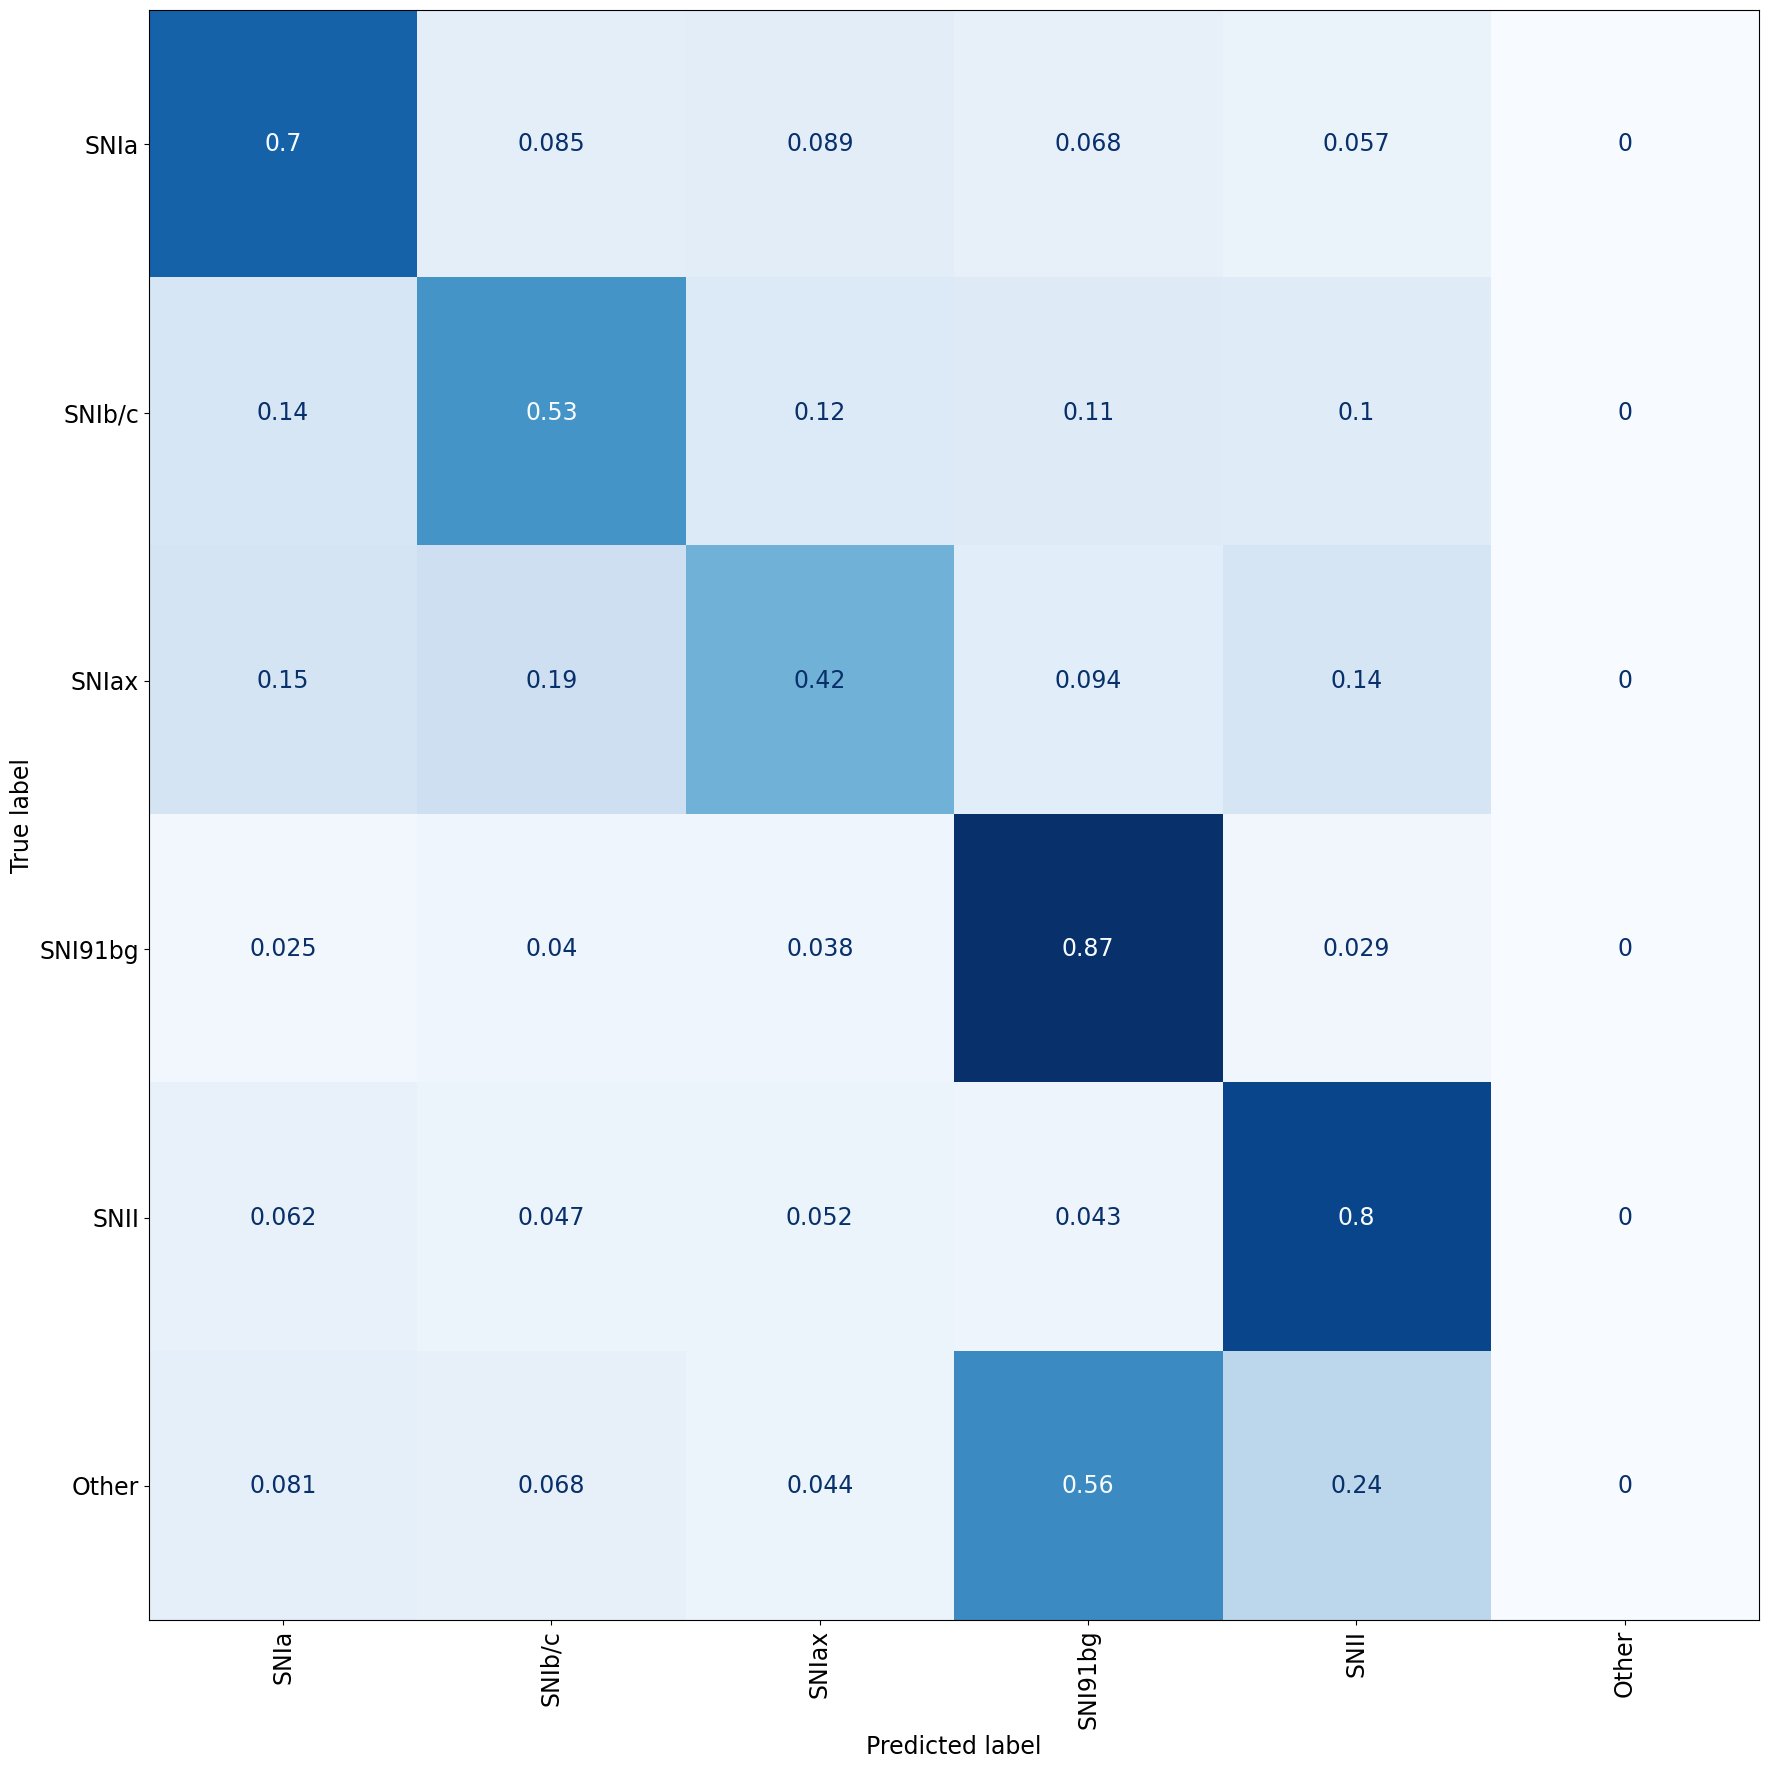

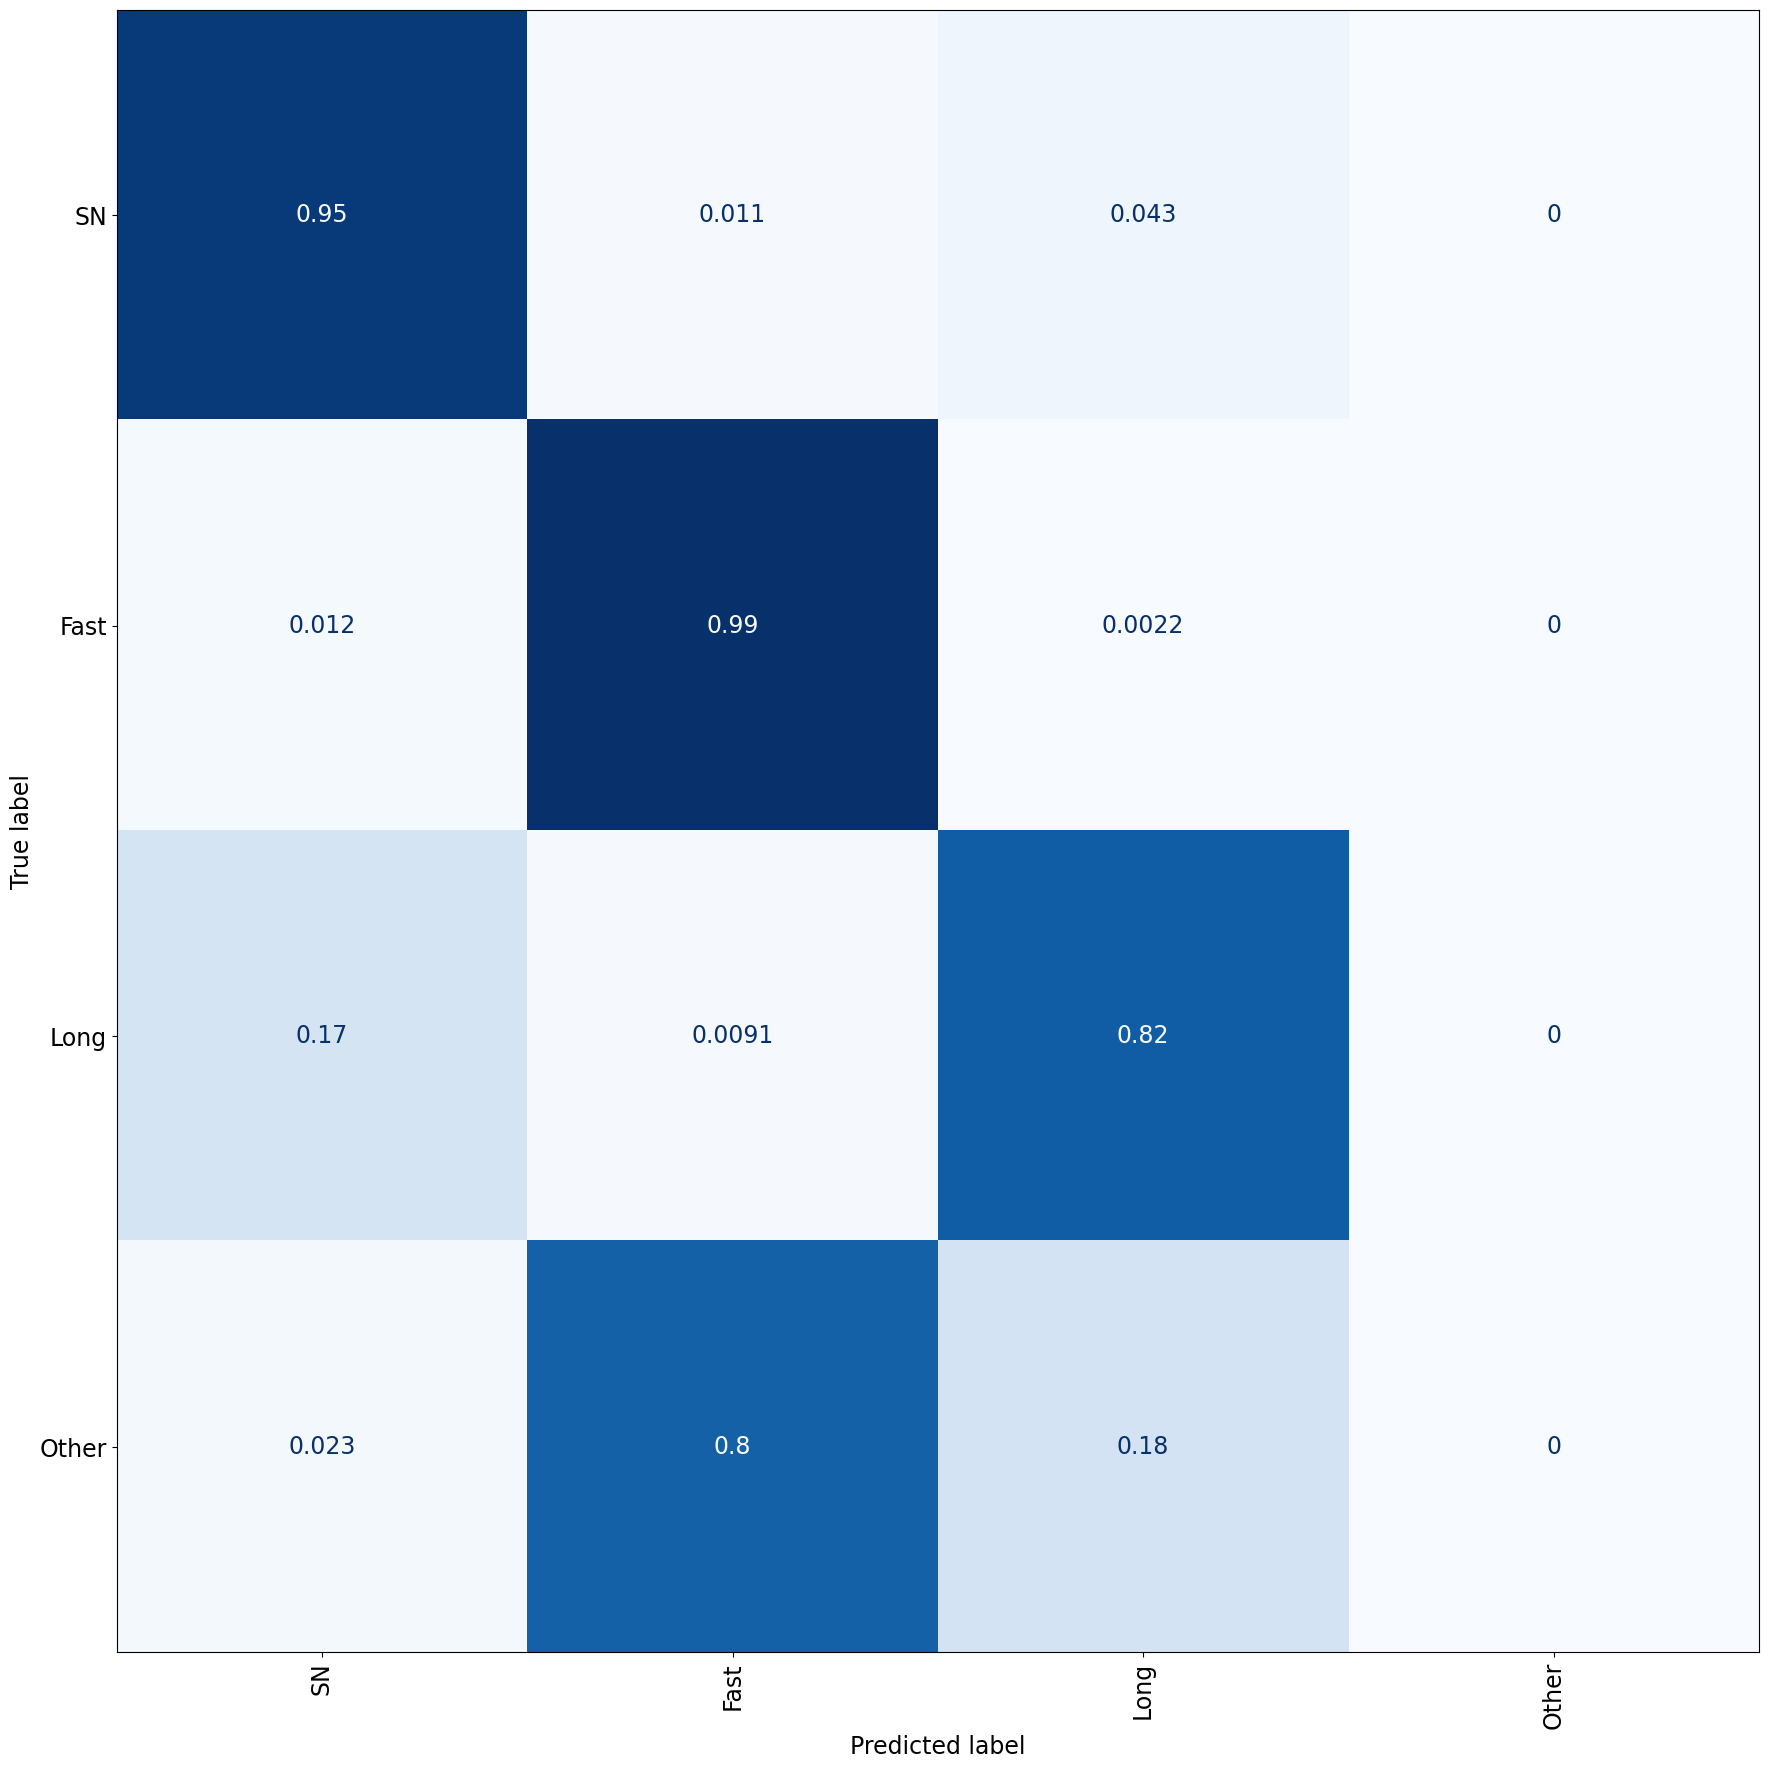

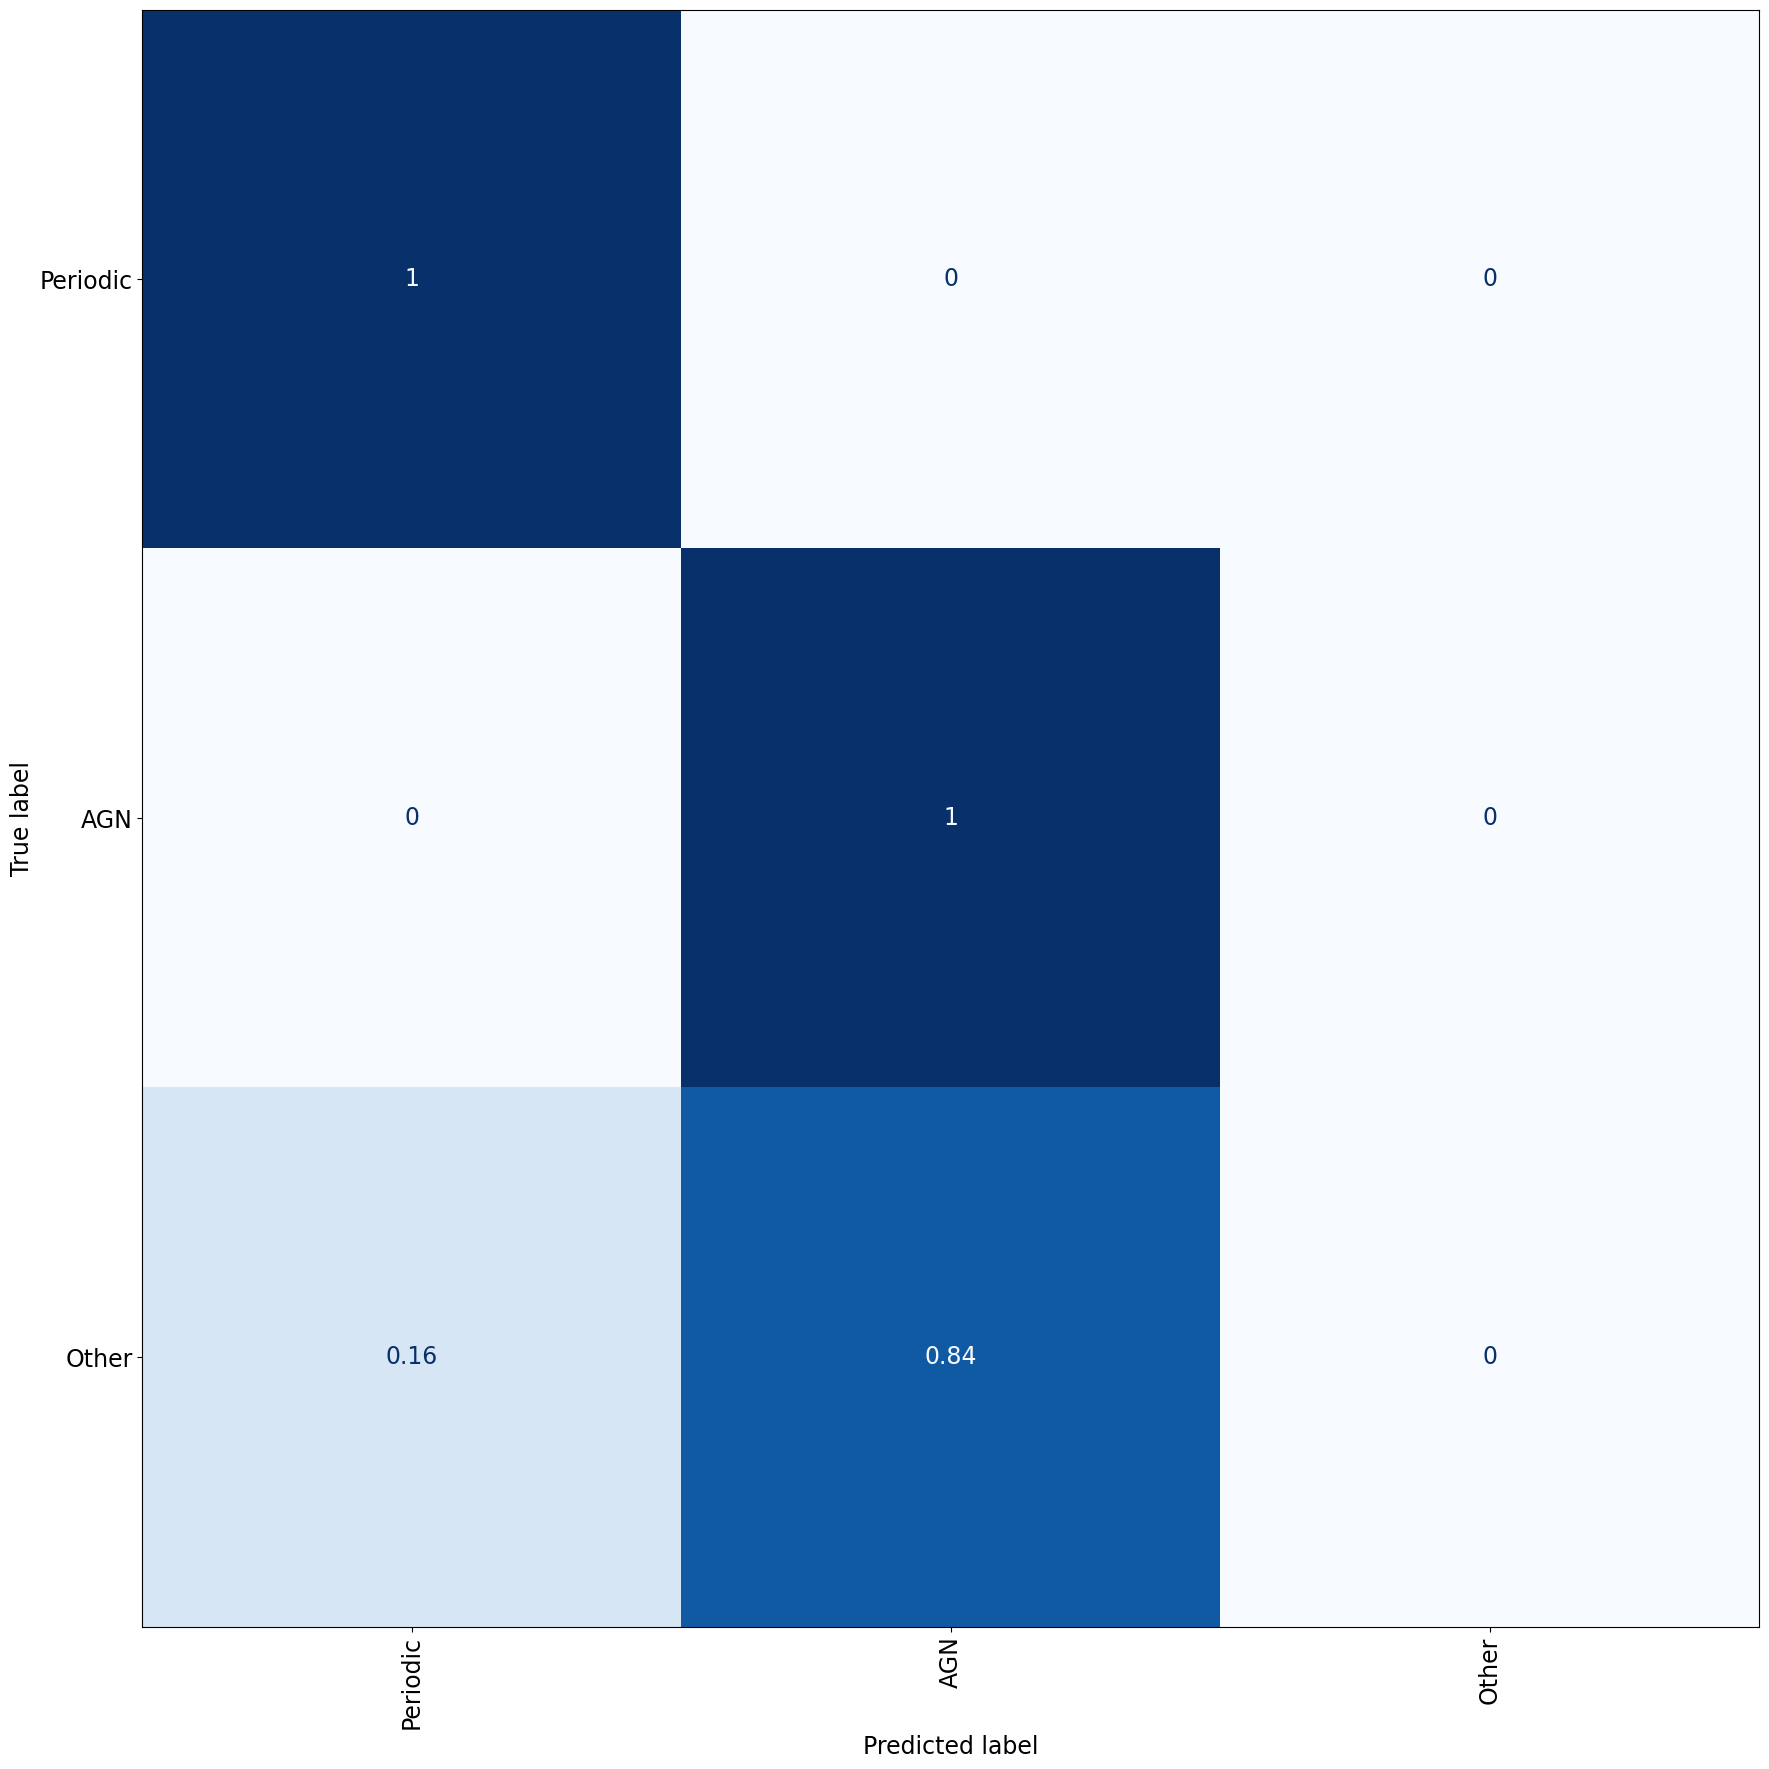

Running inference for 80% light curves...
332/332 [==============================] - 3s 8ms/step
For 80% of the light curve, these are the statistics


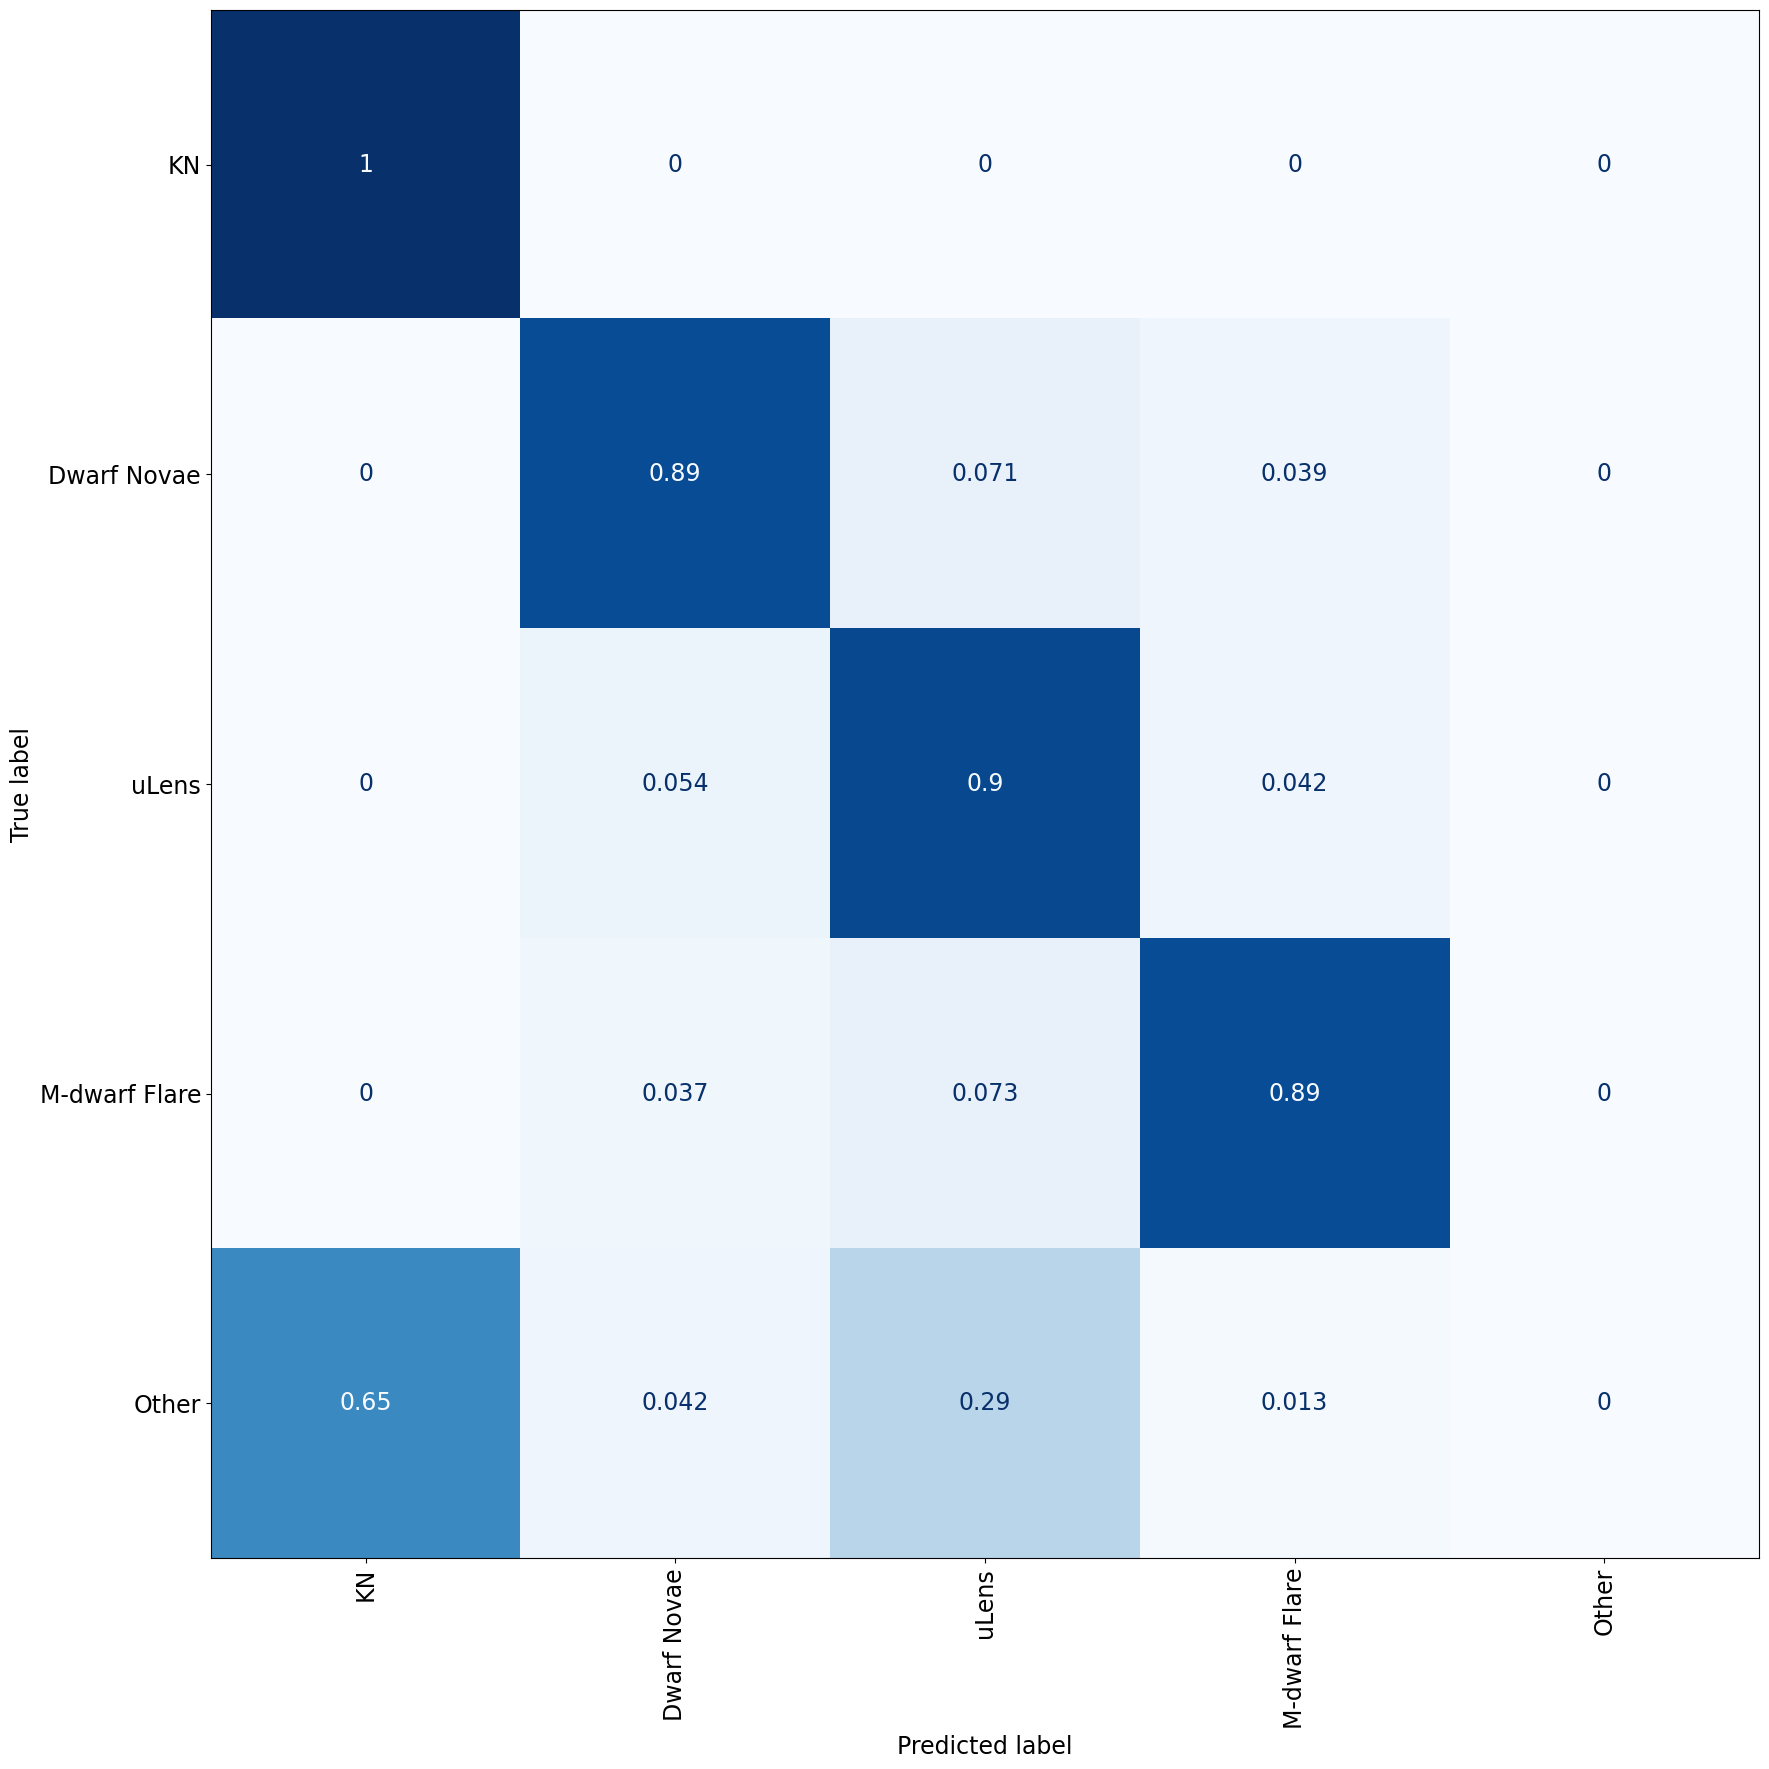

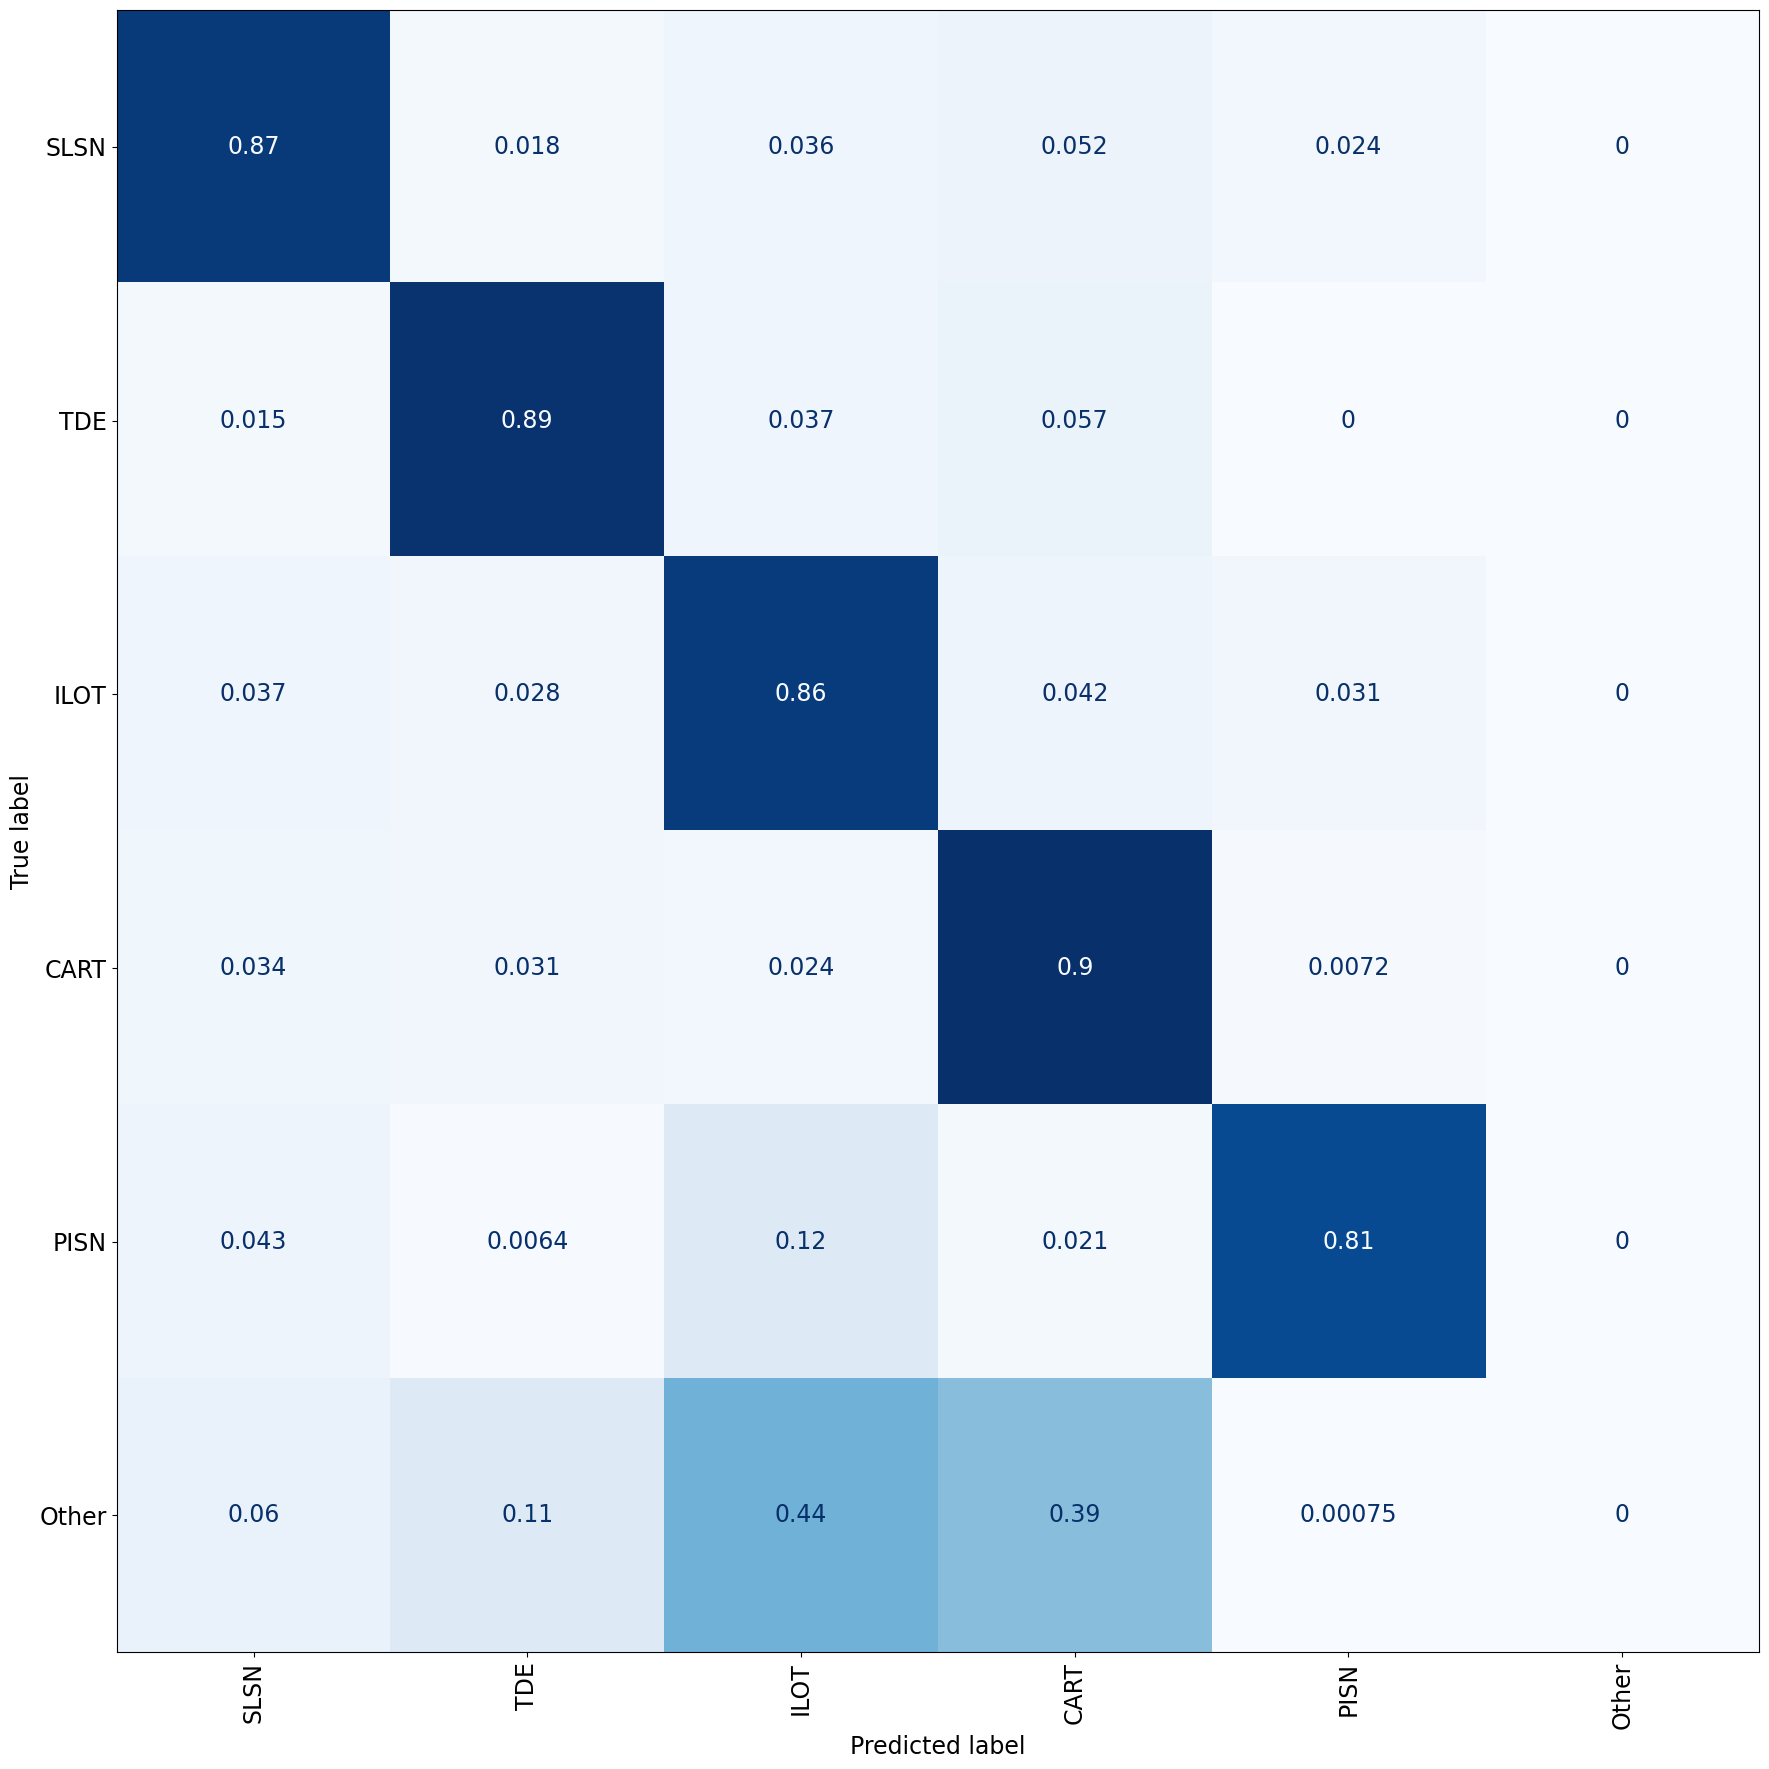

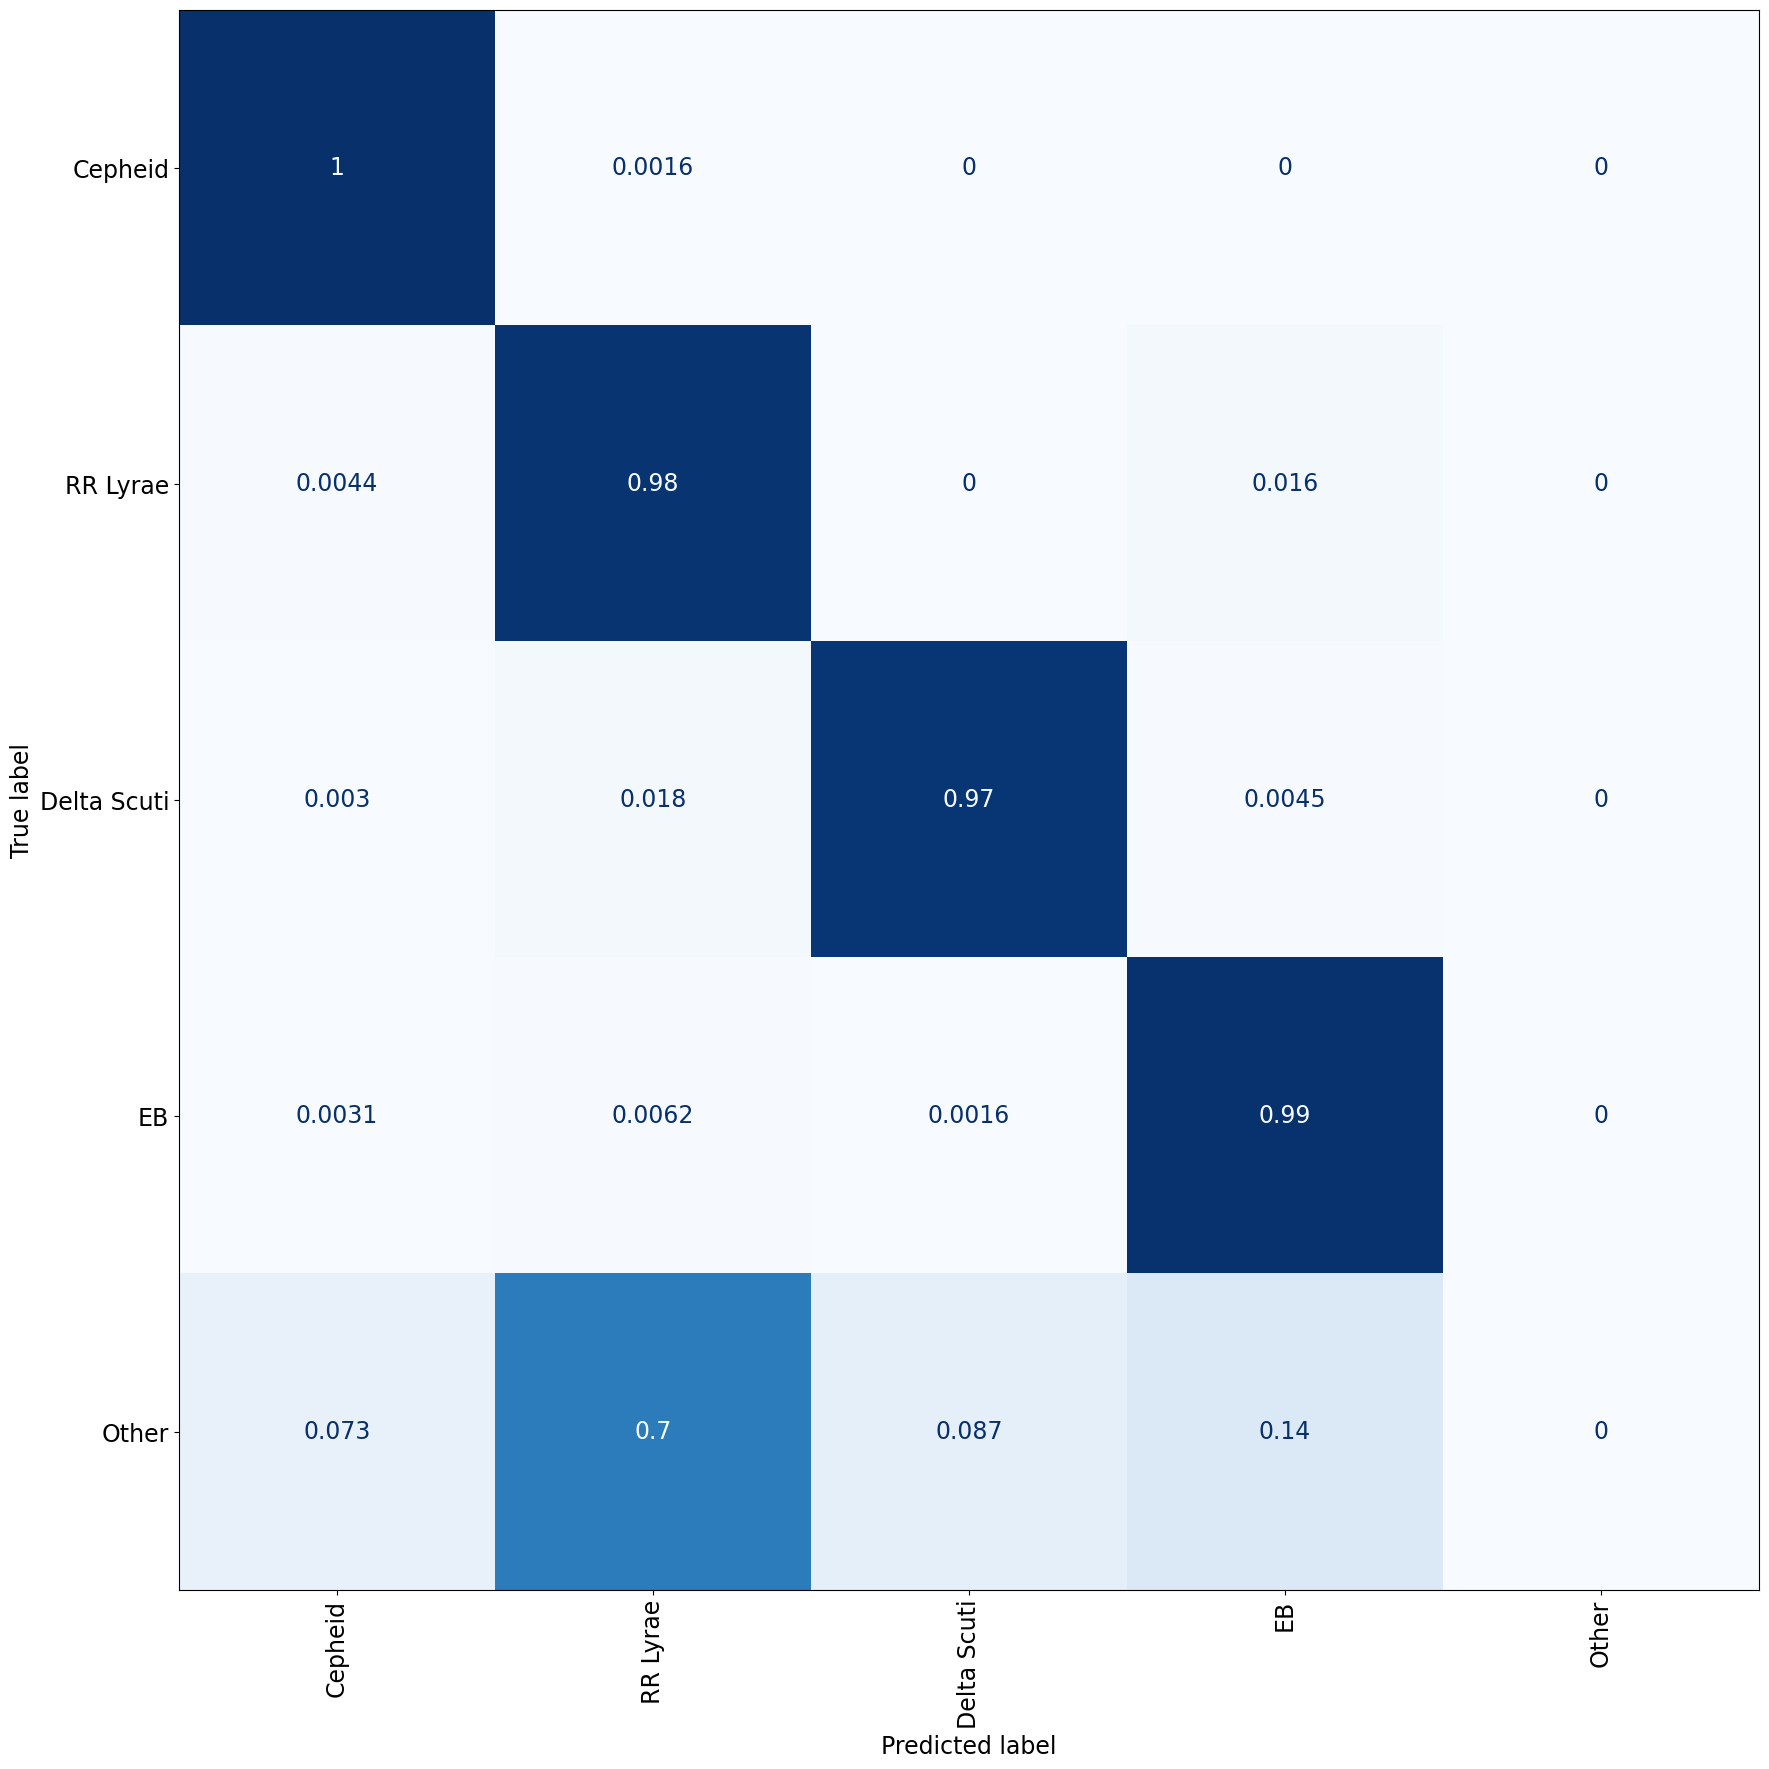

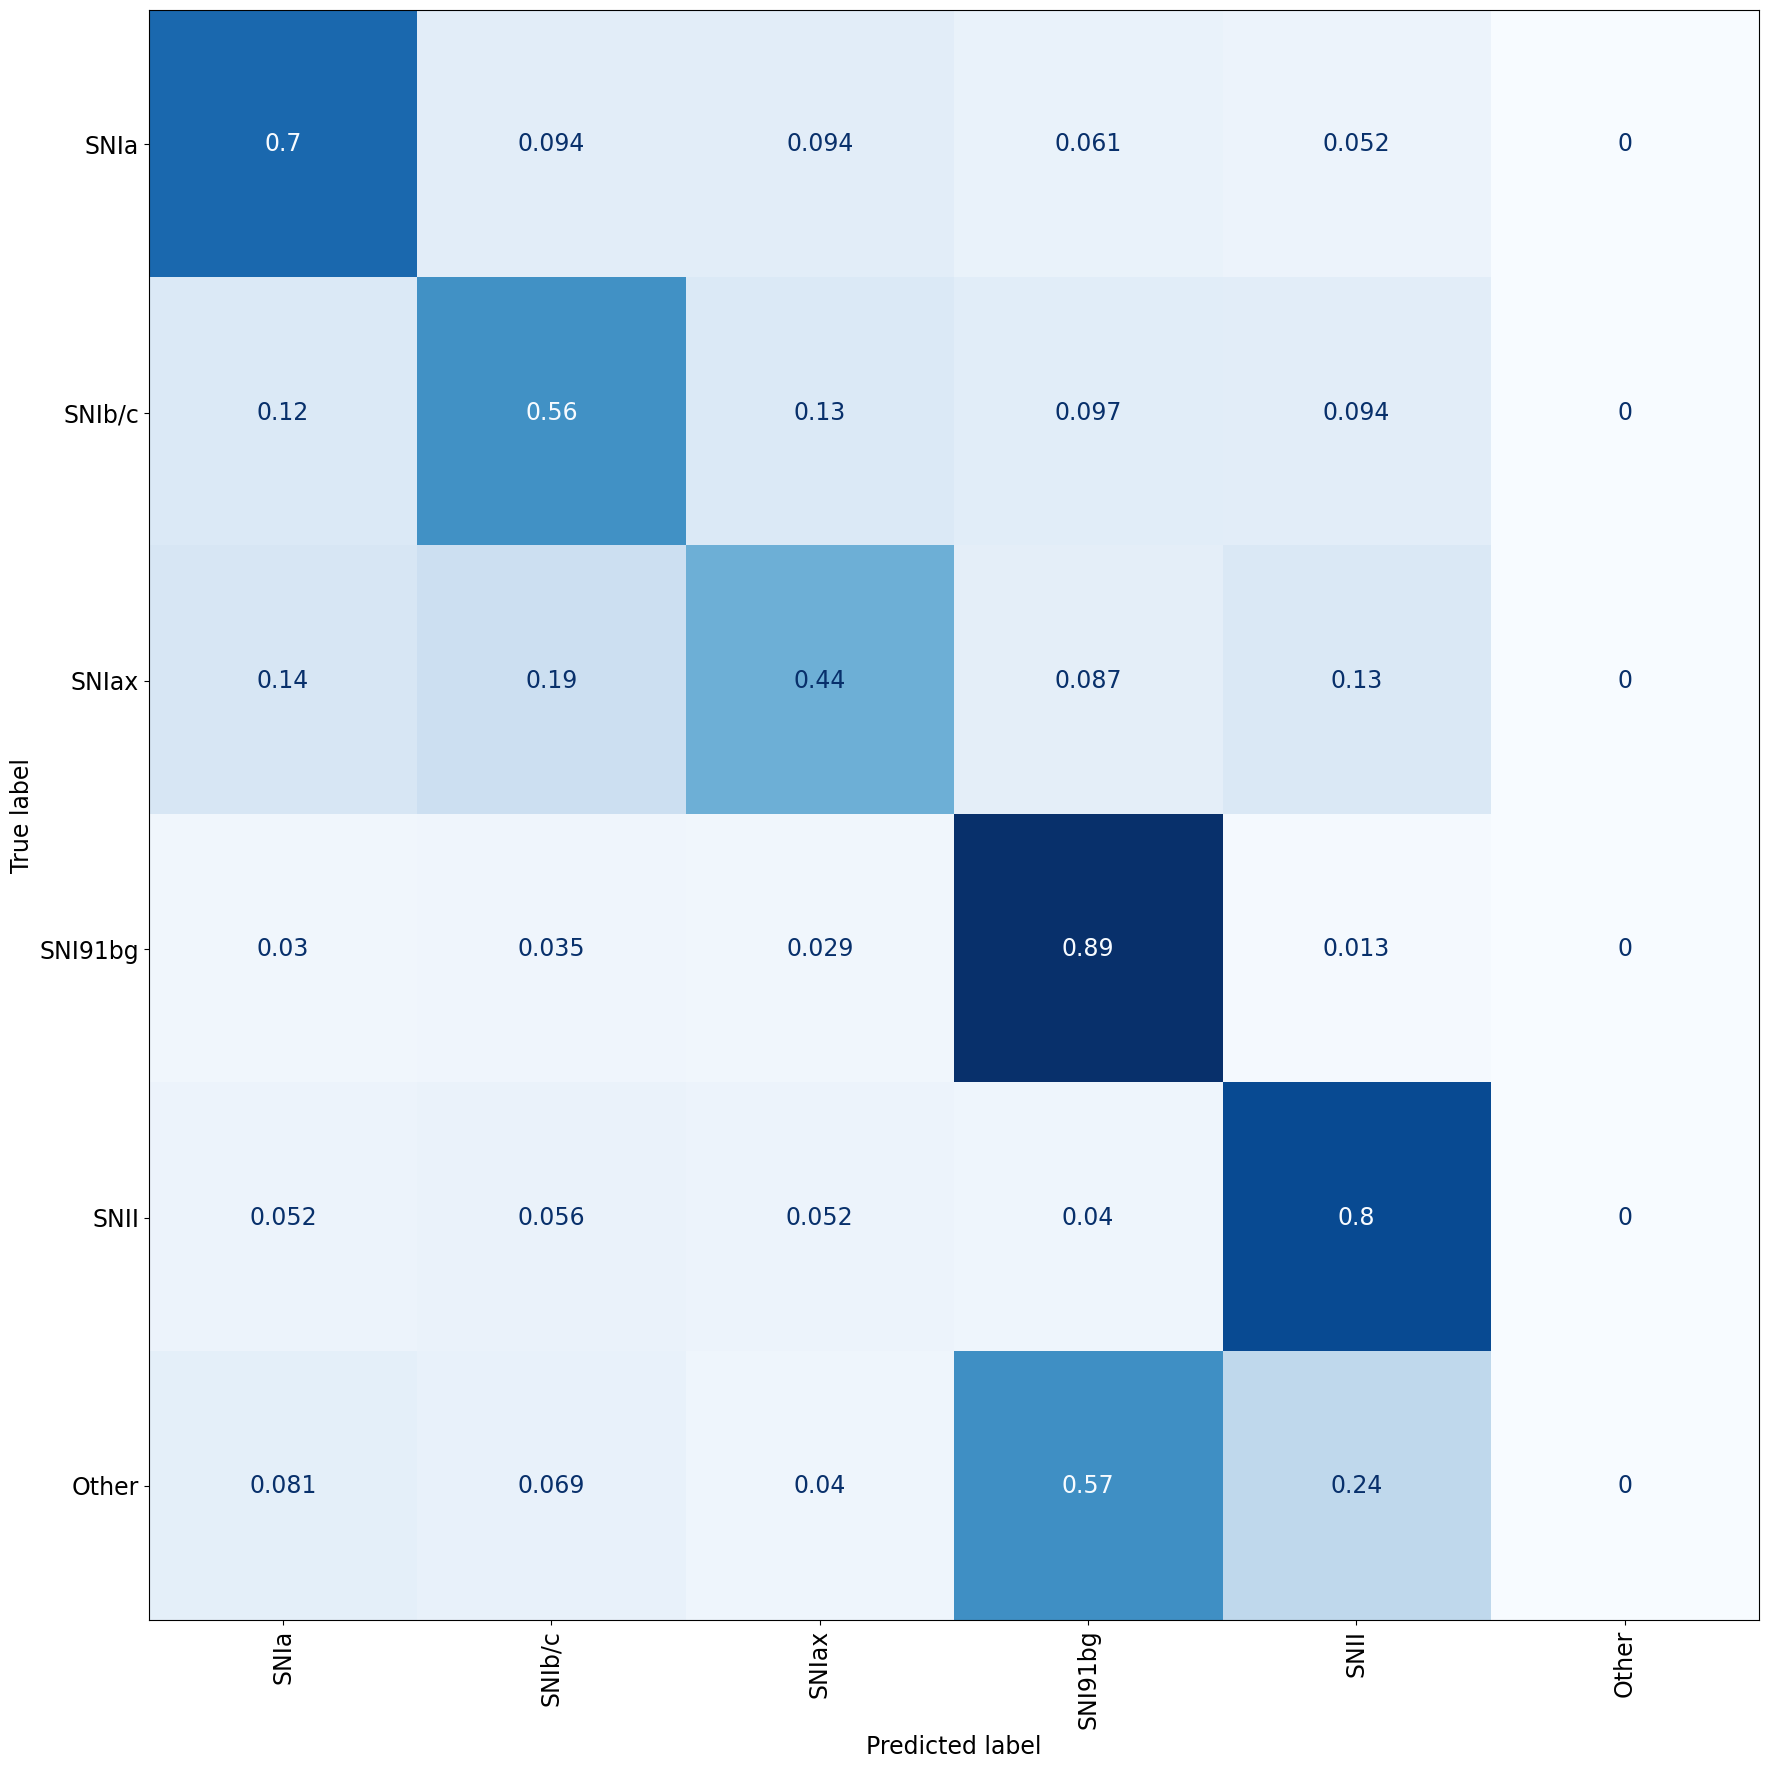

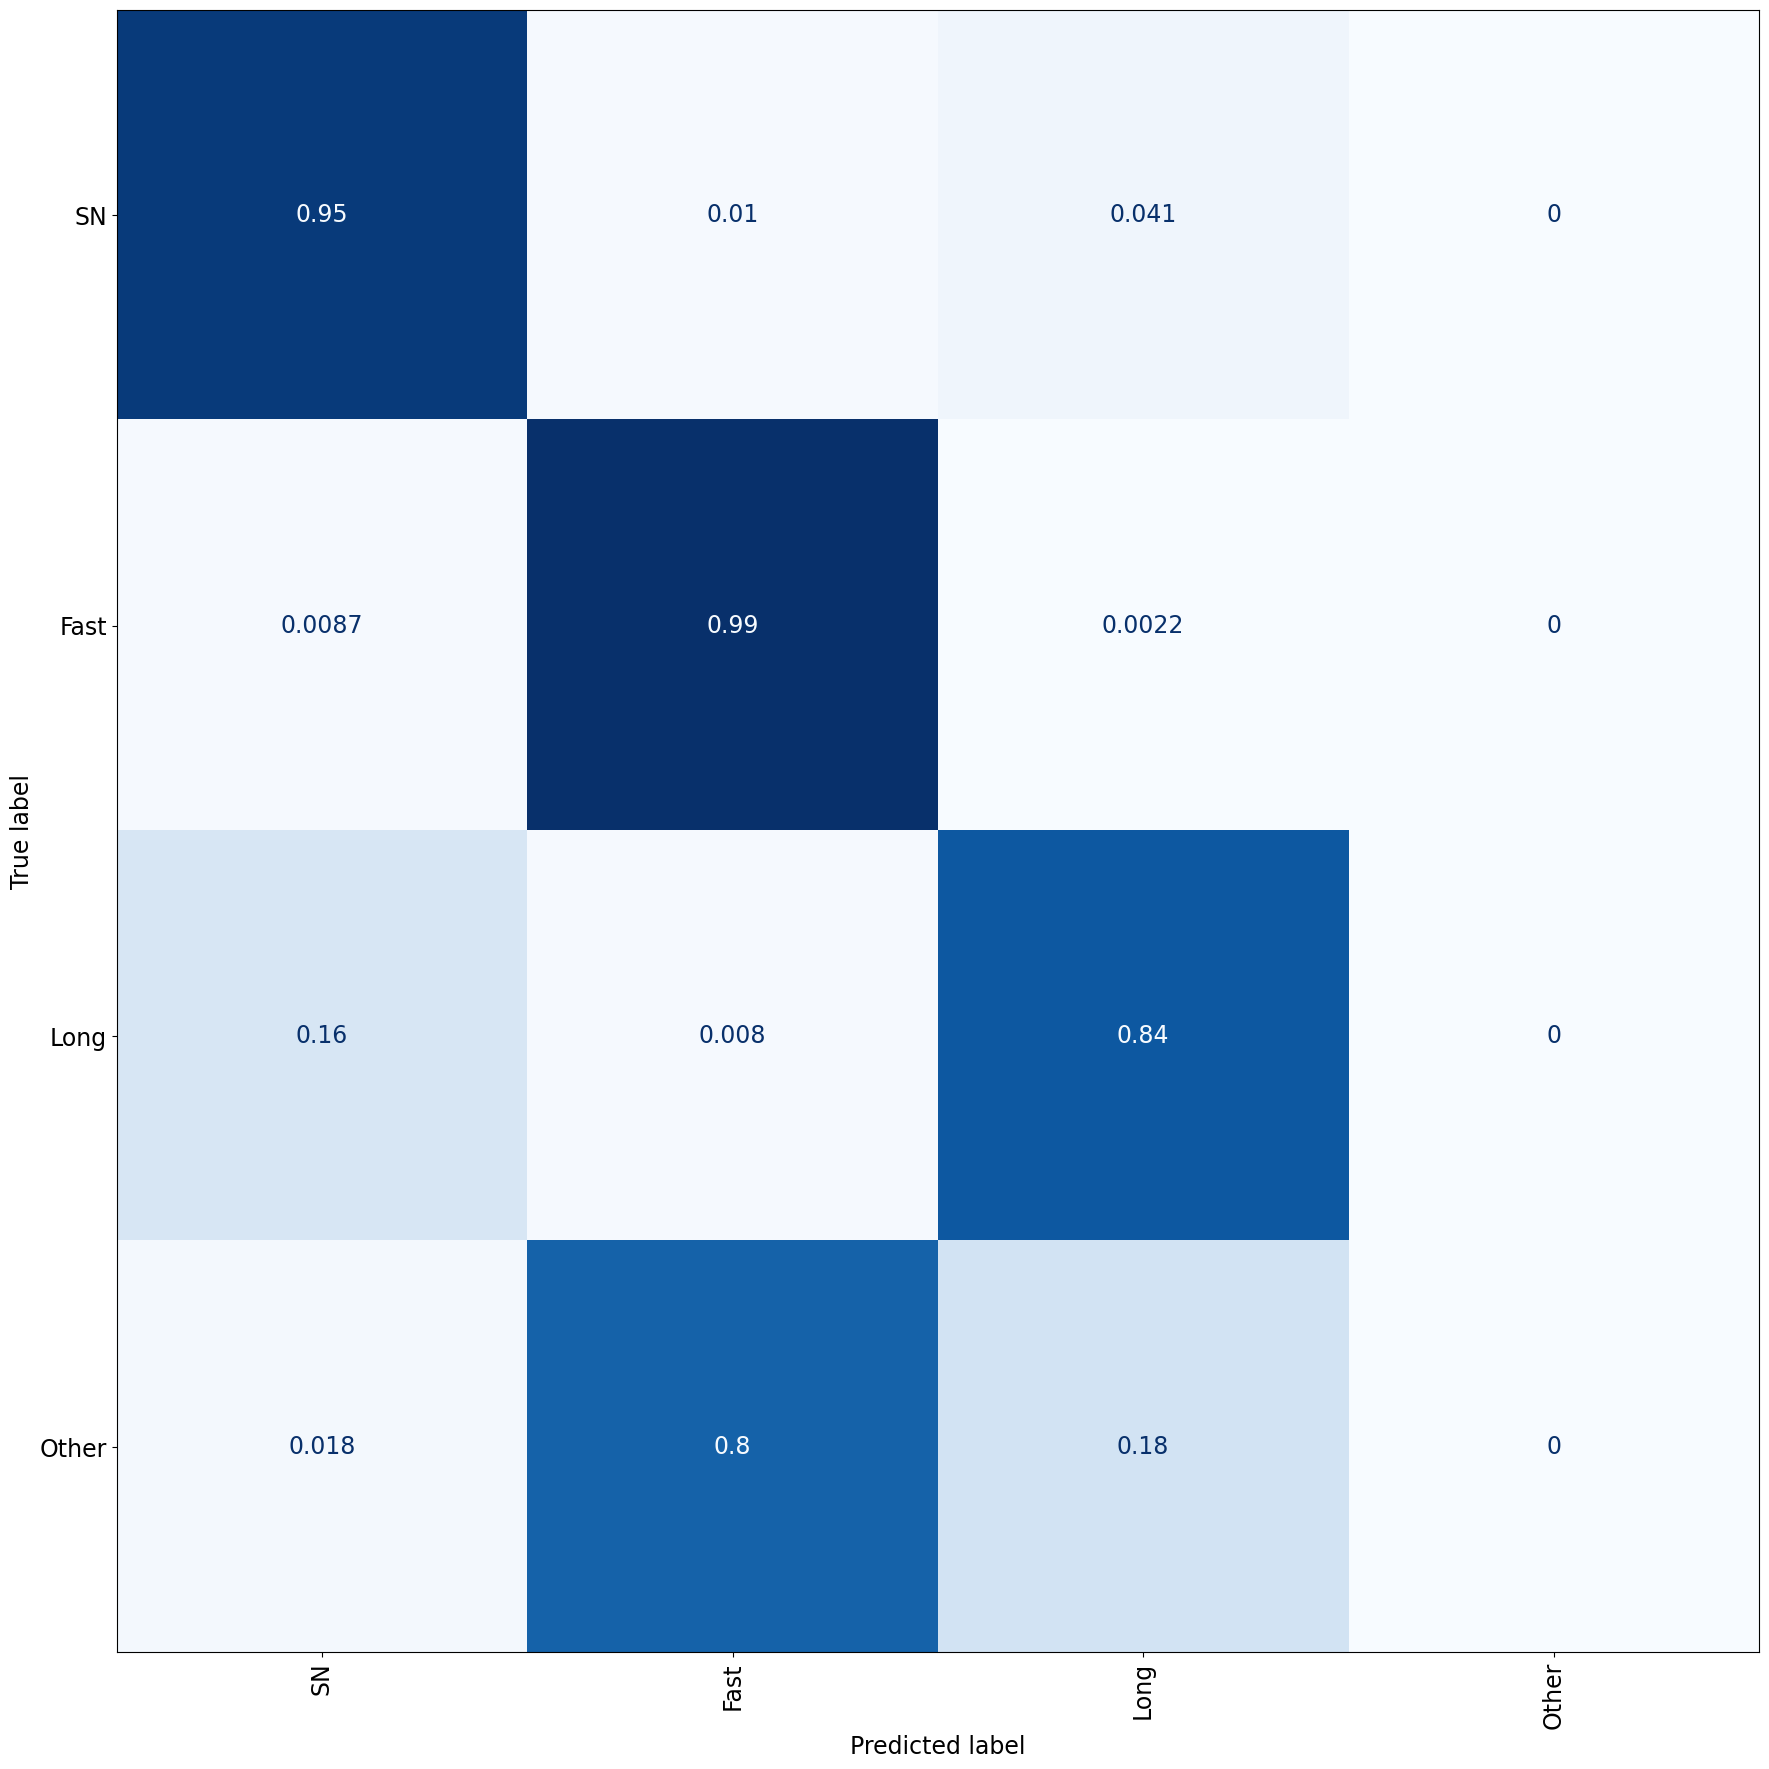

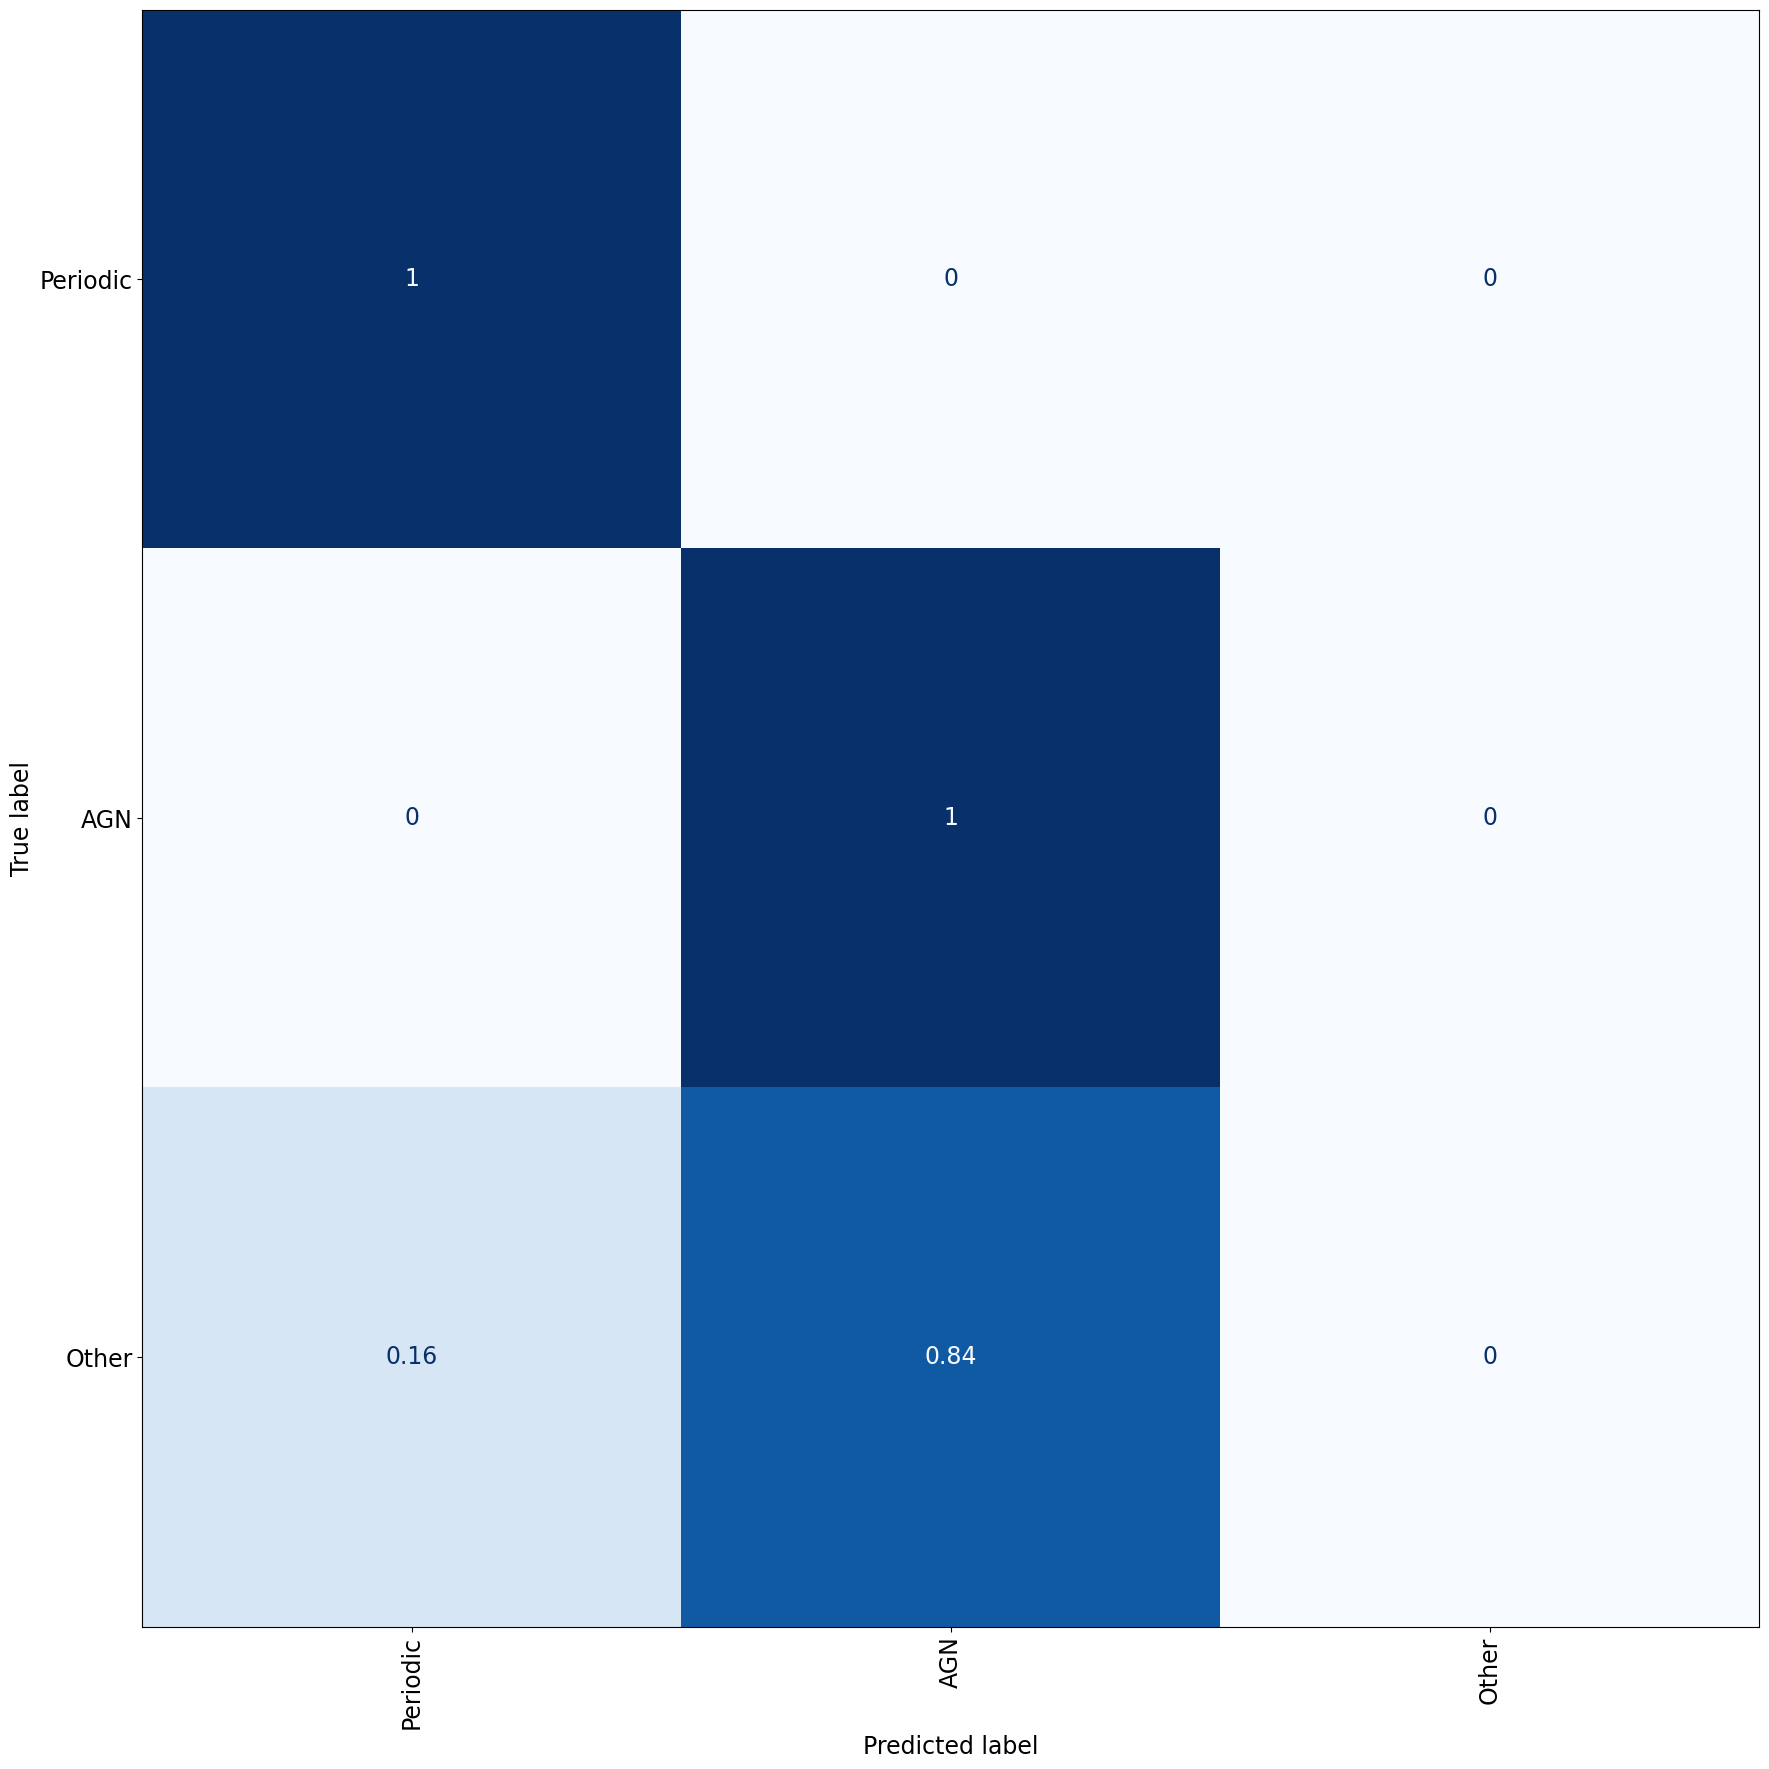

Running inference for 90% light curves...
332/332 [==============================] - 3s 8ms/step
For 90% of the light curve, these are the statistics


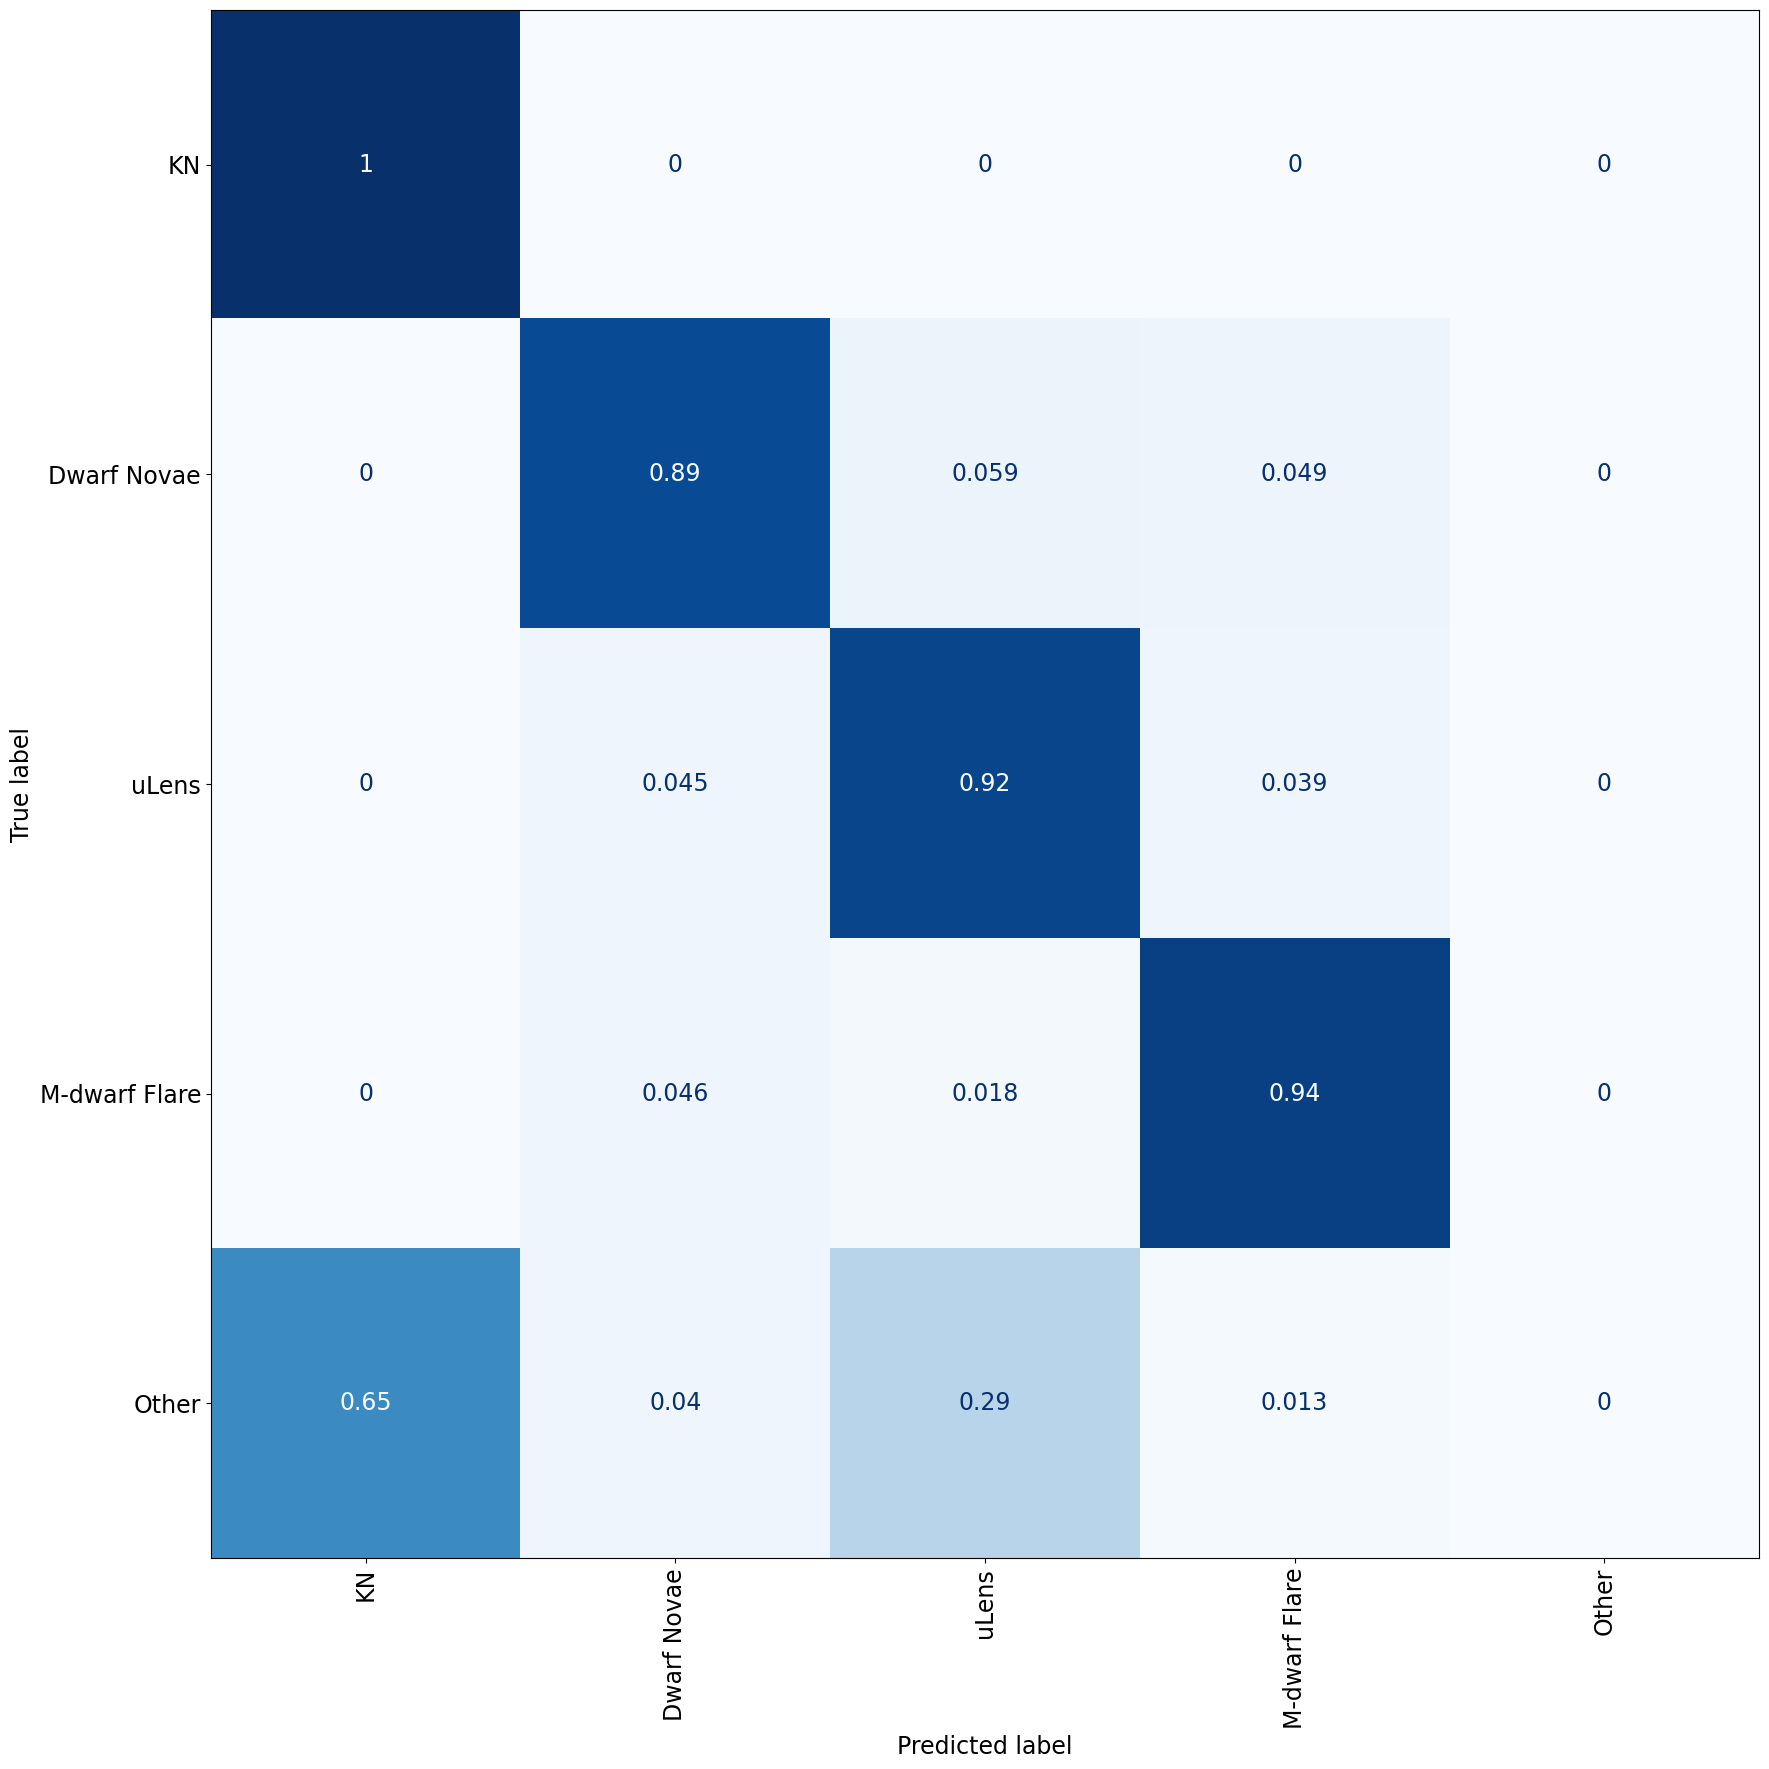

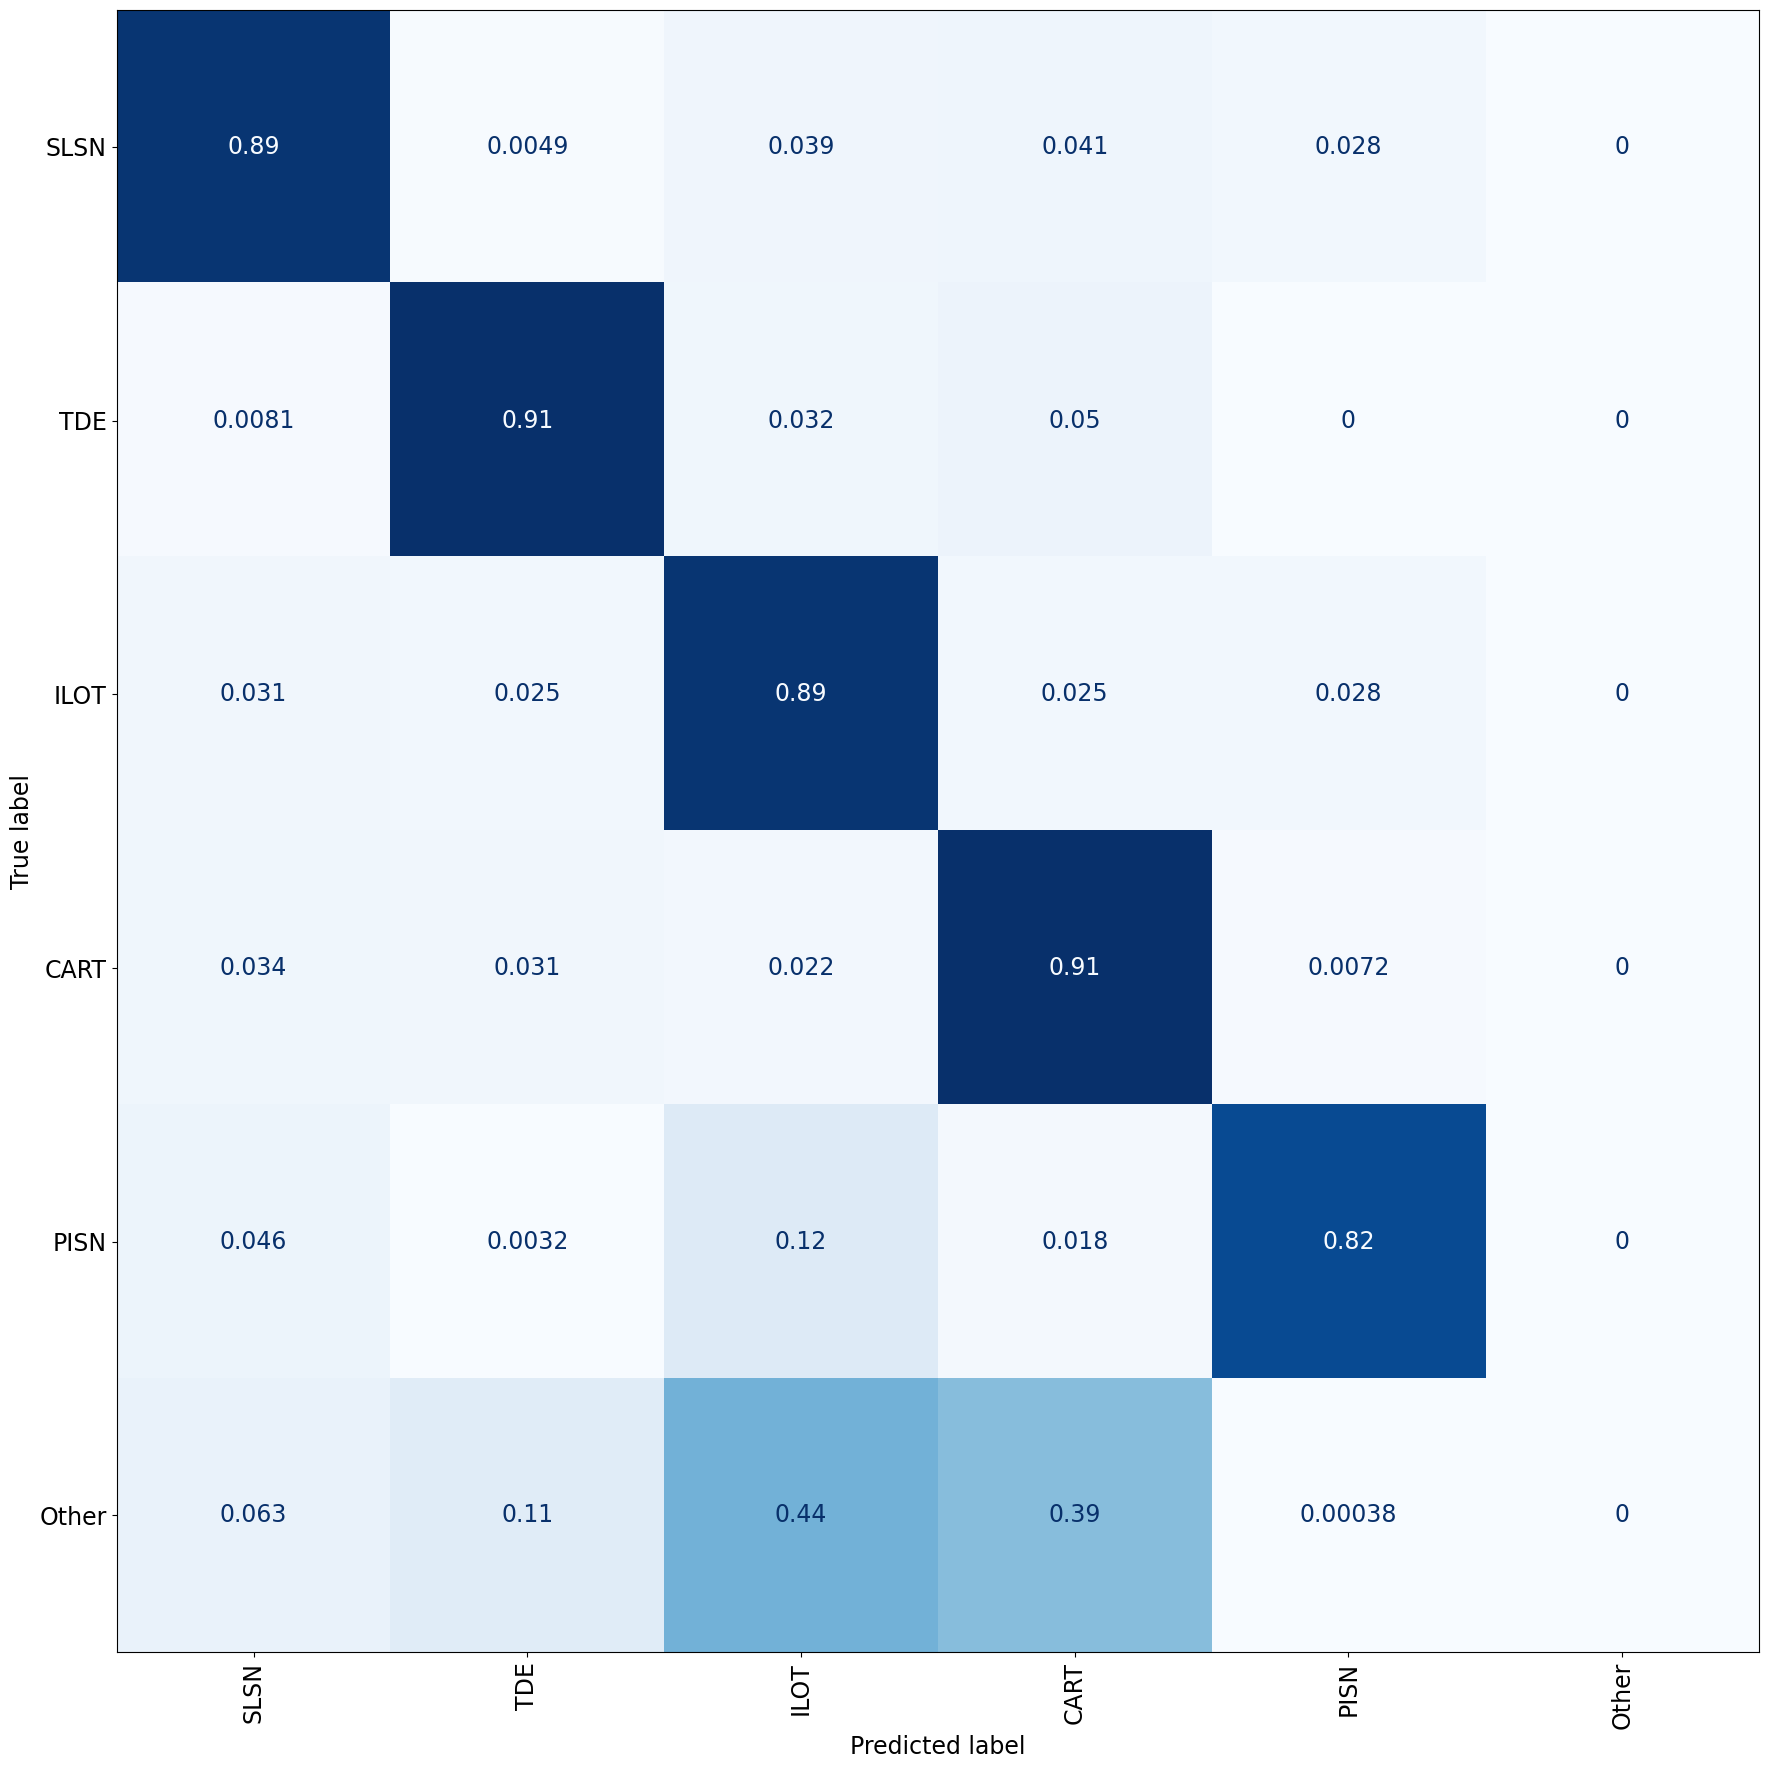

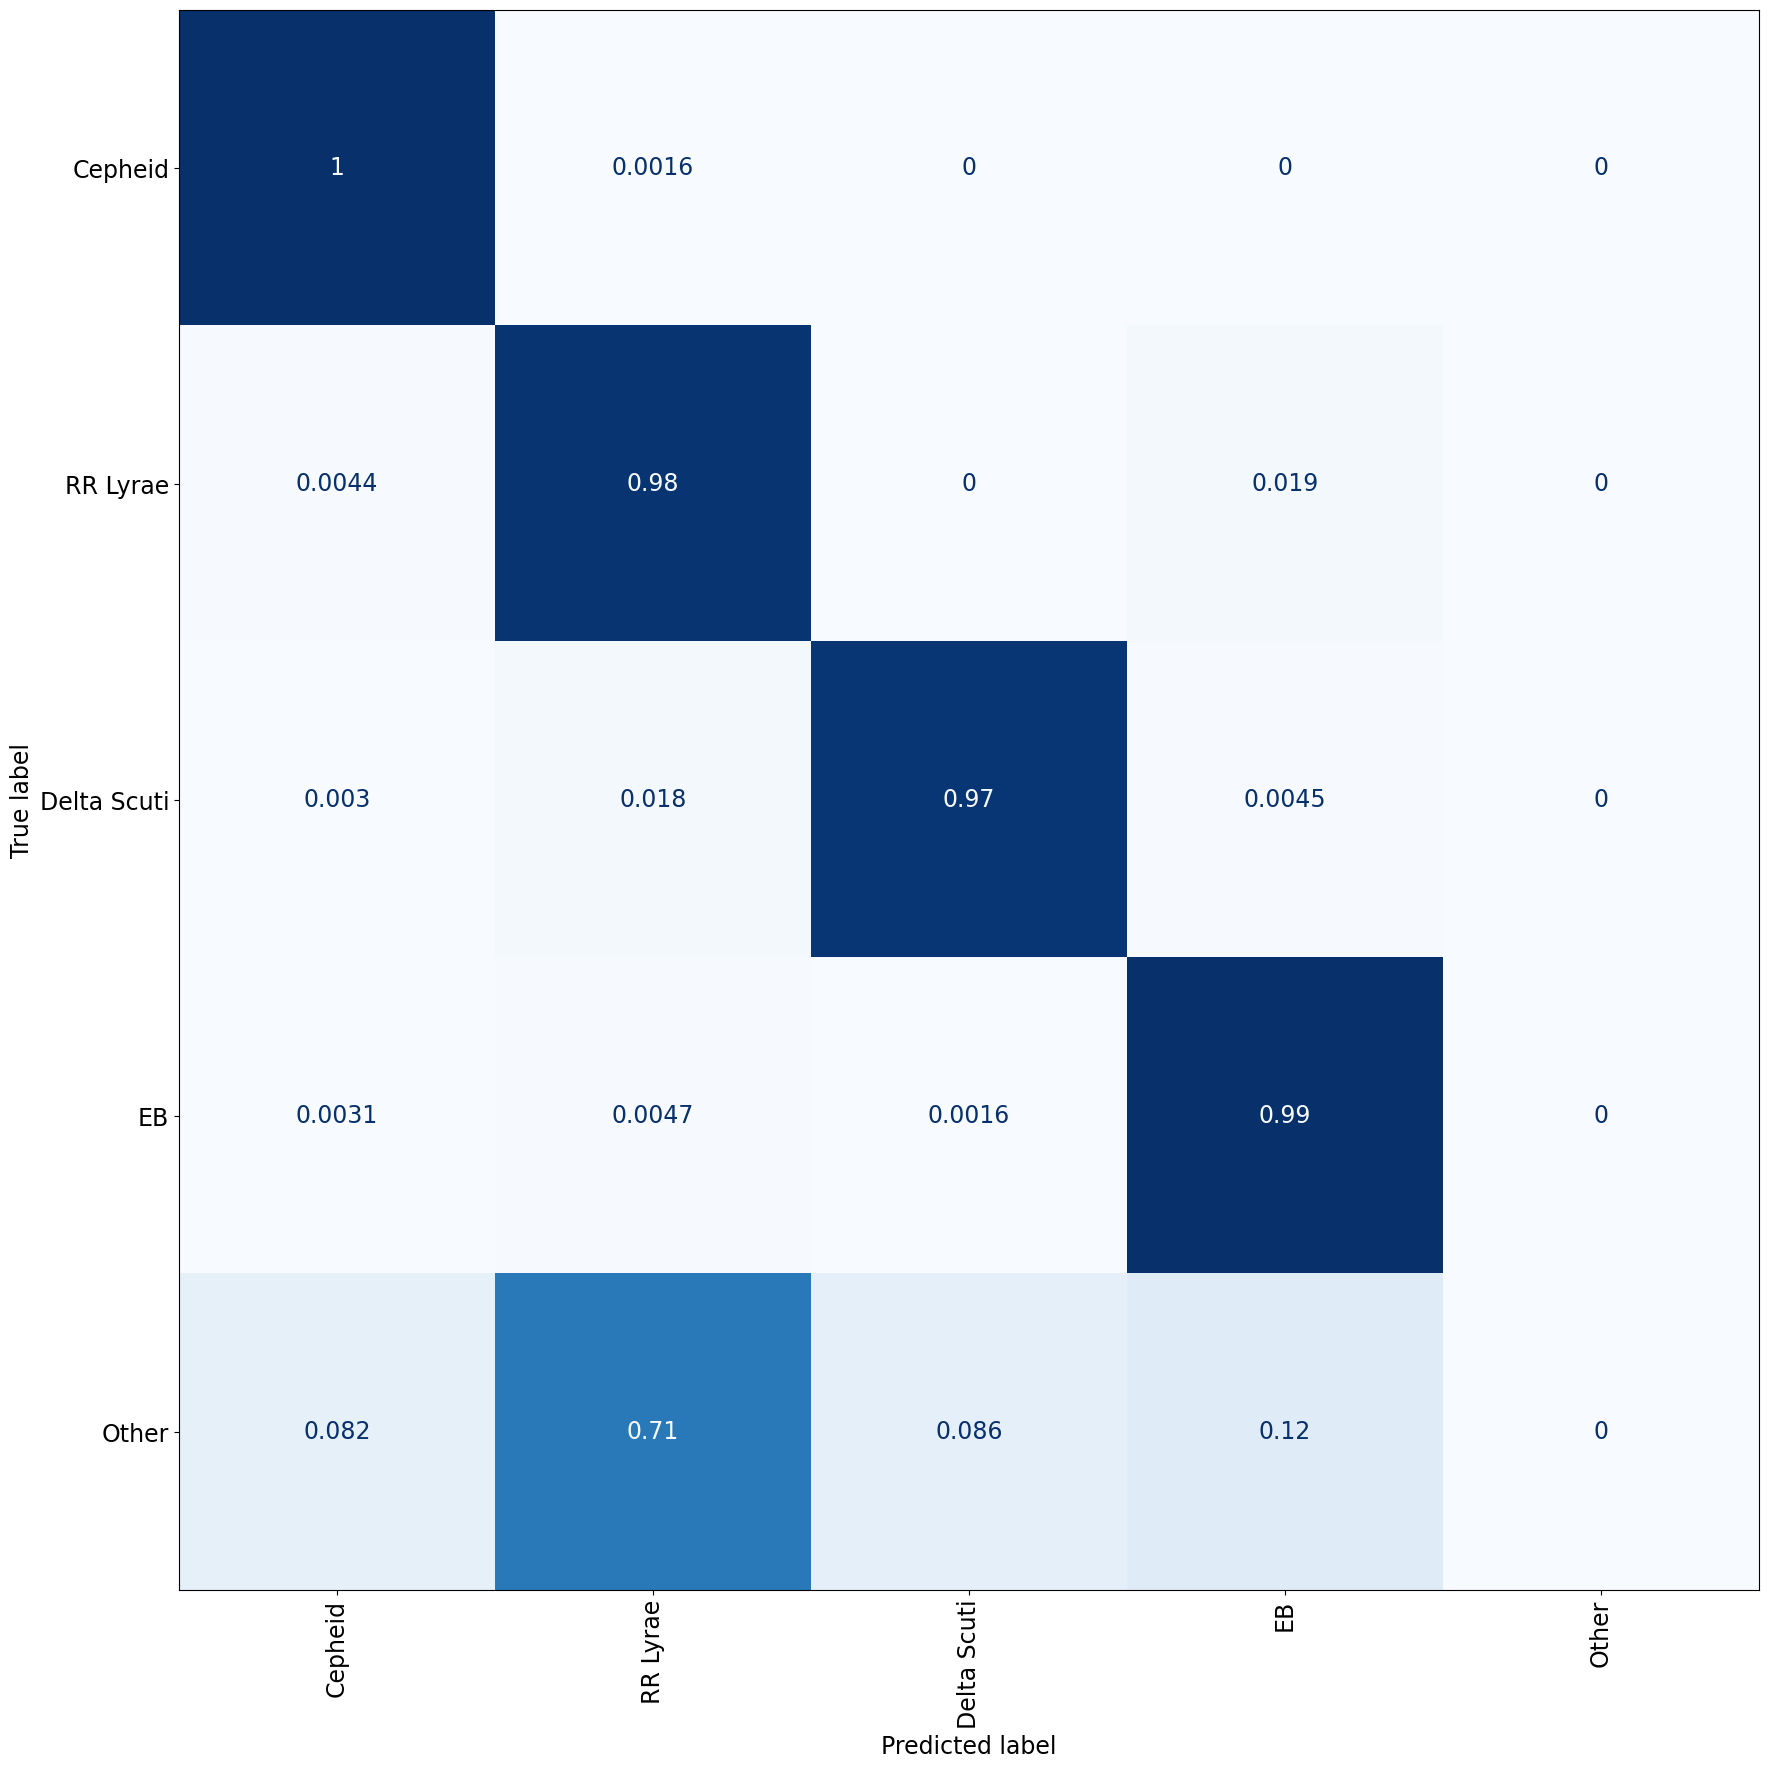

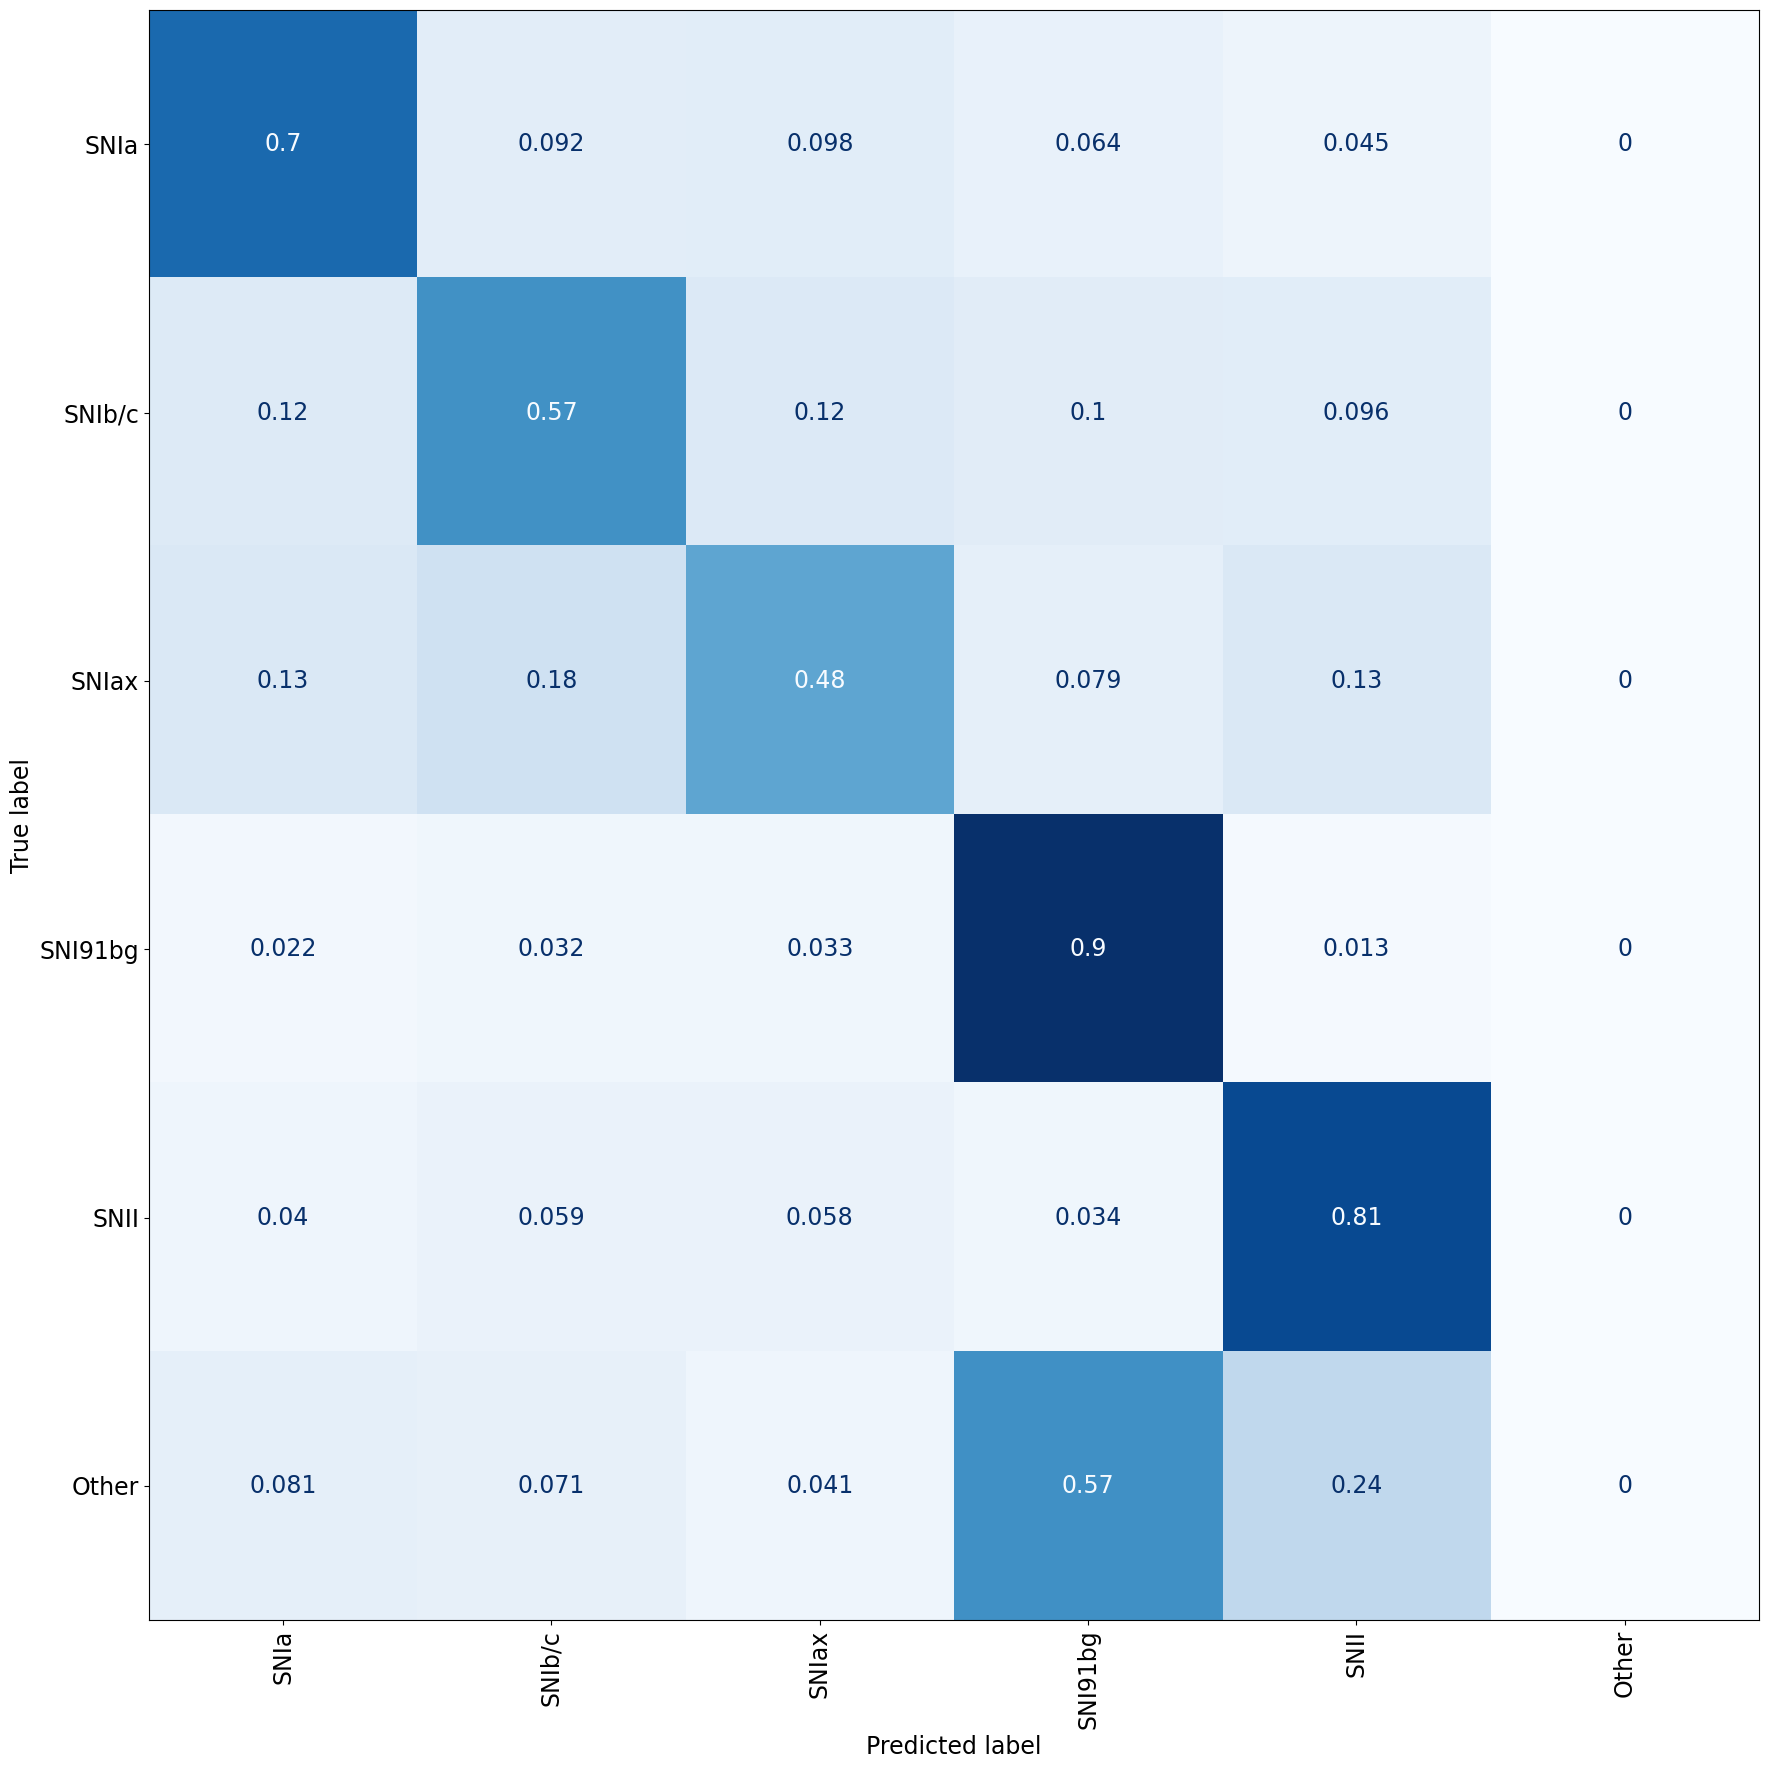

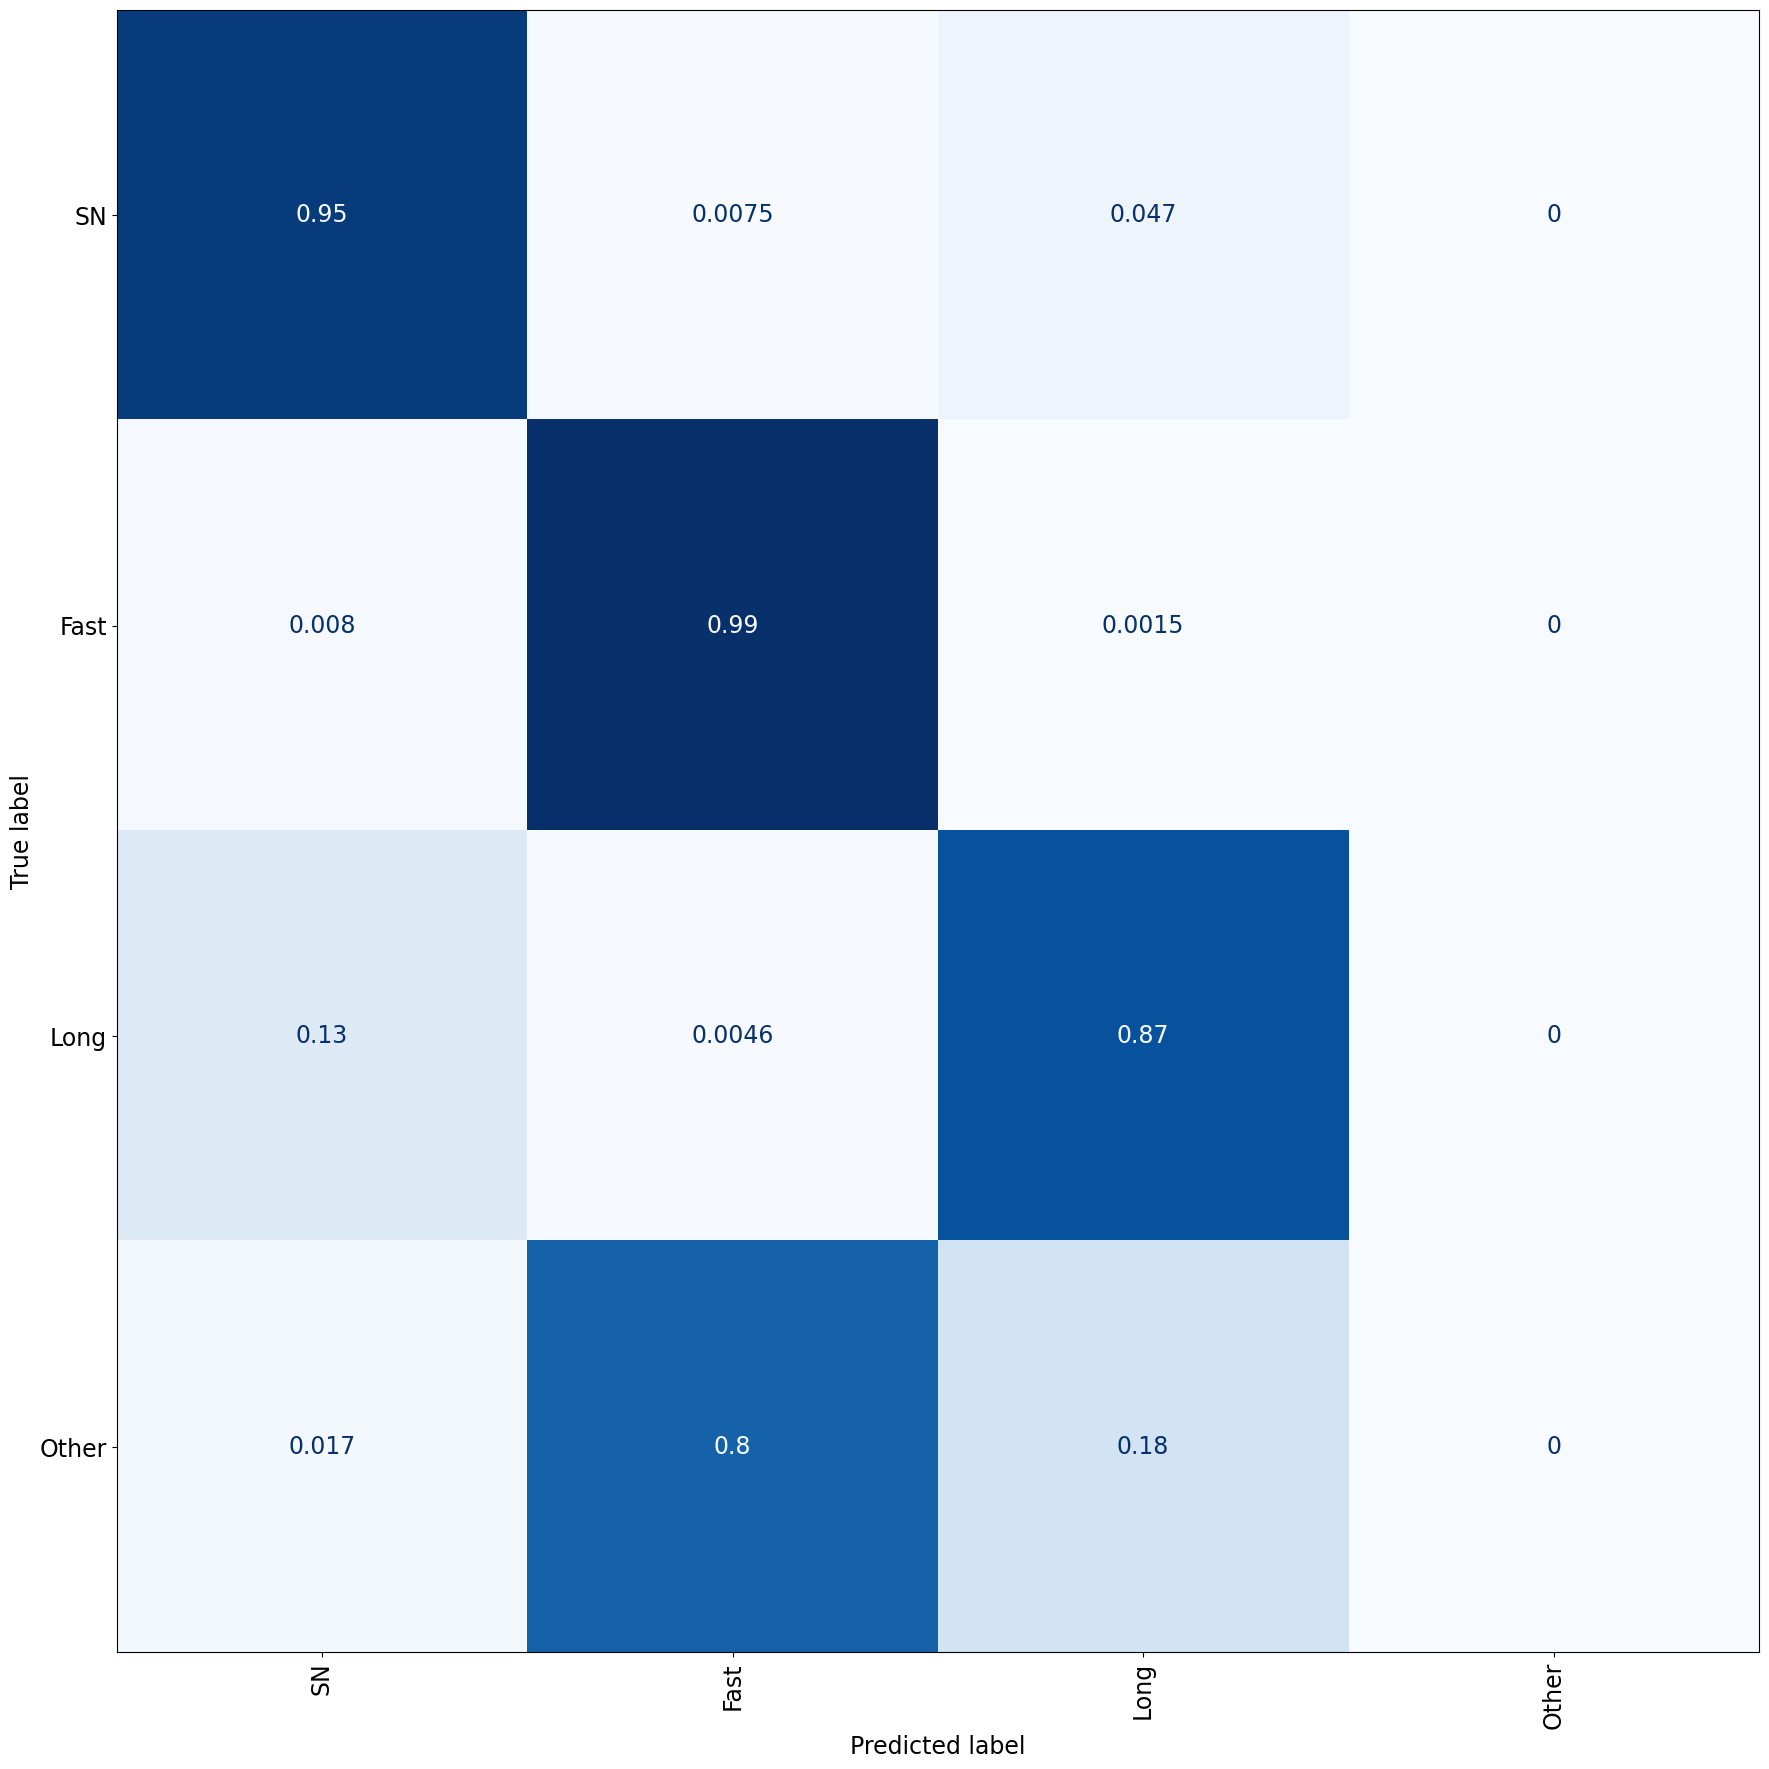

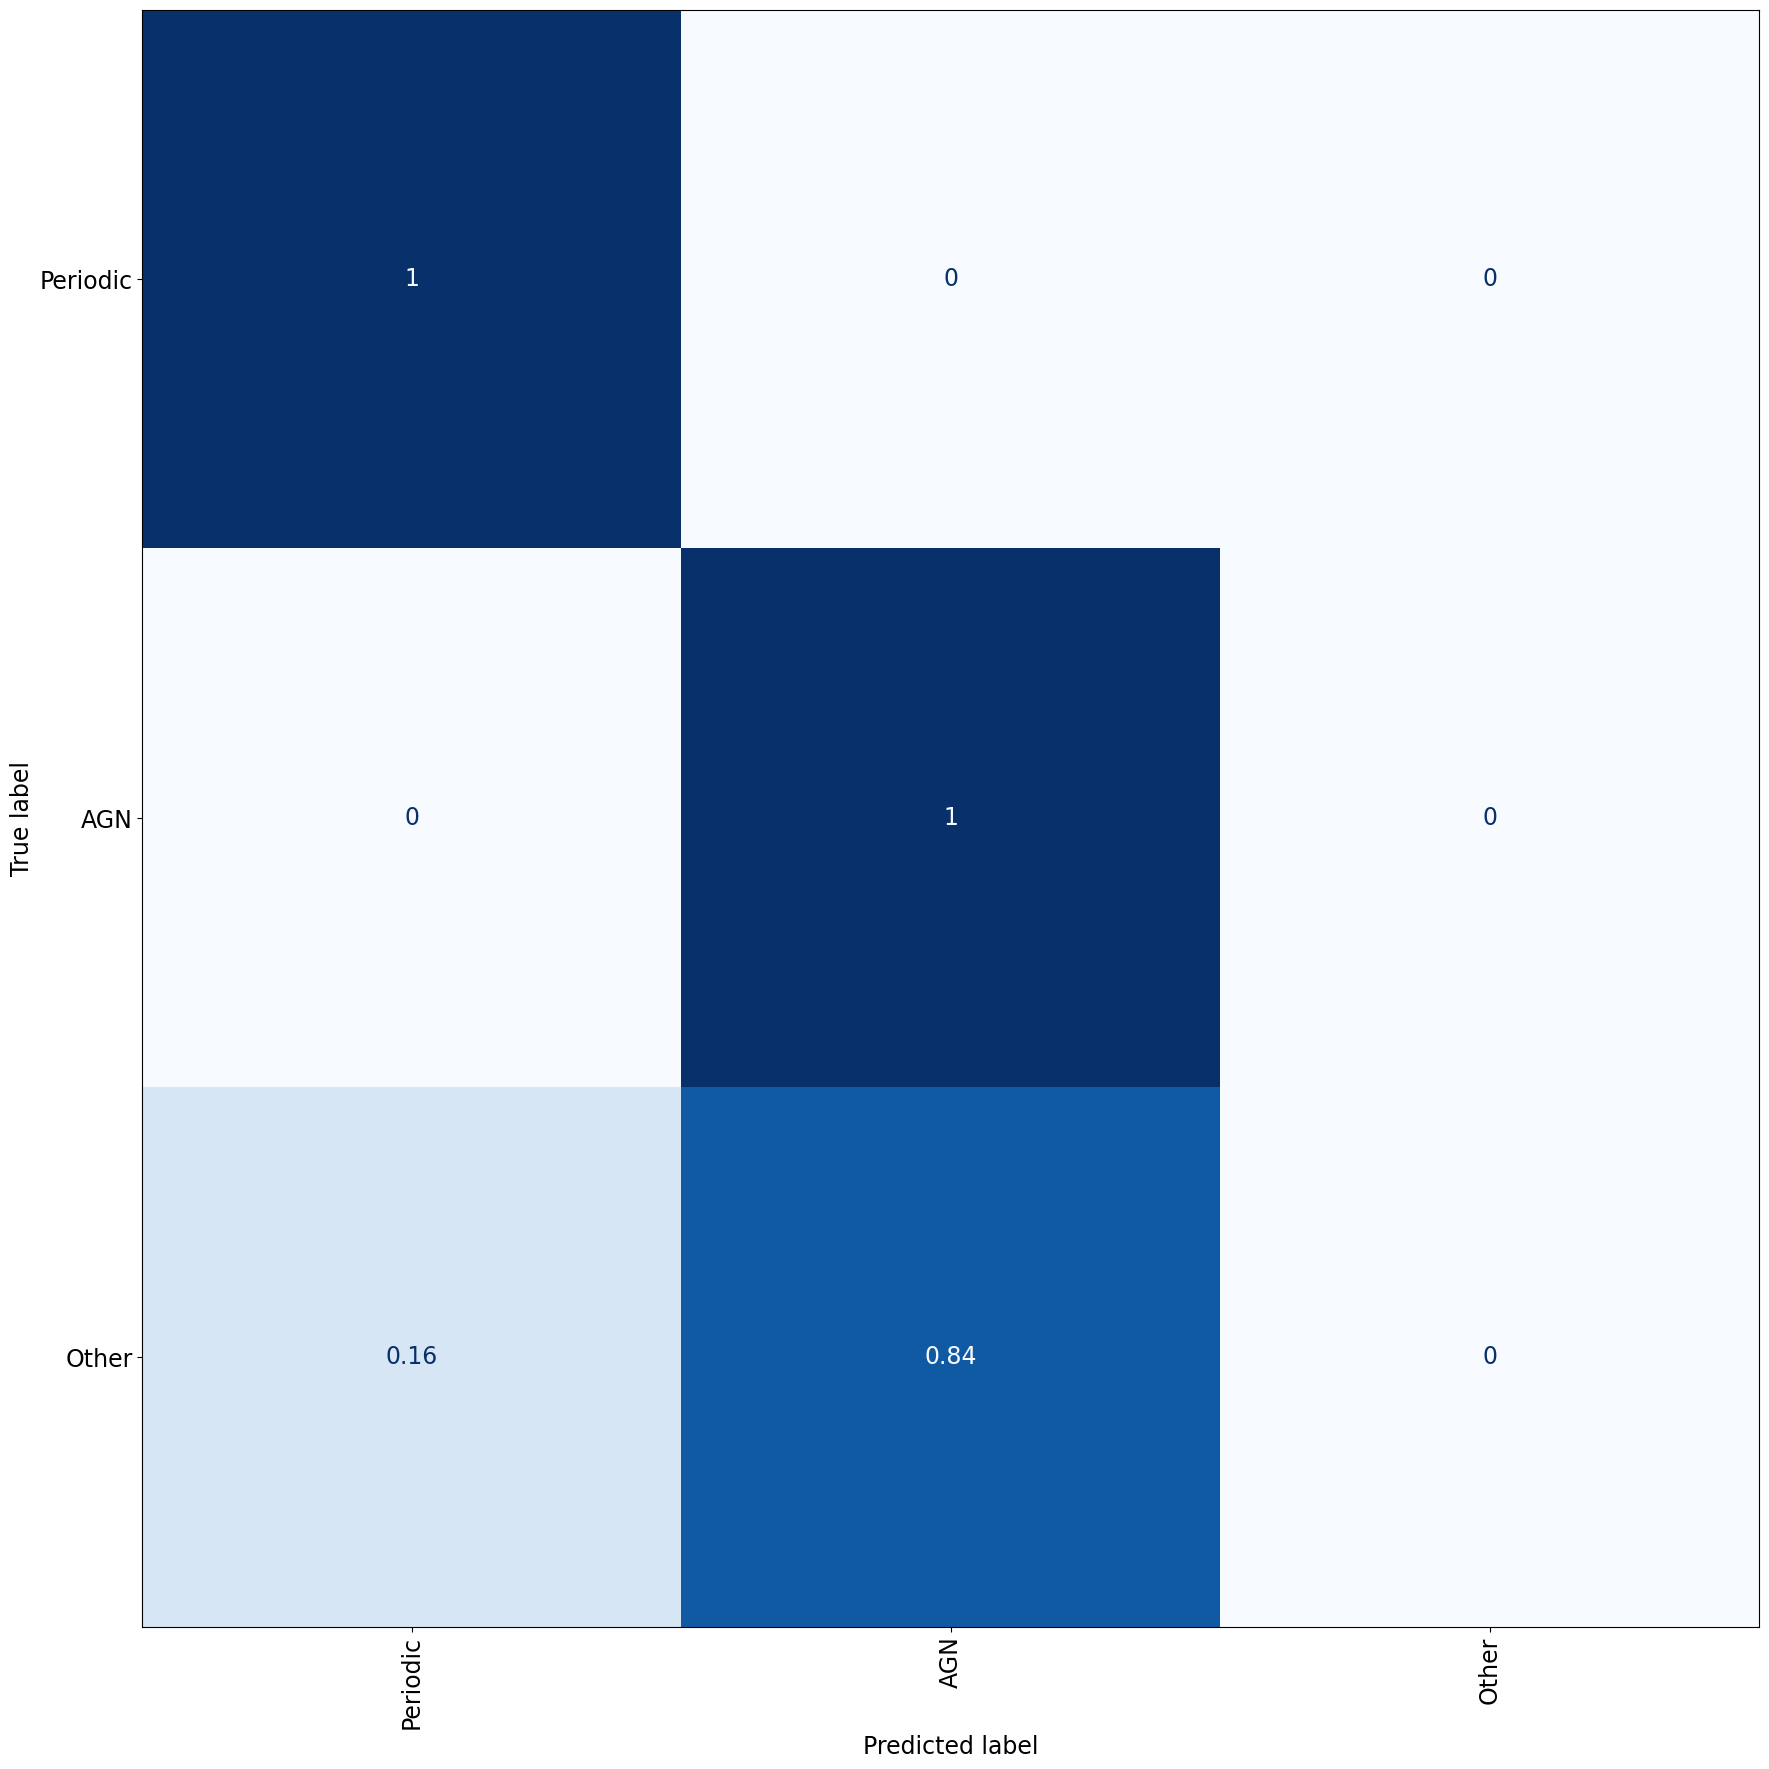

Running inference for 100% light curves...
332/332 [==============================] - 3s 9ms/step
For 100% of the light curve, these are the statistics


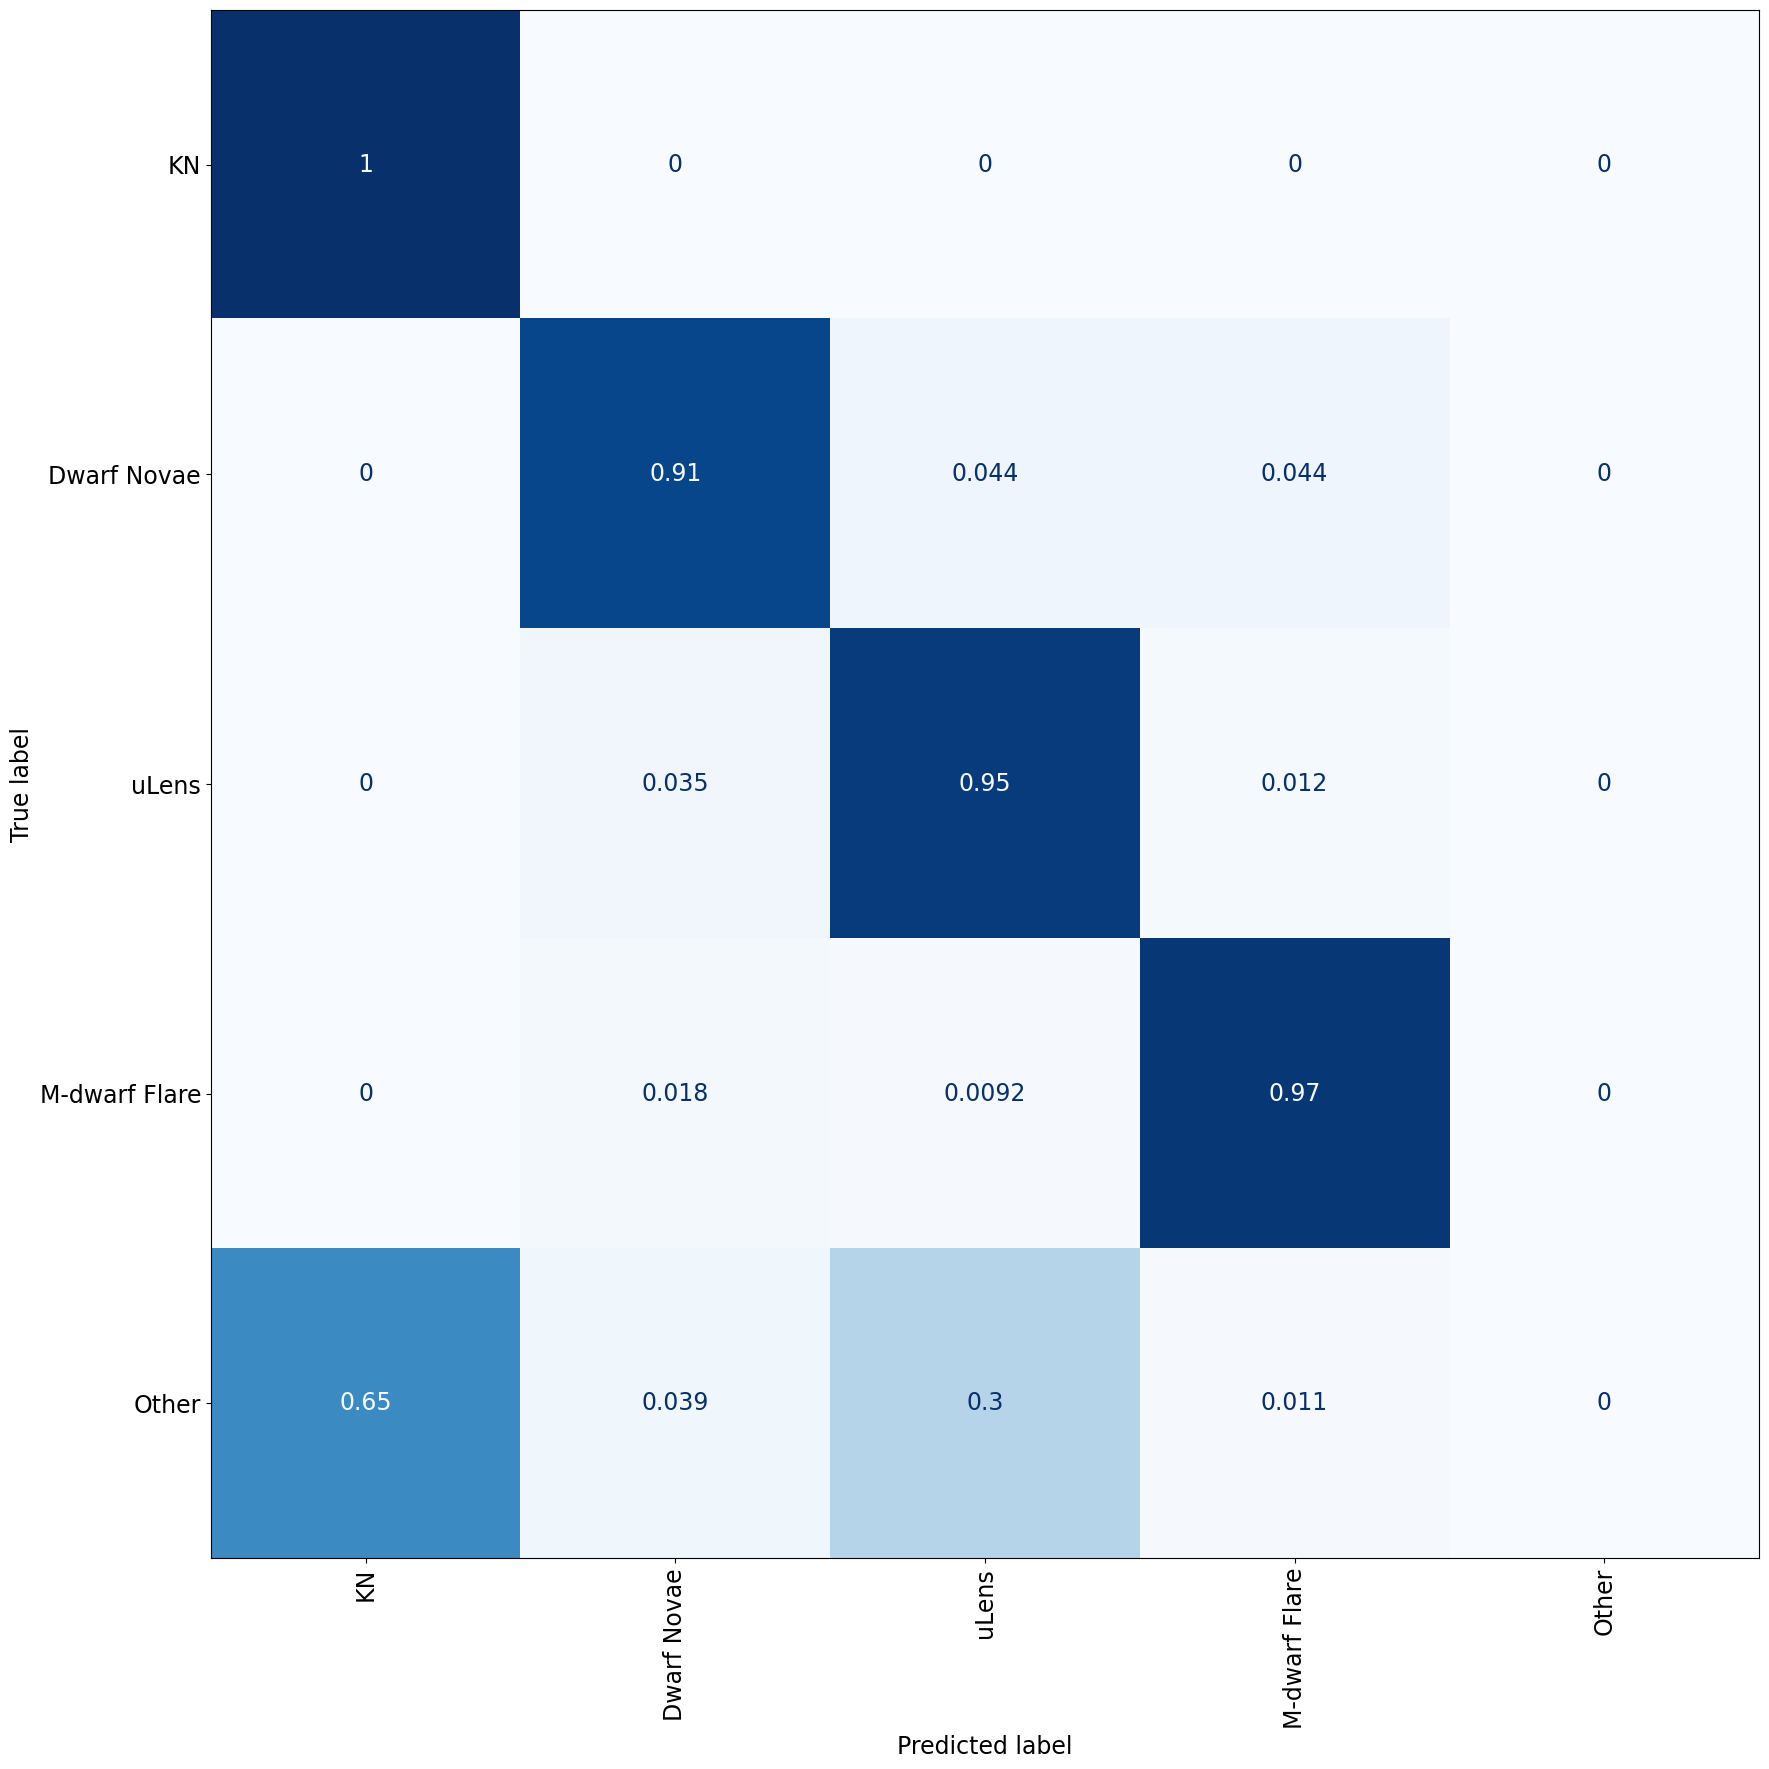

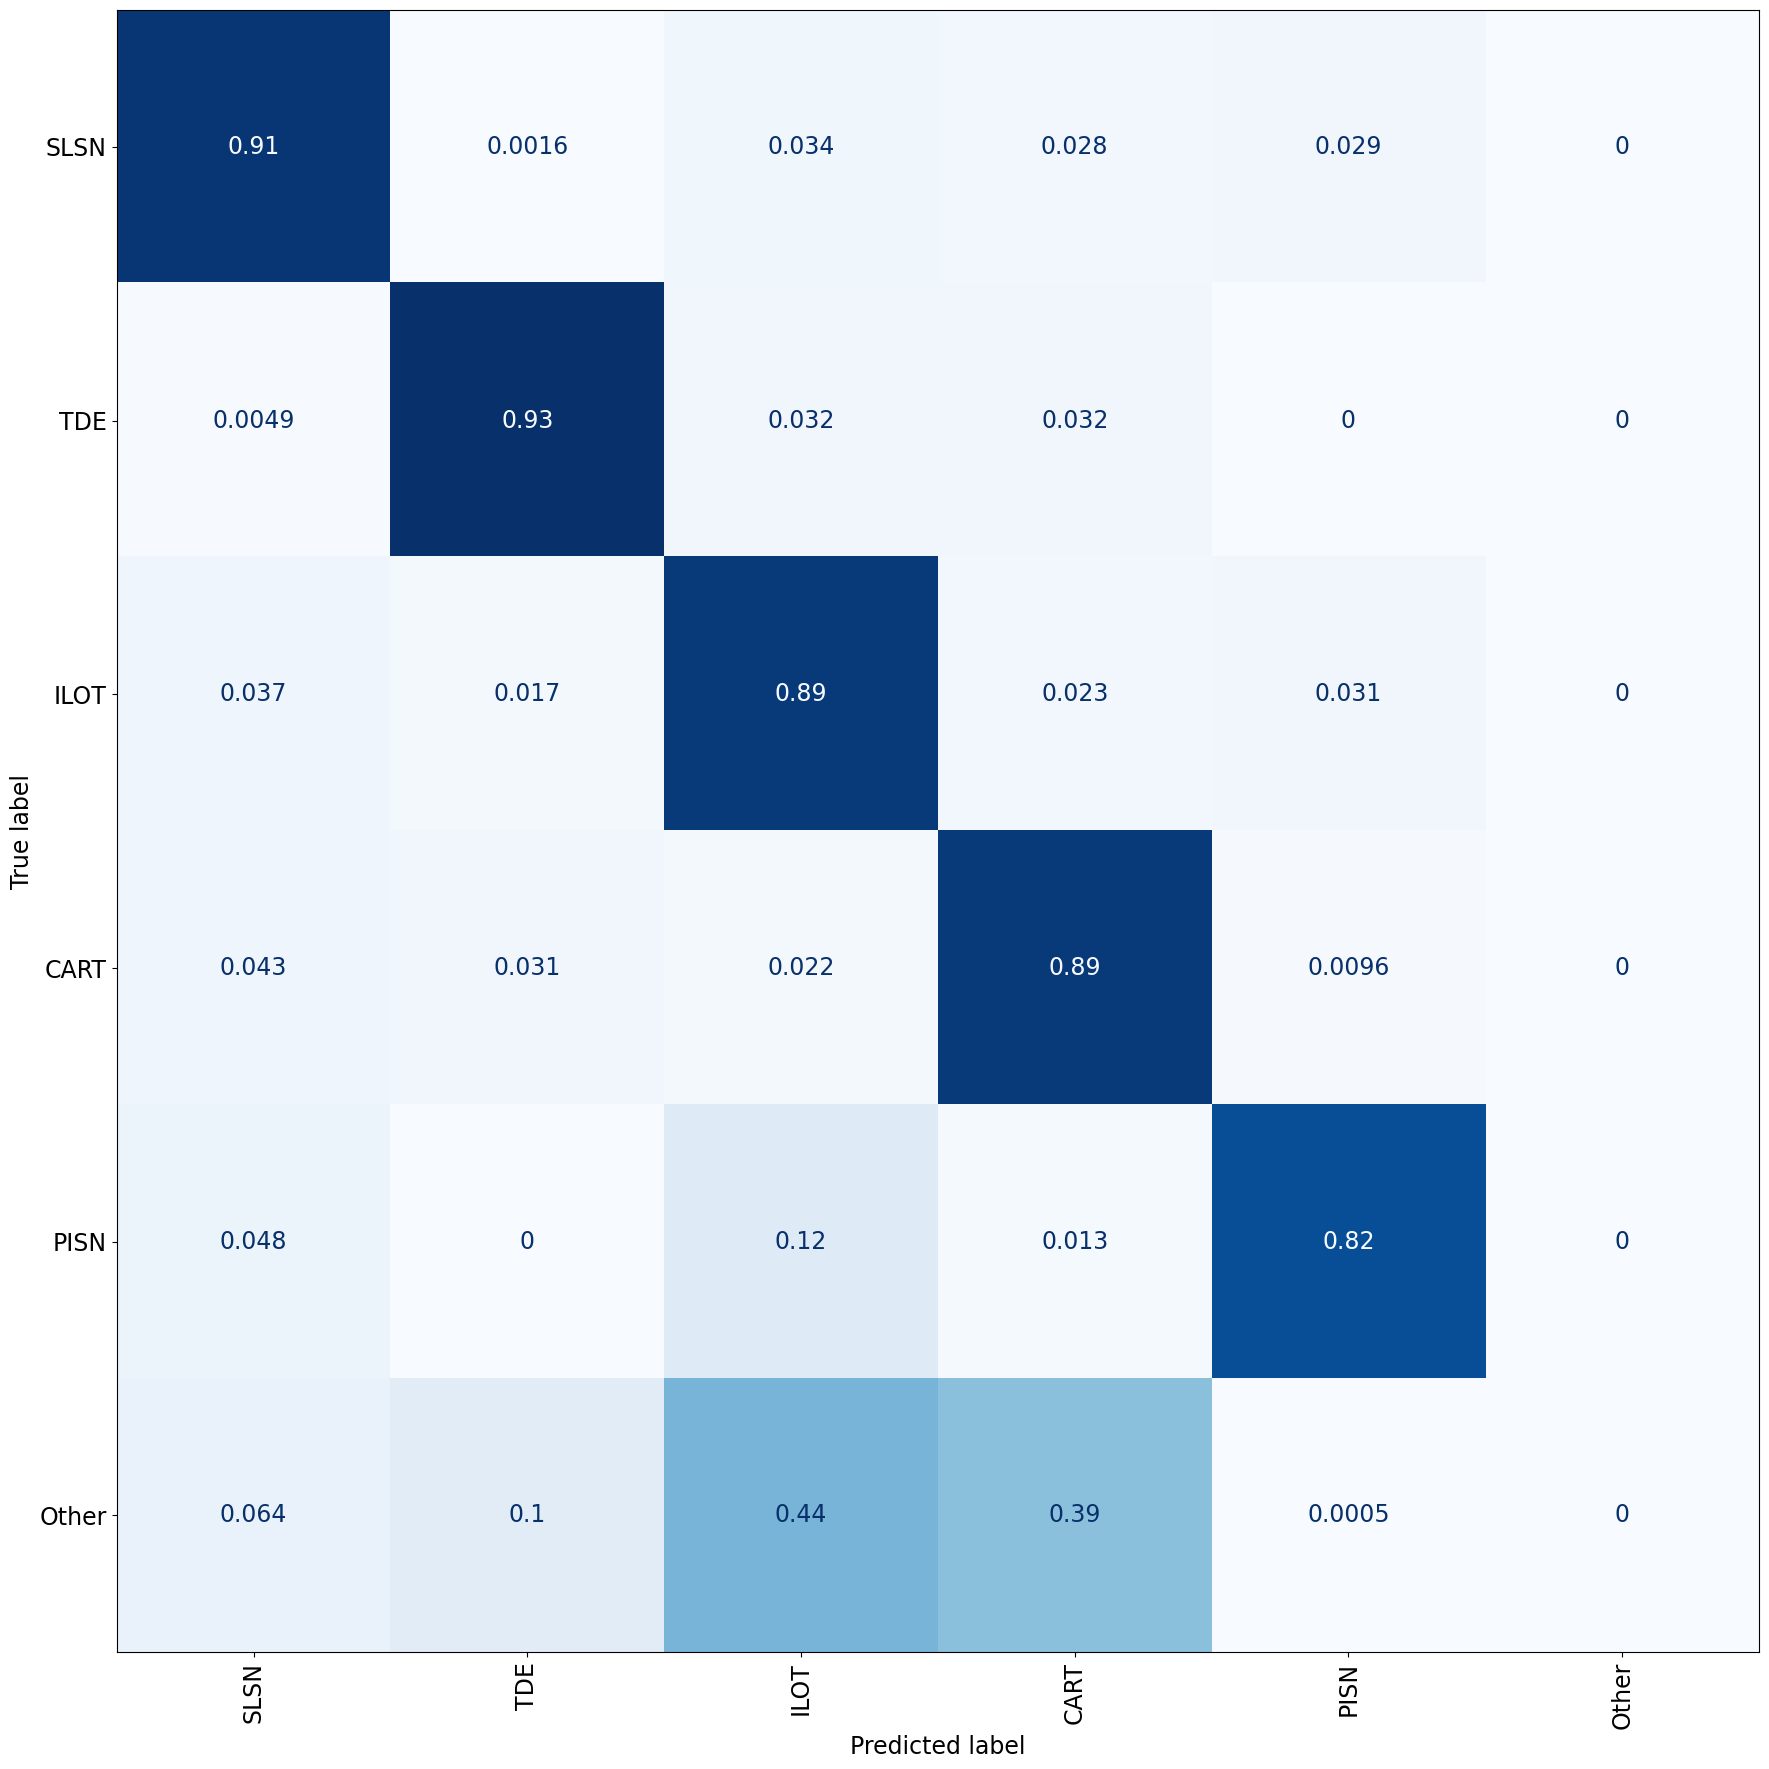

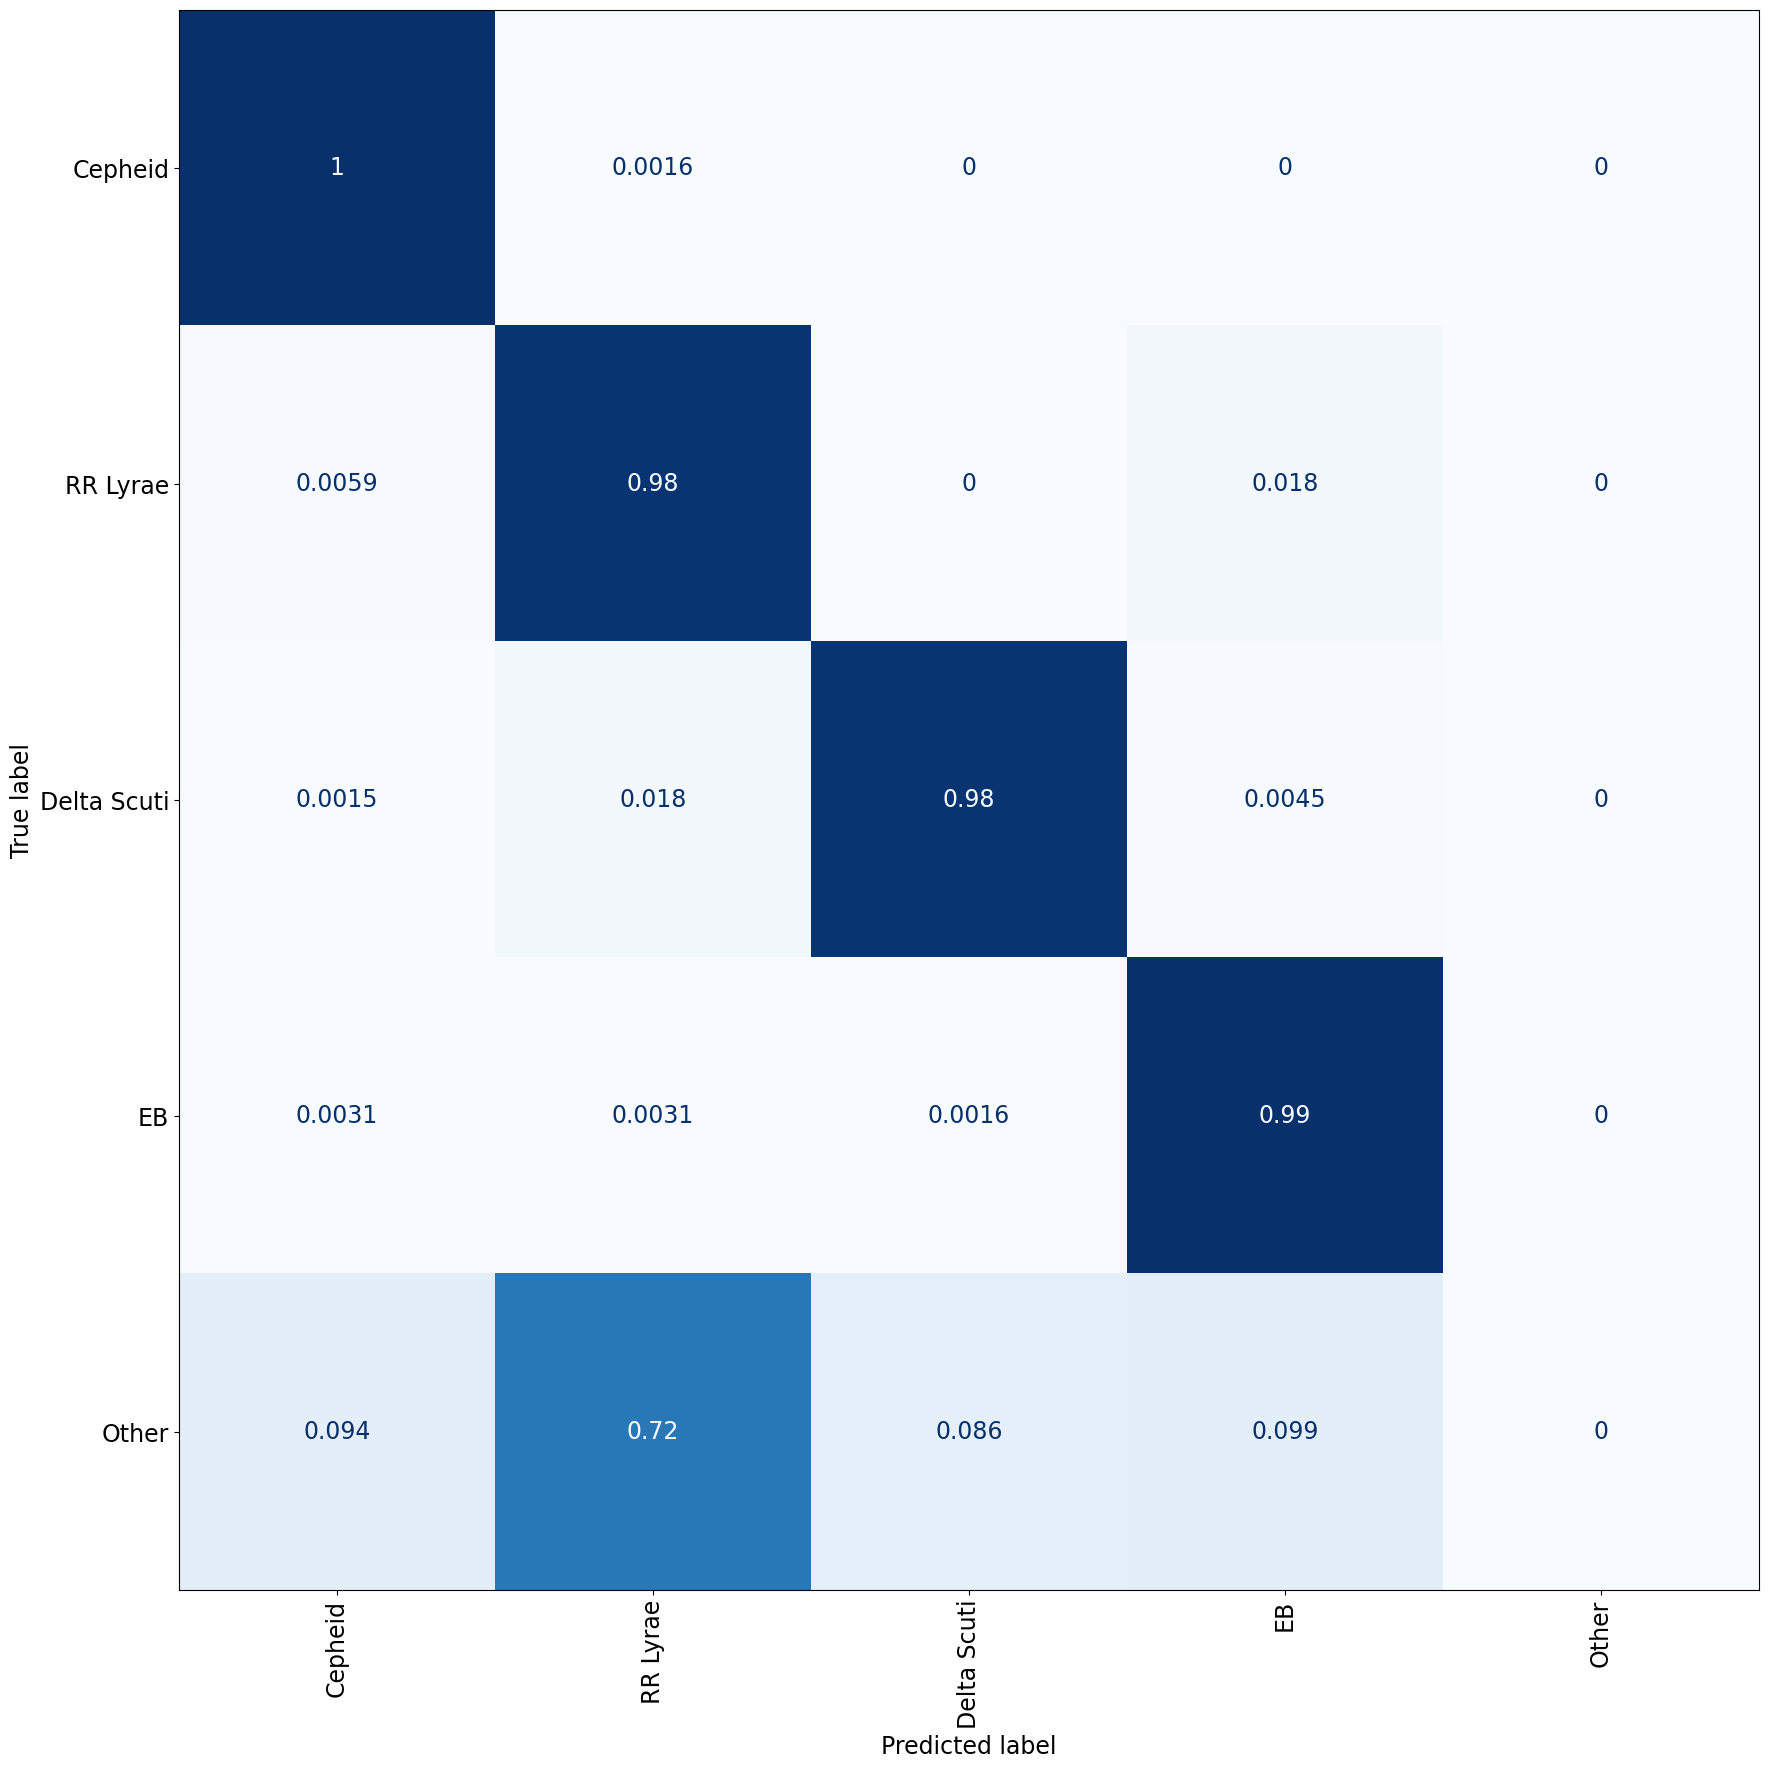

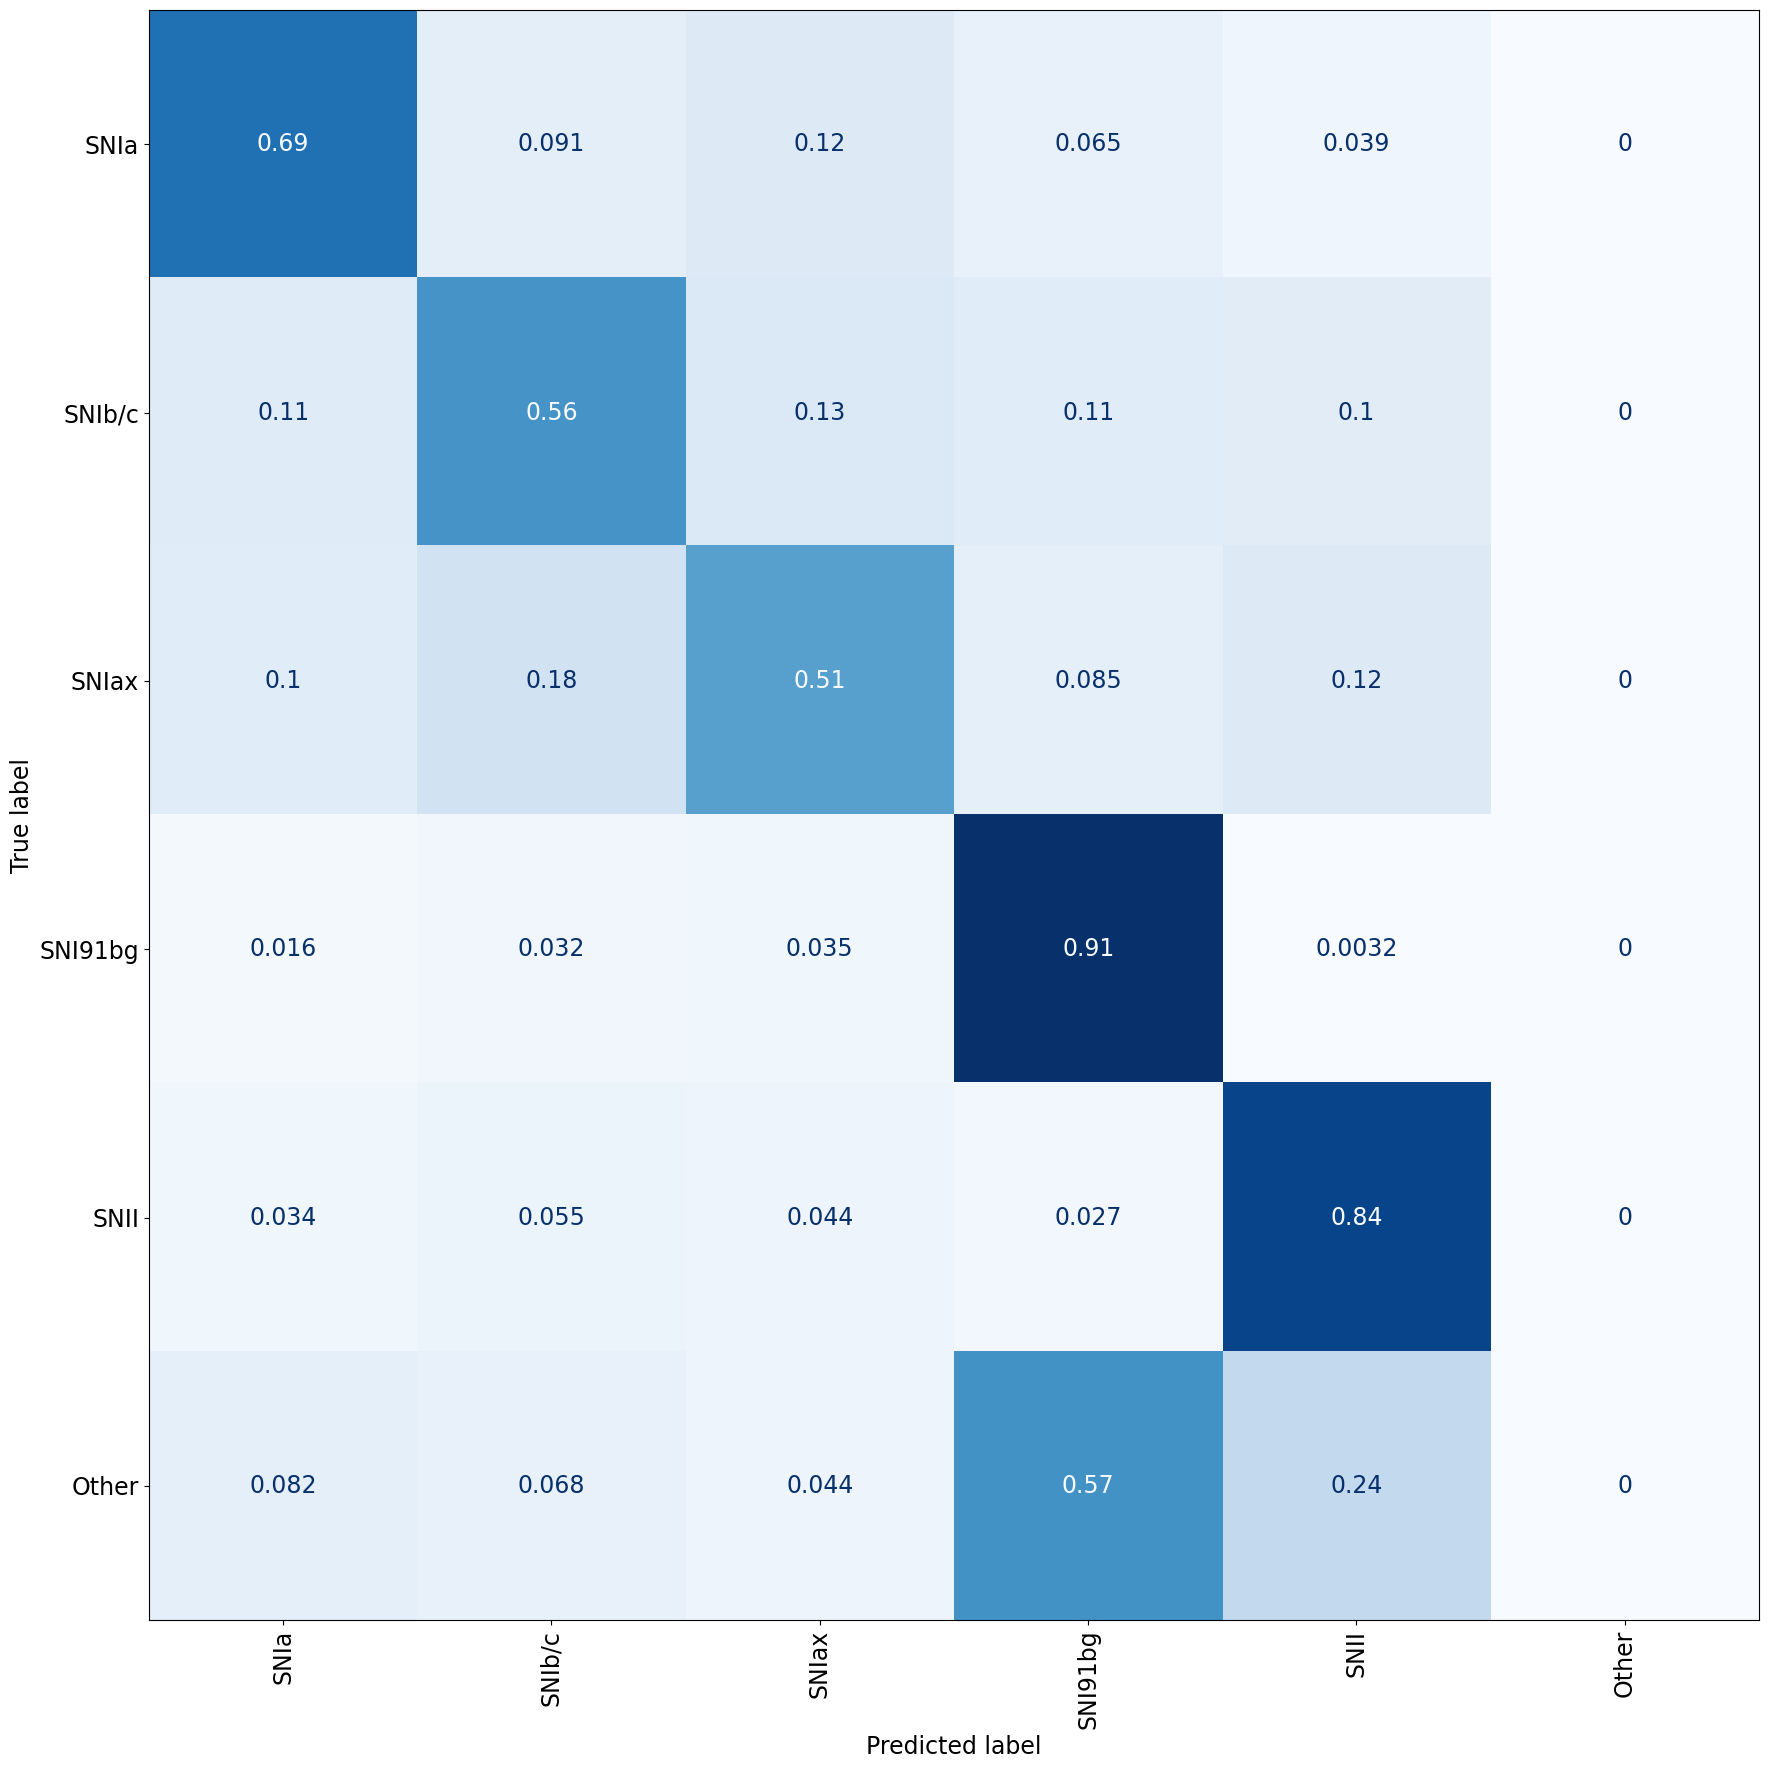

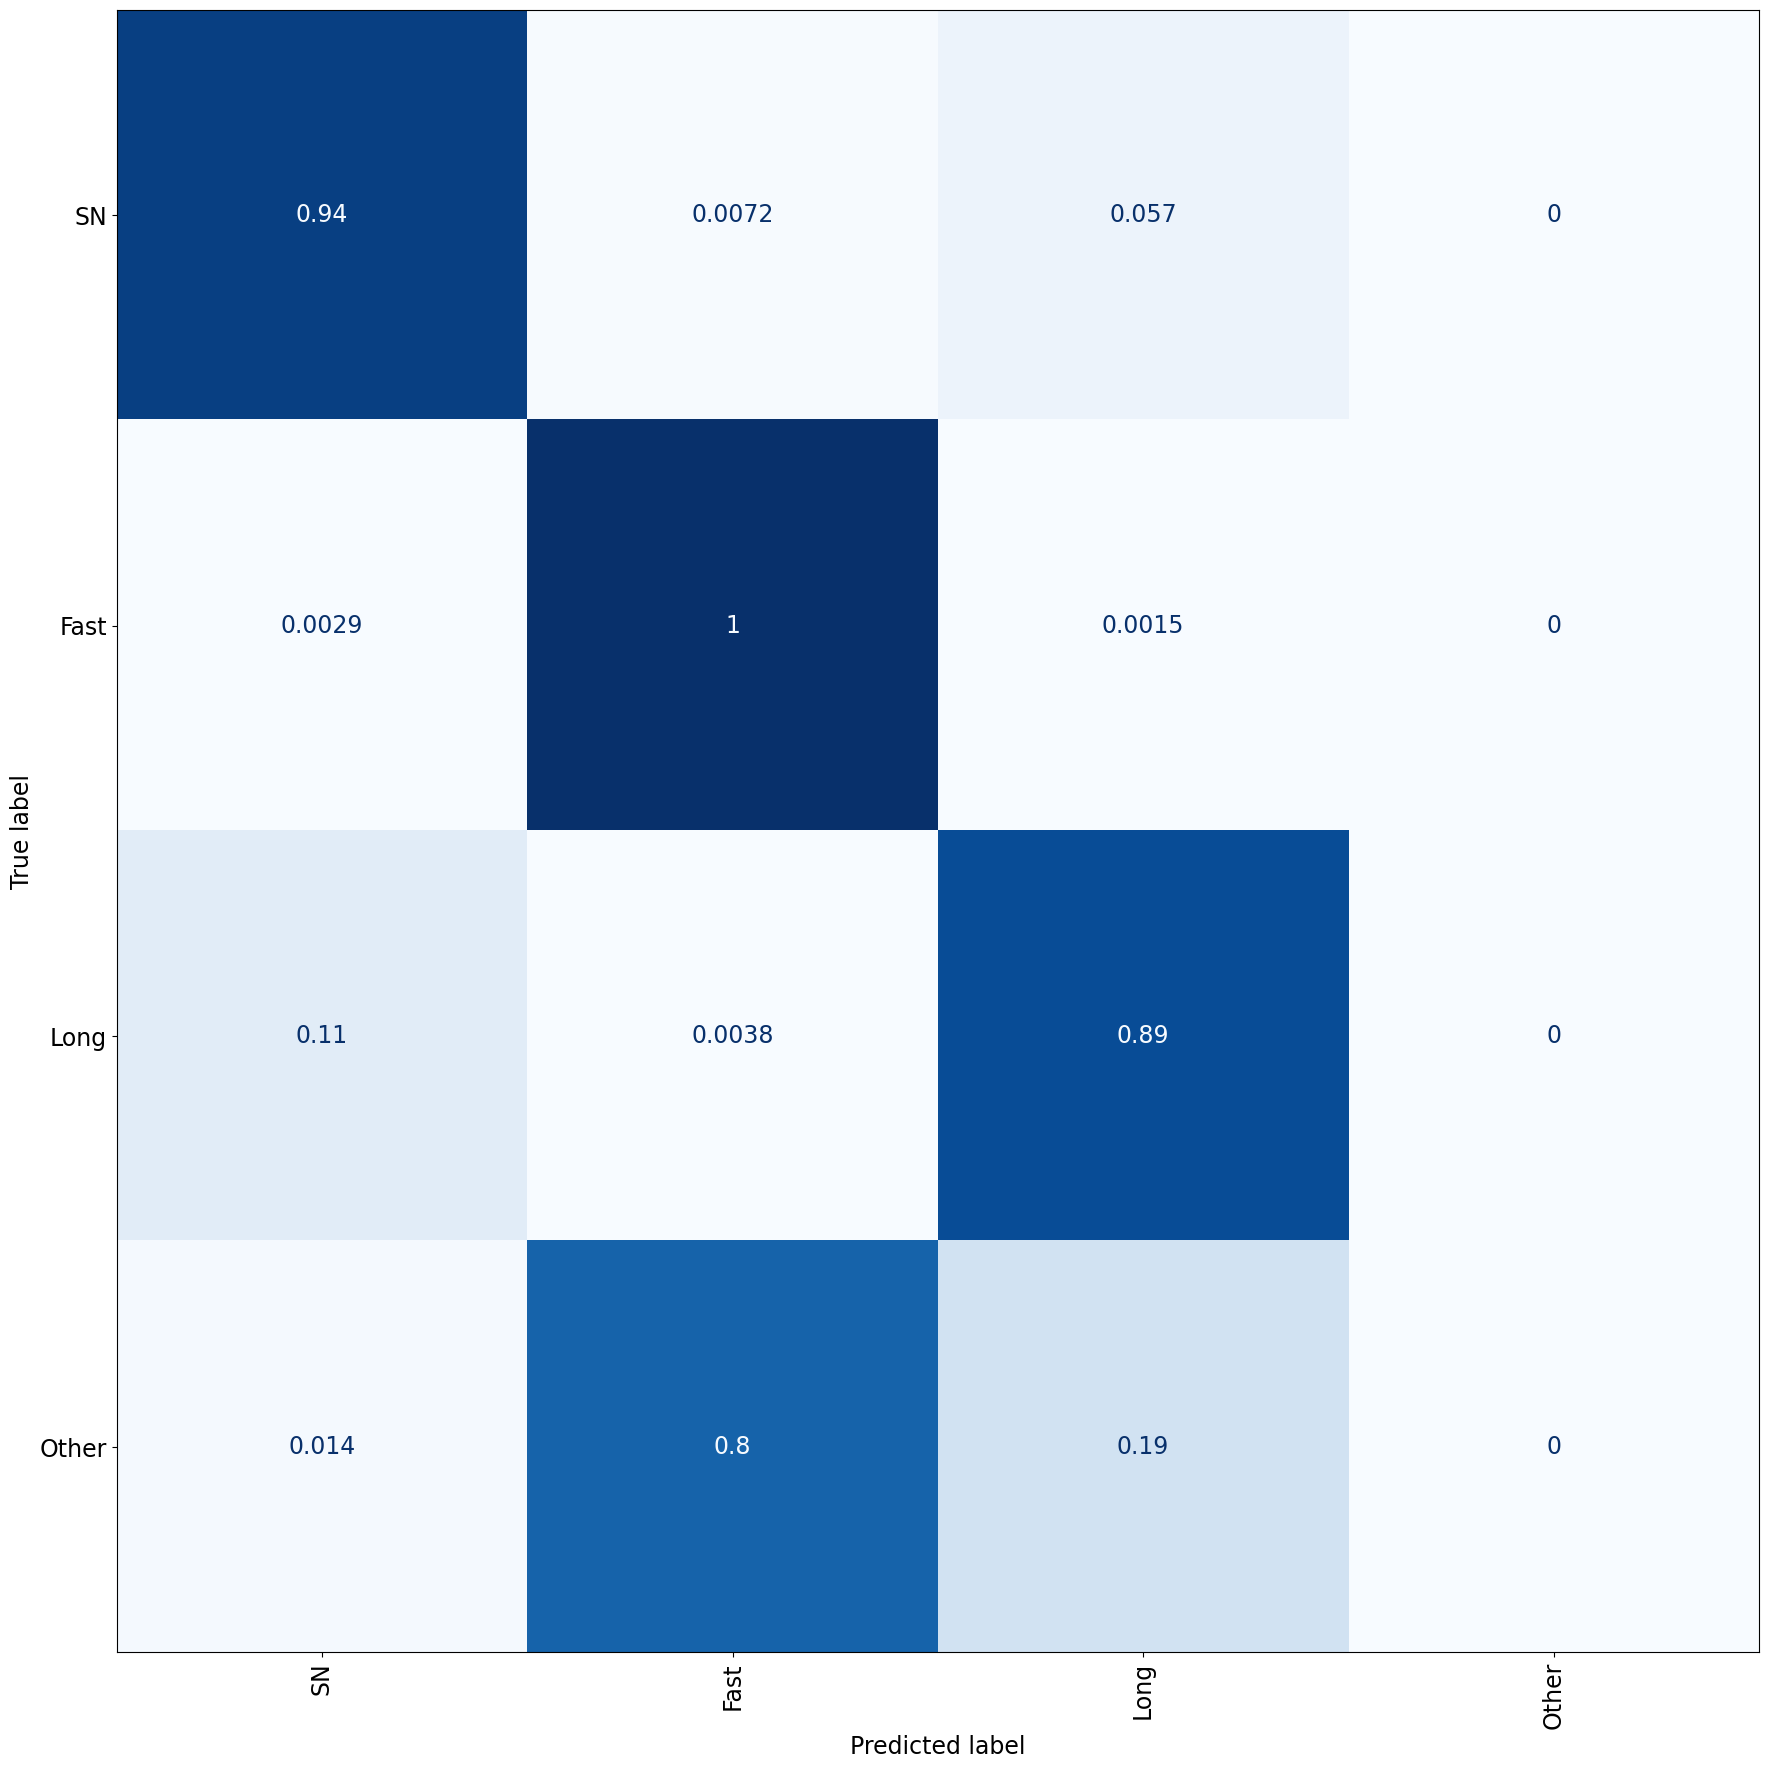

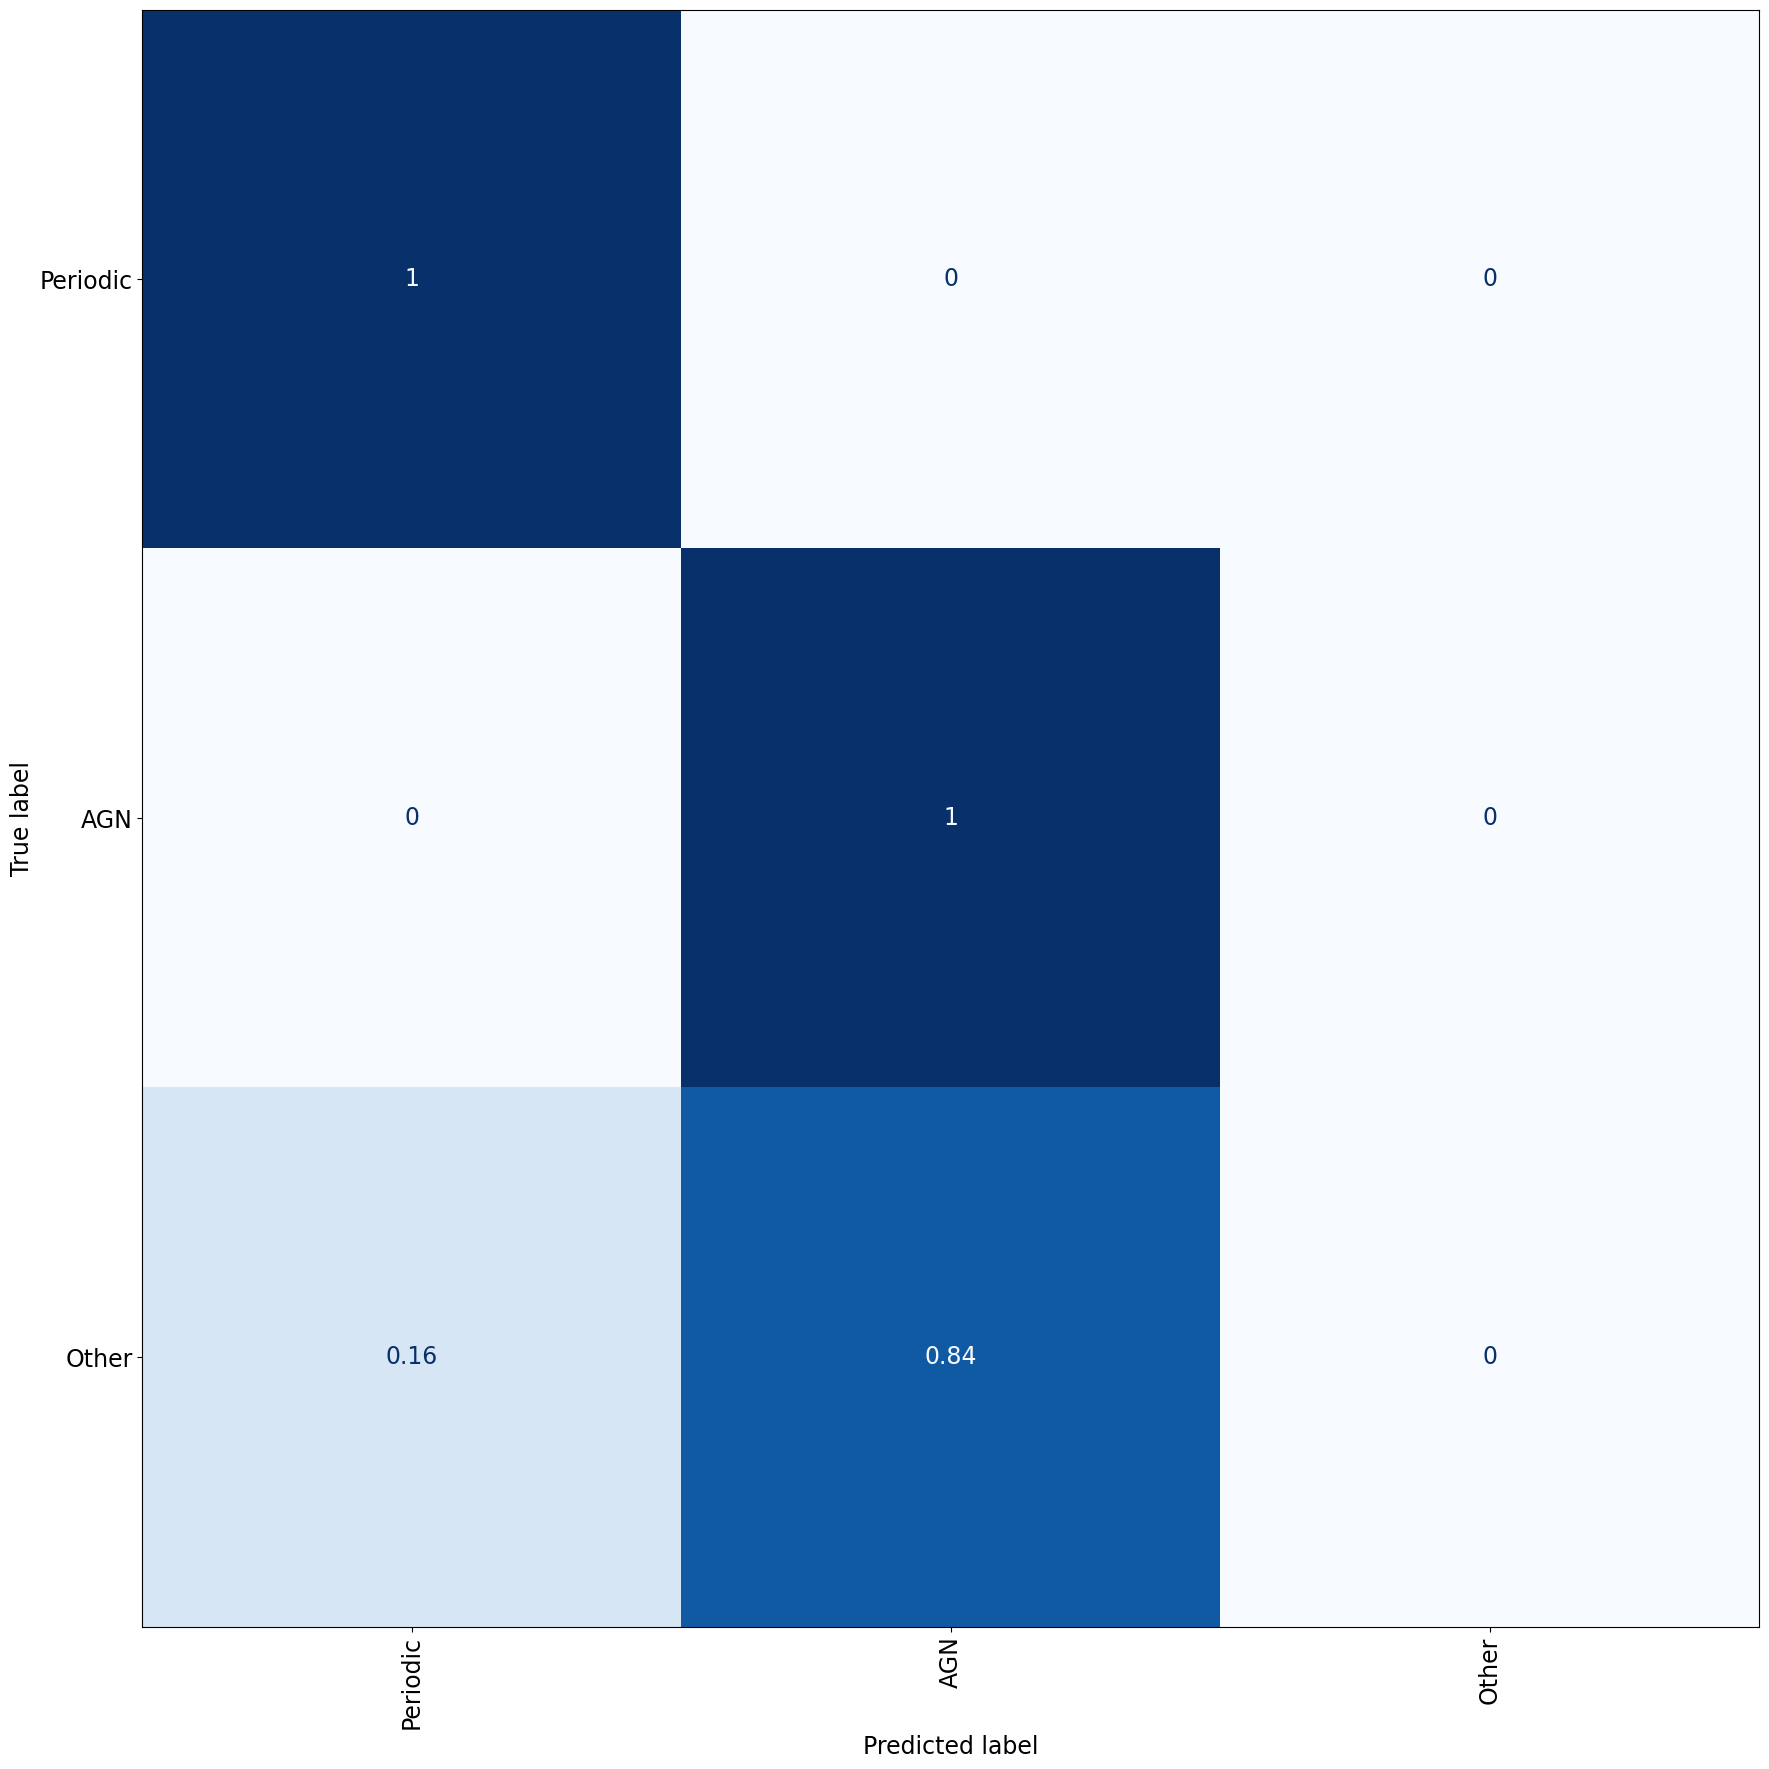

In [12]:
for f in fractions:

    print(f'Running inference for {int(f*100)}% light curves...')

    x1, x2, y_true, _ = get_augmented_data(X_ts_val, X_static_val, Y_val, astrophysical_classes_val, fraction=f)
    
    # Run inference on these
    y_pred = saved_model.predict([x1, x2])

    # Get the conditional probabilities
    _, pseudo_conditional_probabilities = get_conditional_probabilites(y_pred, tree)
    
    print(f'For {int(f*100)}% of the light curve, these are the statistics')
    
    get_all_confusion_matrices(y_true, y_pred, tree)
    plt.show()
    #################################